# desilike

## Framework to specify DESI (clustering) likelihoods

### Tutorial #2: bindings with external inference codes

# Goals
At the end of the tutorial you will know:
- how to write likelihoods in terms of compressed parameters (e.g. based on forecasts), optionally with covariance between different measurements
- how to write full shape likelihoods, and emulate their theory
- how to run inference within desilike, or [Cobaya](https://github.com/CobayaSampler/cobaya), [CosmoSIS](https://github.com/joezuntz/cosmosis), and [MontePython](https://github.com/brinckmann/montepython_public).

For real-life examples, see [application to mock Y1 cosmological inference](https://github.com/cosmodesi/desi-y1-kp7/tree/main/mock_y1).

This is the continuation of the first tutorial, accessible here: [desilike tutorial #1](https://github.com/cosmodesi/desilike-tutorials).

# Environment

Easiest is to use the cosmodesi environment at NERSC:
```
source /global/cfs/cdirs/desi/users/adematti/cosmodesi_environment.sh main  # source the environment
${COSMODESIMODULES}/install_jupyter_kernel.sh main  # this to be done once
```
NB: to remove the previous kernel:
```
rm -rf $HOME/.local/share/jupyter/kernels/cosmodesi-main
```
To see these slides in a browser, e.g.:
```
firefox desilike_bindings.slides.html
```

# Compressed likelihoods

Let's first focus on compressed likelihoods = only depend on the cosmological model (nuisance = bias, stochastic and counterterms already marginalized out).

=> sampling of these likelihoods is typically fast enough that they do not need to be emulated.

## BAO likelihood

BAO likelihoods are built from a "BAO observable", that compares a data vector to a theory, typically $\alpha_{\perp}$ and $\alpha_{\parallel}$ or $D_{M}/r_{d}$ and $D_{H}/r_{d}$.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import jax; jax.config.update('jax_platform_name', 'cpu')

In [2]:
import numpy as np

from desilike import utils, setup_logging
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.observables.galaxy_clustering import BAOCompressionObservable

setup_logging()

# fiducial cosmology is DESI's by default
observable1 = BAOCompressionObservable(data=[1., 1.],
                                       covariance=np.diag([0.01, 0.01]),
                                       quantities=['qpar', 'qper'],
                                       z=1.)
# Let's define the likelihood from this observable
likelihood = ObservablesGaussianLikelihood(observable1)

### Reminder

In [3]:
# Likelihood parameters
print('varied likelihood parameters are', likelihood.varied_params.names())
# To evaluate the likelihood (return the logposterior)
print('logposterior is {:.3f}'.format(likelihood(Omega_m=0.29)))

[000000.16] [0/1] 07-02 10:22  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
varied likelihood parameters are ['Omega_m']
logposterior is -0.005


Why do we bother about "observables"?

... because we can join them in a likelihood!

In [4]:
# We want to share the same cosmological calculation among all observables
# so let's give it explicitly
from desilike.theories import Cosmoprimo
cosmo = Cosmoprimo(fiducial='DESI')
# Set Cosmoprimo calculator's parameters
cosmo.init.params = {'Omega_m': {'prior': {'limits': [0.1, 0.9]},
                                 'ref': {'dist': 'norm', 'loc': 0.3, 'scale': 0.002},
                                 'latex': '\Omega_m'}}
# Let's reuse the first observable we have defined, just updating the cosmo
observable1.init.update(cosmo=cosmo)
# Let's be fancy and rather define our observable in terms of DV_over_rd
# We provide a dictionary to "data": the theory vector will be generated automatically
observable2 = BAOCompressionObservable(data={}, quantities=['DV_over_rd'], z=1.5, cosmo=cosmo)
# Let's join the two observables, and provide the joint covariance
likelihood = ObservablesGaussianLikelihood([observable1, observable2], covariance=np.diag([0.01, 0.01, 1.]))
print('likelihood is {:.4f}'.format(likelihood()))

[000000.86] [0/1] 07-02 10:22  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
[000001.13] [0/1] 07-02 10:22  BAOCompressionObservable  INFO     Found quantities ['DV_over_rd'].
likelihood is -0.0000


We can also sum (log-) likelihoods!

In [5]:
likelihood2 = likelihood + likelihood
likelihood(Omega_m=0.29)
likelihood2(Omega_m=0.29)
assert np.allclose(likelihood2.loglikelihood, 2. * likelihood.loglikelihood)

## Bindings
To generate desilike bindings, let's start by writing a callable (~ "function") that returns the desilike likelihood.

In [6]:
def BAOLikelihood(cosmo='external'):
    # cosmo = 'external' to tell desilike that cosmo will be provided externally
    observable1 = BAOCompressionObservable(data=[1., 1.], quantities=['qpar', 'qper'], z=0.5, cosmo=cosmo)
    observable2 = BAOCompressionObservable(data=[1.], quantities=['qiso'], z=1., cosmo=cosmo)
    likelihood = ObservablesGaussianLikelihood([observable1, observable2],
                                               covariance=np.diag([0.002, 0.002, 0.005]))
    return likelihood

### Cobaya
### 'Dynamic' bindings

Cobaya is built such that we can provide likelihoods defined on-the-fly (i.e. not in a Python script), and run inference from Python directly.

In [7]:
from desilike.bindings.cobaya import CobayaLikelihoodFactory

# CobayaBAOLikelihood is a Cobaya Likelihood object
CobayaBAOLikelihood = CobayaLikelihoodFactory(BAOLikelihood, params=True)

[000001.73] [0/1] 07-02 10:22  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
[000001.81] [0/1] 07-02 10:22  BAOCompressionObservable  INFO     Found quantities ['qiso'].
[000002.03] [0/1] 07-02 10:22  numexpr.utils             INFO     NumExpr defaulting to 8 threads.


In [8]:
from cosmoprimo.fiducial import DESI
cosmo = DESI()

# No magic here, this is all Cobaya stuff
params = {'Omega_m': {'prior': {'min': 0.1, 'max': 1.},
                      'ref': {'dist': 'norm', 'loc': 0.3, 'scale': 0.01},
                      'latex': '\Omega_{m}'},
          'omega_b': cosmo['omega_b'],
          'H0': cosmo['H0'],
          'A_s': cosmo['A_s'],
          'n_s': cosmo['n_s'],
          'tau_reio': cosmo['tau_reio']}

info = {'params': params,
        'likelihood': {'bao_likelihood': CobayaBAOLikelihood},
        'theory': {'classy': {'extra_args': {'N_ncdm': cosmo['N_ncdm'], 'N_ur': cosmo['N_ur']}}}}

from cobaya.model import get_model
model = get_model(info)
model.logposterior({'Omega_m': cosmo['Omega_m']})

[000002.27] [0/1] 07-02 10:22  classy                    INFO     `classy` module loaded successfully from /home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/classy-3.2.0-py3.9-linux-x86_64.egg
[000002.35] [0/1] 07-02 10:22  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
[000002.44] [0/1] 07-02 10:22  BAOCompressionObservable  INFO     Found quantities ['qiso'].


LogPosterior(logpost=0.10471144781489061, logpriors=[0.10536051565782628], loglikes=array([-0.00064907]), derived=[], finite=False)

In [9]:
# Let's run MCMC!
info_sampler = {'mcmc': {'Rminus1_stop': 0.02}}
from cobaya.sampler import get_sampler
mcmc = get_sampler(info_sampler, model=model)
mcmc.run()

[000007.45] [0/1] 07-02 10:22  mcmc                      INFO     Getting initial point... (this may take a few seconds)
[000007.54] [0/1] 07-02 10:22  model                     INFO     Measuring speeds... (this may take a few seconds)
[000007.79] [0/1] 07-02 10:22  model                     INFO     Setting measured speeds (per sec): {bao_likelihood: 399.0, classy: 12.5}
[000007.79] [0/1] 07-02 10:22  mcmc                      INFO     Initial point: Omega_m:0.3151184
[000007.79] [0/1] 07-02 10:22  mcmc                      INFO     Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[000007.79] [0/1] 07-02 10:22  mcmc                      INFO     Sampling!
[000007.88] [0/1] 07-02 10:22  mcmc                      INFO     Progress @ 2023-07-02 10:22:39 : 1 steps taken, and 0 accepted.
[000011.29] [0/1] 07-02 10:22  mcmc                      INFO     Learn + convergence test @ 40 samples accepted.
[

[000054.16] [0/1] 07-02 10:23  root                      WARNING  outlier fraction 0.08076923076923077 


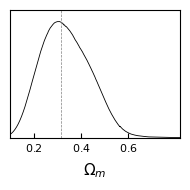

In [10]:
from getdist.mcsamples import MCSamplesFromCobaya
samples_bao_cobaya = mcmc.samples(combined=True, skip_samples=0.5, to_getdist=True).copy(label='cobaya')
from getdist import plots
g = plots.get_subplot_plotter()
g.triangle_plot(samples_bao_cobaya, params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

### Interlude: let's do the same within desilike

In [11]:
from desilike.samplers import MCMCSampler

from desilike.theories import Cosmoprimo
cosmo = Cosmoprimo(fiducial='DESI')
# Set Cosmoprimo calculator's parameters
cosmo.init.params = {'Omega_m': {'prior': {'limits': [0.1, 1.]},
                                 'ref': {'dist': 'norm', 'loc': 0.3, 'scale': 0.01},
                                 'latex': '\Omega_m'}}
sampler = MCMCSampler(BAOLikelihood(cosmo=cosmo), seed=42)
chains = sampler.run(check={'max_eigen_gr': 0.03, 'stable_over': 2}, check_every=40)
# do help(chains[0]) to get info on the available methods!
samples_bao_desilike = chains[0].remove_burnin(0.5).to_getdist(label='desilike')

[000054.78] [0/1] 07-02 10:23  BAOCompressionObservable  INFO     Found quantities ['qpar', 'qper'].
[000054.84] [0/1] 07-02 10:23  BAOCompressionObservable  INFO     Found quantities ['qiso'].
[000054.96] [0/1] 07-02 10:23  MCMCSampler               INFO     Varied parameters: ['Omega_m'].
[000055.50] [0/1] 07-02 10:23  BasePipeline              INFO     Found speeds:
[000055.50] [0/1] 07-02 10:23  BasePipeline              INFO     - <desilike.theories.primordial_cosmology.Cosmoprimo object at 0x7f1829effb20>: 1157.94 iterations / second
[000055.50] [0/1] 07-02 10:23  BasePipeline              INFO     - <desilike.theories.galaxy_clustering.power_template.BAOExtractor object at 0x7f1829e91370>: 22.03 iterations / second
[000055.51] [0/1] 07-02 10:23  BasePipeline              INFO     - <desilike.observables.galaxy_clustering.compression.BAOCompressionObservable object at 0x7f1829ea7ca0>: 4391.94 iterations / second
[000055.51] [0/1] 07-02 10:23  BasePipeline              INFO     - 

[000083.08] [0/1] 07-02 10:23  MCMCSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0264.
[000083.09] [0/1] 07-02 10:23  MCMCSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0624.
[000083.10] [0/1] 07-02 10:23  MCMCSampler               INFO     - max Geweke is 0.43.
[000083.10] [0/1] 07-02 10:23  MCMCSampler               INFO     - Geweke p-value is nan.
[000083.10] [0/1] 07-02 10:23  MCMCSampler               INFO     - (160 iterations / integrated autocorrelation time) (reliable) is 160.
[000083.10] [0/1] 07-02 10:23  MCMCSampler               INFO     - max variation of integrated autocorrelation time is 0.0771.
[000083.16] [0/1] 07-02 10:23  MCMCSampler               INFO     Updating proposal covariance.
[000086.97] [0/1] 07-02 10:23  MCMCSampler               INFO     Diagnostics:
[000086.97] [0/1] 07-02 10:23  MCMCSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0308; not < 0.03.
[000086.97] [0/1] 07-02 10:23  MCMCSam

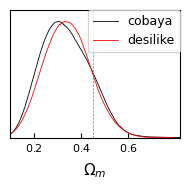

In [12]:
g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_cobaya, samples_bao_desilike],
                 params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

### 'Static' bindings

Other inference codes (CosmoSIS, MontePython) typically require the likelihood to be written down in a file,
such that it is imported by the code.
Let's illustrate this, still with Cobaya.

In [13]:
!rm -rf _tests

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [14]:
utils.mkdir('_tests')

In [15]:
%%file _tests/bao_likelihood.py

dirname = '.'

def BAOLikelihood(cosmo='external'):
    import numpy as np
    from desilike.observables.galaxy_clustering import BAOCompressionObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    # cosmo = 'external' to tell desilike that cosmo will be provided externally
    observable1 = BAOCompressionObservable(data=[1., 1.], quantities=['qpar', 'qper'], z=0.5, cosmo=cosmo)
    observable2 = BAOCompressionObservable(data=[1.], quantities=['qiso'], z=1., cosmo=cosmo)
    likelihood = ObservablesGaussianLikelihood([observable1, observable2],
                                               covariance=np.diag([0.002, 0.002, 0.005]))
    return likelihood

if __name__ == '__main__':
    from desilike.bindings import CobayaLikelihoodGenerator
    # We could provide a list of Likelihoods, which will all be written at once
    CobayaLikelihoodGenerator(dirname=dirname)([BAOLikelihood], kw_like={'cosmo': 'external'})

Writing _tests/bao_likelihood.py


Let's generate the static bindings by calling the above Python script

In [16]:
%%bash
cd _tests/
python bao_likelihood.py

bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by bash)


Let's take a look at the generated files:
- the Python module containing the Cobaya likelihood: ``bao_likelihood.py``
- imported in the ``__init__.py``
- the ``.yaml`` config file containing the nuisance parameters (none in this case)

In [17]:
!ls -la _tests/cobaya

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 20
drwxr-xr-x 2 adematti idphp 4096 juil.  2 10:24 .
drwxr-xr-x 3 adematti idphp 4096 juil.  2 10:24 ..
-rw-r--r-- 1 adematti idphp  477 juil.  2 10:24 bao_likelihood.py
-rw-r--r-- 1 adematti idphp   31 juil.  2 10:24 BAOLikelihood.yaml
-rw-r--r-- 1 adematti idphp   30 juil.  2 10:24 __init__.py


In [18]:
!cat _tests/cobaya/BAOLikelihood.yaml

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
params: {}
stop_at_error: true


In [19]:
# %load _tests/cobaya/my_likelihood.py
# NOTE: This code has been automatically generated by desilike.bindings.cobaya.factory.CobayaLikelihoodGenerator
from desilike.bindings.cobaya.factory import CobayaLikelihoodFactory

from desilike.bindings.base import load_from_file
BAOLikelihood = load_from_file('/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike-tutorials/_tests/bao_likelihood.py', 'BAOLikelihood')
BAOLikelihood = CobayaLikelihoodFactory(BAOLikelihood, 'BAOLikelihood',
                                        {'cosmo': 'external'}, __name__)

Now let's write the config file to run inference. This is pure Cobaya.

In [20]:
%%file _tests/config_bao.yaml

theory:
  classy:
    extra_args:
      N_ncdm: 1
      N_ur: 2.0328

likelihood:
  bao_likelihood.BAOLikelihood:
      python_path: _tests/cobaya

params:
  Omega_m:
    prior:
      min: 0.1
      max: 1.
    ref:
      dist: norm
      loc: 0.3
      scale: 0.01
    latex: \Omega_{m}
  omega_b: 0.02237
  H0: 67.36
  As: 2.083e-09
  n_s: 0.9649
  tau_reio: 0.0544

sampler:
  mcmc:
    Rminus1_stop: 0.02

debug: True

output: _tests/chains_bao_cobaya/chain


Writing _tests/config_bao.yaml


Let's sample!

In [21]:
!cobaya-run _tests/config_bao.yaml

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
 2023-07-02 10:24:11,168 [output] Creating output folder '_tests/chains_bao_cobaya'
 2023-07-02 10:24:11,168 [output] Output to be read-from/written-into folder '_tests/chains_bao_cobaya', with prefix 'chain'
 2023-07-02 10:24:14,042 [root] Initializing MLIR with module: _mlirRegisterEverything
 2023-07-02 10:24:14,042 [root] Registering dialects from initializer <module 'jaxlib.mlir._mlir_libs._mlirRegisterEverything' from '/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs/_mlirRegisterEverything.so'>
 2023-07-02 10:24:14,212 [absl] Finished tracing + transforming prim_fun for jit in 0.00026226043701171875 sec
 2023-07-02 10:24:14,212 [absl] Initializing backend 'interpreter'
 2023-07-02 10:24:14,213 [absl] Backend 'interpreter' initialized
 2023-07-02 10:24:14,213 [absl] Initializing backend 'cpu'
 2023-07-02 10:24:14,

 2023-07-02 10:24:15,073 [classy] Average evaluation time: 0.0555832 s
 2023-07-02 10:24:15,073 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.25067556440436}
 2023-07-02 10:24:15,074 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:15,076 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00453072
 2023-07-02 10:24:15,076 [bao_likelihood.baolikelihood] Average evaluation time: 0.00288756 s
 2023-07-02 10:24:15,076 [model] Computed derived parameters: {}
 2023-07-02 10:24:15,077 [prior] Evaluating prior at array([0.30121144])
 2023-07-02 10:24:15,077 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:15,077 [model] Got input parameters: {'Omega_m': 0.30121144035944686, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:15,077 [classy] Got parameters {'Omega_m': 0.30121144035944686, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-

 2023-07-02 10:24:15,438 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.1081750507962}
 2023-07-02 10:24:15,438 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:15,440 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0199404
 2023-07-02 10:24:15,440 [model] Computed derived parameters: {}
 2023-07-02 10:24:15,440 [mcmc] New sample, #4: 
   Omega_m:0.3241301
 2023-07-02 10:24:15,441 [model] Posterior to be computed for parameters {'Omega_m': 0.33607200100876394}
 2023-07-02 10:24:15,441 [prior] Evaluating prior at array([0.336072])
 2023-07-02 10:24:15,441 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:15,441 [model] Got input parameters: {'Omega_m': 0.33607200100876394, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:15,441 [classy] Got parameters {'Omega_m': 0.33607200100876394, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}

 2023-07-02 10:24:15,849 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.6435741385667}
 2023-07-02 10:24:15,849 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:15,851 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0240966
 2023-07-02 10:24:15,851 [model] Computed derived parameters: {}
 2023-07-02 10:24:15,851 [mcmc] New sample, #11: 
   Omega_m:0.3123374
 2023-07-02 10:24:15,851 [model] Posterior to be computed for parameters {'Omega_m': 0.29947916769934524}
 2023-07-02 10:24:15,851 [prior] Evaluating prior at array([0.29947917])
 2023-07-02 10:24:15,851 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:15,851 [model] Got input parameters: {'Omega_m': 0.29947916769934524, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:15,851 [classy] Got parameters {'Omega_m': 0.29947916769934524, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.05

 2023-07-02 10:24:16,218 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.4435138141882}
 2023-07-02 10:24:16,218 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:16,220 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0202653
 2023-07-02 10:24:16,220 [model] Computed derived parameters: {}
 2023-07-02 10:24:16,220 [mcmc] New sample, #17: 
   Omega_m:0.2760917
 2023-07-02 10:24:16,220 [model] Posterior to be computed for parameters {'Omega_m': 0.29865588582998637}
 2023-07-02 10:24:16,220 [prior] Evaluating prior at array([0.29865589])
 2023-07-02 10:24:16,220 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:16,220 [model] Got input parameters: {'Omega_m': 0.29865588582998637, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:16,220 [classy] Got parameters {'Omega_m': 0.29865588582998637, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.05

 2023-07-02 10:24:16,598 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.1358969285858}
 2023-07-02 10:24:16,598 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:16,600 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0150234
 2023-07-02 10:24:16,600 [model] Computed derived parameters: {}
 2023-07-02 10:24:16,600 [mcmc] New sample, #24: 
   Omega_m:0.2969693
 2023-07-02 10:24:16,600 [model] Posterior to be computed for parameters {'Omega_m': 0.3499030775936966}
 2023-07-02 10:24:16,600 [prior] Evaluating prior at array([0.34990308])
 2023-07-02 10:24:16,601 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:16,601 [model] Got input parameters: {'Omega_m': 0.3499030775936966, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:16,601 [classy] Got parameters {'Omega_m': 0.3499030775936966, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}

 2023-07-02 10:24:17,033 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.6389719980835}
 2023-07-02 10:24:17,034 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:17,035 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0563373
 2023-07-02 10:24:17,035 [model] Computed derived parameters: {}
 2023-07-02 10:24:17,036 [mcmc] New sample, #31: 
   Omega_m:0.3312094
 2023-07-02 10:24:17,036 [model] Posterior to be computed for parameters {'Omega_m': 0.3333248644244746}
 2023-07-02 10:24:17,036 [prior] Evaluating prior at array([0.33332486])
 2023-07-02 10:24:17,036 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:17,036 [model] Got input parameters: {'Omega_m': 0.3333248644244746, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:17,036 [classy] Got parameters {'Omega_m': 0.3333248644244746, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}

 2023-07-02 10:24:17,442 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.5683228147591}
 2023-07-02 10:24:17,442 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:17,445 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0585616
 2023-07-02 10:24:17,445 [model] Computed derived parameters: {}
 2023-07-02 10:24:17,445 [mcmc] New sample, #38: 
   Omega_m:0.3481014
 2023-07-02 10:24:17,446 [model] Posterior to be computed for parameters {'Omega_m': 0.3468201565018789}
 2023-07-02 10:24:17,446 [prior] Evaluating prior at array([0.34682016])
 2023-07-02 10:24:17,446 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:17,446 [model] Got input parameters: {'Omega_m': 0.3468201565018789, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:17,446 [classy] Got parameters {'Omega_m': 0.3468201565018789, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}

 2023-07-02 10:24:17,819 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 139.39689420537823}
 2023-07-02 10:24:17,819 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:17,821 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.26832
 2023-07-02 10:24:17,821 [model] Computed derived parameters: {}
 2023-07-02 10:24:17,821 [mcmc] New sample, #44: 
   Omega_m:0.3591187
 2023-07-02 10:24:17,821 [model] Posterior to be computed for parameters {'Omega_m': 0.29690913953196835}
 2023-07-02 10:24:17,821 [prior] Evaluating prior at array([0.29690914])
 2023-07-02 10:24:17,821 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:17,821 [model] Got input parameters: {'Omega_m': 0.29690913953196835, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:17,821 [classy] Got parameters {'Omega_m': 0.29690913953196835, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.054

 2023-07-02 10:24:18,235 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.10741653786135}
 2023-07-02 10:24:18,235 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:18,237 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.074144
 2023-07-02 10:24:18,237 [model] Computed derived parameters: {}
 2023-07-02 10:24:18,237 [mcmc] New sample, #51: 
   Omega_m:0.4020604
 2023-07-02 10:24:18,237 [model] Posterior to be computed for parameters {'Omega_m': 0.3790102593223994}
 2023-07-02 10:24:18,237 [prior] Evaluating prior at array([0.37901026])
 2023-07-02 10:24:18,238 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:18,238 [model] Got input parameters: {'Omega_m': 0.3790102593223994, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:18,238 [classy] Got parameters {'Omega_m': 0.3790102593223994, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}

 2023-07-02 10:24:18,579 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 133.13674000765212}
 2023-07-02 10:24:18,579 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:18,581 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.882354
 2023-07-02 10:24:18,581 [model] Computed derived parameters: {}
 2023-07-02 10:24:18,581 [mcmc] New sample, #57: 
   Omega_m:0.4231566
 2023-07-02 10:24:18,581 [model] Posterior to be computed for parameters {'Omega_m': 0.4683741499572768}
 2023-07-02 10:24:18,581 [prior] Evaluating prior at array([0.46837415])
 2023-07-02 10:24:18,581 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:18,581 [model] Got input parameters: {'Omega_m': 0.4683741499572768, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:18,581 [classy] Got parameters {'Omega_m': 0.4683741499572768, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}

 2023-07-02 10:24:18,928 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.23406218474446}
 2023-07-02 10:24:18,928 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:18,930 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0166106
 2023-07-02 10:24:18,930 [model] Computed derived parameters: {}
 2023-07-02 10:24:18,930 [mcmc] New sample, #63: 
   Omega_m:0.313376
 2023-07-02 10:24:18,930 [model] Posterior to be computed for parameters {'Omega_m': 0.29042647734846566}
 2023-07-02 10:24:18,930 [prior] Evaluating prior at array([0.29042648])
 2023-07-02 10:24:18,930 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:18,930 [model] Got input parameters: {'Omega_m': 0.29042647734846566, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:18,930 [classy] Got parameters {'Omega_m': 0.29042647734846566, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.05

 2023-07-02 10:24:19,283 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 141.21219013189292}
 2023-07-02 10:24:19,283 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:19,284 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.157937
 2023-07-02 10:24:19,284 [model] Computed derived parameters: {}
 2023-07-02 10:24:19,285 [mcmc] New sample, #69: 
   Omega_m:0.3964571
 2023-07-02 10:24:19,285 [model] Posterior to be computed for parameters {'Omega_m': 0.367761724113744}
 2023-07-02 10:24:19,285 [prior] Evaluating prior at array([0.36776172])
 2023-07-02 10:24:19,285 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:19,285 [model] Got input parameters: {'Omega_m': 0.367761724113744, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:19,285 [classy] Got parameters {'Omega_m': 0.367761724113744, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2

 2023-07-02 10:24:19,628 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.27946936789536}
 2023-07-02 10:24:19,629 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:19,630 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0681091
 2023-07-02 10:24:19,630 [model] Computed derived parameters: {}
 2023-07-02 10:24:19,630 [mcmc] New sample, #76: 
   Omega_m:0.3709982
 2023-07-02 10:24:19,630 [model] Posterior to be computed for parameters {'Omega_m': 0.3564838863913796}
 2023-07-02 10:24:19,630 [prior] Evaluating prior at array([0.35648389])
 2023-07-02 10:24:19,631 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:19,631 [model] Got input parameters: {'Omega_m': 0.3564838863913796, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:19,631 [classy] Got parameters {'Omega_m': 0.3564838863913796, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544

 2023-07-02 10:24:19,939 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.43423342247658}
 2023-07-02 10:24:19,939 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:19,941 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0629027
 2023-07-02 10:24:19,941 [model] Computed derived parameters: {}
 2023-07-02 10:24:19,941 [mcmc] New sample, #82: 
   Omega_m:0.3254281
 2023-07-02 10:24:19,941 [model] Posterior to be computed for parameters {'Omega_m': 0.33183721574281244}
 2023-07-02 10:24:19,941 [prior] Evaluating prior at array([0.33183722])
 2023-07-02 10:24:19,941 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:19,941 [model] Got input parameters: {'Omega_m': 0.33183721574281244, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:19,942 [classy] Got parameters {'Omega_m': 0.33183721574281244, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0

 2023-07-02 10:24:20,285 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 123.17651197891021}
 2023-07-02 10:24:20,285 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:20,287 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.65186
 2023-07-02 10:24:20,287 [model] Computed derived parameters: {}
 2023-07-02 10:24:20,287 [model] Posterior to be computed for parameters {'Omega_m': 0.34098361597985255}
 2023-07-02 10:24:20,287 [prior] Evaluating prior at array([0.34098362])
 2023-07-02 10:24:20,287 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:20,287 [model] Got input parameters: {'Omega_m': 0.34098361597985255, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:20,287 [classy] Got parameters {'Omega_m': 0.34098361597985255, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:20,287 [classy] Computing new state
 2023-07-02 10

 2023-07-02 10:24:20,627 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.57983036946771}
 2023-07-02 10:24:20,627 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:20,629 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0122194
 2023-07-02 10:24:20,629 [model] Computed derived parameters: {}
 2023-07-02 10:24:20,629 [mcmc] New sample, #93: 
   Omega_m:0.371303
 2023-07-02 10:24:20,629 [model] Posterior to be computed for parameters {'Omega_m': 0.4607339937525602}
 2023-07-02 10:24:20,630 [prior] Evaluating prior at array([0.46073399])
 2023-07-02 10:24:20,630 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:20,630 [model] Got input parameters: {'Omega_m': 0.4607339937525602, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:20,630 [classy] Got parameters {'Omega_m': 0.4607339937525602, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}

 2023-07-02 10:24:20,969 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 113.06243018594267}
 2023-07-02 10:24:20,969 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:20,970 [bao_likelihood.baolikelihood] Computed log-likelihood = -5.54479
 2023-07-02 10:24:20,971 [model] Computed derived parameters: {}
 2023-07-02 10:24:20,971 [model] Posterior to be computed for parameters {'Omega_m': 0.8284890662465013}
 2023-07-02 10:24:20,971 [prior] Evaluating prior at array([0.82848907])
 2023-07-02 10:24:20,971 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:20,971 [model] Got input parameters: {'Omega_m': 0.8284890662465013, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:20,971 [classy] Got parameters {'Omega_m': 0.8284890662465013, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:20,971 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:21,310 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 130.74337788323268}
 2023-07-02 10:24:21,310 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:21,312 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.21606
 2023-07-02 10:24:21,312 [model] Computed derived parameters: {}
 2023-07-02 10:24:21,312 [model] Posterior to be computed for parameters {'Omega_m': 0.3238356064504956}
 2023-07-02 10:24:21,312 [prior] Evaluating prior at array([0.32383561])
 2023-07-02 10:24:21,312 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:21,312 [model] Got input parameters: {'Omega_m': 0.3238356064504956, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:21,312 [classy] Got parameters {'Omega_m': 0.3238356064504956, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:21,312 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:21,660 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 166.52807996718136}
 2023-07-02 10:24:21,660 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:21,662 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.4905
 2023-07-02 10:24:21,662 [model] Computed derived parameters: {}
 2023-07-02 10:24:21,662 [model] Posterior to be computed for parameters {'Omega_m': 0.26142035989498996}
 2023-07-02 10:24:21,662 [prior] Evaluating prior at array([0.26142036])
 2023-07-02 10:24:21,662 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:21,662 [model] Got input parameters: {'Omega_m': 0.26142035989498996, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:21,663 [classy] Got parameters {'Omega_m': 0.26142035989498996, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:21,663 [classy] Computing new state
 2023-07-02 10:

 2023-07-02 10:24:22,010 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.79619655141454}
 2023-07-02 10:24:22,010 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:22,013 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0857218
 2023-07-02 10:24:22,013 [model] Computed derived parameters: {}
 2023-07-02 10:24:22,014 [mcmc] New sample, #115: 
   Omega_m:0.3056634
 2023-07-02 10:24:22,014 [model] Posterior to be computed for parameters {'Omega_m': 0.4427614040795856}
 2023-07-02 10:24:22,014 [prior] Evaluating prior at array([0.4427614])
 2023-07-02 10:24:22,014 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:22,014 [model] Got input parameters: {'Omega_m': 0.4427614040795856, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:22,014 [classy] Got parameters {'Omega_m': 0.4427614040795856, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544

 2023-07-02 10:24:22,385 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 174.82952700610903}
 2023-07-02 10:24:22,385 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:22,387 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.9856
 2023-07-02 10:24:22,387 [model] Computed derived parameters: {}
 2023-07-02 10:24:22,387 [mcmc] New sample, #121: 
   Omega_m:0.3407912
 2023-07-02 10:24:22,387 [model] Posterior to be computed for parameters {'Omega_m': -0.33651803915215794}
 2023-07-02 10:24:22,387 [prior] Evaluating prior at array([-0.33651804])
 2023-07-02 10:24:22,387 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:22,387 [model] Posterior to be computed for parameters {'Omega_m': 0.06128268951356944}
 2023-07-02 10:24:22,387 [prior] Evaluating prior at array([0.06128269])
 2023-07-02 10:24:22,387 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:22,387 [model] Posterior to be computed for parameters {'Omega_m': 0.4818798357930848}
 

 2023-07-02 10:24:22,729 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 121.15268770890266}
 2023-07-02 10:24:22,729 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:22,731 [bao_likelihood.baolikelihood] Computed log-likelihood = -3.13828
 2023-07-02 10:24:22,731 [model] Computed derived parameters: {}
 2023-07-02 10:24:22,731 [model] Posterior to be computed for parameters {'Omega_m': 0.5425659347968598}
 2023-07-02 10:24:22,731 [prior] Evaluating prior at array([0.54256593])
 2023-07-02 10:24:22,731 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:22,731 [model] Got input parameters: {'Omega_m': 0.5425659347968598, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:22,731 [classy] Got parameters {'Omega_m': 0.5425659347968598, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:22,731 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:23,027 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.35037135446305}
 2023-07-02 10:24:23,027 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:23,029 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.103797
 2023-07-02 10:24:23,029 [model] Computed derived parameters: {}
 2023-07-02 10:24:23,029 [mcmc] New sample, #127: 
   Omega_m:0.2416766
 2023-07-02 10:24:23,029 [model] Posterior to be computed for parameters {'Omega_m': 0.3905998800715945}
 2023-07-02 10:24:23,029 [prior] Evaluating prior at array([0.39059988])
 2023-07-02 10:24:23,029 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:23,029 [model] Got input parameters: {'Omega_m': 0.3905998800715945, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:23,029 [classy] Got parameters {'Omega_m': 0.3905998800715945, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544

 2023-07-02 10:24:23,378 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 162.02879024975945}
 2023-07-02 10:24:23,378 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:23,380 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.886402
 2023-07-02 10:24:23,380 [model] Computed derived parameters: {}
 2023-07-02 10:24:23,380 [model] Posterior to be computed for parameters {'Omega_m': 0.2221715877530942}
 2023-07-02 10:24:23,380 [prior] Evaluating prior at array([0.22217159])
 2023-07-02 10:24:23,380 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:23,380 [model] Got input parameters: {'Omega_m': 0.2221715877530942, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:23,380 [classy] Got parameters {'Omega_m': 0.2221715877530942, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:23,380 [classy] Computing new state
 2023-07-02 10:2

 2023-07-02 10:24:23,723 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 169.84233671992158}
 2023-07-02 10:24:23,723 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:23,725 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.02942
 2023-07-02 10:24:23,725 [model] Computed derived parameters: {}
 2023-07-02 10:24:23,725 [mcmc] New sample, #133: 
   Omega_m:0.1653382
 2023-07-02 10:24:23,725 [model] Posterior to be computed for parameters {'Omega_m': 0.46337149122354393}
 2023-07-02 10:24:23,725 [prior] Evaluating prior at array([0.46337149])
 2023-07-02 10:24:23,725 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:23,725 [model] Got input parameters: {'Omega_m': 0.46337149122354393, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:23,725 [classy] Got parameters {'Omega_m': 0.46337149122354393, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.05

 2023-07-02 10:24:24,112 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 120.24713523779305}
 2023-07-02 10:24:24,112 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:24,114 [bao_likelihood.baolikelihood] Computed log-likelihood = -3.37049
 2023-07-02 10:24:24,114 [model] Computed derived parameters: {}
 2023-07-02 10:24:24,114 [model] Posterior to be computed for parameters {'Omega_m': 0.305662828461555}
 2023-07-02 10:24:24,114 [prior] Evaluating prior at array([0.30566283])
 2023-07-02 10:24:24,115 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:24,115 [model] Got input parameters: {'Omega_m': 0.305662828461555, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:24,115 [classy] Got parameters {'Omega_m': 0.305662828461555, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:24,115 [classy] Computing new state
 2023-07-02 10:24:24

 2023-07-02 10:24:24,412 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 125.10755005544335}
 2023-07-02 10:24:24,412 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:24,413 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.22886
 2023-07-02 10:24:24,413 [model] Computed derived parameters: {}
 2023-07-02 10:24:24,414 [model] Posterior to be computed for parameters {'Omega_m': 0.2946949033424985}
 2023-07-02 10:24:24,414 [prior] Evaluating prior at array([0.2946949])
 2023-07-02 10:24:24,414 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:24,414 [model] Got input parameters: {'Omega_m': 0.2946949033424985, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:24,414 [classy] Got parameters {'Omega_m': 0.2946949033424985, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:24,414 [classy] Computing new state
 2023-07-02 10:24:

 2023-07-02 10:24:24,756 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 106.69436053260269}
 2023-07-02 10:24:24,756 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:24,758 [bao_likelihood.baolikelihood] Computed log-likelihood = -7.99539
 2023-07-02 10:24:24,758 [model] Computed derived parameters: {}
 2023-07-02 10:24:24,758 [model] Posterior to be computed for parameters {'Omega_m': 0.19156367502989086}
 2023-07-02 10:24:24,758 [prior] Evaluating prior at array([0.19156368])
 2023-07-02 10:24:24,758 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:24,758 [model] Got input parameters: {'Omega_m': 0.19156367502989086, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:24,758 [classy] Got parameters {'Omega_m': 0.19156367502989086, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:24,758 [classy] Computing new state
 2023-07-02 10

 2023-07-02 10:24:25,107 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 173.07108984499627}
 2023-07-02 10:24:25,107 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:25,108 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.62888
 2023-07-02 10:24:25,108 [model] Computed derived parameters: {}
 2023-07-02 10:24:25,108 [model] Posterior to be computed for parameters {'Omega_m': 0.12230486797178103}
 2023-07-02 10:24:25,109 [prior] Evaluating prior at array([0.12230487])
 2023-07-02 10:24:25,109 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:25,109 [model] Got input parameters: {'Omega_m': 0.12230486797178103, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:25,109 [classy] Got parameters {'Omega_m': 0.12230486797178103, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:25,109 [classy] Computing new state
 2023-07-02 10

 2023-07-02 10:24:25,452 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.62629260300002}
 2023-07-02 10:24:25,452 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:25,454 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.092403
 2023-07-02 10:24:25,455 [model] Computed derived parameters: {}
 2023-07-02 10:24:25,455 [mcmc] New sample, #154: 
   Omega_m:0.3083756
 2023-07-02 10:24:25,455 [model] Posterior to be computed for parameters {'Omega_m': 0.5005742682134801}
 2023-07-02 10:24:25,455 [prior] Evaluating prior at array([0.50057427])
 2023-07-02 10:24:25,455 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:25,455 [model] Got input parameters: {'Omega_m': 0.5005742682134801, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:25,455 [classy] Got parameters {'Omega_m': 0.5005742682134801, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544

 2023-07-02 10:24:25,798 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 129.90142308539504}
 2023-07-02 10:24:25,798 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:25,800 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.34689
 2023-07-02 10:24:25,800 [model] Computed derived parameters: {}
 2023-07-02 10:24:25,800 [mcmc] New sample, #159: 
   Omega_m:0.516706
 2023-07-02 10:24:25,800 [model] Posterior to be computed for parameters {'Omega_m': 0.6430921747357369}
 2023-07-02 10:24:25,800 [prior] Evaluating prior at array([0.64309217])
 2023-07-02 10:24:25,801 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:25,801 [model] Got input parameters: {'Omega_m': 0.6430921747357369, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:25,801 [classy] Got parameters {'Omega_m': 0.6430921747357369, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}


 2023-07-02 10:24:26,153 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 113.98093873759065}
 2023-07-02 10:24:26,153 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:26,155 [bao_likelihood.baolikelihood] Computed log-likelihood = -5.23299
 2023-07-02 10:24:26,155 [model] Computed derived parameters: {}
 2023-07-02 10:24:26,155 [model] Posterior to be computed for parameters {'Omega_m': 0.5845237762772991}
 2023-07-02 10:24:26,155 [prior] Evaluating prior at array([0.58452378])
 2023-07-02 10:24:26,155 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:26,155 [model] Got input parameters: {'Omega_m': 0.5845237762772991, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:26,155 [classy] Got parameters {'Omega_m': 0.5845237762772991, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:26,155 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:26,504 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 152.42336273891743}
 2023-07-02 10:24:26,504 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:26,506 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.111442
 2023-07-02 10:24:26,506 [model] Computed derived parameters: {}
 2023-07-02 10:24:26,506 [mcmc] New sample, #166: 
   Omega_m:0.3568388
 2023-07-02 10:24:26,506 [model] Posterior to be computed for parameters {'Omega_m': 0.14282092452913356}
 2023-07-02 10:24:26,506 [prior] Evaluating prior at array([0.14282092])
 2023-07-02 10:24:26,506 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:26,506 [model] Got input parameters: {'Omega_m': 0.14282092452913356, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:26,506 [classy] Got parameters {'Omega_m': 0.14282092452913356, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0

 2023-07-02 10:24:26,817 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 124.34379622318833}
 2023-07-02 10:24:26,817 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:26,819 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.39142
 2023-07-02 10:24:26,819 [model] Computed derived parameters: {}
 2023-07-02 10:24:26,819 [model] Posterior to be computed for parameters {'Omega_m': 0.8050832595443578}
 2023-07-02 10:24:26,819 [prior] Evaluating prior at array([0.80508326])
 2023-07-02 10:24:26,819 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:26,819 [model] Got input parameters: {'Omega_m': 0.8050832595443578, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:26,819 [classy] Got parameters {'Omega_m': 0.8050832595443578, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:26,819 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:27,168 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 125.57061084606978}
 2023-07-02 10:24:27,168 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:27,170 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.13331
 2023-07-02 10:24:27,170 [model] Computed derived parameters: {}
 2023-07-02 10:24:27,170 [mcmc] New sample, #170: 
   Omega_m:0.534067
 2023-07-02 10:24:27,170 [model] Posterior to be computed for parameters {'Omega_m': 0.6007601829917492}
 2023-07-02 10:24:27,170 [prior] Evaluating prior at array([0.60076018])
 2023-07-02 10:24:27,170 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:27,170 [model] Got input parameters: {'Omega_m': 0.6007601829917492, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:27,170 [classy] Got parameters {'Omega_m': 0.6007601829917492, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}


 2023-07-02 10:24:27,509 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.83707758514967}
 2023-07-02 10:24:27,509 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:27,511 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0877608
 2023-07-02 10:24:27,511 [model] Computed derived parameters: {}
 2023-07-02 10:24:27,511 [mcmc] New sample, #173: 
   Omega_m:0.5341353
 2023-07-02 10:24:27,511 [model] Posterior to be computed for parameters {'Omega_m': -0.04424440025705728}
 2023-07-02 10:24:27,511 [prior] Evaluating prior at array([-0.0442444])
 2023-07-02 10:24:27,511 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:27,512 [model] Posterior to be computed for parameters {'Omega_m': 0.5266753853360975}
 2023-07-02 10:24:27,512 [prior] Evaluating prior at array([0.52667539])
 2023-07-02 10:24:27,512 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:27,512 [model] Got input parameters: {'Omega_m': 0.5266753853360975, 'om

 2023-07-02 10:24:27,855 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 133.1879490254829}
 2023-07-02 10:24:27,855 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:27,857 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.875825
 2023-07-02 10:24:27,857 [model] Computed derived parameters: {}
 2023-07-02 10:24:27,857 [mcmc] New sample, #175: 
   Omega_m:0.267734
 2023-07-02 10:24:27,857 [model] Posterior to be computed for parameters {'Omega_m': 0.3085329635489119}
 2023-07-02 10:24:27,857 [prior] Evaluating prior at array([0.30853296])
 2023-07-02 10:24:27,857 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:27,857 [model] Got input parameters: {'Omega_m': 0.3085329635489119, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:27,857 [classy] Got parameters {'Omega_m': 0.3085329635489119, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}


 2023-07-02 10:24:28,156 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 131.39896641565284}
 2023-07-02 10:24:28,156 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:28,158 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.11906
 2023-07-02 10:24:28,158 [model] Computed derived parameters: {}
 2023-07-02 10:24:28,158 [model] Posterior to be computed for parameters {'Omega_m': -0.0208845242336802}
 2023-07-02 10:24:28,158 [prior] Evaluating prior at array([-0.02088452])
 2023-07-02 10:24:28,158 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:28,158 [model] Posterior to be computed for parameters {'Omega_m': 0.17422918548014144}
 2023-07-02 10:24:28,158 [prior] Evaluating prior at array([0.17422919])
 2023-07-02 10:24:28,158 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:28,158 [model] Got input parameters: {'Omega_m': 0.17422918548014144, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio'

 2023-07-02 10:24:28,504 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 166.15874294749455}
 2023-07-02 10:24:28,504 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:28,506 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.43533
 2023-07-02 10:24:28,506 [model] Computed derived parameters: {}
 2023-07-02 10:24:28,506 [mcmc] New sample, #181: 
   Omega_m:0.381754
 2023-07-02 10:24:28,506 [model] Posterior to be computed for parameters {'Omega_m': 0.08242770385051884}
 2023-07-02 10:24:28,506 [prior] Evaluating prior at array([0.0824277])
 2023-07-02 10:24:28,506 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:28,506 [model] Posterior to be computed for parameters {'Omega_m': 0.2859260770913983}
 2023-07-02 10:24:28,506 [prior] Evaluating prior at array([0.28592608])
 2023-07-02 10:24:28,506 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:28,506 [model] Got input parameters: {'Omega_m': 0.2859260770913983, 'omega_b

 2023-07-02 10:24:28,864 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 163.03484031123614}
 2023-07-02 10:24:28,864 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:28,866 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.00851
 2023-07-02 10:24:28,866 [model] Computed derived parameters: {}
 2023-07-02 10:24:28,866 [mcmc] New sample, #184: 
   Omega_m:0.2303408
 2023-07-02 10:24:28,866 [model] Posterior to be computed for parameters {'Omega_m': 0.11143582711414192}
 2023-07-02 10:24:28,866 [prior] Evaluating prior at array([0.11143583])
 2023-07-02 10:24:28,866 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:28,866 [model] Got input parameters: {'Omega_m': 0.11143582711414192, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:28,866 [classy] Got parameters {'Omega_m': 0.11143582711414192, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.05

 2023-07-02 10:24:29,158 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 155.09239383345}
 2023-07-02 10:24:29,158 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:29,160 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.254256
 2023-07-02 10:24:29,160 [model] Computed derived parameters: {}
 2023-07-02 10:24:29,160 [mcmc] New sample, #188: 
   Omega_m:0.1861011
 2023-07-02 10:24:29,160 [model] Posterior to be computed for parameters {'Omega_m': 0.3043960178728972}
 2023-07-02 10:24:29,160 [prior] Evaluating prior at array([0.30439602])
 2023-07-02 10:24:29,160 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:29,160 [model] Got input parameters: {'Omega_m': 0.3043960178728972, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:29,160 [classy] Got parameters {'Omega_m': 0.3043960178728972, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 

 2023-07-02 10:24:29,500 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 122.2746838949577}
 2023-07-02 10:24:29,500 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:29,502 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.8631
 2023-07-02 10:24:29,502 [model] Computed derived parameters: {}
 2023-07-02 10:24:29,502 [model] Posterior to be computed for parameters {'Omega_m': 0.754922288752434}
 2023-07-02 10:24:29,502 [prior] Evaluating prior at array([0.75492229])
 2023-07-02 10:24:29,502 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:29,502 [model] Got input parameters: {'Omega_m': 0.754922288752434, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:29,502 [classy] Got parameters {'Omega_m': 0.754922288752434, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:29,503 [classy] Computing new state
 2023-07-02 10:24:29,5

 2023-07-02 10:24:29,842 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 131.42459421715336}
 2023-07-02 10:24:29,842 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:29,844 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.11535
 2023-07-02 10:24:29,844 [model] Computed derived parameters: {}
 2023-07-02 10:24:29,844 [model] Posterior to be computed for parameters {'Omega_m': 0.34897290181681667}
 2023-07-02 10:24:29,844 [prior] Evaluating prior at array([0.3489729])
 2023-07-02 10:24:29,844 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:29,844 [model] Got input parameters: {'Omega_m': 0.34897290181681667, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:29,844 [classy] Got parameters {'Omega_m': 0.34897290181681667, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:29,844 [classy] Computing new state
 2023-07-02 10:

 2023-07-02 10:24:30,187 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.83462352972455}
 2023-07-02 10:24:30,187 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:30,188 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0876677
 2023-07-02 10:24:30,189 [model] Computed derived parameters: {}
 2023-07-02 10:24:30,189 [mcmc] New sample, #198: 
   Omega_m:0.311034
 2023-07-02 10:24:30,189 [model] Posterior to be computed for parameters {'Omega_m': 0.6009290252802659}
 2023-07-02 10:24:30,189 [prior] Evaluating prior at array([0.60092903])
 2023-07-02 10:24:30,189 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:30,189 [model] Got input parameters: {'Omega_m': 0.6009290252802659, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:30,189 [classy] Got parameters {'Omega_m': 0.6009290252802659, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544

 2023-07-02 10:24:30,549 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 174.62579877364738}
 2023-07-02 10:24:30,549 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:30,551 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.94319
 2023-07-02 10:24:30,551 [model] Computed derived parameters: {}
 2023-07-02 10:24:30,551 [model] Posterior to be computed for parameters {'Omega_m': 0.5780826341881788}
 2023-07-02 10:24:30,551 [prior] Evaluating prior at array([0.57808263])
 2023-07-02 10:24:30,551 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:30,551 [model] Got input parameters: {'Omega_m': 0.5780826341881788, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:30,551 [classy] Got parameters {'Omega_m': 0.5780826341881788, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:30,551 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:30,896 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 136.6864804978648}
 2023-07-02 10:24:30,896 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:30,898 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.48911
 2023-07-02 10:24:30,898 [model] Computed derived parameters: {}
 2023-07-02 10:24:30,898 [mcmc] New sample, #205: 
   Omega_m:0.5846213
 2023-07-02 10:24:30,898 [model] Posterior to be computed for parameters {'Omega_m': 0.4910212406897691}
 2023-07-02 10:24:30,898 [prior] Evaluating prior at array([0.49102124])
 2023-07-02 10:24:30,898 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:30,898 [model] Got input parameters: {'Omega_m': 0.4910212406897691, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:30,898 [classy] Got parameters {'Omega_m': 0.4910212406897691, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}


 2023-07-02 10:24:31,247 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 119.97190396094658}
 2023-07-02 10:24:31,247 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:31,248 [bao_likelihood.baolikelihood] Computed log-likelihood = -3.44287
 2023-07-02 10:24:31,248 [model] Computed derived parameters: {}
 2023-07-02 10:24:31,249 [model] Posterior to be computed for parameters {'Omega_m': 0.7474858842956685}
 2023-07-02 10:24:31,249 [prior] Evaluating prior at array([0.74748588])
 2023-07-02 10:24:31,249 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:31,249 [model] Got input parameters: {'Omega_m': 0.7474858842956685, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:31,249 [classy] Got parameters {'Omega_m': 0.7474858842956685, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:31,249 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:31,588 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.69433305990663}
 2023-07-02 10:24:31,588 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:31,590 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0896969
 2023-07-02 10:24:31,590 [model] Computed derived parameters: {}
 2023-07-02 10:24:31,590 [mcmc] New sample, #213: 
   Omega_m:0.2251163
 2023-07-02 10:24:31,590 [model] Posterior to be computed for parameters {'Omega_m': 0.06835437233581043}
 2023-07-02 10:24:31,590 [prior] Evaluating prior at array([0.06835437])
 2023-07-02 10:24:31,590 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:31,590 [model] Posterior to be computed for parameters {'Omega_m': 0.46154693755984616}
 2023-07-02 10:24:31,590 [prior] Evaluating prior at array([0.46154694])
 2023-07-02 10:24:31,590 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:31,590 [model] Got input parameters: {'Omega_m': 0.46154693755984616, 'o

 2023-07-02 10:24:31,879 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.96038851820035}
 2023-07-02 10:24:31,879 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:31,881 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000583307
 2023-07-02 10:24:31,881 [model] Computed derived parameters: {}
 2023-07-02 10:24:31,882 [mcmc] New sample, #218: 
   Omega_m:0.1969918
 2023-07-02 10:24:31,882 [model] Posterior to be computed for parameters {'Omega_m': 0.7898587727972055}
 2023-07-02 10:24:31,882 [prior] Evaluating prior at array([0.78985877])
 2023-07-02 10:24:31,882 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:31,882 [model] Got input parameters: {'Omega_m': 0.7898587727972055, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:31,882 [classy] Got parameters {'Omega_m': 0.7898587727972055, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0

 2023-07-02 10:24:32,176 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 134.4543351311791}
 2023-07-02 10:24:32,177 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:32,179 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.72239
 2023-07-02 10:24:32,179 [model] Computed derived parameters: {}
 2023-07-02 10:24:32,179 [model] Posterior to be computed for parameters {'Omega_m': -0.028788031729014063}
 2023-07-02 10:24:32,179 [prior] Evaluating prior at array([-0.02878803])
 2023-07-02 10:24:32,179 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:32,179 [model] Posterior to be computed for parameters {'Omega_m': 0.13942951698460262}
 2023-07-02 10:24:32,179 [prior] Evaluating prior at array([0.13942952])
 2023-07-02 10:24:32,179 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:32,179 [model] Got input parameters: {'Omega_m': 0.13942951698460262, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio

 2023-07-02 10:24:32,524 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.67698059855854}
 2023-07-02 10:24:32,524 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:32,526 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0247688
 2023-07-02 10:24:32,526 [model] Computed derived parameters: {}
 2023-07-02 10:24:32,526 [mcmc] New sample, #223: 
   Omega_m:0.3275878
 2023-07-02 10:24:32,526 [model] Posterior to be computed for parameters {'Omega_m': 0.24900554767871463}
 2023-07-02 10:24:32,526 [prior] Evaluating prior at array([0.24900555])
 2023-07-02 10:24:32,526 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:32,526 [model] Got input parameters: {'Omega_m': 0.24900554767871463, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:32,526 [classy] Got parameters {'Omega_m': 0.24900554767871463, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.

 2023-07-02 10:24:32,875 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 140.2326036317528}
 2023-07-02 10:24:32,875 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:32,876 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.213811
 2023-07-02 10:24:32,876 [model] Computed derived parameters: {}
 2023-07-02 10:24:32,876 [mcmc] New sample, #228: 
   Omega_m:0.24201
 2023-07-02 10:24:32,877 [model] Posterior to be computed for parameters {'Omega_m': 0.24173620959475497}
 2023-07-02 10:24:32,877 [prior] Evaluating prior at array([0.24173621])
 2023-07-02 10:24:32,877 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:32,877 [model] Got input parameters: {'Omega_m': 0.24173620959475497, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:32,877 [classy] Got parameters {'Omega_m': 0.24173620959475497, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544

 2023-07-02 10:24:33,219 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.75196195744363}
 2023-07-02 10:24:33,219 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:33,221 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00122548
 2023-07-02 10:24:33,221 [model] Computed derived parameters: {}
 2023-07-02 10:24:33,221 [mcmc] New sample, #232: 
   Omega_m:0.4537274
 2023-07-02 10:24:33,221 [model] Posterior to be computed for parameters {'Omega_m': 0.512447156396256}
 2023-07-02 10:24:33,221 [prior] Evaluating prior at array([0.51244716])
 2023-07-02 10:24:33,222 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:33,222 [model] Got input parameters: {'Omega_m': 0.512447156396256, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:33,222 [classy] Got parameters {'Omega_m': 0.512447156396256, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}

 2023-07-02 10:24:33,567 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 152.47690619816993}
 2023-07-02 10:24:33,567 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:33,569 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.113744
 2023-07-02 10:24:33,569 [model] Computed derived parameters: {}
 2023-07-02 10:24:33,569 [mcmc] New sample, #235: 
   Omega_m:0.2762744
 2023-07-02 10:24:33,569 [model] Posterior to be computed for parameters {'Omega_m': -0.11503300504359948}
 2023-07-02 10:24:33,569 [prior] Evaluating prior at array([-0.11503301])
 2023-07-02 10:24:33,569 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:33,569 [model] Posterior to be computed for parameters {'Omega_m': 0.40297137044710585}
 2023-07-02 10:24:33,569 [prior] Evaluating prior at array([0.40297137])
 2023-07-02 10:24:33,570 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:33,570 [model] Got input parameters: {'Omega_m': 0.40297137044710585, '

 2023-07-02 10:24:33,910 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 163.05858666769473}
 2023-07-02 10:24:33,910 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:33,911 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.01148
 2023-07-02 10:24:33,912 [model] Computed derived parameters: {}
 2023-07-02 10:24:33,912 [model] Posterior to be computed for parameters {'Omega_m': -0.04804387944963395}
 2023-07-02 10:24:33,912 [prior] Evaluating prior at array([-0.04804388])
 2023-07-02 10:24:33,912 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:33,912 [model] Posterior to be computed for parameters {'Omega_m': -0.06866448485059123}
 2023-07-02 10:24:33,912 [prior] Evaluating prior at array([-0.06866448])
 2023-07-02 10:24:33,912 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:33,912 [model] Posterior to be computed for parameters {'Omega_m': 0.5931348943540837}
 2023-07-02 10:24:33,912 [prior] Evaluating prior at array([0.59313489

 2023-07-02 10:24:34,203 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 127.85439837043637}
 2023-07-02 10:24:34,203 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:34,204 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.69467
 2023-07-02 10:24:34,204 [model] Computed derived parameters: {}
 2023-07-02 10:24:34,205 [model] Posterior to be computed for parameters {'Omega_m': 0.30172682655491306}
 2023-07-02 10:24:34,205 [prior] Evaluating prior at array([0.30172683])
 2023-07-02 10:24:34,205 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:34,205 [model] Got input parameters: {'Omega_m': 0.30172682655491306, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:34,205 [classy] Got parameters {'Omega_m': 0.30172682655491306, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:34,205 [classy] Computing new state
 2023-07-02 10

 2023-07-02 10:24:34,557 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 138.1230724732596}
 2023-07-02 10:24:34,557 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:34,559 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.363652
 2023-07-02 10:24:34,559 [model] Computed derived parameters: {}
 2023-07-02 10:24:34,559 [mcmc] New sample, #243: 
   Omega_m:0.2270646
 2023-07-02 10:24:34,560 [model] Posterior to be computed for parameters {'Omega_m': -0.06350734434247052}
 2023-07-02 10:24:34,560 [prior] Evaluating prior at array([-0.06350734])
 2023-07-02 10:24:34,560 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:34,560 [model] Posterior to be computed for parameters {'Omega_m': 0.2871379829814817}
 2023-07-02 10:24:34,560 [prior] Evaluating prior at array([0.28713798])
 2023-07-02 10:24:34,560 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:34,560 [model] Got input parameters: {'Omega_m': 0.2871379829814817, 'ome

 2023-07-02 10:24:34,851 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 116.11697619286602}
 2023-07-02 10:24:34,851 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:34,853 [bao_likelihood.baolikelihood] Computed log-likelihood = -4.54688
 2023-07-02 10:24:34,853 [model] Computed derived parameters: {}
 2023-07-02 10:24:34,853 [model] Posterior to be computed for parameters {'Omega_m': 0.36034243431319973}
 2023-07-02 10:24:34,853 [prior] Evaluating prior at array([0.36034243])
 2023-07-02 10:24:34,853 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:34,853 [model] Got input parameters: {'Omega_m': 0.36034243431319973, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:34,853 [classy] Got parameters {'Omega_m': 0.36034243431319973, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:34,853 [classy] Computing new state
 2023-07-02 10

 2023-07-02 10:24:35,199 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 133.55633865327076}
 2023-07-02 10:24:35,199 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:35,201 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.8296
 2023-07-02 10:24:35,201 [model] Computed derived parameters: {}
 2023-07-02 10:24:35,201 [mcmc] New sample, #251: 
   Omega_m:0.4421533
 2023-07-02 10:24:35,201 [model] Posterior to be computed for parameters {'Omega_m': 0.0074004595457976}
 2023-07-02 10:24:35,201 [prior] Evaluating prior at array([0.00740046])
 2023-07-02 10:24:35,201 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:35,201 [model] Posterior to be computed for parameters {'Omega_m': 0.47514889791446974}
 2023-07-02 10:24:35,201 [prior] Evaluating prior at array([0.4751489])
 2023-07-02 10:24:35,201 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:35,201 [model] Got input parameters: {'Omega_m': 0.47514889791446974, 'omega_

 2023-07-02 10:24:35,545 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 154.27706515619906}
 2023-07-02 10:24:35,545 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:35,548 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.204581
 2023-07-02 10:24:35,548 [model] Computed derived parameters: {}
 2023-07-02 10:24:35,548 [mcmc] New sample, #255: 
   Omega_m:0.2676642
 2023-07-02 10:24:35,548 [model] Posterior to be computed for parameters {'Omega_m': -0.4189486526211731}
 2023-07-02 10:24:35,548 [prior] Evaluating prior at array([-0.41894865])
 2023-07-02 10:24:35,548 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:35,549 [model] Posterior to be computed for parameters {'Omega_m': 0.23243332303169287}
 2023-07-02 10:24:35,549 [prior] Evaluating prior at array([0.23243332])
 2023-07-02 10:24:35,549 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:35,549 [model] Got input parameters: {'Omega_m': 0.23243332303169287, 'o

 2023-07-02 10:24:35,894 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 131.22487984269478}
 2023-07-02 10:24:35,894 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:35,896 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.14441
 2023-07-02 10:24:35,896 [model] Computed derived parameters: {}
 2023-07-02 10:24:35,896 [model] Posterior to be computed for parameters {'Omega_m': 0.04831254976813887}
 2023-07-02 10:24:35,896 [prior] Evaluating prior at array([0.04831255])
 2023-07-02 10:24:35,896 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:35,897 [model] Posterior to be computed for parameters {'Omega_m': 0.1482742554819501}
 2023-07-02 10:24:35,897 [prior] Evaluating prior at array([0.14827426])
 2023-07-02 10:24:35,897 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:35,897 [model] Got input parameters: {'Omega_m': 0.1482742554819501, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0

 2023-07-02 10:24:36,200 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 137.69113303730134}
 2023-07-02 10:24:36,200 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:36,202 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.399362
 2023-07-02 10:24:36,202 [model] Computed derived parameters: {}
 2023-07-02 10:24:36,202 [mcmc] New sample, #264: 
   Omega_m:0.5776696
 2023-07-02 10:24:36,202 [model] Posterior to be computed for parameters {'Omega_m': 0.17708367556916405}
 2023-07-02 10:24:36,202 [prior] Evaluating prior at array([0.17708368])
 2023-07-02 10:24:36,203 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:36,203 [model] Got input parameters: {'Omega_m': 0.17708367556916405, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:36,203 [classy] Got parameters {'Omega_m': 0.17708367556916405, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0

 2023-07-02 10:24:36,588 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 133.90186111654256}
 2023-07-02 10:24:36,588 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:36,590 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.787434
 2023-07-02 10:24:36,590 [model] Computed derived parameters: {}
 2023-07-02 10:24:36,590 [mcmc] New sample, #269: 
   Omega_m:0.1672567
 2023-07-02 10:24:36,590 [model] Posterior to be computed for parameters {'Omega_m': 0.39585642584929737}
 2023-07-02 10:24:36,590 [prior] Evaluating prior at array([0.39585643])
 2023-07-02 10:24:36,590 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:36,590 [model] Got input parameters: {'Omega_m': 0.39585642584929737, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:36,590 [classy] Got parameters {'Omega_m': 0.39585642584929737, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0

 2023-07-02 10:24:36,929 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 141.59809126242817}
 2023-07-02 10:24:36,929 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:36,931 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.138289
 2023-07-02 10:24:36,931 [model] Computed derived parameters: {}
 2023-07-02 10:24:36,931 [mcmc] New sample, #273: 
   Omega_m:0.2653467
 2023-07-02 10:24:36,931 [model] Posterior to be computed for parameters {'Omega_m': 0.7437438715764731}
 2023-07-02 10:24:36,931 [prior] Evaluating prior at array([0.74374387])
 2023-07-02 10:24:36,931 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:36,931 [model] Got input parameters: {'Omega_m': 0.7437438715764731, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:36,931 [classy] Got parameters {'Omega_m': 0.7437438715764731, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544

 2023-07-02 10:24:37,281 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.44852361158812}
 2023-07-02 10:24:37,281 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:37,282 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0736073
 2023-07-02 10:24:37,283 [model] Computed derived parameters: {}
 2023-07-02 10:24:37,283 [mcmc] New sample, #277: 
   Omega_m:0.3664127
 2023-07-02 10:24:37,283 [model] Posterior to be computed for parameters {'Omega_m': -0.45887873046397015}
 2023-07-02 10:24:37,283 [prior] Evaluating prior at array([-0.45887873])
 2023-07-02 10:24:37,283 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:37,283 [model] Posterior to be computed for parameters {'Omega_m': 0.08126904742367341}
 2023-07-02 10:24:37,283 [prior] Evaluating prior at array([0.08126905])
 2023-07-02 10:24:37,283 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:37,283 [model] Posterior to be computed for parameters {'Omega_m': 0.5450522016189925

 2023-07-02 10:24:37,596 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.16970546432626}
 2023-07-02 10:24:37,596 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:37,597 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0642104
 2023-07-02 10:24:37,597 [model] Computed derived parameters: {}
 2023-07-02 10:24:37,598 [mcmc] New sample, #282: 
   Omega_m:0.3206151
 2023-07-02 10:24:37,598 [model] Posterior to be computed for parameters {'Omega_m': 0.7075316313666231}
 2023-07-02 10:24:37,598 [prior] Evaluating prior at array([0.70753163])
 2023-07-02 10:24:37,598 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:37,598 [model] Got input parameters: {'Omega_m': 0.7075316313666231, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:37,598 [classy] Got parameters {'Omega_m': 0.7075316313666231, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.054

 2023-07-02 10:24:37,939 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 138.8192961169284}
 2023-07-02 10:24:37,939 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:37,941 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.309708
 2023-07-02 10:24:37,941 [model] Computed derived parameters: {}
 2023-07-02 10:24:37,941 [mcmc] New sample, #285: 
   Omega_m:0.2388158
 2023-07-02 10:24:37,941 [model] Posterior to be computed for parameters {'Omega_m': 0.30913952192418875}
 2023-07-02 10:24:37,941 [prior] Evaluating prior at array([0.30913952])
 2023-07-02 10:24:37,942 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:37,942 [model] Got input parameters: {'Omega_m': 0.30913952192418875, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:37,942 [classy] Got parameters {'Omega_m': 0.30913952192418875, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.05

 2023-07-02 10:24:38,287 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 129.01542106490226}
 2023-07-02 10:24:38,287 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:38,289 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.49222
 2023-07-02 10:24:38,289 [model] Computed derived parameters: {}
 2023-07-02 10:24:38,289 [mcmc] New sample, #290: 
   Omega_m:0.2723756
 2023-07-02 10:24:38,289 [model] Posterior to be computed for parameters {'Omega_m': 0.05085529592609095}
 2023-07-02 10:24:38,289 [prior] Evaluating prior at array([0.0508553])
 2023-07-02 10:24:38,289 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:38,290 [model] Posterior to be computed for parameters {'Omega_m': 0.2872807327584223}
 2023-07-02 10:24:38,290 [prior] Evaluating prior at array([0.28728073])
 2023-07-02 10:24:38,290 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:38,290 [model] Got input parameters: {'Omega_m': 0.2872807327584223, 'omega_

 2023-07-02 10:24:38,628 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 115.10677125739237}
 2023-07-02 10:24:38,629 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:38,630 [bao_likelihood.baolikelihood] Computed log-likelihood = -4.86462
 2023-07-02 10:24:38,631 [model] Computed derived parameters: {}
 2023-07-02 10:24:38,631 [model] Posterior to be computed for parameters {'Omega_m': 0.07599604528463412}
 2023-07-02 10:24:38,631 [prior] Evaluating prior at array([0.07599605])
 2023-07-02 10:24:38,631 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:38,631 [model] Posterior to be computed for parameters {'Omega_m': -0.32929697417432446}
 2023-07-02 10:24:38,631 [prior] Evaluating prior at array([-0.32929697])
 2023-07-02 10:24:38,631 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:38,631 [model] Posterior to be computed for parameters {'Omega_m': 0.17230812171601428}
 2023-07-02 10:24:38,631 [prior] Evaluating prior at array([0.17230812]

 2023-07-02 10:24:38,918 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 119.94596859058557}
 2023-07-02 10:24:38,918 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:38,920 [bao_likelihood.baolikelihood] Computed log-likelihood = -3.44973
 2023-07-02 10:24:38,920 [model] Computed derived parameters: {}
 2023-07-02 10:24:38,920 [model] Posterior to be computed for parameters {'Omega_m': 0.6104768795560938}
 2023-07-02 10:24:38,920 [prior] Evaluating prior at array([0.61047688])
 2023-07-02 10:24:38,920 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:38,920 [model] Got input parameters: {'Omega_m': 0.6104768795560938, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:38,920 [classy] Got parameters {'Omega_m': 0.6104768795560938, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:38,920 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:39,263 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 113.36514974173697}
 2023-07-02 10:24:39,263 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:39,265 [bao_likelihood.baolikelihood] Computed log-likelihood = -5.44089
 2023-07-02 10:24:39,265 [model] Computed derived parameters: {}
 2023-07-02 10:24:39,265 [model] Posterior to be computed for parameters {'Omega_m': 0.6782615181304047}
 2023-07-02 10:24:39,265 [prior] Evaluating prior at array([0.67826152])
 2023-07-02 10:24:39,265 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:39,265 [model] Got input parameters: {'Omega_m': 0.6782615181304047, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:39,265 [classy] Got parameters {'Omega_m': 0.6782615181304047, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:39,265 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:39,617 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 116.73214297289047}
 2023-07-02 10:24:39,617 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:39,619 [bao_likelihood.baolikelihood] Computed log-likelihood = -4.35924
 2023-07-02 10:24:39,619 [model] Computed derived parameters: {}
 2023-07-02 10:24:39,619 [model] Posterior to be computed for parameters {'Omega_m': 0.3621397397118498}
 2023-07-02 10:24:39,619 [prior] Evaluating prior at array([0.36213974])
 2023-07-02 10:24:39,619 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:39,619 [model] Got input parameters: {'Omega_m': 0.3621397397118498, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:39,619 [classy] Got parameters {'Omega_m': 0.3621397397118498, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:39,619 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:39,997 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 166.4160000485529}
 2023-07-02 10:24:39,997 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:39,999 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.47365
 2023-07-02 10:24:39,999 [model] Computed derived parameters: {}
 2023-07-02 10:24:40,000 [model] Posterior to be computed for parameters {'Omega_m': 0.30746987369883133}
 2023-07-02 10:24:40,000 [prior] Evaluating prior at array([0.30746987])
 2023-07-02 10:24:40,000 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:40,000 [model] Got input parameters: {'Omega_m': 0.30746987369883133, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:40,000 [classy] Got parameters {'Omega_m': 0.30746987369883133, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:40,000 [classy] Computing new state
 2023-07-02 10:

 2023-07-02 10:24:40,357 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 131.8685137703851}
 2023-07-02 10:24:40,357 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:40,360 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.05219
 2023-07-02 10:24:40,360 [model] Computed derived parameters: {}
 2023-07-02 10:24:40,360 [mcmc] New sample, #309: 
   Omega_m:0.331025
 2023-07-02 10:24:40,361 [model] Posterior to be computed for parameters {'Omega_m': -0.17501906774647458}
 2023-07-02 10:24:40,361 [prior] Evaluating prior at array([-0.17501907])
 2023-07-02 10:24:40,361 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:40,361 [model] Posterior to be computed for parameters {'Omega_m': 1.0428516599455153}
 2023-07-02 10:24:40,361 [prior] Evaluating prior at array([1.04285166])
 2023-07-02 10:24:40,361 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:40,361 [model] Posterior to be computed for parameters {'Omega_m': 0.567210580560753}
 202

 2023-07-02 10:24:40,709 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 156.24039065470444}
 2023-07-02 10:24:40,709 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:40,710 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.333117
 2023-07-02 10:24:40,711 [model] Computed derived parameters: {}
 2023-07-02 10:24:40,711 [mcmc] New sample, #313: 
   Omega_m:0.3971409
 2023-07-02 10:24:40,711 [model] Posterior to be computed for parameters {'Omega_m': 0.8949045461365108}
 2023-07-02 10:24:40,711 [prior] Evaluating prior at array([0.89490455])
 2023-07-02 10:24:40,711 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:40,711 [model] Got input parameters: {'Omega_m': 0.8949045461365108, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:40,711 [classy] Got parameters {'Omega_m': 0.8949045461365108, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544

 2023-07-02 10:24:41,022 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 165.87006268004328}
 2023-07-02 10:24:41,022 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:41,024 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.39289
 2023-07-02 10:24:41,024 [model] Computed derived parameters: {}
 2023-07-02 10:24:41,024 [model] Posterior to be computed for parameters {'Omega_m': 0.15476450403549796}
 2023-07-02 10:24:41,024 [prior] Evaluating prior at array([0.1547645])
 2023-07-02 10:24:41,024 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:41,024 [model] Got input parameters: {'Omega_m': 0.15476450403549796, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:41,024 [classy] Got parameters {'Omega_m': 0.15476450403549796, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:41,024 [classy] Computing new state
 2023-07-02 10:

 2023-07-02 10:24:41,450 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 118.63837735329697}
 2023-07-02 10:24:41,450 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:41,451 [bao_likelihood.baolikelihood] Computed log-likelihood = -3.8056
 2023-07-02 10:24:41,452 [model] Computed derived parameters: {}
 2023-07-02 10:24:41,452 [model] Posterior to be computed for parameters {'Omega_m': 0.12003370033669022}
 2023-07-02 10:24:41,452 [prior] Evaluating prior at array([0.1200337])
 2023-07-02 10:24:41,452 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:41,452 [model] Got input parameters: {'Omega_m': 0.12003370033669022, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:41,452 [classy] Got parameters {'Omega_m': 0.12003370033669022, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:41,452 [classy] Computing new state
 2023-07-02 10:2

 2023-07-02 10:24:41,758 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 136.01378602502828}
 2023-07-02 10:24:41,759 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:41,760 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.554467
 2023-07-02 10:24:41,760 [model] Computed derived parameters: {}
 2023-07-02 10:24:41,760 [mcmc] New sample, #324: 
   Omega_m:0.5625522
 2023-07-02 10:24:41,760 [model] Posterior to be computed for parameters {'Omega_m': 1.3413127131380616}
 2023-07-02 10:24:41,761 [prior] Evaluating prior at array([1.34131271])
 2023-07-02 10:24:41,761 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:41,761 [model] Posterior to be computed for parameters {'Omega_m': 0.2133296723061989}
 2023-07-02 10:24:41,761 [prior] Evaluating prior at array([0.21332967])
 2023-07-02 10:24:41,761 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:41,761 [model] Got input parameters: {'Omega_m': 0.2133296723061989, 'omega

 2023-07-02 10:24:42,111 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.1746903964477}
 2023-07-02 10:24:42,111 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:42,113 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.015641
 2023-07-02 10:24:42,113 [model] Computed derived parameters: {}
 2023-07-02 10:24:42,113 [mcmc] New sample, #327: 
   Omega_m:0.2771854
 2023-07-02 10:24:42,113 [model] Posterior to be computed for parameters {'Omega_m': 0.14384592363078158}
 2023-07-02 10:24:42,114 [prior] Evaluating prior at array([0.14384592])
 2023-07-02 10:24:42,114 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:42,114 [model] Got input parameters: {'Omega_m': 0.14384592363078158, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:42,114 [classy] Got parameters {'Omega_m': 0.14384592363078158, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.05

 2023-07-02 10:24:42,460 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 130.26902055142034}
 2023-07-02 10:24:42,461 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:42,462 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.2889
 2023-07-02 10:24:42,462 [model] Computed derived parameters: {}
 2023-07-02 10:24:42,463 [model] Posterior to be computed for parameters {'Omega_m': 0.26249511098601025}
 2023-07-02 10:24:42,463 [prior] Evaluating prior at array([0.26249511])
 2023-07-02 10:24:42,463 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:42,463 [model] Got input parameters: {'Omega_m': 0.26249511098601025, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:42,463 [classy] Got parameters {'Omega_m': 0.26249511098601025, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:42,463 [classy] Computing new state
 2023-07-02 10:

 2023-07-02 10:24:42,833 [model] Posterior to be computed for parameters {'Omega_m': 0.14264891957824588}
 2023-07-02 10:24:42,833 [prior] Evaluating prior at array([0.14264892])
 2023-07-02 10:24:42,833 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:42,833 [model] Got input parameters: {'Omega_m': 0.14264891957824588, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:42,833 [classy] Got parameters {'Omega_m': 0.14264891957824588, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:42,833 [classy] Computing new state
 2023-07-02 10:24:42,833 [classy] Setting parameters: {'Omega_m': 0.14264891957824588, 'omega_b': 0.02237, 'H0': 67.36, 'A_s': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'N_ncdm': 1, 'N_ur': 2.0328, 'output': ''}
 2023-07-02 10:24:42,881 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 174.69973183741268}
 2023-07-02 10:24:42,881 [bao_

 2023-07-02 10:24:43,180 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 125.02247993634876}
 2023-07-02 10:24:43,180 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:43,182 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.24666
 2023-07-02 10:24:43,182 [model] Computed derived parameters: {}
 2023-07-02 10:24:43,182 [model] Posterior to be computed for parameters {'Omega_m': 0.19244306846874792}
 2023-07-02 10:24:43,182 [prior] Evaluating prior at array([0.19244307])
 2023-07-02 10:24:43,182 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:43,182 [model] Got input parameters: {'Omega_m': 0.19244306846874792, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:43,182 [classy] Got parameters {'Omega_m': 0.19244306846874792, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:43,182 [classy] Computing new state
 2023-07-02 10

 2023-07-02 10:24:43,516 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 128.04429148533478}
 2023-07-02 10:24:43,516 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:43,518 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.66062
 2023-07-02 10:24:43,519 [model] Computed derived parameters: {}
 2023-07-02 10:24:43,519 [mcmc] New sample, #341: 
   Omega_m:0.2313429
 2023-07-02 10:24:43,519 [model] Posterior to be computed for parameters {'Omega_m': 0.25594015048362767}
 2023-07-02 10:24:43,519 [prior] Evaluating prior at array([0.25594015])
 2023-07-02 10:24:43,519 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:43,519 [model] Got input parameters: {'Omega_m': 0.25594015048362767, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:43,519 [classy] Got parameters {'Omega_m': 0.25594015048362767, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.05

 2023-07-02 10:24:43,881 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 182.57525948776947}
 2023-07-02 10:24:43,881 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:43,883 [bao_likelihood.baolikelihood] Computed log-likelihood = -4.80247
 2023-07-02 10:24:43,883 [model] Computed derived parameters: {}
 2023-07-02 10:24:43,884 [model] Posterior to be computed for parameters {'Omega_m': 0.9857292676817642}
 2023-07-02 10:24:43,884 [prior] Evaluating prior at array([0.98572927])
 2023-07-02 10:24:43,884 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:43,884 [model] Got input parameters: {'Omega_m': 0.9857292676817642, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:43,884 [classy] Got parameters {'Omega_m': 0.9857292676817642, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:43,884 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:44,228 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 110.76373064153115}
 2023-07-02 10:24:44,228 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:44,230 [bao_likelihood.baolikelihood] Computed log-likelihood = -6.37035
 2023-07-02 10:24:44,230 [model] Computed derived parameters: {}
 2023-07-02 10:24:44,230 [model] Posterior to be computed for parameters {'Omega_m': 0.6905751989782409}
 2023-07-02 10:24:44,230 [prior] Evaluating prior at array([0.6905752])
 2023-07-02 10:24:44,230 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:44,230 [model] Got input parameters: {'Omega_m': 0.6905751989782409, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:44,231 [classy] Got parameters {'Omega_m': 0.6905751989782409, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:44,231 [classy] Computing new state
 2023-07-02 10:24:

 2023-07-02 10:24:44,574 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 126.66381831345583}
 2023-07-02 10:24:44,574 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:44,575 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.9166
 2023-07-02 10:24:44,575 [model] Computed derived parameters: {}
 2023-07-02 10:24:44,575 [mcmc] New sample, #351: 
   Omega_m:0.5351123
 2023-07-02 10:24:44,576 [model] Posterior to be computed for parameters {'Omega_m': 0.6621716215042605}
 2023-07-02 10:24:44,576 [prior] Evaluating prior at array([0.66217162])
 2023-07-02 10:24:44,576 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:44,576 [model] Got input parameters: {'Omega_m': 0.6621716215042605, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:44,576 [classy] Got parameters {'Omega_m': 0.6621716215042605, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}


 2023-07-02 10:24:44,928 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.1772958027618}
 2023-07-02 10:24:44,928 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:44,930 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0359406
 2023-07-02 10:24:44,930 [model] Computed derived parameters: {}
 2023-07-02 10:24:44,930 [mcmc] New sample, #355: 
   Omega_m:0.5007297
 2023-07-02 10:24:44,930 [model] Posterior to be computed for parameters {'Omega_m': -0.010780879644781916}
 2023-07-02 10:24:44,930 [prior] Evaluating prior at array([-0.01078088])
 2023-07-02 10:24:44,930 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:44,930 [model] Posterior to be computed for parameters {'Omega_m': 0.05213690248323974}
 2023-07-02 10:24:44,930 [prior] Evaluating prior at array([0.0521369])
 2023-07-02 10:24:44,930 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:44,930 [model] Posterior to be computed for parameters {'Omega_m': 0.669256904499597}


 2023-07-02 10:24:45,218 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 108.83810467499187}
 2023-07-02 10:24:45,218 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:45,220 [bao_likelihood.baolikelihood] Computed log-likelihood = -7.11277
 2023-07-02 10:24:45,220 [model] Computed derived parameters: {}
 2023-07-02 10:24:45,220 [model] Posterior to be computed for parameters {'Omega_m': 0.4414296910401034}
 2023-07-02 10:24:45,220 [prior] Evaluating prior at array([0.44142969])
 2023-07-02 10:24:45,220 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:45,220 [model] Got input parameters: {'Omega_m': 0.4414296910401034, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:45,221 [classy] Got parameters {'Omega_m': 0.4414296910401034, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:45,221 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:45,572 [bao_likelihood.baolikelihood] Computed log-likelihood = -4.58602
 2023-07-02 10:24:45,572 [model] Computed derived parameters: {}
 2023-07-02 10:24:45,572 [model] Posterior to be computed for parameters {'Omega_m': 0.44207595533050464}
 2023-07-02 10:24:45,572 [prior] Evaluating prior at array([0.44207596])
 2023-07-02 10:24:45,572 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:45,572 [model] Got input parameters: {'Omega_m': 0.44207595533050464, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:45,572 [classy] Got parameters {'Omega_m': 0.44207595533050464, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:45,572 [classy] Computing new state
 2023-07-02 10:24:45,572 [classy] Setting parameters: {'Omega_m': 0.44207595533050464, 'omega_b': 0.02237, 'H0': 67.36, 'A_s': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'N_ncdm': 1, 'N_ur

 2023-07-02 10:24:45,942 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.58866582691934}
 2023-07-02 10:24:45,942 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:45,944 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00211558
 2023-07-02 10:24:45,945 [model] Computed derived parameters: {}
 2023-07-02 10:24:45,945 [mcmc] New sample, #364: 
   Omega_m:0.3654119
 2023-07-02 10:24:45,945 [model] Posterior to be computed for parameters {'Omega_m': 0.3858272350607616}
 2023-07-02 10:24:45,945 [prior] Evaluating prior at array([0.38582724])
 2023-07-02 10:24:45,945 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:45,945 [model] Got input parameters: {'Omega_m': 0.3858272350607616, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:45,945 [classy] Got parameters {'Omega_m': 0.3858272350607616, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.05

 2023-07-02 10:24:46,248 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 114.91095653141669}
 2023-07-02 10:24:46,248 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:46,250 [bao_likelihood.baolikelihood] Computed log-likelihood = -4.92761
 2023-07-02 10:24:46,250 [model] Computed derived parameters: {}
 2023-07-02 10:24:46,251 [model] Posterior to be computed for parameters {'Omega_m': 0.5291711558914336}
 2023-07-02 10:24:46,251 [prior] Evaluating prior at array([0.52917116])
 2023-07-02 10:24:46,251 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:46,251 [model] Got input parameters: {'Omega_m': 0.5291711558914336, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:46,251 [classy] Got parameters {'Omega_m': 0.5291711558914336, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:46,251 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:46,607 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 163.7804993267242}
 2023-07-02 10:24:46,607 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:46,609 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.10386
 2023-07-02 10:24:46,609 [model] Computed derived parameters: {}
 2023-07-02 10:24:46,609 [model] Posterior to be computed for parameters {'Omega_m': 0.49574491218329597}
 2023-07-02 10:24:46,609 [prior] Evaluating prior at array([0.49574491])
 2023-07-02 10:24:46,609 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:46,609 [model] Got input parameters: {'Omega_m': 0.49574491218329597, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:46,609 [classy] Got parameters {'Omega_m': 0.49574491218329597, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:46,609 [classy] Computing new state
 2023-07-02 10:

 2023-07-02 10:24:46,950 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.60981628767135}
 2023-07-02 10:24:46,950 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:46,952 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0930644
 2023-07-02 10:24:46,952 [model] Computed derived parameters: {}
 2023-07-02 10:24:46,952 [mcmc] New sample, #375: 
   Omega_m:0.493563
 2023-07-02 10:24:46,952 [model] Posterior to be computed for parameters {'Omega_m': 0.48853501364072716}
 2023-07-02 10:24:46,952 [prior] Evaluating prior at array([0.48853501])
 2023-07-02 10:24:46,953 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:46,953 [model] Got input parameters: {'Omega_m': 0.48853501364072716, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:46,953 [classy] Got parameters {'Omega_m': 0.48853501364072716, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0

 2023-07-02 10:24:47,300 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.8682649386721}
 2023-07-02 10:24:47,300 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:47,302 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0111041
 2023-07-02 10:24:47,302 [model] Computed derived parameters: {}
 2023-07-02 10:24:47,302 [mcmc] New sample, #378: 
   Omega_m:0.2908661
 2023-07-02 10:24:47,302 [model] Posterior to be computed for parameters {'Omega_m': 0.10610276849223887}
 2023-07-02 10:24:47,302 [prior] Evaluating prior at array([0.10610277])
 2023-07-02 10:24:47,302 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:47,302 [model] Got input parameters: {'Omega_m': 0.10610276849223887, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:47,303 [classy] Got parameters {'Omega_m': 0.10610276849223887, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0

 2023-07-02 10:24:47,643 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 134.58111385476712}
 2023-07-02 10:24:47,643 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:47,645 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.707876
 2023-07-02 10:24:47,645 [model] Computed derived parameters: {}
 2023-07-02 10:24:47,645 [model] Posterior to be computed for parameters {'Omega_m': 0.18445325114990346}
 2023-07-02 10:24:47,645 [prior] Evaluating prior at array([0.18445325])
 2023-07-02 10:24:47,645 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:47,645 [model] Got input parameters: {'Omega_m': 0.18445325114990346, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:47,645 [classy] Got parameters {'Omega_m': 0.18445325114990346, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:47,645 [classy] Computing new state
 2023-07-02 1

 2023-07-02 10:24:47,988 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 139.36639399621245}
 2023-07-02 10:24:47,989 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:47,990 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.270429
 2023-07-02 10:24:47,990 [model] Computed derived parameters: {}
 2023-07-02 10:24:47,990 [mcmc] New sample, #386: 
   Omega_m:0.2701643
 2023-07-02 10:24:47,990 [model] Posterior to be computed for parameters {'Omega_m': 0.6330271362405097}
 2023-07-02 10:24:47,991 [prior] Evaluating prior at array([0.63302714])
 2023-07-02 10:24:47,991 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:47,991 [model] Got input parameters: {'Omega_m': 0.6330271362405097, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:47,991 [classy] Got parameters {'Omega_m': 0.6330271362405097, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544

 2023-07-02 10:24:48,334 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 125.84212936529887}
 2023-07-02 10:24:48,334 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:48,337 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.07832
 2023-07-02 10:24:48,337 [model] Computed derived parameters: {}
 2023-07-02 10:24:48,337 [model] Posterior to be computed for parameters {'Omega_m': 0.5310523264166135}
 2023-07-02 10:24:48,337 [prior] Evaluating prior at array([0.53105233])
 2023-07-02 10:24:48,337 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:48,337 [model] Got input parameters: {'Omega_m': 0.5310523264166135, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:48,337 [classy] Got parameters {'Omega_m': 0.5310523264166135, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:48,337 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:48,684 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.52088401724643}
 2023-07-02 10:24:48,684 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:48,687 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0217076
 2023-07-02 10:24:48,687 [model] Computed derived parameters: {}
 2023-07-02 10:24:48,687 [mcmc] New sample, #391: 
   Omega_m:0.278875
 2023-07-02 10:24:48,687 [model] Posterior to be computed for parameters {'Omega_m': 0.36798854525088553}
 2023-07-02 10:24:48,687 [prior] Evaluating prior at array([0.36798855])
 2023-07-02 10:24:48,687 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:48,687 [model] Got input parameters: {'Omega_m': 0.36798854525088553, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:48,687 [classy] Got parameters {'Omega_m': 0.36798854525088553, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0

 2023-07-02 10:24:49,037 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 117.53266867246151}
 2023-07-02 10:24:49,037 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:49,039 [bao_likelihood.baolikelihood] Computed log-likelihood = -4.12165
 2023-07-02 10:24:49,039 [model] Computed derived parameters: {}
 2023-07-02 10:24:49,039 [model] Posterior to be computed for parameters {'Omega_m': -0.027327308202302003}
 2023-07-02 10:24:49,039 [prior] Evaluating prior at array([-0.02732731])
 2023-07-02 10:24:49,039 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:49,039 [model] Posterior to be computed for parameters {'Omega_m': 0.0330945783975482}
 2023-07-02 10:24:49,039 [prior] Evaluating prior at array([0.03309458])
 2023-07-02 10:24:49,040 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:49,040 [model] Posterior to be computed for parameters {'Omega_m': 0.5650737732058642}
 2023-07-02 10:24:49,040 [prior] Evaluating prior at array([0.56507377])

 2023-07-02 10:24:49,383 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 132.0691208440315}
 2023-07-02 10:24:49,384 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:49,385 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.02428
 2023-07-02 10:24:49,385 [model] Computed derived parameters: {}
 2023-07-02 10:24:49,386 [mcmc] New sample, #399: 
   Omega_m:0.3323796
 2023-07-02 10:24:49,386 [model] Posterior to be computed for parameters {'Omega_m': 0.8646800805279174}
 2023-07-02 10:24:49,386 [prior] Evaluating prior at array([0.86468008])
 2023-07-02 10:24:49,386 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:49,386 [model] Got input parameters: {'Omega_m': 0.8646800805279174, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:49,386 [classy] Got parameters {'Omega_m': 0.8646800805279174, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}


 2023-07-02 10:24:49,759 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 164.61419919364698}
 2023-07-02 10:24:49,759 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:49,761 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.21534
 2023-07-02 10:24:49,761 [model] Computed derived parameters: {}
 2023-07-02 10:24:49,761 [model] Posterior to be computed for parameters {'Omega_m': 0.3430779851713183}
 2023-07-02 10:24:49,761 [prior] Evaluating prior at array([0.34307799])
 2023-07-02 10:24:49,761 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:49,761 [model] Got input parameters: {'Omega_m': 0.3430779851713183, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:49,761 [classy] Got parameters {'Omega_m': 0.3430779851713183, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:49,761 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:50,110 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 121.58779075286111}
 2023-07-02 10:24:50,110 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:50,111 [bao_likelihood.baolikelihood] Computed log-likelihood = -3.02993
 2023-07-02 10:24:50,111 [model] Computed derived parameters: {}
 2023-07-02 10:24:50,112 [model] Posterior to be computed for parameters {'Omega_m': 0.17514637902339814}
 2023-07-02 10:24:50,112 [prior] Evaluating prior at array([0.17514638])
 2023-07-02 10:24:50,112 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:50,112 [model] Got input parameters: {'Omega_m': 0.17514637902339814, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:50,112 [classy] Got parameters {'Omega_m': 0.17514637902339814, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:50,112 [classy] Computing new state
 2023-07-02 10

 2023-07-02 10:24:50,464 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 118.85448393076001}
 2023-07-02 10:24:50,464 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:50,466 [bao_likelihood.baolikelihood] Computed log-likelihood = -3.74545
 2023-07-02 10:24:50,466 [model] Computed derived parameters: {}
 2023-07-02 10:24:50,466 [model] Posterior to be computed for parameters {'Omega_m': 0.5860648575297149}
 2023-07-02 10:24:50,466 [prior] Evaluating prior at array([0.58606486])
 2023-07-02 10:24:50,467 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:50,467 [model] Got input parameters: {'Omega_m': 0.5860648575297149, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:50,467 [classy] Got parameters {'Omega_m': 0.5860648575297149, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:50,467 [classy] Computing new state
 2023-07-02 10:24

 2023-07-02 10:24:50,820 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 123.3775227686365}
 2023-07-02 10:24:50,820 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:50,822 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.60597
 2023-07-02 10:24:50,822 [model] Computed derived parameters: {}
 2023-07-02 10:24:50,822 [model] Posterior to be computed for parameters {'Omega_m': 0.6848629463642}
 2023-07-02 10:24:50,822 [prior] Evaluating prior at array([0.68486295])
 2023-07-02 10:24:50,822 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:50,822 [model] Got input parameters: {'Omega_m': 0.6848629463642, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:50,822 [classy] Got parameters {'Omega_m': 0.6848629463642, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:50,822 [classy] Computing new state
 2023-07-02 10:24:50,822 [c

 2023-07-02 10:24:51,171 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 123.28996213032066}
 2023-07-02 10:24:51,171 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:51,173 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.62591
 2023-07-02 10:24:51,173 [model] Computed derived parameters: {}
 2023-07-02 10:24:51,173 [model] Posterior to be computed for parameters {'Omega_m': -0.023713783748902095}
 2023-07-02 10:24:51,173 [prior] Evaluating prior at array([-0.02371378])
 2023-07-02 10:24:51,173 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:51,173 [model] Posterior to be computed for parameters {'Omega_m': 0.23140780681585238}
 2023-07-02 10:24:51,173 [prior] Evaluating prior at array([0.23140781])
 2023-07-02 10:24:51,173 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:51,173 [model] Got input parameters: {'Omega_m': 0.23140780681585238, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_rei

 2023-07-02 10:24:51,525 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.59387526439167}
 2023-07-02 10:24:51,525 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:51,527 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0577521
 2023-07-02 10:24:51,527 [model] Computed derived parameters: {}
 2023-07-02 10:24:51,527 [mcmc] New sample, #417: 
   Omega_m:0.3614252
 2023-07-02 10:24:51,527 [model] Posterior to be computed for parameters {'Omega_m': 0.87421690913155}
 2023-07-02 10:24:51,527 [prior] Evaluating prior at array([0.87421691])
 2023-07-02 10:24:51,527 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:51,527 [model] Got input parameters: {'Omega_m': 0.87421690913155, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:51,527 [classy] Got parameters {'Omega_m': 0.87421690913155, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 20

 2023-07-02 10:24:51,877 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 128.77956314268334}
 2023-07-02 10:24:51,878 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:51,880 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.53224
 2023-07-02 10:24:51,880 [model] Computed derived parameters: {}
 2023-07-02 10:24:51,880 [mcmc] New sample, #421: 
   Omega_m:0.2023026
 2023-07-02 10:24:51,880 [model] Posterior to be computed for parameters {'Omega_m': 1.197500045254602}
 2023-07-02 10:24:51,880 [prior] Evaluating prior at array([1.19750005])
 2023-07-02 10:24:51,880 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:51,880 [model] Posterior to be computed for parameters {'Omega_m': 0.4699972885092816}
 2023-07-02 10:24:51,880 [prior] Evaluating prior at array([0.46999729])
 2023-07-02 10:24:51,880 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:51,881 [model] Got input parameters: {'Omega_m': 0.4699972885092816, 'omega_b

 2023-07-02 10:24:52,241 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 135.1203113760143}
 2023-07-02 10:24:52,242 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:52,243 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.647856
 2023-07-02 10:24:52,243 [model] Computed derived parameters: {}
 2023-07-02 10:24:52,243 [mcmc] New sample, #425: 
   Omega_m:0.4352985
 2023-07-02 10:24:52,243 [model] Posterior to be computed for parameters {'Omega_m': 0.5874781931486645}
 2023-07-02 10:24:52,243 [prior] Evaluating prior at array([0.58747819])
 2023-07-02 10:24:52,244 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:52,244 [model] Got input parameters: {'Omega_m': 0.5874781931486645, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:52,244 [classy] Got parameters {'Omega_m': 0.5874781931486645, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}

 2023-07-02 10:24:52,593 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 120.06973189124147}
 2023-07-02 10:24:52,593 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:52,596 [bao_likelihood.baolikelihood] Computed log-likelihood = -3.41704
 2023-07-02 10:24:52,596 [model] Computed derived parameters: {}
 2023-07-02 10:24:52,596 [model] Posterior to be computed for parameters {'Omega_m': 0.22830072177813987}
 2023-07-02 10:24:52,596 [prior] Evaluating prior at array([0.22830072])
 2023-07-02 10:24:52,596 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:52,596 [model] Got input parameters: {'Omega_m': 0.22830072177813987, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:52,596 [classy] Got parameters {'Omega_m': 0.22830072177813987, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:52,596 [classy] Computing new state
 2023-07-02 10

 2023-07-02 10:24:52,949 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.84235238186002}
 2023-07-02 10:24:52,950 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:52,951 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0839509
 2023-07-02 10:24:52,951 [model] Computed derived parameters: {}
 2023-07-02 10:24:52,951 [mcmc] New sample, #434: 
   Omega_m:0.1695721
 2023-07-02 10:24:52,951 [model] Posterior to be computed for parameters {'Omega_m': -0.09756868853909945}
 2023-07-02 10:24:52,952 [prior] Evaluating prior at array([-0.09756869])
 2023-07-02 10:24:52,952 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:52,952 [model] Posterior to be computed for parameters {'Omega_m': -0.34353085489925617}
 2023-07-02 10:24:52,952 [prior] Evaluating prior at array([-0.34353085])
 2023-07-02 10:24:52,952 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:52,952 [model] Posterior to be computed for parameters {'Omega_m': 0.22860511962845

 2023-07-02 10:24:53,316 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 134.29052797349036}
 2023-07-02 10:24:53,316 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:53,318 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.741372
 2023-07-02 10:24:53,318 [model] Computed derived parameters: {}
 2023-07-02 10:24:53,318 [mcmc] New sample, #438: 
   Omega_m:0.2443236
 2023-07-02 10:24:53,318 [model] Posterior to be computed for parameters {'Omega_m': 0.9962645781022594}
 2023-07-02 10:24:53,318 [prior] Evaluating prior at array([0.99626458])
 2023-07-02 10:24:53,318 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:53,318 [model] Got input parameters: {'Omega_m': 0.9962645781022594, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:53,318 [classy] Got parameters {'Omega_m': 0.9962645781022594, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544

 2023-07-02 10:24:53,666 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 130.82758881330835}
 2023-07-02 10:24:53,666 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:53,668 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.20336
 2023-07-02 10:24:53,668 [model] Computed derived parameters: {}
 2023-07-02 10:24:53,668 [mcmc] New sample, #440: 
   Omega_m:0.4391278
 2023-07-02 10:24:53,668 [mcmc] Learn + convergence test @ 440 samples accepted.
 2023-07-02 10:24:53,668 [mcmc] Ready to check convergence and learn a new proposal covmat
 2023-07-02 10:24:53,673 [mcmc]  - Acceptance rate: 0.420
 2023-07-02 10:24:53,673 [mcmc]  - Condition number = 1
 2023-07-02 10:24:53,673 [mcmc]  - Eigenvalues = array([0.02193125])
 2023-07-02 10:24:53,673 [mcmc]  - Convergence of means: R-1 = 0.021931 after 352 accepted steps
 2023-07-02 10:24:53,673 [mcmc]  - Updated covariance matrix of proposal pdf.
 2023-07-02 10:24:53,673 [mcmc] array([[0.01224873]])
 2023-07-02

 2023-07-02 10:24:53,978 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 139.67647702415152}
 2023-07-02 10:24:53,979 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:53,980 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.249378
 2023-07-02 10:24:53,980 [model] Computed derived parameters: {}
 2023-07-02 10:24:53,980 [mcmc] New sample, #443: 
   Omega_m:0.1972353
 2023-07-02 10:24:53,981 [model] Posterior to be computed for parameters {'Omega_m': 0.20808801155648604}
 2023-07-02 10:24:53,981 [prior] Evaluating prior at array([0.20808801])
 2023-07-02 10:24:53,981 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:53,981 [model] Got input parameters: {'Omega_m': 0.20808801155648604, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:53,981 [classy] Got parameters {'Omega_m': 0.20808801155648604, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0

 2023-07-02 10:24:54,278 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 130.67683037164943}
 2023-07-02 10:24:54,278 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:54,280 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.22614
 2023-07-02 10:24:54,280 [model] Computed derived parameters: {}
 2023-07-02 10:24:54,280 [model] Posterior to be computed for parameters {'Omega_m': 0.39716705814934616}
 2023-07-02 10:24:54,280 [prior] Evaluating prior at array([0.39716706])
 2023-07-02 10:24:54,280 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:54,280 [model] Got input parameters: {'Omega_m': 0.39716705814934616, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:54,280 [classy] Got parameters {'Omega_m': 0.39716705814934616, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:54,280 [classy] Computing new state
 2023-07-02 10

 2023-07-02 10:24:54,628 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 127.83733235059971}
 2023-07-02 10:24:54,628 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:54,630 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.69775
 2023-07-02 10:24:54,630 [model] Computed derived parameters: {}
 2023-07-02 10:24:54,630 [mcmc] New sample, #451: 
   Omega_m:0.3168329
 2023-07-02 10:24:54,630 [model] Posterior to be computed for parameters {'Omega_m': 0.48376521713630505}
 2023-07-02 10:24:54,630 [prior] Evaluating prior at array([0.48376522])
 2023-07-02 10:24:54,630 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:54,630 [model] Got input parameters: {'Omega_m': 0.48376521713630505, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:54,631 [classy] Got parameters {'Omega_m': 0.48376521713630505, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.05

 2023-07-02 10:24:54,973 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 139.35205745348682}
 2023-07-02 10:24:54,973 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:54,975 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.271424
 2023-07-02 10:24:54,975 [model] Computed derived parameters: {}
 2023-07-02 10:24:54,975 [mcmc] New sample, #453: 
   Omega_m:0.4837652
 2023-07-02 10:24:54,975 [model] Posterior to be computed for parameters {'Omega_m': 0.2596717759058505}
 2023-07-02 10:24:54,975 [prior] Evaluating prior at array([0.25967178])
 2023-07-02 10:24:54,975 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:54,975 [model] Got input parameters: {'Omega_m': 0.2596717759058505, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:54,975 [classy] Got parameters {'Omega_m': 0.2596717759058505, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544

 2023-07-02 10:24:55,331 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 122.15693789085411}
 2023-07-02 10:24:55,331 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:55,333 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.89134
 2023-07-02 10:24:55,333 [model] Computed derived parameters: {}
 2023-07-02 10:24:55,333 [model] Posterior to be computed for parameters {'Omega_m': 0.030149267931499135}
 2023-07-02 10:24:55,333 [prior] Evaluating prior at array([0.03014927])
 2023-07-02 10:24:55,333 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:55,333 [model] Posterior to be computed for parameters {'Omega_m': -0.040187964325526626}
 2023-07-02 10:24:55,333 [prior] Evaluating prior at array([-0.04018796])
 2023-07-02 10:24:55,333 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:55,333 [model] Posterior to be computed for parameters {'Omega_m': 0.5284874582816548}
 2023-07-02 10:24:55,333 [prior] Evaluating prior at array([0.52848746

 2023-07-02 10:24:55,649 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 104.06892453909201}
 2023-07-02 10:24:55,649 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:55,650 [bao_likelihood.baolikelihood] Computed log-likelihood = -9.15927
 2023-07-02 10:24:55,651 [model] Computed derived parameters: {}
 2023-07-02 10:24:55,651 [model] Posterior to be computed for parameters {'Omega_m': 0.48956667763627115}
 2023-07-02 10:24:55,651 [prior] Evaluating prior at array([0.48956668])
 2023-07-02 10:24:55,651 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:55,651 [model] Got input parameters: {'Omega_m': 0.48956667763627115, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:55,651 [classy] Got parameters {'Omega_m': 0.48956667763627115, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:55,651 [classy] Computing new state
 2023-07-02 10

 2023-07-02 10:24:56,006 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 167.76908658113405}
 2023-07-02 10:24:56,007 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:56,008 [bao_likelihood.baolikelihood] Computed log-likelihood = -1.68311
 2023-07-02 10:24:56,008 [model] Computed derived parameters: {}
 2023-07-02 10:24:56,009 [mcmc] New sample, #465: 
   Omega_m:0.3983043
 2023-07-02 10:24:56,009 [model] Posterior to be computed for parameters {'Omega_m': 0.149367286287286}
 2023-07-02 10:24:56,009 [prior] Evaluating prior at array([0.14936729])
 2023-07-02 10:24:56,009 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:56,009 [model] Got input parameters: {'Omega_m': 0.149367286287286, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:56,009 [classy] Got parameters {'Omega_m': 0.149367286287286, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2

 2023-07-02 10:24:56,320 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.15427
 2023-07-02 10:24:56,320 [model] Computed derived parameters: {}
 2023-07-02 10:24:56,320 [mcmc] New sample, #471: 
   Omega_m:0.2017154
 2023-07-02 10:24:56,320 [model] Posterior to be computed for parameters {'Omega_m': 0.4975570278610173}
 2023-07-02 10:24:56,320 [prior] Evaluating prior at array([0.49755703])
 2023-07-02 10:24:56,320 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:56,321 [model] Got input parameters: {'Omega_m': 0.4975570278610173, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:56,321 [classy] Got parameters {'Omega_m': 0.4975570278610173, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:56,321 [classy] Computing new state
 2023-07-02 10:24:56,321 [classy] Setting parameters: {'Omega_m': 0.4975570278610173, 'omega_b': 0.02237, 'H0': 67.36, 'A_

 2023-07-02 10:24:56,674 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0224385
 2023-07-02 10:24:56,675 [model] Computed derived parameters: {}
 2023-07-02 10:24:56,675 [mcmc] New sample, #474: 
   Omega_m:0.322431
 2023-07-02 10:24:56,675 [model] Posterior to be computed for parameters {'Omega_m': 0.60359376854119}
 2023-07-02 10:24:56,675 [prior] Evaluating prior at array([0.60359377])
 2023-07-02 10:24:56,675 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:56,675 [model] Got input parameters: {'Omega_m': 0.60359376854119, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:56,675 [classy] Got parameters {'Omega_m': 0.60359376854119, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:56,675 [classy] Computing new state
 2023-07-02 10:24:56,675 [classy] Setting parameters: {'Omega_m': 0.60359376854119, 'omega_b': 0.02237, 'H0': 67.36, 'A_s': 2.0

 2023-07-02 10:24:57,035 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 133.60119362147717}
 2023-07-02 10:24:57,036 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:57,038 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.824061
 2023-07-02 10:24:57,038 [model] Computed derived parameters: {}
 2023-07-02 10:24:57,038 [mcmc] New sample, #477: 
   Omega_m:0.3610544
 2023-07-02 10:24:57,038 [model] Posterior to be computed for parameters {'Omega_m': 0.19308934838203123}
 2023-07-02 10:24:57,039 [prior] Evaluating prior at array([0.19308935])
 2023-07-02 10:24:57,039 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:57,039 [model] Got input parameters: {'Omega_m': 0.19308934838203123, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:57,039 [classy] Got parameters {'Omega_m': 0.19308934838203123, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0

 2023-07-02 10:24:57,415 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 117.11863918175084}
 2023-07-02 10:24:57,415 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:57,417 [bao_likelihood.baolikelihood] Computed log-likelihood = -4.24362
 2023-07-02 10:24:57,417 [model] Computed derived parameters: {}
 2023-07-02 10:24:57,417 [model] Posterior to be computed for parameters {'Omega_m': 0.27133818609766547}
 2023-07-02 10:24:57,417 [prior] Evaluating prior at array([0.27133819])
 2023-07-02 10:24:57,417 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:57,417 [model] Got input parameters: {'Omega_m': 0.27133818609766547, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:57,417 [classy] Got parameters {'Omega_m': 0.27133818609766547, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:57,417 [classy] Computing new state
 2023-07-02 10

 2023-07-02 10:24:57,792 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 114.44644197599506}
 2023-07-02 10:24:57,792 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:57,795 [bao_likelihood.baolikelihood] Computed log-likelihood = -5.07883
 2023-07-02 10:24:57,795 [model] Computed derived parameters: {}
 2023-07-02 10:24:57,795 [model] Posterior to be computed for parameters {'Omega_m': 0.21746467085280555}
 2023-07-02 10:24:57,795 [prior] Evaluating prior at array([0.21746467])
 2023-07-02 10:24:57,795 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:57,795 [model] Got input parameters: {'Omega_m': 0.21746467085280555, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:57,795 [classy] Got parameters {'Omega_m': 0.21746467085280555, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:57,795 [classy] Computing new state
 2023-07-02 10

 2023-07-02 10:24:58,145 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 172.91711586445405}
 2023-07-02 10:24:58,145 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:58,147 [bao_likelihood.baolikelihood] Computed log-likelihood = -2.59865
 2023-07-02 10:24:58,147 [model] Computed derived parameters: {}
 2023-07-02 10:24:58,147 [model] Posterior to be computed for parameters {'Omega_m': 0.13199600682645402}
 2023-07-02 10:24:58,148 [prior] Evaluating prior at array([0.13199601])
 2023-07-02 10:24:58,148 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:58,148 [model] Got input parameters: {'Omega_m': 0.13199600682645402, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:58,148 [classy] Got parameters {'Omega_m': 0.13199600682645402, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:58,148 [classy] Computing new state
 2023-07-02 10

 2023-07-02 10:24:58,506 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.3162532928452}
 2023-07-02 10:24:58,507 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:58,509 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00398586
 2023-07-02 10:24:58,509 [model] Computed derived parameters: {}
 2023-07-02 10:24:58,509 [mcmc] New sample, #490: 
   Omega_m:0.3420387
 2023-07-02 10:24:58,509 [model] Posterior to be computed for parameters {'Omega_m': 0.2316909815566665}
 2023-07-02 10:24:58,509 [prior] Evaluating prior at array([0.23169098])
 2023-07-02 10:24:58,510 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:58,510 [model] Got input parameters: {'Omega_m': 0.2316909815566665, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:58,510 [classy] Got parameters {'Omega_m': 0.2316909815566665, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.054

 2023-07-02 10:24:58,888 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 139.73704023110884}
 2023-07-02 10:24:58,888 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:58,890 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.245369
 2023-07-02 10:24:58,890 [model] Computed derived parameters: {}
 2023-07-02 10:24:58,890 [mcmc] New sample, #495: 
   Omega_m:0.4504221
 2023-07-02 10:24:58,890 [model] Posterior to be computed for parameters {'Omega_m': 0.027363947613091133}
 2023-07-02 10:24:58,890 [prior] Evaluating prior at array([0.02736395])
 2023-07-02 10:24:58,890 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:58,890 [model] Posterior to be computed for parameters {'Omega_m': 0.2684475781084633}
 2023-07-02 10:24:58,890 [prior] Evaluating prior at array([0.26844758])
 2023-07-02 10:24:58,890 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:58,890 [model] Got input parameters: {'Omega_m': 0.2684475781084633, 'ome

 2023-07-02 10:24:59,246 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 141.4367823130311}
 2023-07-02 10:24:59,246 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:59,248 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.14634
 2023-07-02 10:24:59,248 [model] Computed derived parameters: {}
 2023-07-02 10:24:59,248 [mcmc] New sample, #498: 
   Omega_m:0.2888318
 2023-07-02 10:24:59,248 [model] Posterior to be computed for parameters {'Omega_m': 0.0249409911446416}
 2023-07-02 10:24:59,248 [prior] Evaluating prior at array([0.02494099])
 2023-07-02 10:24:59,248 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:24:59,248 [model] Posterior to be computed for parameters {'Omega_m': 0.5829197022100089}
 2023-07-02 10:24:59,248 [prior] Evaluating prior at array([0.5829197])
 2023-07-02 10:24:59,249 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:59,249 [model] Got input parameters: {'Omega_m': 0.5829197022100089, 'omega_b'

 2023-07-02 10:24:59,545 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 160.90686101606065}
 2023-07-02 10:24:59,545 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:59,547 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.759186
 2023-07-02 10:24:59,547 [model] Computed derived parameters: {}
 2023-07-02 10:24:59,547 [mcmc] New sample, #502: 
   Omega_m:0.4058313
 2023-07-02 10:24:59,547 [model] Posterior to be computed for parameters {'Omega_m': 0.24083491369506746}
 2023-07-02 10:24:59,547 [prior] Evaluating prior at array([0.24083491])
 2023-07-02 10:24:59,547 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:59,547 [model] Got input parameters: {'Omega_m': 0.24083491369506746, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:59,547 [classy] Got parameters {'Omega_m': 0.24083491369506746, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0

 2023-07-02 10:24:59,899 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 117.42514018091656}
 2023-07-02 10:24:59,899 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:24:59,901 [bao_likelihood.baolikelihood] Computed log-likelihood = -4.15314
 2023-07-02 10:24:59,901 [model] Computed derived parameters: {}
 2023-07-02 10:24:59,901 [mcmc] New sample, #507: 
   Omega_m:0.6069888
 2023-07-02 10:24:59,901 [model] Posterior to be computed for parameters {'Omega_m': 0.9532714533403336}
 2023-07-02 10:24:59,901 [prior] Evaluating prior at array([0.95327145])
 2023-07-02 10:24:59,901 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:24:59,901 [model] Got input parameters: {'Omega_m': 0.9532714533403336, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:24:59,901 [classy] Got parameters {'Omega_m': 0.9532714533403336, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}

 2023-07-02 10:25:00,252 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 162.85274910686618}
 2023-07-02 10:25:00,252 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:25:00,254 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.985848
 2023-07-02 10:25:00,254 [model] Computed derived parameters: {}
 2023-07-02 10:25:00,254 [mcmc] New sample, #509: 
   Omega_m:0.4368509
 2023-07-02 10:25:00,254 [model] Posterior to be computed for parameters {'Omega_m': 0.41891353769913114}
 2023-07-02 10:25:00,254 [prior] Evaluating prior at array([0.41891354])
 2023-07-02 10:25:00,255 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:25:00,255 [model] Got input parameters: {'Omega_m': 0.41891353769913114, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:25:00,255 [classy] Got parameters {'Omega_m': 0.41891353769913114, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0

 2023-07-02 10:25:00,603 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 176.35775461212725}
 2023-07-02 10:25:00,603 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:25:00,605 [bao_likelihood.baolikelihood] Computed log-likelihood = -3.31265
 2023-07-02 10:25:00,605 [model] Computed derived parameters: {}
 2023-07-02 10:25:00,606 [model] Posterior to be computed for parameters {'Omega_m': 0.5222116666774199}
 2023-07-02 10:25:00,606 [prior] Evaluating prior at array([0.52221167])
 2023-07-02 10:25:00,606 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:25:00,606 [model] Got input parameters: {'Omega_m': 0.5222116666774199, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:25:00,606 [classy] Got parameters {'Omega_m': 0.5222116666774199, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:25:00,606 [classy] Computing new state
 2023-07-02 10:25

 2023-07-02 10:25:00,911 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 135.3580295449772}
 2023-07-02 10:25:00,911 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:25:00,912 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.622274
 2023-07-02 10:25:00,913 [model] Computed derived parameters: {}
 2023-07-02 10:25:00,913 [model] Posterior to be computed for parameters {'Omega_m': -0.06052913516716146}
 2023-07-02 10:25:00,913 [prior] Evaluating prior at array([-0.06052914])
 2023-07-02 10:25:00,913 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:25:00,913 [model] Posterior to be computed for parameters {'Omega_m': -0.09805194209068252}
 2023-07-02 10:25:00,913 [prior] Evaluating prior at array([-0.09805194])
 2023-07-02 10:25:00,913 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:25:00,913 [model] Posterior to be computed for parameters {'Omega_m': 0.4166198707325491}
 2023-07-02 10:25:00,913 [prior] Evaluating prior at array([0.41661987

 2023-07-02 10:25:01,260 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 112.21715650092754}
 2023-07-02 10:25:01,261 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:25:01,262 [bao_likelihood.baolikelihood] Computed log-likelihood = -5.84079
 2023-07-02 10:25:01,262 [model] Computed derived parameters: {}
 2023-07-02 10:25:01,262 [model] Posterior to be computed for parameters {'Omega_m': 0.8116795499514405}
 2023-07-02 10:25:01,262 [prior] Evaluating prior at array([0.81167955])
 2023-07-02 10:25:01,263 [prior] Got logpriors (internal) = 0.10536051565782628
 2023-07-02 10:25:01,263 [model] Got input parameters: {'Omega_m': 0.8116795499514405, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:25:01,263 [classy] Got parameters {'Omega_m': 0.8116795499514405, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:25:01,263 [classy] Computing new state
 2023-07-02 10:25

[000150.02] [0/1] 07-02 10:25  root                      WARNING  outlier fraction 0.11923076923076924 


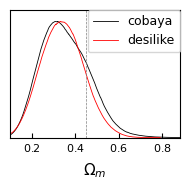

In [22]:
# To load Cobaya samples from disk
from getdist.mcsamples import loadMCSamples
samples_bao_cobaya = loadMCSamples('_tests/chains_bao_cobaya/chain', settings={'ignore_rows': 0.5}).copy(label='cobaya')

g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_cobaya, samples_bao_desilike],
                 params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

### CosmoSIS
Let's apply the static bindings to CosmoSIS.
The BAOLikelihood definition is exactly the same, we just need to generate new files with a simple CosmoSISLikelihoodGenerator call.

In [23]:
%%file _tests/bao_likelihood.py

dirname = '.'

# The same as for Cobaya!
def BAOLikelihood(cosmo='external'):
    import numpy as np
    from desilike.observables.galaxy_clustering import BAOCompressionObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    # cosmo = 'external' to tell desilike that cosmo will be provided externally
    observable1 = BAOCompressionObservable(data=[1., 1.], quantities=['qpar', 'qper'], z=0.5, cosmo=cosmo)
    observable2 = BAOCompressionObservable(data=[1.], quantities=['qiso'], z=1., cosmo=cosmo)
    likelihood = ObservablesGaussianLikelihood([observable1, observable2],
                                               covariance=np.diag([0.002, 0.002, 0.005]))
    return likelihood

if __name__ == '__main__':
    from desilike.bindings import CobayaLikelihoodGenerator, CosmoSISLikelihoodGenerator, MontePythonLikelihoodGenerator
    CobayaLikelihoodGenerator(dirname=dirname)([BAOLikelihood], kw_like={'cosmo': 'external'})
    # The only change!
    CosmoSISLikelihoodGenerator(dirname=dirname)([BAOLikelihood], kw_like={'cosmo': 'external'})
    # Let's directly generate the bindings for MontePython
    MontePythonLikelihoodGenerator(dirname=dirname)([BAOLikelihood], kw_like={'cosmo': 'external'})

Overwriting _tests/bao_likelihood.py


Let's generate the static bindings by calling the above Python script

In [24]:
%%bash
cd _tests
python bao_likelihood.py

bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by bash)


Let's take a look at the generated files:
- the likelihood module: ``BAOLikelihood.py``
- the ``*values.ini`` file containing the values / ranges of nuisance parameters (none in this case), to be copy-pasted in the input ``*values.ini`` (see below)
- the ``*priors.ini`` file containing the optional priors of nuisance parameters, to be copy-pasted in the input ``*priors.ini`` file

In [25]:
ls -la _tests/cosmosis

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 20
drwxr-xr-x 2 adematti idphp 4096 juil.  2 10:25 ./
drwxr-xr-x 7 adematti idphp 4096 juil.  2 10:25 ../
-rw-r--r-- 1 adematti idphp    7 juil.  2 10:25 BAOLikelihood_priors.ini
-rw-r--r-- 1 adematti idphp  543 juil.  2 10:25 BAOLikelihood.py
-rw-r--r-- 1 adematti idphp    7 juil.  2 10:25 BAOLikelihood_values.ini


Now let's write the config file to run inference. This is pure CosmoSIS.

In [26]:
%%file _tests/config_bao.ini

[DEFAULT]
fatal_errors = T

[runtime]
sampler = emcee

[output]
filename = _tests/chains_bao_cosmosis/chain.txt
format = text
verbosity = 0

[pipeline]
modules = consistency camb bao
values = _tests/values_bao.ini
likelihoods = BAOLikelihood  ; notice the name of the liklelihood: the same as the *.py file
quiet = T
debug = F
timing = F

[consistency]
file = ${COSMOSIS_STD_DIR}/utility/consistency/consistency_interface.py

[camb]
file = ${COSMOSIS_STD_DIR}/boltzmann/camb/camb_interface.py
mode = background
feedback = 0
nz = 901

[bao]
file = _tests/cosmosis/BAOLikelihood.py

[emcee]
walkers = 6
samples = 600
nsteps = 20

Writing _tests/config_bao.ini


The ``*values.ini`` file containing parameter values and ranges

In [27]:
%%file _tests/values_bao.ini

[cosmological_parameters]

; This is the only parameter being varied.
omega_m = 0.1 0.3 0.9
ombh2 = 0.02237
h0 = 0.6736
A_s = 2.083e-09
n_s = 0.9649
tau = 0.0544

mnu = 0.06
nnu = 3.046
num_massive_neutrinos = 1
omega_k = 0.0
w = -1.0
wa = 0.0

Writing _tests/values_bao.ini


Let's sample!

In [28]:
!cosmosis _tests/config_bao.ini

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Parameter Priors
----------------
cosmological_parameters--omega_m                ~ U(0.1, 0.9)
cosmological_parameters--ombh2                  ~ delta(0.02237)
cosmological_parameters--h0                     ~ delta(0.6736)
cosmological_parameters--a_s                    ~ delta(2.083e-09)
cosmological_parameters--n_s                    ~ delta(0.9649)
cosmological_parameters--tau                    ~ delta(0.0544)
cosmological_parameters--mnu                    ~ delta(0.06)
cosmological_parameters--nnu                    ~ delta(3.046)
cosmological_parameters--num_massive_neutrinos  ~ delta(1)
cosmological_parameters--omega_k                ~ delta(0.0)
cosmological_parameters--w                      ~ delta(-1.0)
cosmological_parameters--wa                     ~ delta(0.0)

****************************
* Running sampler 1/1: emcee
* Saving output -> _tests

LOADING CHAIN FROM FILE:  _tests/chains_bao_cosmosis/chain.txt


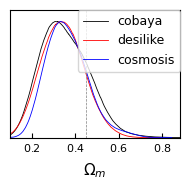

In [29]:
# To load CosmoSIS samples from disk
from cosmosis import Inifile
from cosmosis.output import input_from_options
from getdist import MCSamples

ini = Inifile('_tests/config_bao.ini')
options = dict(ini.items('output'))
options['filename'] = '_tests/chains_bao_cosmosis/chain.txt'
column_names, data = input_from_options(options)[:2]
#print(column_names)
data = data[0].T
data = data[..., data.shape[-1] // 2:]  # removing burnin
samples_bao_cosmosis = MCSamples(samples=[data[0]], weights=None, loglikes=-data[-1],
                                 names=['Omega_m'], label='cosmosis')

g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_cobaya, samples_bao_desilike, samples_bao_cosmosis],
                 params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

### MontePython

MontePython is not a Python package, so is not installed in the cosmodesi environment.

Let's install it locally! (it may take some time to download, because of the data sets).

In [30]:
%%bash
cd _tests/
git clone https://github.com/brinckmann/montepython_public.git

bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by bash)
Cloning into 'montepython_public'...
Updating files: 100% (1492/1492), done.


We write the ``.conf`` file that specifies the path to the Boltzman code Class and Planck likelihoods.

In [31]:
%%file _tests/montepython_public/default.conf

import os
path['cosmo'] = os.getenv('CLASS_STD_DIR')
path['clik'] = os.path.join(os.getenv('PLANCK_SRC_DIR'), 'code', 'plc_3.0', 'plc-3.1')

Writing _tests/montepython_public/default.conf


Let's take a look at the files previously generated by the static bindings:

- the package: ``BAOLikelihood``
- with a (mandatory) ``*.data`` file specifying the likelihood name and nuisance parameter priors
- with ``*.param`` file specifying parameter ranges, to be copy-pasted in the input ``.param`` file (see below)
- with the ``__init__.py`` file containing the likelihood definition

As required by MontePython, we copy all this to the ``montepython/likelihoods`` directory.

In [32]:
!ls -la _tests/montepython/BAOLikelihood
!cp -r _tests/montepython/BAOLikelihood _tests/montepython_public/montepython/likelihoods/

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 20
drwxr-xr-x 2 adematti idphp 4096 juil.  2 10:25 .
drwxr-xr-x 3 adematti idphp 4096 juil.  2 10:25 ..
-rw-r--r-- 1 adematti idphp   35 juil.  2 10:25 BAOLikelihood.data
-rw-r--r-- 1 adematti idphp   52 juil.  2 10:25 BAOLikelihood.param
-rw-r--r-- 1 adematti idphp  502 juil.  2 10:25 __init__.py
/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)


Now let's write the config file to run inference. This is pure MontePython.

In [33]:
%%file _tests/conf_bao.param

data.experiments = ['BAOLikelihood']

#------ Parameter list -------
# data.parameters[class name] = [mean, min, max, 1-sigma, scale, role]

# Cosmological parameters list
data.parameters['Omega_m'] = [0.3, 0.1, 0.9, 0.1, 1., 'cosmo']
# Fixed parameters
data.parameters['omega_b'] = [0.02237, 0.001, 0.1, 0., 1., 'cosmo']
data.parameters['H0'] = [67.36, 0.1, 0.9, 0., 1., 'cosmo']
data.parameters['A_s'] = [2.083e-09, 1e-09, 3e-09, 0., 1., 'cosmo']
data.parameters['n_s'] = [0.9649, 0.9, 1.0, 0., 1., 'cosmo']
data.parameters['tau_reio'] = [0.0544, 0.02, 0.1, 0., 1., 'cosmo']

# Cosmo arguments
data.cosmo_arguments['k_pivot'] = 0.05
data.cosmo_arguments['N_ur'] = 2.0328
data.cosmo_arguments['N_ncdm'] = 1
data.cosmo_arguments['m_ncdm'] = 0.06
data.cosmo_arguments['T_ncdm'] = 0.71611

#------ MCMC parameters ----
data.N = 3000
data.write_step = 5

Writing _tests/conf_bao.param


Let's sample!

In [34]:
!python _tests/montepython_public/montepython/MontePython.py run --conf _tests/montepython_public/default.conf -p _tests/conf_bao.param -o _tests/chains_bao_montepython

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
Running Monte Python v3.6.0

with CLASS v3.2.0

Testing likelihoods for:
 ->BAOLikelihood

Creating _tests/chains_bao_montepython/2023-07-02_3000__1.txt


Deduced starting covariance matrix:

['Omega_m']
[[0.01]]
Update routine is enabled with value 50 (recommended: 50)
This number is rescaled by cycle length 1 (N_slow + f_fast * N_fast) to 50

#  -LogLkl	Omega_m         
 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
1  0.474813	4.139400e-01	
6  0.0393078	3.415106e-01	
1  0.0795065	3.530712e-01	
1  0.299953	3.918899e-01	
1  0.28913	3.903726e-01	
1  1.88732	5.363267e-01	
3  1.75998	5.269886e-01	
1  0.353307	2.459891e-01	
1  0.00723461	3.0

4  0.0595406	3.477901e-01	
1  0.382878	2.434126e-01	
5  1.32151	1.918790e-01	
1  0.0442547	2.892916e-01	
1  1.2614	1.942512e-01	
3  1.78489	5.288293e-01	
1  0.0753482	3.520266e-01	
2  0.649254	2.242833e-01	
1  0.309715	3.932392e-01	
2  1.03558	4.692578e-01	
1  0.0923101	3.561410e-01	
4  0.138947	3.659642e-01	
1  0.16861	2.660613e-01	
2  0.350048	2.462807e-01	
1  0.209048	2.608618e-01	
3  0.0570426	2.858992e-01	
--> Scanning file _tests/chains_bao_montepython/2023-07-02_3000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 91 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.014294 	for  Omega_m
--> Not computing covariance matrix
1  1.3972	4.992421e-01	
1  0.00125824	3.198919e-01	
4  0.4439	4.103141e-01	
2  0.262001	3.864621e-01	
6  0.0181291	3.329285e-01	
1  0.504431	4.173286e-01	
4  0.839287	4.515325e-01	
1  0.542182	2.312567e-01	
2  0.0980431	3.574525e-01	
2  2.72639	5.943039e-01	
3  0.26165	3.864104

1  0.776958	4.456107e-01	
5  0.37336	4.016460e-01	
1  1.19235	4.826120e-01	
1  1.09345	4.742592e-01	
1  5.53162	7.671793e-01	
1  0.405279	4.056423e-01	
1  0.156564	2.677443e-01	
7  0.224149	3.807091e-01	
2  0.198556	3.765828e-01	
1  0.00469089	3.241871e-01	
1  0.240375	3.832218e-01	
2  4.77555	7.222868e-01	
1  0.327396	3.956401e-01	
5  0.00412346	3.236284e-01	
2  1.44871	5.033016e-01	
2  0.424143	4.079450e-01	
3  3.81524	6.638524e-01	
5  0.127442	3.636981e-01	
6  0.617053	4.295724e-01	
--> Scanning file _tests/chains_bao_montepython/2023-07-02_3000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 193 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.005483 	for  Omega_m
--> Not computing covariance matrix
6  0.653698	4.333708e-01	
3  0.752894	4.432794e-01	
1  4.91985	7.309147e-01	
1  4.5912	7.112135e-01	
1  4.42611	7.012458e-01	
1  4.23959	6.899186e-01	
1  4.8337	7.257677e-01	
2  2.13213	5.538138e-01	
5

3  0.231344	3.818326e-01	
1  0.28055	2.529275e-01	
1  0.63823	4.317774e-01	
2  0.180386	2.644803e-01	
1  0.0428224	2.897027e-01	
2  0.0918531	2.783555e-01	
4  0.16646	3.710707e-01	
4  0.604514	2.271033e-01	
3  0.975859	4.639967e-01	
3  0.488541	4.155205e-01	
1  0.432385	2.393526e-01	
1  0.0820321	2.802975e-01	
1  0.0819229	3.536668e-01	
4  0.0080921	3.039829e-01	
1  5.99784e-05	3.163163e-01	
1  0.000710996	3.119333e-01	
2  0.0752792	2.817075e-01	
5  0.637574	4.317095e-01	
1  0.444651	4.104033e-01	
2  0.574466	2.290709e-01	
1  0.427594	4.083617e-01	
3  0.0493273	3.447707e-01	
3  0.0238615	2.960422e-01	
--> Scanning file _tests/chains_bao_montepython/2023-07-02_3000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 296 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.012596 	for  Omega_m
--> Not computing covariance matrix
1  0.13082	3.643725e-01	
3  0.0834025	2.800192e-01	
3  2.02929	5.465362e-01	
4  0.7

6  0.0198201	3.337493e-01	
1  0.545607	4.219147e-01	
2  1.67666	1.791837e-01	
5  0.0735498	3.515666e-01	
2  2.37094	5.703774e-01	
1  0.0155316	2.996954e-01	
2  1.05048	4.705541e-01	
1  0.0112235	3.020000e-01	
2  0.754084	2.181221e-01	
1  0.104255	3.588352e-01	
2  0.159515	2.673256e-01	
1  0.44587	4.105481e-01	
3  0.269978	3.876287e-01	
5  0.554114	4.228454e-01	
2  0.562443	4.237514e-01	
1  0.0668302	3.498007e-01	
2  0.0173124	3.325190e-01	
1  0.280876	3.891996e-01	
1  0.126283	3.634649e-01	
1  0.748312	2.184466e-01	
--> Scanning file _tests/chains_bao_montepython/2023-07-02_3000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 391 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.002874 	for  Omega_m
--> Not computing covariance matrix
8  0.731079	4.411429e-01	
1  0.269192	2.541025e-01	
1  0.503442	4.172167e-01	
3  0.787248	4.465996e-01	
2  0.687458	2.219697e-01	
3  0.670163	2.230068e-01	
2  0.0857064	3

2  0.413021	2.409057e-01	
2  0.895893	4.567775e-01	
1  1.09501	4.743933e-01	
5  0.12251	2.729379e-01	
3  0.101596	2.765382e-01	
7  0.679611	4.360092e-01	
2  0.0357243	3.402516e-01	
2  0.925251	2.091394e-01	
1  0.0187263	3.332224e-01	
2  2.90194	6.058532e-01	
1  3.49017	6.435509e-01	
2  4.66406	7.155971e-01	
1  4.20397	6.877473e-01	
1  2.1506	5.551110e-01	
3  1.8069	5.304500e-01	
7  1.64515	1.802302e-01	
1  1.42441	5.013925e-01	
1  0.813194	4.490732e-01	
2  0.0775374	3.525797e-01	
--> Scanning file _tests/chains_bao_montepython/2023-07-02_3000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 491 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.004434 	for  Omega_m
--> Not computing covariance matrix
2  1.4476	5.032147e-01	
1  1.81098	5.307495e-01	
3  0.140515	3.662665e-01	
1  0.205218	2.613282e-01	
4  0.589396	4.266495e-01	
1  1.42799	5.016742e-01	
6  0.683212	4.363730e-01	
3  0.0685717	3.502659e-01	
2 

1  4.02895	6.770359e-01	
3  7.03578	8.549145e-01	
1  0.19679	3.762899e-01	
2  0.836012	2.136756e-01	
1  0.0287384	3.376125e-01	
1  0.0102042	3.284619e-01	
2  0.123004	3.627997e-01	
5  0.0130527	3.009737e-01	
4  0.0400986	2.905053e-01	
3  0.0707835	2.826846e-01	
1  1.37445	4.974348e-01	
1  0.781505	4.460483e-01	
1  1.49503	5.069149e-01	
1  2.04118	5.473820e-01	
4  0.0446105	2.891906e-01	
--> Scanning file _tests/chains_bao_montepython/2023-07-02_3000__1.txt: Removed 0 points of burn-in, and first 50 percent, keep 586 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.004496 	for  Omega_m
--> Not computing covariance matrix
6  0.213286	3.789837e-01	
1  0.150674	3.681904e-01	
1  1.77324	5.279693e-01	
2  0.304324	3.924961e-01	
1  0.697734	4.378327e-01	
1  0.740844	2.188690e-01	
1  1.47314	1.862023e-01	

#  3000 steps done, acceptance rate: 0.393
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Cl

[000600.65] [0/1] 07-02 10:32  root                      WARNING  outlier fraction 0.09491525423728814 


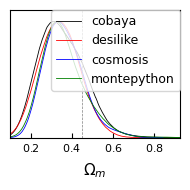

In [35]:
# To load MontePython samples from disk
from datetime import date
from getdist.mcsamples import loadMCSamples
samples_bao_montepython = loadMCSamples('_tests/chains_bao_montepython/{}_3000_'.format(date.today()),
                                    settings={'ignore_rows': 0.5}).copy(label='montepython')

g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_cobaya, samples_bao_desilike, samples_bao_cosmosis, samples_bao_montepython],
                 params=['Omega_m'], markers={'Omega_m': cosmo['Omega_m']})

## Interlude: forecasts
So far we have input totally ad-hoc covariance matrices.
Yet, one can use desilike to produce forecasts.

In [36]:
from desilike.observables.galaxy_clustering import CutskyFootprint
from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, SimpleBAOWigglesTracerPowerSpectrumMultipoles
from desilike.likelihoods.galaxy_clustering import SNWeightedPowerSpectrumLikelihood
from desilike import Fisher

cosmo = DESI()

# Object holding the area and n(z) in (Mpc/h)^(-3)
footprint = CutskyFootprint(area=14000., zrange=np.linspace(0.8, 1.2, 10), nbar=np.full(10, 1e-4), cosmo=cosmo)
z = footprint.zavg

fo = cosmo.get_fourier()
s, s0 = fo.sigma8_z(z, of='delta_cb'), fo.sigma8_z(0., of='delta_cb')
b1 = 0.8 / (s / s0)  # prescription for linear bias
r = 0.5  # reconstruction factor
sigmaper = 9.4 * (s / 0.9)
f = fo.sigma8_z(z, of='theta_cb') / s
params = {'b1': b1, 'sigmapar': r * (1. + f) * sigmaper, 'sigmaper': r * sigmaper}  # fiducial model parameters
covariance_params = {'b1': b1, 'sigmapar': 0., 'sigmaper': 0.}  # fiducial covariance parameters (simple Kaiser model)
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qparqper')
theory = SimpleBAOWigglesTracerPowerSpectrumMultipoles(template=template) # this BAO model shifts wiggles only
for param in theory.init.params.select(basename='al*'):
    param.update(value=0., fixed=True)  # fixing broadband parameters (the wiggles only shift)

# For klim=(0.01, 0.5), we only use the information from the BAO feature in the power spectrum
likelihood = SNWeightedPowerSpectrumLikelihood(theories=theory, data=params, covariance=covariance_params,
                                               footprints=footprint, klim=(0.01, 0.5))
fisher = Fisher(likelihood)  # initializing Fisher
fisher_bao = fisher(**params).view(params=['qpar', 'qper'])  # computing Fisher prediction at fiducial parameters

[000601.78] [0/1] 07-02 10:32  Differentiation           INFO     Varied parameters: ['qpar', 'qper', 'b1', 'sigmas'].
[000601.83] [0/1] 07-02 10:32  Differentiation           INFO     Varied parameters: ['qpar', 'qper', 'b1', 'sigmas'].
[000602.13] [0/1] 07-02 10:32  Differentiation           INFO     Using finite-differentiation for parameter qpar.
[000602.20] [0/1] 07-02 10:32  Differentiation           INFO     Using finite-differentiation for parameter qper.
[000602.59] [0/1] 07-02 10:32  Differentiation           INFO     Using auto-differentiation for parameter b1.
[000602.80] [0/1] 07-02 10:32  Differentiation           INFO     Using auto-differentiation for parameter sigmas.
[000602.80] [0/1] 07-02 10:32  Differentiation           INFO     qpar grid is [0.998 1.    1.002].
[000602.80] [0/1] 07-02 10:32  Differentiation           INFO     qper grid is [0.998 1.    1.002].


In [37]:
print(fisher_bao.to_stats(tablefmt='pretty'))

+-----+---------+
| FoM | 3601.51 |
+-----+---------+
+------+-------+-------+
|      | qpar  | qper  |
+------+-------+-------+
| mean | 1.000 | 1.000 |
| std  | 0.019 | 0.016 |
+------+-------+-------+
+------+---------+---------+
|      |  qpar   |  qper   |
+------+---------+---------+
| qpar | 3.6e-4  | -1.3e-4 |
| qper | -1.3e-4 | 2.6e-4  |
+------+---------+---------+


In [38]:
# You can directly pass Fisher to BAOCompressionObservable
observable = BAOCompressionObservable(data=fisher_bao, covariance=fisher_bao,
                                      quantities=['qpar', 'qper'], z=z)
# Or...
quantities = ['qpar', 'qper']
observable = BAOCompressionObservable(data=fisher_bao.mean(quantities), covariance=fisher_bao.covariance(quantities),
                                      quantities=quantities, z=z)

This observable can be passed to a likelihood, just as previously, to further run cosmological inference.

## ShapeFit likelihood
ShapeFit compressed likelihoods are similar to BAO compressed likelihoods.

In [39]:
from desilike.observables.galaxy_clustering import ShapeFitCompressionObservable

observable = ShapeFitCompressionObservable(data=[1., 1., 1., 0.], covariance=np.diag([0.01, 0.01, 0.01, 0.01]),
                                           quantities=['qpar', 'qper', 'df', 'dm'], z=1.)
# Let's define the likelihood from this observable
likelihood = ObservablesGaussianLikelihood(observable)

This observable can be passed to a likelihood, just as previously, to further run cosmological inference.

# Full likelihoods

Let's write full likelihoods, i.e. with nuisance parameters (bias, stochastic and counterterms not marginalized out).

In [40]:
%%file _tests/fs_likelihood.py
dirname = '_tests'

def FSLikelihood(cosmo='external'):
    from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles, LPTVelocileptorsTracerPowerSpectrumMultipoles
    from desilike.observables.galaxy_clustering import BoxFootprint, ObservablesCovarianceMatrix, TracerPowerSpectrumMultipolesObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    # Let's define the template = linear power spectrum
    template = DirectPowerSpectrumTemplate(z=1.)
    # For the sake of running time, let us consider a simple linear Kaiser model
    theory = KaiserTracerPowerSpectrumMultipoles(template=template)
    b1 = 0.5
    footprint = BoxFootprint(volume=5e9, nbar=1e-4)  # box with volume of 5 (Gpc/h)^3 and density of 1e-4 (h/Mpc)^3
    observable = TracerPowerSpectrumMultipolesObservable(\
                 data={'b1': b1},  # path to data, *pypower* file, array, or dictionary of parameters
                 covariance=None,  # path to mocks, array (covariance matrix), or None
                 klim={0: [0.01, 0.2, 0.01], 2: [0.01, 0.2, 0.01]},  # k-limits, between 0.01 and 0.2 h/Mpc with 0.005 h/Mpc
                 theory=theory)  # previously defined theory
    covariance = ObservablesCovarianceMatrix(observables=[observable], footprints=[footprint])
    cov = covariance(b1=b1)  # evaluate covariance matrix at this parameter
    likelihood = ObservablesGaussianLikelihood(observables=observable, covariance=cov)
    observable.init.update(data=observable.flatdata)  # fix the data vector
    template.init.update(cosmo=cosmo)  # let's pass the cosmology
    return likelihood

if __name__ == '__main__':
    from desilike.bindings import CobayaLikelihoodGenerator, CosmoSISLikelihoodGenerator, MontePythonLikelihoodGenerator
    CobayaLikelihoodGenerator(dirname=dirname)([FSLikelihood], kw_like={'cosmo': 'external'})
    CosmoSISLikelihoodGenerator(dirname=dirname)([FSLikelihood], kw_like={'cosmo': 'external'})
    MontePythonLikelihoodGenerator(dirname=dirname)([FSLikelihood], kw_like={'cosmo': 'external'})

Writing _tests/fs_likelihood.py


Let's generate the static bindings by calling the above Python script

In [41]:
!python _tests/fs_likelihood.py

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/numpy/lib/polynomial.py:1337: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [42]:
!ls -la _tests/cobaya

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 32
drwxr-xr-x  3 adematti idphp 4096 juil.  2 10:32 .
drwxr-xr-x 10 adematti idphp 4096 juil.  2 10:32 ..
-rw-r--r--  1 adematti idphp  477 juil.  2 10:25 bao_likelihood.py
-rw-r--r--  1 adematti idphp   31 juil.  2 10:25 BAOLikelihood.yaml
-rw-r--r--  1 adematti idphp  471 juil.  2 10:32 fs_likelihood.py
-rw-r--r--  1 adematti idphp  411 juil.  2 10:32 FSLikelihood.yaml
-rw-r--r--  1 adematti idphp   59 juil.  2 10:32 __init__.py
drwxr-xr-x  2 adematti idphp 4096 juil.  2 10:24 __pycache__


In [43]:
!ls -la _tests/cosmosis

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 36
drwxr-xr-x  3 adematti idphp 4096 juil.  2 10:32 .
drwxr-xr-x 10 adematti idphp 4096 juil.  2 10:32 ..
-rw-r--r--  1 adematti idphp    7 juil.  2 10:25 BAOLikelihood_priors.ini
-rw-r--r--  1 adematti idphp  543 juil.  2 10:25 BAOLikelihood.py
-rw-r--r--  1 adematti idphp    7 juil.  2 10:25 BAOLikelihood_values.ini
-rw-r--r--  1 adematti idphp  110 juil.  2 10:32 FSLikelihood_priors.ini
-rw-r--r--  1 adematti idphp  536 juil.  2 10:32 FSLikelihood.py
-rw-r--r--  1 adematti idphp  101 juil.  2 10:32 FSLikelihood_values.ini
drwxr-xr-x  2 adematti idphp 4096 juil.  2 10:25 __pycache__


In [63]:
!ls -la _tests/montepython

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 16
drwxr-xr-x  4 adematti idphp 4096 juil.  2 10:32 .
drwxr-xr-x 13 adematti idphp 4096 juil.  2 10:39 ..
drwxr-xr-x  2 adematti idphp 4096 juil.  2 10:25 BAOLikelihood
drwxr-xr-x  2 adematti idphp 4096 juil.  2 10:32 FSLikelihood


Yet, the above likelihood will take a significant time to evaluate, especially for a 1-loop EFT model.
Let's emulate the theory.

In [44]:
# %load _tests/fs_likelihood.py

def FSLikelihood(cosmo='external'):
    from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles, LPTVelocileptorsTracerPowerSpectrumMultipoles
    from desilike.observables.galaxy_clustering import BoxFootprint, ObservablesCovarianceMatrix, TracerPowerSpectrumMultipolesObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    # Let's define the template
    template = DirectPowerSpectrumTemplate(z=1.)
    # For the sake of running time, let us consider a simple linear Kaiser model
    theory = KaiserTracerPowerSpectrumMultipoles(template=template)  # LPTVelocileptorsTracerPowerSpectrumMultipoles(template=template)
    b1 = 0.5
    footprint = BoxFootprint(volume=5e9, nbar=1e-4)  # box with volume of 5 (Gpc/h)^3 and density of 1e-4 (h/Mpc)^3
    observable = TracerPowerSpectrumMultipolesObservable(\
                 data={'b1': b1},  # path to data, *pypower* file, array, or dictionary of parameters
                 covariance=None,  # path to mocks, array (covariance matrix), or None
                 klim={0: [0.01, 0.2, 0.01], 2: [0.01, 0.2, 0.01]},  # k-limits, between 0.01 and 0.2 h/Mpc with 0.005 h/Mpc
                 theory=theory)  # previously defined theory
    covariance = ObservablesCovarianceMatrix(observables=[observable], footprints=[footprint])
    cov = covariance(b1=b1)   # evaluate covariance matrix at this parameter
    likelihood = ObservablesGaussianLikelihood(observables=observable, covariance=cov)
    observable.init.update(data=observable.flatdata)
    template.init.update(cosmo=cosmo)
    return likelihood


In [45]:
likelihood = FSLikelihood(cosmo=None)
theory = likelihood.observables[0].wmatrix.theory

from desilike.emulators import Emulator, TaylorEmulatorEngine, EmulatedCalculator

emulator = Emulator(theory.pt,
                    engine=TaylorEmulatorEngine(order={'*': 1}))
emulator.set_samples()
emulator.fit()  # set Taylor expansion

# Emulator can be saved with:
emulator.save('_tests/emulator.npy')
np.save('_tests/data.npy', likelihood.flatdata)
np.save('_tests/covariance.npy', likelihood.covariance)

theory.init.update(pt=emulator)

[000626.19] [0/1] 07-02 10:32  Emulator                  INFO     Varied parameters: ['h', 'Omega_m', 'omega_b', 'logA'].
[000626.19] [0/1] 07-02 10:32  Emulator                  INFO     Found varying ['pk_dd', 'pk_dt', 'pk_tt', 'pk11'] and fixed ['k', 'z', 'ells', 'names'] outputs.
[000626.71] [0/1] 07-02 10:32  Differentiation           INFO     Varied parameters: ['h', 'Omega_m', 'omega_b', 'logA'].
[000629.76] [0/1] 07-02 10:33  Differentiation           INFO     Using finite-differentiation for parameter h.
[000630.37] [0/1] 07-02 10:33  Differentiation           INFO     Using finite-differentiation for parameter Omega_m.
[000630.91] [0/1] 07-02 10:33  Differentiation           INFO     Using finite-differentiation for parameter omega_b.
[000631.44] [0/1] 07-02 10:33  Differentiation           INFO     Using finite-differentiation for parameter logA.
[000631.44] [0/1] 07-02 10:33  Differentiation           INFO     h grid is [0.6706 0.6736 0.6766].
[000631.44] [0/1] 07-02 10:33 

Now we can write our likelihood, using the emulated PT!

In [46]:
%%file _tests/fs_likelihood.py
dirname = '_tests'

def FSLikelihood():
    import os
    import numpy as np
    from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate
    from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
    from desilike.likelihoods import ObservablesGaussianLikelihood
    from desilike.emulators import EmulatedCalculator
    # Let's define the template
    template = DirectPowerSpectrumTemplate(z=1.)
    # For the sake of running time, let us consider a simple linear Kaiser model
    theory = KaiserTracerPowerSpectrumMultipoles(template=template, pt=EmulatedCalculator.load(os.path.join(dirname, 'emulator.npy')))
    observable = TracerPowerSpectrumMultipolesObservable(\
                 data=np.load(os.path.join(dirname, 'data.npy')),  # path to data, *pypower* file, array, or dictionary of parameters
                 klim={0: [0.01, 0.2, 0.01], 2: [0.01, 0.2, 0.01]},  # k-limits, between 0.01 and 0.2 h/Mpc with 0.005 h/Mpc
                 theory=theory,
                 covariance=np.load(os.path.join(dirname, 'covariance.npy')))
    likelihood = ObservablesGaussianLikelihood(observables=observable)
    likelihood.all_params['sn0'].update(derived='.auto')
    return likelihood

if __name__ == '__main__':
    from desilike.bindings import CobayaLikelihoodGenerator, CosmoSISLikelihoodGenerator, MontePythonLikelihoodGenerator
    CobayaLikelihoodGenerator(dirname=dirname)(FSLikelihood, kw_like={})
    CosmoSISLikelihoodGenerator(dirname=dirname)(FSLikelihood, kw_like={})
    MontePythonLikelihoodGenerator(dirname=dirname)(FSLikelihood, kw_like={})

Overwriting _tests/fs_likelihood.py


Let's generate the static bindings by calling the above Python script

In [47]:
!python _tests/fs_likelihood.py

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)


### Cobaya

In [48]:
%%file _tests/config_bao_fs.yaml

theory:
  classy:
    extra_args:
      N_ncdm: 1
      N_ur: 2.0328

likelihood:
  bao_likelihood.BAOLikelihood:
      python_path: _tests/cobaya
  fs_likelihood.FSLikelihood:
      python_path: _tests/cobaya

params:
  Omega_m:
    prior:
      min: 0.1
      max: 1.
    ref:
      dist: norm
      loc: 0.3
      scale: 0.01
    latex: \Omega_{m}
  omega_b: 0.02237
  H0: 67.36
  As: 2.083e-09
  n_s: 0.9649
  tau_reio: 0.0544

sampler:
  mcmc:
    Rminus1_stop: 0.05

debug: True

output: _tests/chains_bao_fs_cobaya/chain

Writing _tests/config_bao_fs.yaml


Let's sample!

In [49]:
!cobaya-run _tests/config_bao_fs.yaml

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
 2023-07-02 10:33:11,778 [output] Creating output folder '_tests/chains_bao_fs_cobaya'
 2023-07-02 10:33:11,778 [output] Output to be read-from/written-into folder '_tests/chains_bao_fs_cobaya', with prefix 'chain'
 2023-07-02 10:33:14,016 [root] Initializing MLIR with module: _mlirRegisterEverything
 2023-07-02 10:33:14,016 [root] Registering dialects from initializer <module 'jaxlib.mlir._mlir_libs._mlirRegisterEverything' from '/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs/_mlirRegisterEverything.so'>
 2023-07-02 10:33:14,171 [absl] Finished tracing + transforming prim_fun for jit in 0.0002155303955078125 sec
 2023-07-02 10:33:14,171 [absl] Initializing backend 'interpreter'
 2023-07-02 10:33:14,172 [absl] Backend 'interpreter' initialized
 2023-07-02 10:33:14,172 [absl] Initializing backend 'cpu'
 2023-07-02 10:3

 2023-07-02 10:33:15,065 [absl] Finished XLA compilation of <lambda> in 0.007318973541259766 sec
 2023-07-02 10:33:15,067 [absl] Finished tracing + transforming dot for jit in 0.00047278404235839844 sec
 2023-07-02 10:33:15,067 [absl] Compiling dot (140344366077408 for args (ShapedArray(float64[3]), ShapedArray(float64[3,3])).
 2023-07-02 10:33:15,081 [absl] Finished XLA compilation of dot in 0.010323524475097656 sec
 2023-07-02 10:33:15,082 [absl] Finished tracing + transforming dot for jit in 0.0004627704620361328 sec
 2023-07-02 10:33:15,082 [absl] Compiling dot (140344366077168 for args (ShapedArray(float64[3]), ShapedArray(float64[3])).
 2023-07-02 10:33:15,093 [absl] Finished XLA compilation of dot in 0.008072137832641602 sec
 2023-07-02 10:33:15,094 [absl] Finished tracing + transforming fn for jit in 0.00041294097900390625 sec
 2023-07-02 10:33:15,095 [absl] Compiling fn (140344366077008 for args (ShapedArray(float64[], weak_type=True), ShapedArray(float64[])).
 2023-07-02 10:3

 2023-07-02 10:33:15,370 [absl] Finished XLA compilation of add in 0.006165981292724609 sec
 2023-07-02 10:33:15,371 [absl] Finished tracing + transforming prim_fun for jit in 0.00022459030151367188 sec
 2023-07-02 10:33:15,371 [absl] Compiling prim_fun (140344365712384 for args ().
 2023-07-02 10:33:15,379 [absl] Finished XLA compilation of iota in 0.0053822994232177734 sec
 2023-07-02 10:33:15,380 [absl] Finished tracing + transforming prim_fun for jit in 0.0002541542053222656 sec
 2023-07-02 10:33:15,380 [absl] Compiling prim_fun (140344365712784 for args (ShapedArray(int32[1,1]), ShapedArray(int32[1,1])).
 2023-07-02 10:33:15,389 [absl] Finished XLA compilation of eq in 0.005829811096191406 sec
 2023-07-02 10:33:15,390 [absl] Finished tracing + transforming prim_fun for jit in 0.00021886825561523438 sec
 2023-07-02 10:33:15,390 [absl] Compiling prim_fun (140344365712224 for args (ShapedArray(bool[1,1]),).
 2023-07-02 10:33:15,398 [absl] Finished XLA compilation of convert_element_t

 2023-07-02 10:33:15,743 [classy] Average evaluation time: 0.0437982 s
 2023-07-02 10:33:15,743 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.97024650096066}
 2023-07-02 10:33:15,743 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:15,745 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.012527
 2023-07-02 10:33:15,745 [bao_likelihood.baolikelihood] Average evaluation time: 0.00174019 s
 2023-07-02 10:33:15,745 [fs_likelihood.fslikelihood] Got parameters {'b1': 1.5827435664776845, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:15,745 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:15,765 [fs_likelihood.fslikelihood] Computed log-likelihood = -7095.09
 2023-07-02 10:33:15,765 [fs_likelihood.fslikelihood] Average evaluation time: 0.0199828 s
 2023-07-02 10:33:15,765 [model] Computed derived parameters: {}
 2023-07-02 10:33:15,766 [prior] Evaluating prior at array([0.31633011, 1.54137877])
 2023-07-02 10:33:15,766 [prior]

 2023-07-02 10:33:16,026 [fs_likelihood.fslikelihood] Computed log-likelihood = -301.064
 2023-07-02 10:33:16,026 [model] Computed derived parameters: {}
 2023-07-02 10:33:16,026 [mcmc] New sample, #2: 
   Omega_m:0.3015968, b1:1.179358
 2023-07-02 10:33:16,026 [model] Posterior to be computed for parameters {'Omega_m': 0.309038032519737, 'b1': 0.8182528959083948}
 2023-07-02 10:33:16,026 [prior] Evaluating prior at array([0.30903803, 0.8182529 ])
 2023-07-02 10:33:16,026 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:16,027 [model] Got input parameters: {'Omega_m': 0.309038032519737, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.8182528959083948, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:16,027 [classy] Got parameters {'Omega_m': 0.309038032519737, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:16,027 [classy] Computing new state
 2023-07-02 10:33:

 2023-07-02 10:33:16,316 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.09038791501067}
 2023-07-02 10:33:16,316 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:16,317 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0616535
 2023-07-02 10:33:16,317 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.8182528959083948, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:16,317 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:16,338 [fs_likelihood.fslikelihood] Computed log-likelihood = -225.118
 2023-07-02 10:33:16,338 [model] Computed derived parameters: {}
 2023-07-02 10:33:16,338 [model] Posterior to be computed for parameters {'Omega_m': 0.2726188687271508, 'b1': 0.9589805399331686}
 2023-07-02 10:33:16,338 [prior] Evaluating prior at array([0.27261887, 0.95898054])
 2023-07-02 10:33:16,338 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:16,338 [model] Got input parameters: {'Omega_m': 0.2726188

 2023-07-02 10:33:16,575 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.9024831105214}
 2023-07-02 10:33:16,575 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:16,576 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0902643
 2023-07-02 10:33:16,576 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.8182528959083948, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:16,576 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:16,596 [fs_likelihood.fslikelihood] Computed log-likelihood = -206.005
 2023-07-02 10:33:16,596 [model] Computed derived parameters: {}
 2023-07-02 10:33:16,597 [model] Posterior to be computed for parameters {'Omega_m': 0.2726188687271508, 'b1': 0.944089927588688}
 2023-07-02 10:33:16,597 [prior] Evaluating prior at array([0.27261887, 0.94408993])
 2023-07-02 10:33:16,597 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:16,597 [model] Got input parameters: {'Omega_m': 0.272618868

 2023-07-02 10:33:16,836 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.186296
 2023-07-02 10:33:16,836 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.8182528959083948, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:16,836 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:16,857 [fs_likelihood.fslikelihood] Computed log-likelihood = -168.577
 2023-07-02 10:33:16,857 [model] Computed derived parameters: {}
 2023-07-02 10:33:16,857 [mcmc] New sample, #6: 
   Omega_m:0.2622584, b1:0.8182529
 2023-07-02 10:33:16,857 [model] Posterior to be computed for parameters {'Omega_m': 0.2609899719629662, 'b1': 1.67375319713257}
 2023-07-02 10:33:16,857 [prior] Evaluating prior at array([0.26098997, 1.6737532 ])
 2023-07-02 10:33:16,857 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:16,857 [model] Got input parameters: {'Omega_m': 0.2609899719629662, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 

 2023-07-02 10:33:17,098 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 152.40631930126844}
 2023-07-02 10:33:17,098 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:17,099 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.110714
 2023-07-02 10:33:17,099 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.8182528959083948, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:17,099 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:17,120 [fs_likelihood.fslikelihood] Computed log-likelihood = -195.409
 2023-07-02 10:33:17,120 [model] Computed derived parameters: {}
 2023-07-02 10:33:17,120 [model] Posterior to be computed for parameters {'Omega_m': 0.25977404455312525, 'b1': -0.4338354439874048}
 2023-07-02 10:33:17,120 [prior] Evaluating prior at array([ 0.25977404, -0.43383544])
 2023-07-02 10:33:17,120 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:33:17,121 [model] Posterior to be computed for parameters {'Omega_m': 0.2

 2023-07-02 10:33:17,437 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 152.97867406055138}
 2023-07-02 10:33:17,437 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:17,438 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.136443
 2023-07-02 10:33:17,439 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.600728251405974, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:17,439 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:17,459 [fs_likelihood.fslikelihood] Computed log-likelihood = -12.9418
 2023-07-02 10:33:17,459 [model] Computed derived parameters: {}
 2023-07-02 10:33:17,459 [mcmc] New sample, #12: 
   Omega_m:0.2432401, b1:0.6007283
 2023-07-02 10:33:17,460 [model] Posterior to be computed for parameters {'Omega_m': 0.26799843593273476, 'b1': 0.21654010019951703}
 2023-07-02 10:33:17,460 [prior] Evaluating prior at array([0.26799844, 0.2165401 ])
 2023-07-02 10:33:17,460 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:33:17,717 [fs_likelihood.fslikelihood] Computed log-likelihood = -1533.3
 2023-07-02 10:33:17,717 [model] Computed derived parameters: {}
 2023-07-02 10:33:17,718 [model] Posterior to be computed for parameters {'Omega_m': 0.28501101895354913, 'b1': 0.600728251405974}
 2023-07-02 10:33:17,718 [prior] Evaluating prior at array([0.28501102, 0.60072825])
 2023-07-02 10:33:17,718 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:17,718 [model] Got input parameters: {'Omega_m': 0.28501101895354913, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.600728251405974, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:17,718 [classy] Got parameters {'Omega_m': 0.28501101895354913, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:17,718 [classy] Computing new state
 2023-07-02 10:33:17,718 [classy] Setting parameters: {'Omega_m': 0.28501101895354913, 'omega_b': 

 2023-07-02 10:33:18,020 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 152.43395664695288}
 2023-07-02 10:33:18,020 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:18,022 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.111896
 2023-07-02 10:33:18,022 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.600728251405974, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:18,022 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:18,041 [fs_likelihood.fslikelihood] Computed log-likelihood = -10.9811
 2023-07-02 10:33:18,041 [model] Computed derived parameters: {}
 2023-07-02 10:33:18,042 [model] Posterior to be computed for parameters {'Omega_m': 0.2800024670833354, 'b1': 1.6541951931372925}
 2023-07-02 10:33:18,042 [prior] Evaluating prior at array([0.28000247, 1.65419519])
 2023-07-02 10:33:18,042 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:18,042 [model] Got input parameters: {'Omega_m': 0.280002467

 2023-07-02 10:33:18,280 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 152.4645612571393}
 2023-07-02 10:33:18,280 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:18,282 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.113212
 2023-07-02 10:33:18,282 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.600728251405974, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:18,282 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:18,301 [fs_likelihood.fslikelihood] Computed log-likelihood = -11.0763
 2023-07-02 10:33:18,301 [model] Computed derived parameters: {}
 2023-07-02 10:33:18,301 [model] Posterior to be computed for parameters {'Omega_m': 0.2800024670833354, 'b1': 1.4057531596575807}
 2023-07-02 10:33:18,301 [prior] Evaluating prior at array([0.28000247, 1.40575316])
 2023-07-02 10:33:18,302 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:18,302 [model] Got input parameters: {'Omega_m': 0.2800024670

 2023-07-02 10:33:18,538 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.20755764461194}
 2023-07-02 10:33:18,538 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:18,539 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0654488
 2023-07-02 10:33:18,540 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5641542472169249, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:18,540 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:18,559 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.60338
 2023-07-02 10:33:18,559 [model] Computed derived parameters: {}
 2023-07-02 10:33:18,559 [mcmc] New sample, #17: 
   Omega_m:0.2800025, b1:0.5641542
 2023-07-02 10:33:18,559 [model] Posterior to be computed for parameters {'Omega_m': 0.28115025895647344, 'b1': -2.012416078758141}
 2023-07-02 10:33:18,559 [prior] Evaluating prior at array([ 0.28115026, -2.01241608])
 2023-07-02 10:33:18,559 [prior] Got logpriors (internal) = -inf
 20

 2023-07-02 10:33:18,843 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.24063190904653}
 2023-07-02 10:33:18,843 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:18,845 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0167196
 2023-07-02 10:33:18,845 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5641542472169249, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:18,845 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:18,865 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.6799
 2023-07-02 10:33:18,865 [model] Computed derived parameters: {}
 2023-07-02 10:33:18,865 [mcmc] New sample, #19: 
   Omega_m:0.290638, b1:0.5641542
 2023-07-02 10:33:18,865 [model] Posterior to be computed for parameters {'Omega_m': 0.2964020393345352, 'b1': 0.39815527679972185}
 2023-07-02 10:33:18,865 [prior] Evaluating prior at array([0.29640204, 0.39815528])
 2023-07-02 10:33:18,865 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:33:19,102 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.96484413873634}
 2023-07-02 10:33:19,102 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:19,103 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0309436
 2023-07-02 10:33:19,103 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5641542472169249, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:19,103 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:19,125 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.85076
 2023-07-02 10:33:19,125 [model] Computed derived parameters: {}
 2023-07-02 10:33:19,125 [mcmc] New sample, #21: 
   Omega_m:0.2939256, b1:0.5641542
 2023-07-02 10:33:19,125 [model] Posterior to be computed for parameters {'Omega_m': 0.2907050934637481, 'b1': -0.9116768543470722}
 2023-07-02 10:33:19,125 [prior] Evaluating prior at array([ 0.29070509, -0.91167685])
 2023-07-02 10:33:19,126 [prior] Got logpriors (internal) = -inf
 20

 2023-07-02 10:33:19,391 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.43924136186516}
 2023-07-02 10:33:19,391 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:19,392 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0201871
 2023-07-02 10:33:19,392 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5641542472169249, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:19,392 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:19,412 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.61732
 2023-07-02 10:33:19,413 [model] Computed derived parameters: {}
 2023-07-02 10:33:19,413 [mcmc] New sample, #23: 
   Omega_m:0.2924213, b1:0.5641542
 2023-07-02 10:33:19,413 [model] Posterior to be computed for parameters {'Omega_m': 0.2948301460839422, 'b1': -0.9085892166087045}
 2023-07-02 10:33:19,413 [prior] Evaluating prior at array([ 0.29483015, -0.90858922])
 2023-07-02 10:33:19,413 [prior] Got logpriors (internal) = -inf
 20

 2023-07-02 10:33:19,697 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.46865684672377}
 2023-07-02 10:33:19,697 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:19,699 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0433994
 2023-07-02 10:33:19,699 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5641542472169249, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:19,699 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:19,719 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.60294
 2023-07-02 10:33:19,719 [model] Computed derived parameters: {}
 2023-07-02 10:33:19,719 [model] Posterior to be computed for parameters {'Omega_m': 0.2948301460839422, 'b1': 0.19366152525108582}
 2023-07-02 10:33:19,719 [prior] Evaluating prior at array([0.29483015, 0.19366153])
 2023-07-02 10:33:19,719 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:19,719 [model] Got input parameters: {'Omega_m': 0.294830

 2023-07-02 10:33:19,964 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.72301580729032}
 2023-07-02 10:33:19,964 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:19,965 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00922739
 2023-07-02 10:33:19,965 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5641542472169249, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:19,965 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:19,986 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.24304
 2023-07-02 10:33:19,986 [model] Computed derived parameters: {}
 2023-07-02 10:33:19,986 [mcmc] New sample, #25: 
   Omega_m:0.2945984, b1:0.5641542
 2023-07-02 10:33:19,986 [model] Posterior to be computed for parameters {'Omega_m': 0.3005330784593588, 'b1': -0.2128396236237371}
 2023-07-02 10:33:19,986 [prior] Evaluating prior at array([ 0.30053308, -0.21283962])
 2023-07-02 10:33:19,986 [prior] Got logpriors (internal) = -inf
 2

 2023-07-02 10:33:20,259 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.98330711916648}
 2023-07-02 10:33:20,259 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:20,261 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.031363
 2023-07-02 10:33:20,261 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5641542472169249, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:20,261 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:20,281 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.86932
 2023-07-02 10:33:20,281 [model] Computed derived parameters: {}
 2023-07-02 10:33:20,281 [mcmc] New sample, #28: 
   Omega_m:0.2997796, b1:0.5641542
 2023-07-02 10:33:20,281 [model] Posterior to be computed for parameters {'Omega_m': 0.2905610819816365, 'b1': 0.8013423566117592}
 2023-07-02 10:33:20,281 [prior] Evaluating prior at array([0.29056108, 0.80134236])
 2023-07-02 10:33:20,281 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:33:20,520 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.03958908034917}
 2023-07-02 10:33:20,520 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:20,521 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00653414
 2023-07-02 10:33:20,521 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5641542472169249, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:20,521 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:20,542 [fs_likelihood.fslikelihood] Computed log-likelihood = -15.2019
 2023-07-02 10:33:20,542 [model] Computed derived parameters: {}
 2023-07-02 10:33:20,542 [model] Posterior to be computed for parameters {'Omega_m': 0.28944174754008106, 'b1': 1.4340643419224306}
 2023-07-02 10:33:20,542 [prior] Evaluating prior at array([0.28944175, 1.43406434])
 2023-07-02 10:33:20,542 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:20,542 [model] Got input parameters: {'Omega_m': 0.28944

 2023-07-02 10:33:20,804 [fs_likelihood.fslikelihood] Computed log-likelihood = -43.0887
 2023-07-02 10:33:20,804 [model] Computed derived parameters: {}
 2023-07-02 10:33:20,805 [model] Posterior to be computed for parameters {'Omega_m': 0.2966337824155873, 'b1': 0.5641542472169249}
 2023-07-02 10:33:20,805 [prior] Evaluating prior at array([0.29663378, 0.56415425])
 2023-07-02 10:33:20,805 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:20,805 [model] Got input parameters: {'Omega_m': 0.2966337824155873, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5641542472169249, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:20,805 [classy] Got parameters {'Omega_m': 0.2966337824155873, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:20,805 [classy] Computing new state
 2023-07-02 10:33:20,805 [classy] Setting parameters: {'Omega_m': 0.2966337824155873, 'omega_b': 0

 2023-07-02 10:33:21,110 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.31474783532698}
 2023-07-02 10:33:21,110 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:21,112 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000215002
 2023-07-02 10:33:21,112 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5641542472169249, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:21,112 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:21,135 [fs_likelihood.fslikelihood] Computed log-likelihood = -6.85098
 2023-07-02 10:33:21,135 [model] Computed derived parameters: {}
 2023-07-02 10:33:21,135 [model] Posterior to be computed for parameters {'Omega_m': 0.29448202161638226, 'b1': 0.8280079237581743}
 2023-07-02 10:33:21,135 [prior] Evaluating prior at array([0.29448202, 0.82800792])
 2023-07-02 10:33:21,135 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:21,135 [model] Got input parameters: {'Omega_m': 0.2944

 2023-07-02 10:33:21,401 [fs_likelihood.fslikelihood] Computed log-likelihood = -473.193
 2023-07-02 10:33:21,401 [model] Computed derived parameters: {}
 2023-07-02 10:33:21,401 [model] Posterior to be computed for parameters {'Omega_m': 0.29273405144912357, 'b1': 0.5519221298133538}
 2023-07-02 10:33:21,401 [prior] Evaluating prior at array([0.29273405, 0.55192213])
 2023-07-02 10:33:21,401 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:21,401 [model] Got input parameters: {'Omega_m': 0.29273405144912357, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5519221298133538, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:21,401 [classy] Got parameters {'Omega_m': 0.29273405144912357, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:21,401 [classy] Computing new state
 2023-07-02 10:33:21,401 [classy] Setting parameters: {'Omega_m': 0.29273405144912357, 'omega_b

 2023-07-02 10:33:21,665 [fs_likelihood.fslikelihood] Computed log-likelihood = -61.1255
 2023-07-02 10:33:21,665 [model] Computed derived parameters: {}
 2023-07-02 10:33:21,665 [model] Posterior to be computed for parameters {'Omega_m': 0.28959677171580905, 'b1': 0.5519221298133538}
 2023-07-02 10:33:21,665 [prior] Evaluating prior at array([0.28959677, 0.55192213])
 2023-07-02 10:33:21,666 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:21,666 [model] Got input parameters: {'Omega_m': 0.28959677171580905, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5519221298133538, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:21,666 [classy] Got parameters {'Omega_m': 0.28959677171580905, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:21,666 [classy] Computing new state
 2023-07-02 10:33:21,666 [classy] Setting parameters: {'Omega_m': 0.28959677171580905, 'omega_b

 2023-07-02 10:33:21,974 [fs_likelihood.fslikelihood] Computed log-likelihood = -147.472
 2023-07-02 10:33:21,974 [model] Computed derived parameters: {}
 2023-07-02 10:33:21,975 [model] Posterior to be computed for parameters {'Omega_m': 0.31362770677515484, 'b1': 0.5519221298133538}
 2023-07-02 10:33:21,975 [prior] Evaluating prior at array([0.31362771, 0.55192213])
 2023-07-02 10:33:21,975 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:21,975 [model] Got input parameters: {'Omega_m': 0.31362770677515484, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5519221298133538, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:21,975 [classy] Got parameters {'Omega_m': 0.31362770677515484, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:21,975 [classy] Computing new state
 2023-07-02 10:33:21,975 [classy] Setting parameters: {'Omega_m': 0.31362770677515484, 'omega_b

 2023-07-02 10:33:22,267 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.68436678296703}
 2023-07-02 10:33:22,267 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:22,269 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00875779
 2023-07-02 10:33:22,269 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5519221298133538, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:22,269 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:22,289 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.127235
 2023-07-02 10:33:22,289 [model] Computed derived parameters: {}
 2023-07-02 10:33:22,289 [mcmc] New sample, #41: 
   Omega_m:0.3031981, b1:0.5519221
 2023-07-02 10:33:22,289 [model] Posterior to be computed for parameters {'Omega_m': 0.3008435759414654, 'b1': 0.8083227325463126}
 2023-07-02 10:33:22,289 [prior] Evaluating prior at array([0.30084358, 0.80832273])
 2023-07-02 10:33:22,289 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:33:22,530 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.98614873405336}
 2023-07-02 10:33:22,530 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:22,532 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0127568
 2023-07-02 10:33:22,532 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5519221298133538, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:22,532 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:22,551 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.0183653
 2023-07-02 10:33:22,552 [model] Computed derived parameters: {}
 2023-07-02 10:33:22,552 [mcmc] New sample, #44: 
   Omega_m:0.3016247, b1:0.5519221
 2023-07-02 10:33:22,552 [model] Posterior to be computed for parameters {'Omega_m': 0.2984268303190012, 'b1': 0.7516198877223644}
 2023-07-02 10:33:22,552 [prior] Evaluating prior at array([0.29842683, 0.75161989])
 2023-07-02 10:33:22,552 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:33:22,792 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.01602368688003}
 2023-07-02 10:33:22,792 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:22,794 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00261709
 2023-07-02 10:33:22,794 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5519221298133538, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:22,794 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:22,814 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.0682
 2023-07-02 10:33:22,814 [model] Computed derived parameters: {}
 2023-07-02 10:33:22,814 [model] Posterior to be computed for parameters {'Omega_m': 0.2937591117363911, 'b1': 1.2593493996184808}
 2023-07-02 10:33:22,814 [prior] Evaluating prior at array([0.29375911, 1.2593494 ])
 2023-07-02 10:33:22,814 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:22,814 [model] Got input parameters: {'Omega_m': 0.2937591

 2023-07-02 10:33:23,055 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.80004921847723}
 2023-07-02 10:33:23,055 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:23,057 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0102007
 2023-07-02 10:33:23,057 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5519221298133538, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:23,057 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:23,078 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.0626909
 2023-07-02 10:33:23,078 [model] Computed derived parameters: {}
 2023-07-02 10:33:23,078 [mcmc] New sample, #48: 
   Omega_m:0.2993039, b1:0.5519221
 2023-07-02 10:33:23,078 [model] Posterior to be computed for parameters {'Omega_m': 0.29991512415667354, 'b1': 0.5195237182842224}
 2023-07-02 10:33:23,078 [prior] Evaluating prior at array([0.29991512, 0.51952372])
 2023-07-02 10:33:23,078 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:33:23,347 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.268184
 2023-07-02 10:33:23,347 [model] Computed derived parameters: {}
 2023-07-02 10:33:23,347 [model] Posterior to be computed for parameters {'Omega_m': 0.29991512415667354, 'b1': -0.49282733057451356}
 2023-07-02 10:33:23,347 [prior] Evaluating prior at array([ 0.29991512, -0.49282733])
 2023-07-02 10:33:23,347 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:33:23,347 [model] Posterior to be computed for parameters {'Omega_m': 0.27955271649559543, 'b1': 0.5195237182842224}
 2023-07-02 10:33:23,347 [prior] Evaluating prior at array([0.27955272, 0.51952372])
 2023-07-02 10:33:23,348 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:23,348 [model] Got input parameters: {'Omega_m': 0.27955271649559543, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5195237182842224, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:23,348 [clas

 2023-07-02 10:33:23,641 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.63932481434654}
 2023-07-02 10:33:23,641 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:23,642 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000810724
 2023-07-02 10:33:23,643 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5195237182842224, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:23,643 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:23,663 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.51512
 2023-07-02 10:33:23,663 [model] Computed derived parameters: {}
 2023-07-02 10:33:23,663 [mcmc] New sample, #52: 
   Omega_m:0.3014411, b1:0.5195237
 2023-07-02 10:33:23,663 [model] Posterior to be computed for parameters {'Omega_m': 0.3093467198361541, 'b1': 0.9065273821202704}
 2023-07-02 10:33:23,663 [prior] Evaluating prior at array([0.30934672, 0.90652738])
 2023-07-02 10:33:23,663 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:33:23,929 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.47554719676702}
 2023-07-02 10:33:23,929 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:23,931 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00643685
 2023-07-02 10:33:23,931 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5195237182842224, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:23,931 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:23,951 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.94336
 2023-07-02 10:33:23,952 [model] Computed derived parameters: {}
 2023-07-02 10:33:23,952 [mcmc] New sample, #54: 
   Omega_m:0.2995984, b1:0.5195237
 2023-07-02 10:33:23,952 [model] Posterior to be computed for parameters {'Omega_m': 0.3025261049903241, 'b1': -0.7969473131310648}
 2023-07-02 10:33:23,952 [prior] Evaluating prior at array([ 0.3025261 , -0.79694731])
 2023-07-02 10:33:23,952 [prior] Got logpriors (internal) = -inf
 20

 2023-07-02 10:33:24,220 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.5168402924341}
 2023-07-02 10:33:24,220 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:24,222 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000481284
 2023-07-02 10:33:24,222 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5195237182842224, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:24,222 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:24,242 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.47942
 2023-07-02 10:33:24,243 [model] Computed derived parameters: {}
 2023-07-02 10:33:24,243 [mcmc] New sample, #57: 
   Omega_m:0.3138328, b1:0.5195237
 2023-07-02 10:33:24,243 [model] Posterior to be computed for parameters {'Omega_m': 0.3103570323926313, 'b1': 0.18046939925790145}
 2023-07-02 10:33:24,243 [prior] Evaluating prior at array([0.31035703, 0.1804694 ])
 2023-07-02 10:33:24,243 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:33:24,482 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.1837132550769}
 2023-07-02 10:33:24,482 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:24,484 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0185751
 2023-07-02 10:33:24,484 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5195237182842224, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:24,484 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:24,505 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.49972
 2023-07-02 10:33:24,505 [model] Computed derived parameters: {}
 2023-07-02 10:33:24,505 [model] Posterior to be computed for parameters {'Omega_m': 0.3103570323926313, 'b1': 0.017222164919888927}
 2023-07-02 10:33:24,505 [prior] Evaluating prior at array([0.31035703, 0.01722216])
 2023-07-02 10:33:24,505 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:24,505 [model] Got input parameters: {'Omega_m': 0.310357

 2023-07-02 10:33:24,766 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.96072
 2023-07-02 10:33:24,766 [model] Computed derived parameters: {}
 2023-07-02 10:33:24,766 [model] Posterior to be computed for parameters {'Omega_m': 0.31830586747927575, 'b1': 2.9027508328963614}
 2023-07-02 10:33:24,766 [prior] Evaluating prior at array([0.31830587, 2.90275083])
 2023-07-02 10:33:24,766 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:24,766 [model] Got input parameters: {'Omega_m': 0.31830586747927575, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 2.9027508328963614, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:24,766 [classy] Got parameters {'Omega_m': 0.31830586747927575, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:24,766 [classy] Re-using computed results
 2023-07-02 10:33:24,766 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.5653

 2023-07-02 10:33:25,004 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.14953217415507}
 2023-07-02 10:33:25,004 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:25,006 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00354408
 2023-07-02 10:33:25,006 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5195237182842224, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:25,006 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:25,026 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.33296
 2023-07-02 10:33:25,026 [model] Computed derived parameters: {}
 2023-07-02 10:33:25,026 [mcmc] New sample, #60: 
   Omega_m:0.3142378, b1:0.5195237
 2023-07-02 10:33:25,026 [model] Posterior to be computed for parameters {'Omega_m': 0.3051693498916591, 'b1': 2.905029832805368}
 2023-07-02 10:33:25,026 [prior] Evaluating prior at array([0.30516935, 2.90502983])
 2023-07-02 10:33:25,027 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:33:25,268 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.88157058211928}
 2023-07-02 10:33:25,268 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:25,269 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.024332
 2023-07-02 10:33:25,269 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5195237182842224, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:25,269 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:25,290 [fs_likelihood.fslikelihood] Computed log-likelihood = -6.33718
 2023-07-02 10:33:25,290 [model] Computed derived parameters: {}
 2023-07-02 10:33:25,290 [model] Posterior to be computed for parameters {'Omega_m': 0.3079616920812791, 'b1': 1.2195424712990772}
 2023-07-02 10:33:25,290 [prior] Evaluating prior at array([0.30796169, 1.21954247])
 2023-07-02 10:33:25,290 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:25,290 [model] Got input parameters: {'Omega_m': 0.30796169

 2023-07-02 10:33:25,575 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.2350034609921}
 2023-07-02 10:33:25,575 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:25,577 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00421619
 2023-07-02 10:33:25,577 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5195237182842224, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:25,577 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:25,597 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.25113
 2023-07-02 10:33:25,597 [model] Computed derived parameters: {}
 2023-07-02 10:33:25,597 [model] Posterior to be computed for parameters {'Omega_m': 0.3079616920812791, 'b1': 1.235299982626457}
 2023-07-02 10:33:25,597 [prior] Evaluating prior at array([0.30796169, 1.23529998])
 2023-07-02 10:33:25,597 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:25,597 [model] Got input parameters: {'Omega_m': 0.307961692

 2023-07-02 10:33:25,843 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.5432744987018}
 2023-07-02 10:33:25,844 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:25,845 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0221343
 2023-07-02 10:33:25,845 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5195237182842224, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:25,845 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:25,865 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.758095
 2023-07-02 10:33:25,865 [model] Computed derived parameters: {}
 2023-07-02 10:33:25,865 [model] Posterior to be computed for parameters {'Omega_m': 0.3079616920812791, 'b1': 0.46873955981859783}
 2023-07-02 10:33:25,865 [prior] Evaluating prior at array([0.30796169, 0.46873956])
 2023-07-02 10:33:25,866 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:25,866 [model] Got input parameters: {'Omega_m': 0.307961

 2023-07-02 10:33:26,105 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.71547649536305}
 2023-07-02 10:33:26,105 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:26,107 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00146075
 2023-07-02 10:33:26,107 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5195237182842224, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:26,107 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:26,129 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.46105
 2023-07-02 10:33:26,129 [model] Computed derived parameters: {}
 2023-07-02 10:33:26,129 [model] Posterior to be computed for parameters {'Omega_m': 0.3072416390385678, 'b1': 0.8757405683545079}
 2023-07-02 10:33:26,129 [prior] Evaluating prior at array([0.30724164, 0.87574057])
 2023-07-02 10:33:26,129 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:26,129 [model] Got input parameters: {'Omega_m': 0.3072416

 2023-07-02 10:33:26,390 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.30421
 2023-07-02 10:33:26,390 [model] Computed derived parameters: {}
 2023-07-02 10:33:26,390 [mcmc] New sample, #64: 
   Omega_m:0.3107988, b1:0.5195237
 2023-07-02 10:33:26,390 [model] Posterior to be computed for parameters {'Omega_m': 0.30491062563358523, 'b1': 1.7018034328713654}
 2023-07-02 10:33:26,390 [prior] Evaluating prior at array([0.30491063, 1.70180343])
 2023-07-02 10:33:26,391 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:26,391 [model] Got input parameters: {'Omega_m': 0.30491062563358523, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 1.7018034328713654, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:26,391 [classy] Got parameters {'Omega_m': 0.30491062563358523, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:26,391 [classy] Re-using computed results
 2023

 2023-07-02 10:33:26,681 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.92181981975565}
 2023-07-02 10:33:26,681 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:26,683 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0118405
 2023-07-02 10:33:26,683 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5195237182842224, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:26,683 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:26,703 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.07503
 2023-07-02 10:33:26,703 [model] Computed derived parameters: {}
 2023-07-02 10:33:26,703 [mcmc] New sample, #66: 
   Omega_m:0.3068908, b1:0.5195237
 2023-07-02 10:33:26,703 [model] Posterior to be computed for parameters {'Omega_m': 0.2989405460357108, 'b1': -0.08300294939514119}
 2023-07-02 10:33:26,703 [prior] Evaluating prior at array([ 0.29894055, -0.08300295])
 2023-07-02 10:33:26,703 [prior] Got logpriors (internal) = -inf
 20

 2023-07-02 10:33:26,944 [fs_likelihood.fslikelihood] Computed log-likelihood = -759.238
 2023-07-02 10:33:26,944 [model] Computed derived parameters: {}
 2023-07-02 10:33:26,944 [model] Posterior to be computed for parameters {'Omega_m': 0.3983003739067321, 'b1': 0.5195237182842224}
 2023-07-02 10:33:26,944 [prior] Evaluating prior at array([0.39830037, 0.51952372])
 2023-07-02 10:33:26,944 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:26,944 [model] Got input parameters: {'Omega_m': 0.3983003739067321, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5195237182842224, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:26,944 [classy] Got parameters {'Omega_m': 0.3983003739067321, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:26,944 [classy] Computing new state
 2023-07-02 10:33:26,944 [classy] Setting parameters: {'Omega_m': 0.3983003739067321, 'omega_b': 0

 2023-07-02 10:33:27,255 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.5148
 2023-07-02 10:33:27,255 [model] Computed derived parameters: {}
 2023-07-02 10:33:27,255 [mcmc] New sample, #70: 
   Omega_m:0.3109608, b1:0.5195237
 2023-07-02 10:33:27,255 [model] Posterior to be computed for parameters {'Omega_m': 0.30801945684944393, 'b1': 0.3044095565219965}
 2023-07-02 10:33:27,255 [prior] Evaluating prior at array([0.30801946, 0.30440956])
 2023-07-02 10:33:27,255 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:27,255 [model] Got input parameters: {'Omega_m': 0.30801945684944393, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.3044095565219965, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:27,255 [classy] Got parameters {'Omega_m': 0.30801945684944393, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:27,255 [classy] Re-using computed results
 2023-

 2023-07-02 10:33:27,493 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.36446017207876}
 2023-07-02 10:33:27,493 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:27,495 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.018843
 2023-07-02 10:33:27,495 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:27,495 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:27,514 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.12068
 2023-07-02 10:33:27,514 [model] Computed derived parameters: {}
 2023-07-02 10:33:27,515 [model] Posterior to be computed for parameters {'Omega_m': 0.3116662689735015, 'b1': 2.0233898161996606}
 2023-07-02 10:33:27,515 [prior] Evaluating prior at array([0.31166627, 2.02338982])
 2023-07-02 10:33:27,515 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:27,515 [model] Got input parameters: {'Omega_m': 0.311666268

 2023-07-02 10:33:27,752 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.20877374326957}
 2023-07-02 10:33:27,752 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:27,754 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00489807
 2023-07-02 10:33:27,754 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:27,754 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:27,773 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.42075
 2023-07-02 10:33:27,774 [model] Computed derived parameters: {}
 2023-07-02 10:33:27,774 [model] Posterior to be computed for parameters {'Omega_m': 0.31096422110619903, 'b1': -0.073027341525574}
 2023-07-02 10:33:27,774 [prior] Evaluating prior at array([ 0.31096422, -0.07302734])
 2023-07-02 10:33:27,774 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:33:27,774 [model] Posterior to be computed for parameters {'Omega_m': 0.28

 2023-07-02 10:33:28,012 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.80967
 2023-07-02 10:33:28,012 [model] Computed derived parameters: {}
 2023-07-02 10:33:28,012 [mcmc] New sample, #77: 
   Omega_m:0.318953, b1:0.5105119
 2023-07-02 10:33:28,012 [model] Posterior to be computed for parameters {'Omega_m': 0.3118621656882154, 'b1': -1.2001337573775275}
 2023-07-02 10:33:28,012 [prior] Evaluating prior at array([ 0.31186217, -1.20013376])
 2023-07-02 10:33:28,012 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:33:28,012 [model] Posterior to be computed for parameters {'Omega_m': 0.2933876432486707, 'b1': 0.510511879507605}
 2023-07-02 10:33:28,012 [prior] Evaluating prior at array([0.29338764, 0.51051188])
 2023-07-02 10:33:28,012 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:28,012 [model] Got input parameters: {'Omega_m': 0.2933876432486707, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5105

 2023-07-02 10:33:28,318 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.55162911848896}
 2023-07-02 10:33:28,318 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:28,320 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000561967
 2023-07-02 10:33:28,320 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:28,320 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:28,340 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.77208
 2023-07-02 10:33:28,340 [model] Computed derived parameters: {}
 2023-07-02 10:33:28,340 [mcmc] New sample, #78: 
   Omega_m:0.3118622, b1:0.5105119
 2023-07-02 10:33:28,340 [model] Posterior to be computed for parameters {'Omega_m': 0.3100697665230034, 'b1': 1.107578690141842}
 2023-07-02 10:33:28,340 [prior] Evaluating prior at array([0.31006977, 1.10757869])
 2023-07-02 10:33:28,340 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:33:28,589 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.38958432026266}
 2023-07-02 10:33:28,589 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:28,591 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00558753
 2023-07-02 10:33:28,591 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:28,591 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:28,611 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.74739
 2023-07-02 10:33:28,611 [model] Computed derived parameters: {}
 2023-07-02 10:33:28,612 [model] Posterior to be computed for parameters {'Omega_m': 0.31293505739663435, 'b1': 1.6986006887478249}
 2023-07-02 10:33:28,612 [prior] Evaluating prior at array([0.31293506, 1.69860069])
 2023-07-02 10:33:28,612 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:28,612 [model] Got input parameters: {'Omega_m': 0.3129350

 2023-07-02 10:33:28,849 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.02762402388845}
 2023-07-02 10:33:28,849 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:28,851 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00665912
 2023-07-02 10:33:28,851 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:28,851 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:28,871 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.940201
 2023-07-02 10:33:28,871 [model] Computed derived parameters: {}
 2023-07-02 10:33:28,871 [model] Posterior to be computed for parameters {'Omega_m': 0.31293505739663435, 'b1': 1.377510723496425}
 2023-07-02 10:33:28,872 [prior] Evaluating prior at array([0.31293506, 1.37751072])
 2023-07-02 10:33:28,872 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:28,872 [model] Got input parameters: {'Omega_m': 0.3129350

 2023-07-02 10:33:29,111 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.0868517
 2023-07-02 10:33:29,111 [model] Computed derived parameters: {}
 2023-07-02 10:33:29,111 [model] Posterior to be computed for parameters {'Omega_m': 0.3132009262188758, 'b1': -0.0817462090169998}
 2023-07-02 10:33:29,111 [prior] Evaluating prior at array([ 0.31320093, -0.08174621])
 2023-07-02 10:33:29,111 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:33:29,111 [model] Posterior to be computed for parameters {'Omega_m': 0.30867714026610565, 'b1': 0.510511879507605}
 2023-07-02 10:33:29,111 [prior] Evaluating prior at array([0.30867714, 0.51051188])
 2023-07-02 10:33:29,111 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:29,111 [model] Got input parameters: {'Omega_m': 0.30867714026610565, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:29,112 [classy]

 2023-07-02 10:33:29,442 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 154.1700608232798}
 2023-07-02 10:33:29,442 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:29,443 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.198455
 2023-07-02 10:33:29,443 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:29,444 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:29,463 [fs_likelihood.fslikelihood] Computed log-likelihood = -37.7918
 2023-07-02 10:33:29,463 [model] Computed derived parameters: {}
 2023-07-02 10:33:29,463 [model] Posterior to be computed for parameters {'Omega_m': 0.30867714026610565, 'b1': 1.441465329770376}
 2023-07-02 10:33:29,463 [prior] Evaluating prior at array([0.30867714, 1.44146533])
 2023-07-02 10:33:29,463 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:29,463 [model] Got input parameters: {'Omega_m': 0.3086771402

 2023-07-02 10:33:29,751 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.67664911227692}
 2023-07-02 10:33:29,751 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:29,753 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0247621
 2023-07-02 10:33:29,753 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:29,753 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:29,773 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.40124
 2023-07-02 10:33:29,773 [model] Computed derived parameters: {}
 2023-07-02 10:33:29,773 [model] Posterior to be computed for parameters {'Omega_m': 0.30867714026610565, 'b1': -0.2206187555957263}
 2023-07-02 10:33:29,773 [prior] Evaluating prior at array([ 0.30867714, -0.22061876])
 2023-07-02 10:33:29,773 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:33:29,773 [model] Posterior to be computed for parameters {'Omega_m': 0.3

 2023-07-02 10:33:30,060 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.40714501773252}
 2023-07-02 10:33:30,060 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:30,062 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00329145
 2023-07-02 10:33:30,062 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:30,062 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:30,083 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.86346
 2023-07-02 10:33:30,083 [model] Computed derived parameters: {}
 2023-07-02 10:33:30,083 [model] Posterior to be computed for parameters {'Omega_m': 0.3106045478832062, 'b1': 3.5107304685957548}
 2023-07-02 10:33:30,083 [prior] Evaluating prior at array([0.31060455, 3.51073047])
 2023-07-02 10:33:30,083 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:30,083 [model] Got input parameters: {'Omega_m': 0.31060454

 2023-07-02 10:33:30,333 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.15420420376265}
 2023-07-02 10:33:30,333 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:30,335 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00357923
 2023-07-02 10:33:30,335 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:30,335 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:30,355 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.17364
 2023-07-02 10:33:30,356 [model] Computed derived parameters: {}
 2023-07-02 10:33:30,356 [mcmc] New sample, #86: 
   Omega_m:0.3045657, b1:0.5105119
 2023-07-02 10:33:30,356 [model] Posterior to be computed for parameters {'Omega_m': 0.30513132895419104, 'b1': -0.1255377975072438}
 2023-07-02 10:33:30,356 [prior] Evaluating prior at array([ 0.30513133, -0.1255378 ])
 2023-07-02 10:33:30,356 [prior] Got logpriors (internal) = -inf
 20

 2023-07-02 10:33:30,597 [fs_likelihood.fslikelihood] Computed log-likelihood = -439.393
 2023-07-02 10:33:30,597 [model] Computed derived parameters: {}
 2023-07-02 10:33:30,597 [model] Posterior to be computed for parameters {'Omega_m': 0.30286665987814726, 'b1': 0.510511879507605}
 2023-07-02 10:33:30,597 [prior] Evaluating prior at array([0.30286666, 0.51051188])
 2023-07-02 10:33:30,597 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:30,597 [model] Got input parameters: {'Omega_m': 0.30286665987814726, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:30,597 [classy] Got parameters {'Omega_m': 0.30286665987814726, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:30,597 [classy] Computing new state
 2023-07-02 10:33:30,597 [classy] Setting parameters: {'Omega_m': 0.30286665987814726, 'omega_b':

 2023-07-02 10:33:30,900 [fs_likelihood.fslikelihood] Computed log-likelihood = -19.002
 2023-07-02 10:33:30,900 [model] Computed derived parameters: {}
 2023-07-02 10:33:30,900 [model] Posterior to be computed for parameters {'Omega_m': 0.314983268365396, 'b1': 1.0454258679711703}
 2023-07-02 10:33:30,900 [prior] Evaluating prior at array([0.31498327, 1.04542587])
 2023-07-02 10:33:30,901 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:30,901 [model] Got input parameters: {'Omega_m': 0.314983268365396, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 1.0454258679711703, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:30,901 [classy] Got parameters {'Omega_m': 0.314983268365396, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:30,901 [classy] Re-using computed results
 2023-07-02 10:33:30,901 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.96044280105

 2023-07-02 10:33:31,190 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.8859019013764}
 2023-07-02 10:33:31,190 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:31,192 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00185794
 2023-07-02 10:33:31,192 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:31,192 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:31,212 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.52867
 2023-07-02 10:33:31,212 [model] Computed derived parameters: {}
 2023-07-02 10:33:31,212 [mcmc] New sample, #90: 
   Omega_m:0.3040363, b1:0.5105119
 2023-07-02 10:33:31,212 [model] Posterior to be computed for parameters {'Omega_m': 0.3073216159437114, 'b1': 1.4644300837696178}
 2023-07-02 10:33:31,212 [prior] Evaluating prior at array([0.30732162, 1.46443008])
 2023-07-02 10:33:31,212 [prior] Got logpriors (internal) = -1.2809338454

 2023-07-02 10:33:31,453 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.19921
 2023-07-02 10:33:31,454 [model] Computed derived parameters: {}
 2023-07-02 10:33:31,454 [model] Posterior to be computed for parameters {'Omega_m': 0.30511359508866737, 'b1': 0.010467230522064441}
 2023-07-02 10:33:31,454 [prior] Evaluating prior at array([0.3051136 , 0.01046723])
 2023-07-02 10:33:31,454 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:31,454 [model] Got input parameters: {'Omega_m': 0.30511359508866737, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.010467230522064441, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:31,454 [classy] Got parameters {'Omega_m': 0.30511359508866737, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:31,454 [classy] Re-using computed results
 2023-07-02 10:33:31,454 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.

 2023-07-02 10:33:31,713 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.963178
 2023-07-02 10:33:31,713 [model] Computed derived parameters: {}
 2023-07-02 10:33:31,713 [model] Posterior to be computed for parameters {'Omega_m': 0.30511359508866737, 'b1': 0.41480488255373427}
 2023-07-02 10:33:31,714 [prior] Evaluating prior at array([0.3051136 , 0.41480488])
 2023-07-02 10:33:31,714 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:31,714 [model] Got input parameters: {'Omega_m': 0.30511359508866737, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.41480488255373427, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:31,714 [classy] Got parameters {'Omega_m': 0.30511359508866737, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:31,714 [classy] Re-using computed results
 2023-07-02 10:33:31,714 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.15

 2023-07-02 10:33:31,952 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00153111
 2023-07-02 10:33:31,952 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:31,952 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:31,972 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.59362
 2023-07-02 10:33:31,972 [model] Computed derived parameters: {}
 2023-07-02 10:33:31,972 [mcmc] New sample, #92: 
   Omega_m:0.3051136, b1:0.5105119
 2023-07-02 10:33:31,972 [model] Posterior to be computed for parameters {'Omega_m': 0.3078560551897329, 'b1': -0.5454829397011657}
 2023-07-02 10:33:31,972 [prior] Evaluating prior at array([ 0.30785606, -0.54548294])
 2023-07-02 10:33:31,972 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:33:31,972 [model] Posterior to be computed for parameters {'Omega_m': 0.3098111876524504, 'b1': 0.510511879507605}
 2023-07-02 10:33:31,972 [prior] Evaluating prior a

 2023-07-02 10:33:32,218 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.531097
 2023-07-02 10:33:32,218 [model] Computed derived parameters: {}
 2023-07-02 10:33:32,218 [model] Posterior to be computed for parameters {'Omega_m': 0.3176712685694544, 'b1': 0.510511879507605}
 2023-07-02 10:33:32,218 [prior] Evaluating prior at array([0.31767127, 0.51051188])
 2023-07-02 10:33:32,219 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:32,219 [model] Got input parameters: {'Omega_m': 0.3176712685694544, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:32,219 [classy] Got parameters {'Omega_m': 0.3176712685694544, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:32,219 [classy] Computing new state
 2023-07-02 10:33:32,219 [classy] Setting parameters: {'Omega_m': 0.3176712685694544, 'omega_b': 0.

 2023-07-02 10:33:32,501 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.61303583139133}
 2023-07-02 10:33:32,501 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:32,503 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000729336
 2023-07-02 10:33:32,503 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:32,503 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:32,523 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.74412
 2023-07-02 10:33:32,523 [model] Computed derived parameters: {}
 2023-07-02 10:33:32,523 [mcmc] New sample, #96: 
   Omega_m:0.3098718, b1:0.5105119
 2023-07-02 10:33:32,523 [model] Posterior to be computed for parameters {'Omega_m': 0.3095633240365326, 'b1': 0.7019446235702383}
 2023-07-02 10:33:32,523 [prior] Evaluating prior at array([0.30956332, 0.70194462])
 2023-07-02 10:33:32,524 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:33:32,762 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000202492
 2023-07-02 10:33:32,763 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:32,763 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:32,782 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.8014
 2023-07-02 10:33:32,782 [model] Computed derived parameters: {}
 2023-07-02 10:33:32,783 [mcmc] New sample, #97: 
   Omega_m:0.3095633, b1:0.5105119
 2023-07-02 10:33:32,783 [model] Posterior to be computed for parameters {'Omega_m': 0.31244015636324024, 'b1': 0.8217941664462871}
 2023-07-02 10:33:32,783 [prior] Evaluating prior at array([0.31244016, 0.82179417])
 2023-07-02 10:33:32,783 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:32,783 [model] Got input parameters: {'Omega_m': 0.31244015636324024, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0

 2023-07-02 10:33:33,022 [fs_likelihood.fslikelihood] Computed log-likelihood = -20.5697
 2023-07-02 10:33:33,022 [model] Computed derived parameters: {}
 2023-07-02 10:33:33,022 [model] Posterior to be computed for parameters {'Omega_m': 0.3088482424904877, 'b1': 0.510511879507605}
 2023-07-02 10:33:33,022 [prior] Evaluating prior at array([0.30884824, 0.51051188])
 2023-07-02 10:33:33,023 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:33,023 [model] Got input parameters: {'Omega_m': 0.3088482424904877, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:33,023 [classy] Got parameters {'Omega_m': 0.3088482424904877, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:33,023 [classy] Computing new state
 2023-07-02 10:33:33,023 [classy] Setting parameters: {'Omega_m': 0.3088482424904877, 'omega_b': 0.0

 2023-07-02 10:33:33,339 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.4195
 2023-07-02 10:33:33,339 [model] Computed derived parameters: {}
 2023-07-02 10:33:33,340 [model] Posterior to be computed for parameters {'Omega_m': 0.3024573072565006, 'b1': 1.0457747798097379}
 2023-07-02 10:33:33,340 [prior] Evaluating prior at array([0.30245731, 1.04577478])
 2023-07-02 10:33:33,340 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:33,340 [model] Got input parameters: {'Omega_m': 0.3024573072565006, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 1.0457747798097379, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:33,340 [classy] Got parameters {'Omega_m': 0.3024573072565006, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:33,340 [classy] Re-using computed results
 2023-07-02 10:33:33,340 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.48406417

 2023-07-02 10:33:33,575 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.88033485696266}
 2023-07-02 10:33:33,576 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:33,577 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00829815
 2023-07-02 10:33:33,577 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:33,577 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:33,597 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.49516
 2023-07-02 10:33:33,597 [model] Computed derived parameters: {}
 2023-07-02 10:33:33,597 [model] Posterior to be computed for parameters {'Omega_m': 0.3107013164545705, 'b1': -3.7181572723007545}
 2023-07-02 10:33:33,597 [prior] Evaluating prior at array([ 0.31070132, -3.71815727])
 2023-07-02 10:33:33,597 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:33:33,597 [model] Posterior to be computed for parameters {'Omega_m': 0.31

 2023-07-02 10:33:33,901 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.60476320536847}
 2023-07-02 10:33:33,902 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:33,903 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00782998
 2023-07-02 10:33:33,903 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:33,903 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:33,923 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.26544
 2023-07-02 10:33:33,923 [model] Computed derived parameters: {}
 2023-07-02 10:33:33,923 [mcmc] New sample, #105: 
   Omega_m:0.3156535, b1:0.5105119
 2023-07-02 10:33:33,923 [model] Posterior to be computed for parameters {'Omega_m': 0.30148400148954707, 'b1': 0.6548111534981944}
 2023-07-02 10:33:33,923 [prior] Evaluating prior at array([0.301484  , 0.65481115])
 2023-07-02 10:33:33,923 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:33:34,162 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.7343185492424}
 2023-07-02 10:33:34,162 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:34,164 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00115343
 2023-07-02 10:33:34,164 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:34,164 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:34,184 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.66666
 2023-07-02 10:33:34,184 [model] Computed derived parameters: {}
 2023-07-02 10:33:34,184 [mcmc] New sample, #108: 
   Omega_m:0.3149907, b1:0.5105119
 2023-07-02 10:33:34,184 [model] Posterior to be computed for parameters {'Omega_m': 0.30856513789660195, 'b1': 1.8662402570490157}
 2023-07-02 10:33:34,184 [prior] Evaluating prior at array([0.30856514, 1.86624026])
 2023-07-02 10:33:34,184 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:33:34,422 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.99798733247482}
 2023-07-02 10:33:34,422 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:34,424 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00250335
 2023-07-02 10:33:34,424 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:34,424 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:34,444 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.39746
 2023-07-02 10:33:34,444 [model] Computed derived parameters: {}
 2023-07-02 10:33:34,444 [mcmc] New sample, #110: 
   Omega_m:0.3015858, b1:0.5105119
 2023-07-02 10:33:34,444 [model] Posterior to be computed for parameters {'Omega_m': 0.30640491918876894, 'b1': 0.7862924022000481}
 2023-07-02 10:33:34,444 [prior] Evaluating prior at array([0.30640492, 0.7862924 ])
 2023-07-02 10:33:34,444 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:33:34,690 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.807101
 2023-07-02 10:33:34,690 [model] Computed derived parameters: {}
 2023-07-02 10:33:34,690 [model] Posterior to be computed for parameters {'Omega_m': 0.30640491918876894, 'b1': -0.1418431505032861}
 2023-07-02 10:33:34,690 [prior] Evaluating prior at array([ 0.30640492, -0.14184315])
 2023-07-02 10:33:34,690 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:33:34,690 [model] Posterior to be computed for parameters {'Omega_m': 0.3214539709503879, 'b1': 0.510511879507605}
 2023-07-02 10:33:34,690 [prior] Evaluating prior at array([0.32145397, 0.51051188])
 2023-07-02 10:33:34,690 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:34,690 [model] Got input parameters: {'Omega_m': 0.3214539709503879, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:34,690 [classy] 

 2023-07-02 10:33:34,949 [fs_likelihood.fslikelihood] Computed log-likelihood = -107.528
 2023-07-02 10:33:34,949 [model] Computed derived parameters: {}
 2023-07-02 10:33:34,950 [model] Posterior to be computed for parameters {'Omega_m': 0.2958630388693177, 'b1': 0.510511879507605}
 2023-07-02 10:33:34,950 [prior] Evaluating prior at array([0.29586304, 0.51051188])
 2023-07-02 10:33:34,950 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:34,950 [model] Got input parameters: {'Omega_m': 0.2958630388693177, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:34,950 [classy] Got parameters {'Omega_m': 0.2958630388693177, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:34,950 [classy] Computing new state
 2023-07-02 10:33:34,950 [classy] Setting parameters: {'Omega_m': 0.2958630388693177, 'omega_b': 0.0

 2023-07-02 10:33:35,213 [fs_likelihood.fslikelihood] Computed log-likelihood = -809.324
 2023-07-02 10:33:35,213 [model] Computed derived parameters: {}
 2023-07-02 10:33:35,213 [model] Posterior to be computed for parameters {'Omega_m': 0.2631472327268247, 'b1': 0.510511879507605}
 2023-07-02 10:33:35,213 [prior] Evaluating prior at array([0.26314723, 0.51051188])
 2023-07-02 10:33:35,213 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:35,213 [model] Got input parameters: {'Omega_m': 0.2631472327268247, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:35,213 [classy] Got parameters {'Omega_m': 0.2631472327268247, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:35,213 [classy] Computing new state
 2023-07-02 10:33:35,213 [classy] Setting parameters: {'Omega_m': 0.2631472327268247, 'omega_b': 0.0

 2023-07-02 10:33:35,515 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.18111680186226}
 2023-07-02 10:33:35,516 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:35,517 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00022883
 2023-07-02 10:33:35,517 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:35,517 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:35,537 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.77801
 2023-07-02 10:33:35,537 [model] Computed derived parameters: {}
 2023-07-02 10:33:35,537 [mcmc] New sample, #113: 
   Omega_m:0.3099245, b1:0.5105119
 2023-07-02 10:33:35,537 [model] Posterior to be computed for parameters {'Omega_m': 0.31314118591289486, 'b1': -1.2613782238027467}
 2023-07-02 10:33:35,537 [prior] Evaluating prior at array([ 0.31314119, -1.26137822])
 2023-07-02 10:33:35,537 [prior] Got logpriors (internal) = -inf
 2

 2023-07-02 10:33:35,819 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.53322897143858}
 2023-07-02 10:33:35,819 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:35,821 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000518019
 2023-07-02 10:33:35,821 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.510511879507605, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:35,821 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:35,841 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.77897
 2023-07-02 10:33:35,841 [model] Computed derived parameters: {}
 2023-07-02 10:33:35,841 [mcmc] New sample, #116: 
   Omega_m:0.3184992, b1:0.5105119
 2023-07-02 10:33:35,841 [model] Posterior to be computed for parameters {'Omega_m': 0.31022168957578045, 'b1': 2.3113839673775423}
 2023-07-02 10:33:35,841 [prior] Evaluating prior at array([0.31022169, 2.31138397])
 2023-07-02 10:33:35,841 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:33:36,079 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.6886239463967}
 2023-07-02 10:33:36,079 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:36,081 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0088089
 2023-07-02 10:33:36,081 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5081695971600135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:36,081 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:36,100 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.850393
 2023-07-02 10:33:36,100 [model] Computed derived parameters: {}
 2023-07-02 10:33:36,100 [mcmc] New sample, #119: 
   Omega_m:0.304927, b1:0.5081696
 2023-07-02 10:33:36,101 [model] Posterior to be computed for parameters {'Omega_m': 0.3008093573410816, 'b1': -0.503101310011393}
 2023-07-02 10:33:36,101 [prior] Evaluating prior at array([ 0.30080936, -0.50310131])
 2023-07-02 10:33:36,101 [prior] Got logpriors (internal) = -inf
 2023

 2023-07-02 10:33:36,363 [fs_likelihood.fslikelihood] Computed log-likelihood = -245.103
 2023-07-02 10:33:36,363 [model] Computed derived parameters: {}
 2023-07-02 10:33:36,363 [model] Posterior to be computed for parameters {'Omega_m': 0.29155448467519973, 'b1': 0.5081695971600135}
 2023-07-02 10:33:36,363 [prior] Evaluating prior at array([0.29155448, 0.5081696 ])
 2023-07-02 10:33:36,363 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:36,363 [model] Got input parameters: {'Omega_m': 0.29155448467519973, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5081695971600135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:36,363 [classy] Got parameters {'Omega_m': 0.29155448467519973, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:36,363 [classy] Computing new state
 2023-07-02 10:33:36,363 [classy] Setting parameters: {'Omega_m': 0.29155448467519973, 'omega_b

 2023-07-02 10:33:36,622 [fs_likelihood.fslikelihood] Computed log-likelihood = -10768.1
 2023-07-02 10:33:36,622 [model] Computed derived parameters: {}
 2023-07-02 10:33:36,623 [model] Posterior to be computed for parameters {'Omega_m': 0.30446167646349287, 'b1': 0.5081695971600135}
 2023-07-02 10:33:36,623 [prior] Evaluating prior at array([0.30446168, 0.5081696 ])
 2023-07-02 10:33:36,623 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:36,623 [model] Got input parameters: {'Omega_m': 0.30446167646349287, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5081695971600135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:36,623 [classy] Got parameters {'Omega_m': 0.30446167646349287, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:36,623 [classy] Computing new state
 2023-07-02 10:33:36,623 [classy] Setting parameters: {'Omega_m': 0.30446167646349287, 'omega_b

 2023-07-02 10:33:36,906 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.3391297745185}
 2023-07-02 10:33:36,906 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:36,908 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0159204
 2023-07-02 10:33:36,908 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5081695971600135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:36,908 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:36,928 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.10883
 2023-07-02 10:33:36,928 [model] Computed derived parameters: {}
 2023-07-02 10:33:36,929 [model] Posterior to be computed for parameters {'Omega_m': 0.30840967264956726, 'b1': -0.05116341311026684}
 2023-07-02 10:33:36,929 [prior] Evaluating prior at array([ 0.30840967, -0.05116341])
 2023-07-02 10:33:36,929 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:33:36,929 [model] Posterior to be computed for parameters {'Omega_m': 0.

 2023-07-02 10:33:37,173 [fs_likelihood.fslikelihood] Computed log-likelihood = -4744.79
 2023-07-02 10:33:37,173 [model] Computed derived parameters: {}
 2023-07-02 10:33:37,173 [model] Posterior to be computed for parameters {'Omega_m': 0.32697971639747914, 'b1': 0.5081695971600135}
 2023-07-02 10:33:37,173 [prior] Evaluating prior at array([0.32697972, 0.5081696 ])
 2023-07-02 10:33:37,173 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:37,173 [model] Got input parameters: {'Omega_m': 0.32697971639747914, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5081695971600135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:37,173 [classy] Got parameters {'Omega_m': 0.32697971639747914, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:37,173 [classy] Computing new state
 2023-07-02 10:33:37,173 [classy] Setting parameters: {'Omega_m': 0.32697971639747914, 'omega_b

 2023-07-02 10:33:37,455 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.23955143743035}
 2023-07-02 10:33:37,455 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:37,457 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00462674
 2023-07-02 10:33:37,457 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5081695971600135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:37,457 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:37,477 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.75699
 2023-07-02 10:33:37,477 [model] Computed derived parameters: {}
 2023-07-02 10:33:37,477 [mcmc] New sample, #126: 
   Omega_m:0.3219316, b1:0.5081696
 2023-07-02 10:33:37,477 [model] Posterior to be computed for parameters {'Omega_m': 0.3210690439003122, 'b1': 0.4593580081508827}
 2023-07-02 10:33:37,477 [prior] Evaluating prior at array([0.32106904, 0.45935801])
 2023-07-02 10:33:37,478 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:33:37,714 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.99111118685556}
 2023-07-02 10:33:37,714 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:37,716 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00704809
 2023-07-02 10:33:37,716 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5081695971600135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:37,716 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:37,736 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.14908
 2023-07-02 10:33:37,736 [model] Computed derived parameters: {}
 2023-07-02 10:33:37,736 [model] Posterior to be computed for parameters {'Omega_m': 0.3141022778514822, 'b1': 0.7709452780085824}
 2023-07-02 10:33:37,736 [prior] Evaluating prior at array([0.31410228, 0.77094528])
 2023-07-02 10:33:37,736 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:37,736 [model] Got input parameters: {'Omega_m': 0.3141022

 2023-07-02 10:33:38,020 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.9619451226792}
 2023-07-02 10:33:38,020 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:38,021 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0794496
 2023-07-02 10:33:38,021 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5081695971600135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:38,021 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:38,042 [fs_likelihood.fslikelihood] Computed log-likelihood = -18.1204
 2023-07-02 10:33:38,042 [model] Computed derived parameters: {}
 2023-07-02 10:33:38,042 [model] Posterior to be computed for parameters {'Omega_m': 0.3162645903438519, 'b1': 0.42174943916464563}
 2023-07-02 10:33:38,042 [prior] Evaluating prior at array([0.31626459, 0.42174944])
 2023-07-02 10:33:38,042 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:38,042 [model] Got input parameters: {'Omega_m': 0.3162645

 2023-07-02 10:33:38,330 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.71404168934984}
 2023-07-02 10:33:38,330 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:38,332 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0103723
 2023-07-02 10:33:38,332 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5081695971600135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:38,332 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:38,352 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.308213
 2023-07-02 10:33:38,352 [model] Computed derived parameters: {}
 2023-07-02 10:33:38,352 [model] Posterior to be computed for parameters {'Omega_m': 0.32213276231902993, 'b1': 0.6479281521144084}
 2023-07-02 10:33:38,352 [prior] Evaluating prior at array([0.32213276, 0.64792815])
 2023-07-02 10:33:38,352 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:38,352 [model] Got input parameters: {'Omega_m': 0.322132

 2023-07-02 10:33:38,611 [fs_likelihood.fslikelihood] Computed log-likelihood = -1335.02
 2023-07-02 10:33:38,612 [model] Computed derived parameters: {}
 2023-07-02 10:33:38,612 [model] Posterior to be computed for parameters {'Omega_m': 0.2878591149458605, 'b1': 0.5081695971600135}
 2023-07-02 10:33:38,612 [prior] Evaluating prior at array([0.28785911, 0.5081696 ])
 2023-07-02 10:33:38,612 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:38,612 [model] Got input parameters: {'Omega_m': 0.2878591149458605, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5081695971600135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:38,612 [classy] Got parameters {'Omega_m': 0.2878591149458605, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:38,612 [classy] Computing new state
 2023-07-02 10:33:38,612 [classy] Setting parameters: {'Omega_m': 0.2878591149458605, 'omega_b': 0

 2023-07-02 10:33:38,899 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.2783221716335}
 2023-07-02 10:33:38,899 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:38,901 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00020377
 2023-07-02 10:33:38,901 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5081695971600135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:38,901 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:38,920 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.8563
 2023-07-02 10:33:38,920 [model] Computed derived parameters: {}
 2023-07-02 10:33:38,920 [mcmc] New sample, #132: 
   Omega_m:0.3095545, b1:0.5081696
 2023-07-02 10:33:38,921 [model] Posterior to be computed for parameters {'Omega_m': 0.31233281003720503, 'b1': -0.4138841267955299}
 2023-07-02 10:33:38,921 [prior] Evaluating prior at array([ 0.31233281, -0.41388413])
 2023-07-02 10:33:38,921 [prior] Got logpriors (internal) = -inf
 20

 2023-07-02 10:33:39,161 [fs_likelihood.fslikelihood] Computed log-likelihood = -4337.96
 2023-07-02 10:33:39,161 [model] Computed derived parameters: {}
 2023-07-02 10:33:39,161 [model] Posterior to be computed for parameters {'Omega_m': 0.32164195609381807, 'b1': 0.5081695971600135}
 2023-07-02 10:33:39,161 [prior] Evaluating prior at array([0.32164196, 0.5081696 ])
 2023-07-02 10:33:39,161 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:39,161 [model] Got input parameters: {'Omega_m': 0.32164195609381807, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5081695971600135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:39,161 [classy] Got parameters {'Omega_m': 0.32164195609381807, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:39,161 [classy] Computing new state
 2023-07-02 10:33:39,161 [classy] Setting parameters: {'Omega_m': 0.32164195609381807, 'omega_b

 2023-07-02 10:33:39,443 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.89064278887176}
 2023-07-02 10:33:39,443 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:39,445 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0487687
 2023-07-02 10:33:39,445 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5081695971600135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:39,445 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:39,465 [fs_likelihood.fslikelihood] Computed log-likelihood = -9.75376
 2023-07-02 10:33:39,465 [model] Computed derived parameters: {}
 2023-07-02 10:33:39,465 [model] Posterior to be computed for parameters {'Omega_m': 0.3281183781296848, 'b1': -0.26403411943648536}
 2023-07-02 10:33:39,465 [prior] Evaluating prior at array([ 0.32811838, -0.26403412])
 2023-07-02 10:33:39,465 [prior] Got logpriors (internal) = -inf
 2023-07-02 10:33:39,465 [model] Posterior to be computed for parameters {'Omega_m': 0.

 2023-07-02 10:33:39,723 [fs_likelihood.fslikelihood] Computed log-likelihood = -153.121
 2023-07-02 10:33:39,723 [model] Computed derived parameters: {}
 2023-07-02 10:33:39,723 [model] Posterior to be computed for parameters {'Omega_m': 0.30950983653367176, 'b1': 0.5081695971600135}
 2023-07-02 10:33:39,723 [prior] Evaluating prior at array([0.30950984, 0.5081696 ])
 2023-07-02 10:33:39,723 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:39,723 [model] Got input parameters: {'Omega_m': 0.30950983653367176, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5081695971600135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:39,723 [classy] Got parameters {'Omega_m': 0.30950983653367176, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:39,723 [classy] Computing new state
 2023-07-02 10:33:39,723 [classy] Setting parameters: {'Omega_m': 0.30950983653367176, 'omega_b

 2023-07-02 10:33:40,026 [fs_likelihood.fslikelihood] Computed log-likelihood = -8.0517
 2023-07-02 10:33:40,026 [model] Computed derived parameters: {}
 2023-07-02 10:33:40,027 [model] Posterior to be computed for parameters {'Omega_m': 0.30804902887269764, 'b1': 1.1656813949788731}
 2023-07-02 10:33:40,027 [prior] Evaluating prior at array([0.30804903, 1.16568139])
 2023-07-02 10:33:40,027 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:40,027 [model] Got input parameters: {'Omega_m': 0.30804902887269764, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 1.1656813949788731, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:40,027 [classy] Got parameters {'Omega_m': 0.30804902887269764, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:40,027 [classy] Re-using computed results
 2023-07-02 10:33:40,027 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.79716

 2023-07-02 10:33:40,339 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.89699225066107}
 2023-07-02 10:33:40,339 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:40,341 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0114961
 2023-07-02 10:33:40,341 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5083995069720371, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:40,341 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:40,360 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.258075
 2023-07-02 10:33:40,360 [model] Computed derived parameters: {}
 2023-07-02 10:33:40,361 [model] Posterior to be computed for parameters {'Omega_m': 0.32119730621870024, 'b1': 1.0812272564714172}
 2023-07-02 10:33:40,361 [prior] Evaluating prior at array([0.32119731, 1.08122726])
 2023-07-02 10:33:40,361 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:40,361 [model] Got input parameters: {'Omega_m': 0.321197

 2023-07-02 10:33:40,598 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.97274649337882}
 2023-07-02 10:33:40,598 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:40,600 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0790493
 2023-07-02 10:33:40,600 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5083995069720371, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:40,600 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:40,619 [fs_likelihood.fslikelihood] Computed log-likelihood = -18.1108
 2023-07-02 10:33:40,620 [model] Computed derived parameters: {}
 2023-07-02 10:33:40,620 [model] Posterior to be computed for parameters {'Omega_m': 0.32119730621870024, 'b1': 0.6691389895477349}
 2023-07-02 10:33:40,620 [prior] Evaluating prior at array([0.32119731, 0.66913899])
 2023-07-02 10:33:40,620 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:40,620 [model] Got input parameters: {'Omega_m': 0.321197

 2023-07-02 10:33:40,880 [fs_likelihood.fslikelihood] Computed log-likelihood = -852.158
 2023-07-02 10:33:40,880 [model] Computed derived parameters: {}
 2023-07-02 10:33:40,880 [model] Posterior to be computed for parameters {'Omega_m': 0.32971730302333524, 'b1': 0.5083995069720371}
 2023-07-02 10:33:40,880 [prior] Evaluating prior at array([0.3297173 , 0.50839951])
 2023-07-02 10:33:40,881 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:40,881 [model] Got input parameters: {'Omega_m': 0.32971730302333524, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5083995069720371, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:40,881 [classy] Got parameters {'Omega_m': 0.32971730302333524, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:40,881 [classy] Computing new state
 2023-07-02 10:33:40,881 [classy] Setting parameters: {'Omega_m': 0.32971730302333524, 'omega_b

 2023-07-02 10:33:41,208 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.15807323825592}
 2023-07-02 10:33:41,208 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:41,210 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000246523
 2023-07-02 10:33:41,210 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5083995069720371, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:41,210 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:41,233 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.83885
 2023-07-02 10:33:41,233 [model] Computed derived parameters: {}
 2023-07-02 10:33:41,233 [mcmc] New sample, #147: 
   Omega_m:0.3165459, b1:0.5083995
 2023-07-02 10:33:41,233 [model] Posterior to be computed for parameters {'Omega_m': 0.3133330711121664, 'b1': 1.6851734476540072}
 2023-07-02 10:33:41,233 [prior] Evaluating prior at array([0.31333307, 1.68517345])
 2023-07-02 10:33:41,234 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:33:41,480 [model] Posterior to be computed for parameters {'Omega_m': 0.31532556961708574, 'b1': 0.6456473276969827}
 2023-07-02 10:33:41,480 [prior] Evaluating prior at array([0.31532557, 0.64564733])
 2023-07-02 10:33:41,480 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:41,480 [model] Got input parameters: {'Omega_m': 0.31532556961708574, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.6456473276969827, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:41,480 [classy] Got parameters {'Omega_m': 0.31532556961708574, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:41,480 [classy] Re-using computed results
 2023-07-02 10:33:41,480 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.91956828541944}
 2023-07-02 10:33:41,480 [bao_likelihood.baolikelihood] Re-using computed results
 2023-07-02 10:33:41,480 [fs_likelihood.fslikelihood] Got pa

 2023-07-02 10:33:41,742 [fs_likelihood.fslikelihood] Computed log-likelihood = -348.197
 2023-07-02 10:33:41,742 [model] Computed derived parameters: {}
 2023-07-02 10:33:41,742 [model] Posterior to be computed for parameters {'Omega_m': 0.3114754754656021, 'b1': 0.5083995069720371}
 2023-07-02 10:33:41,742 [prior] Evaluating prior at array([0.31147548, 0.50839951])
 2023-07-02 10:33:41,742 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:41,742 [model] Got input parameters: {'Omega_m': 0.3114754754656021, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5083995069720371, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:41,742 [classy] Got parameters {'Omega_m': 0.3114754754656021, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:41,742 [classy] Computing new state
 2023-07-02 10:33:41,743 [classy] Setting parameters: {'Omega_m': 0.3114754754656021, 'omega_b': 0

 2023-07-02 10:33:42,081 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.9861199244786}
 2023-07-02 10:33:42,082 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:42,083 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000520692
 2023-07-02 10:33:42,084 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5083995069720371, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:42,084 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:42,106 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.76756
 2023-07-02 10:33:42,106 [model] Computed derived parameters: {}
 2023-07-02 10:33:42,106 [mcmc] New sample, #151: 
   Omega_m:0.3168659, b1:0.5083995
 2023-07-02 10:33:42,106 [model] Posterior to be computed for parameters {'Omega_m': 0.3147684261827027, 'b1': 0.4834219915736692}
 2023-07-02 10:33:42,106 [prior] Evaluating prior at array([0.31476843, 0.48342199])
 2023-07-02 10:33:42,106 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:33:42,429 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.34584754707868}
 2023-07-02 10:33:42,429 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:42,431 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0364832
 2023-07-02 10:33:42,431 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5083995069720371, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:42,431 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:42,451 [fs_likelihood.fslikelihood] Computed log-likelihood = -6.54345
 2023-07-02 10:33:42,451 [model] Computed derived parameters: {}
 2023-07-02 10:33:42,451 [model] Posterior to be computed for parameters {'Omega_m': 0.31467659837433964, 'b1': 0.6612434972353614}
 2023-07-02 10:33:42,452 [prior] Evaluating prior at array([0.3146766, 0.6612435])
 2023-07-02 10:33:42,452 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:42,452 [model] Got input parameters: {'Omega_m': 0.31467659

 2023-07-02 10:33:42,723 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.814071
 2023-07-02 10:33:42,723 [model] Computed derived parameters: {}
 2023-07-02 10:33:42,723 [model] Posterior to be computed for parameters {'Omega_m': 0.31094639698655735, 'b1': 0.8237891926851358}
 2023-07-02 10:33:42,723 [prior] Evaluating prior at array([0.3109464 , 0.82378919])
 2023-07-02 10:33:42,723 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:42,723 [model] Got input parameters: {'Omega_m': 0.31094639698655735, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.8237891926851358, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:42,724 [classy] Got parameters {'Omega_m': 0.31094639698655735, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:42,724 [classy] Re-using computed results
 2023-07-02 10:33:42,724 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.4455

 2023-07-02 10:33:43,052 [fs_likelihood.fslikelihood] Computed log-likelihood = -231.442
 2023-07-02 10:33:43,052 [model] Computed derived parameters: {}
 2023-07-02 10:33:43,052 [model] Posterior to be computed for parameters {'Omega_m': 0.3190647991072347, 'b1': 0.5083995069720371}
 2023-07-02 10:33:43,052 [prior] Evaluating prior at array([0.3190648 , 0.50839951])
 2023-07-02 10:33:43,053 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:43,053 [model] Got input parameters: {'Omega_m': 0.3190647991072347, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5083995069720371, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:43,053 [classy] Got parameters {'Omega_m': 0.3190647991072347, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:43,053 [classy] Computing new state
 2023-07-02 10:33:43,053 [classy] Setting parameters: {'Omega_m': 0.3190647991072347, 'omega_b': 0

 2023-07-02 10:33:43,360 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.9501002306261}
 2023-07-02 10:33:43,361 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:43,362 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000609901
 2023-07-02 10:33:43,362 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5083995069720371, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:43,362 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:43,382 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.74483
 2023-07-02 10:33:43,382 [model] Computed derived parameters: {}
 2023-07-02 10:33:43,382 [mcmc] New sample, #158: 
   Omega_m:0.3170496, b1:0.5083995
 2023-07-02 10:33:43,382 [model] Posterior to be computed for parameters {'Omega_m': 0.31506985853788355, 'b1': 0.06995420839207989}
 2023-07-02 10:33:43,382 [prior] Evaluating prior at array([0.31506986, 0.06995421])
 2023-07-02 10:33:43,383 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:33:43,624 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.40423
 2023-07-02 10:33:43,624 [model] Computed derived parameters: {}
 2023-07-02 10:33:43,624 [model] Posterior to be computed for parameters {'Omega_m': 0.3163792243476926, 'b1': 2.01208020692284}
 2023-07-02 10:33:43,624 [prior] Evaluating prior at array([0.31637922, 2.01208021])
 2023-07-02 10:33:43,624 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:43,624 [model] Got input parameters: {'Omega_m': 0.3163792243476926, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 2.01208020692284, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:43,624 [classy] Got parameters {'Omega_m': 0.3163792243476926, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:43,624 [classy] Re-using computed results
 2023-07-02 10:33:43,624 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.793997452115

 2023-07-02 10:33:43,884 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.05338333616066}
 2023-07-02 10:33:43,884 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:43,886 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0329808
 2023-07-02 10:33:43,886 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5066416028782804, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:43,886 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:43,906 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.88462
 2023-07-02 10:33:43,906 [model] Computed derived parameters: {}
 2023-07-02 10:33:43,906 [mcmc] New sample, #162: 
   Omega_m:0.3136104, b1:0.4906072
 2023-07-02 10:33:43,906 [model] Posterior to be computed for parameters {'Omega_m': 0.2900151599397835, 'b1': 0.5066198345083764}
 2023-07-02 10:33:43,906 [prior] Evaluating prior at array([0.29001516, 0.50661983])
 2023-07-02 10:33:43,906 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:33:44,149 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.31746913060147}
 2023-07-02 10:33:44,149 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:44,150 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0371962
 2023-07-02 10:33:44,150 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4792655567014105, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:44,150 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:44,170 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.8372
 2023-07-02 10:33:44,170 [model] Computed derived parameters: {}
 2023-07-02 10:33:44,171 [model] Posterior to be computed for parameters {'Omega_m': 0.30982317975064466, 'b1': 0.5015484195655898}
 2023-07-02 10:33:44,171 [prior] Evaluating prior at array([0.30982318, 0.50154842])
 2023-07-02 10:33:44,171 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:44,171 [model] Got input parameters: {'Omega_m': 0.3098231

 2023-07-02 10:33:44,408 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.73547777731642}
 2023-07-02 10:33:44,409 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:44,410 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00115809
 2023-07-02 10:33:44,410 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.49200362800953573, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:44,410 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:44,430 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.61687
 2023-07-02 10:33:44,430 [model] Computed derived parameters: {}
 2023-07-02 10:33:44,431 [model] Posterior to be computed for parameters {'Omega_m': 0.3203677009239971, 'b1': 0.49544414984810053}
 2023-07-02 10:33:44,431 [prior] Evaluating prior at array([0.3203677 , 0.49544415])
 2023-07-02 10:33:44,431 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:44,431 [model] Got input parameters: {'Omega_m': 0.32036

 2023-07-02 10:33:44,688 [fs_likelihood.fslikelihood] Computed log-likelihood = -6.91928
 2023-07-02 10:33:44,688 [model] Computed derived parameters: {}
 2023-07-02 10:33:44,688 [model] Posterior to be computed for parameters {'Omega_m': 0.3231909916045877, 'b1': 0.4838398183623971}
 2023-07-02 10:33:44,689 [prior] Evaluating prior at array([0.32319099, 0.48383982])
 2023-07-02 10:33:44,689 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:44,689 [model] Got input parameters: {'Omega_m': 0.3231909916045877, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.4838398183623971, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:44,689 [classy] Got parameters {'Omega_m': 0.3231909916045877, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:44,689 [classy] Re-using computed results
 2023-07-02 10:33:44,689 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.9910514

 2023-07-02 10:33:44,925 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.85576364630327}
 2023-07-02 10:33:44,926 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:44,927 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0109356
 2023-07-02 10:33:44,928 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4999604610883577, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:44,928 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:44,947 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.666096
 2023-07-02 10:33:44,947 [model] Computed derived parameters: {}
 2023-07-02 10:33:44,947 [model] Posterior to be computed for parameters {'Omega_m': 0.32403341564303106, 'b1': 0.45745856973171317}
 2023-07-02 10:33:44,947 [prior] Evaluating prior at array([0.32403342, 0.45745857])
 2023-07-02 10:33:44,947 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:44,947 [model] Got input parameters: {'Omega_m': 0.3240

 2023-07-02 10:33:45,186 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.77837329621093}
 2023-07-02 10:33:45,186 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:45,188 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0520767
 2023-07-02 10:33:45,188 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4528897752629857, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:45,188 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:45,207 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.864896
 2023-07-02 10:33:45,207 [model] Computed derived parameters: {}
 2023-07-02 10:33:45,208 [model] Posterior to be computed for parameters {'Omega_m': 0.32403341564303106, 'b1': 0.46633338289153337}
 2023-07-02 10:33:45,208 [prior] Evaluating prior at array([0.32403342, 0.46633338])
 2023-07-02 10:33:45,208 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:45,208 [model] Got input parameters: {'Omega_m': 0.3240

 2023-07-02 10:33:45,443 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.92008976230795}
 2023-07-02 10:33:45,443 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:45,445 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00783744
 2023-07-02 10:33:45,445 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4927976889584669, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:45,445 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:45,464 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.33096
 2023-07-02 10:33:45,464 [model] Computed derived parameters: {}
 2023-07-02 10:33:45,464 [mcmc] New sample, #179: 
   Omega_m:0.3240334, b1:0.4926385
 2023-07-02 10:33:45,464 [model] Posterior to be computed for parameters {'Omega_m': 0.32379923045219844, 'b1': 0.5061427863789978}
 2023-07-02 10:33:45,464 [prior] Evaluating prior at array([0.32379923, 0.50614279])
 2023-07-02 10:33:45,465 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:33:45,700 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.28567206494165}
 2023-07-02 10:33:45,701 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:45,702 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0380036
 2023-07-02 10:33:45,703 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.489037600506595, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:45,703 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:45,722 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.39295
 2023-07-02 10:33:45,722 [model] Computed derived parameters: {}
 2023-07-02 10:33:45,722 [model] Posterior to be computed for parameters {'Omega_m': 0.3082416705365104, 'b1': 0.5140481896305551}
 2023-07-02 10:33:45,722 [prior] Evaluating prior at array([0.30824167, 0.51404819])
 2023-07-02 10:33:45,722 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:45,722 [model] Got input parameters: {'Omega_m': 0.30824167

 2023-07-02 10:33:45,958 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.252858993582}
 2023-07-02 10:33:45,959 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:45,960 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000202597
 2023-07-02 10:33:45,960 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4923495782777137, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:45,960 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:45,980 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.47468
 2023-07-02 10:33:45,980 [model] Computed derived parameters: {}
 2023-07-02 10:33:45,980 [model] Posterior to be computed for parameters {'Omega_m': 0.31559667768341493, 'b1': 0.48223637573967726}
 2023-07-02 10:33:45,980 [prior] Evaluating prior at array([0.31559668, 0.48223638])
 2023-07-02 10:33:45,980 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:45,980 [model] Got input parameters: {'Omega_m': 0.315596

 2023-07-02 10:33:46,219 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.84403458031568}
 2023-07-02 10:33:46,219 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:46,221 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00093658
 2023-07-02 10:33:46,221 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4955988943017331, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:46,221 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:46,240 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.89909
 2023-07-02 10:33:46,241 [model] Computed derived parameters: {}
 2023-07-02 10:33:46,241 [mcmc] New sample, #190: 
   Omega_m:0.3317923, b1:0.4848392
 2023-07-02 10:33:46,241 [model] Posterior to be computed for parameters {'Omega_m': 0.315958994636781, 'b1': 0.5015973502325001}
 2023-07-02 10:33:46,241 [prior] Evaluating prior at array([0.31595899, 0.50159735])
 2023-07-02 10:33:46,241 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:33:46,478 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.99262014980707}
 2023-07-02 10:33:46,478 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:46,480 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00050576
 2023-07-02 10:33:46,480 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5204213295601626, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:46,480 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:46,499 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.87451
 2023-07-02 10:33:46,500 [model] Computed derived parameters: {}
 2023-07-02 10:33:46,500 [model] Posterior to be computed for parameters {'Omega_m': 0.31243757375309117, 'b1': 0.536920470219604}
 2023-07-02 10:33:46,500 [prior] Evaluating prior at array([0.31243757, 0.53692047])
 2023-07-02 10:33:46,500 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:46,500 [model] Got input parameters: {'Omega_m': 0.3124375

 2023-07-02 10:33:46,736 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.84265344702402}
 2023-07-02 10:33:46,736 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:46,737 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000941463
 2023-07-02 10:33:46,738 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5195674446032105, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:46,738 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:46,757 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.71018
 2023-07-02 10:33:46,757 [model] Computed derived parameters: {}
 2023-07-02 10:33:46,758 [model] Posterior to be computed for parameters {'Omega_m': 0.30755889902258404, 'b1': 0.47877119370007204}
 2023-07-02 10:33:46,758 [prior] Evaluating prior at array([0.3075589 , 0.47877119])
 2023-07-02 10:33:46,758 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:46,758 [model] Got input parameters: {'Omega_m': 0.3075

 2023-07-02 10:33:46,993 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.58797985775968}
 2023-07-02 10:33:46,993 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:46,995 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0579384
 2023-07-02 10:33:46,995 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5080154278180846, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:46,995 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:47,015 [fs_likelihood.fslikelihood] Computed log-likelihood = -12.1712
 2023-07-02 10:33:47,015 [model] Computed derived parameters: {}
 2023-07-02 10:33:47,015 [model] Posterior to be computed for parameters {'Omega_m': 0.3145855450493686, 'b1': 0.5852542050246913}
 2023-07-02 10:33:47,016 [prior] Evaluating prior at array([0.31458555, 0.58525421])
 2023-07-02 10:33:47,016 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:47,016 [model] Got input parameters: {'Omega_m': 0.3145855

 2023-07-02 10:33:47,273 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.5551759235056}
 2023-07-02 10:33:47,273 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:47,275 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00231137
 2023-07-02 10:33:47,275 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5204291362465686, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:47,275 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:47,295 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.958418
 2023-07-02 10:33:47,295 [model] Computed derived parameters: {}
 2023-07-02 10:33:47,295 [mcmc] New sample, #201: 
   Omega_m:0.3145855, b1:0.5230157
 2023-07-02 10:33:47,295 [model] Posterior to be computed for parameters {'Omega_m': 0.31839181004470785, 'b1': 0.518784933095138}
 2023-07-02 10:33:47,295 [prior] Evaluating prior at array([0.31839181, 0.51878493])
 2023-07-02 10:33:47,295 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:33:47,541 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.26705808246697}
 2023-07-02 10:33:47,541 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:47,543 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00439115
 2023-07-02 10:33:47,543 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5093359142558234, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:47,543 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:47,563 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.69235
 2023-07-02 10:33:47,563 [model] Computed derived parameters: {}
 2023-07-02 10:33:47,563 [mcmc] New sample, #206: 
   Omega_m:0.3199698, b1:0.5099238
 2023-07-02 10:33:47,563 [model] Posterior to be computed for parameters {'Omega_m': 0.32083490541726734, 'b1': 0.5278993397793454}
 2023-07-02 10:33:47,563 [prior] Evaluating prior at array([0.32083491, 0.52789934])
 2023-07-02 10:33:47,564 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:33:47,801 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.81339363227545}
 2023-07-02 10:33:47,801 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:47,803 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00149677
 2023-07-02 10:33:47,803 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5022276700331774, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:47,803 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:47,823 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.30029
 2023-07-02 10:33:47,823 [model] Computed derived parameters: {}
 2023-07-02 10:33:47,823 [mcmc] New sample, #210: 
   Omega_m:0.3132795, b1:0.4985828
 2023-07-02 10:33:47,823 [model] Posterior to be computed for parameters {'Omega_m': 0.3079158712041842, 'b1': 0.5037090939988291}
 2023-07-02 10:33:47,823 [prior] Evaluating prior at array([0.30791587, 0.50370909])
 2023-07-02 10:33:47,823 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:33:48,081 [fs_likelihood.fslikelihood] Computed log-likelihood = -23.3825
 2023-07-02 10:33:48,081 [model] Computed derived parameters: {}
 2023-07-02 10:33:48,082 [model] Posterior to be computed for parameters {'Omega_m': 0.30929080340543824, 'b1': 0.5049129415629607}
 2023-07-02 10:33:48,082 [prior] Evaluating prior at array([0.3092908 , 0.50491294])
 2023-07-02 10:33:48,082 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:48,082 [model] Got input parameters: {'Omega_m': 0.30929080340543824, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5049129415629607, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:48,082 [classy] Got parameters {'Omega_m': 0.30929080340543824, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:48,082 [classy] Re-using computed results
 2023-07-02 10:33:48,082 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.6461

 2023-07-02 10:33:48,322 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.29793596217513}
 2023-07-02 10:33:48,322 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:48,324 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0684531
 2023-07-02 10:33:48,324 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5472420691469576, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:48,324 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:48,343 [fs_likelihood.fslikelihood] Computed log-likelihood = -5.54491
 2023-07-02 10:33:48,343 [model] Computed derived parameters: {}
 2023-07-02 10:33:48,343 [model] Posterior to be computed for parameters {'Omega_m': 0.30929080340543824, 'b1': 0.520638579663175}
 2023-07-02 10:33:48,344 [prior] Evaluating prior at array([0.3092908 , 0.52063858])
 2023-07-02 10:33:48,344 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:48,344 [model] Got input parameters: {'Omega_m': 0.3092908

 2023-07-02 10:33:48,581 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.56210662844933}
 2023-07-02 10:33:48,581 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:48,583 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00227009
 2023-07-02 10:33:48,583 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5078535696259842, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:48,583 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:48,602 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.36819
 2023-07-02 10:33:48,602 [model] Computed derived parameters: {}
 2023-07-02 10:33:48,602 [mcmc] New sample, #219: 
   Omega_m:0.2995279, b1:0.5206329
 2023-07-02 10:33:48,602 [model] Posterior to be computed for parameters {'Omega_m': 0.3183332228542055, 'b1': 0.5462994189438529}
 2023-07-02 10:33:48,602 [prior] Evaluating prior at array([0.31833322, 0.54629942])
 2023-07-02 10:33:48,602 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:33:48,838 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.85812140684394}
 2023-07-02 10:33:48,839 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:48,840 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000887703
 2023-07-02 10:33:48,840 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5048924062689856, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:48,840 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:48,860 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.82433
 2023-07-02 10:33:48,860 [model] Computed derived parameters: {}
 2023-07-02 10:33:48,860 [mcmc] New sample, #221: 
   Omega_m:0.3183332, b1:0.5031986
 2023-07-02 10:33:48,860 [model] Posterior to be computed for parameters {'Omega_m': 0.3158407582257441, 'b1': 0.5083164458527899}
 2023-07-02 10:33:48,860 [prior] Evaluating prior at array([0.31584076, 0.50831645])
 2023-07-02 10:33:48,860 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:33:49,096 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.8424401880562}
 2023-07-02 10:33:49,096 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:49,098 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000942208
 2023-07-02 10:33:49,098 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5110282743273056, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:49,098 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:49,117 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.5001
 2023-07-02 10:33:49,117 [model] Computed derived parameters: {}
 2023-07-02 10:33:49,117 [mcmc] New sample, #227: 
   Omega_m:0.3052771, b1:0.5182964
 2023-07-02 10:33:49,117 [model] Posterior to be computed for parameters {'Omega_m': 0.3159723928377348, 'b1': 0.5174522627693926}
 2023-07-02 10:33:49,117 [prior] Evaluating prior at array([0.31597239, 0.51745226])
 2023-07-02 10:33:49,118 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:33:49,356 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.04911288589634}
 2023-07-02 10:33:49,356 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:49,357 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.032881
 2023-07-02 10:33:49,357 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5286284547481757, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:49,358 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:49,377 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.76947
 2023-07-02 10:33:49,377 [model] Computed derived parameters: {}
 2023-07-02 10:33:49,377 [model] Posterior to be computed for parameters {'Omega_m': 0.31827635938422794, 'b1': 0.5092265797852127}
 2023-07-02 10:33:49,377 [prior] Evaluating prior at array([0.31827636, 0.50922658])
 2023-07-02 10:33:49,377 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:49,377 [model] Got input parameters: {'Omega_m': 0.3182763

 2023-07-02 10:33:49,613 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.6982631267611}
 2023-07-02 10:33:49,613 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:49,614 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0252018
 2023-07-02 10:33:49,615 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5184818962318251, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:49,615 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:49,634 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.44026
 2023-07-02 10:33:49,634 [model] Computed derived parameters: {}
 2023-07-02 10:33:49,635 [model] Posterior to be computed for parameters {'Omega_m': 0.3109455218059237, 'b1': 0.5052567977639995}
 2023-07-02 10:33:49,635 [prior] Evaluating prior at array([0.31094552, 0.5052568 ])
 2023-07-02 10:33:49,635 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:49,635 [model] Got input parameters: {'Omega_m': 0.31094552

 2023-07-02 10:33:49,871 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.01868928366534}
 2023-07-02 10:33:49,871 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:49,872 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0216216
 2023-07-02 10:33:49,873 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.49138197591479843, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:49,873 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:49,892 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.261042
 2023-07-02 10:33:49,892 [model] Computed derived parameters: {}
 2023-07-02 10:33:49,892 [model] Posterior to be computed for parameters {'Omega_m': 0.312265859294416, 'b1': 0.5708744575215448}
 2023-07-02 10:33:49,892 [prior] Evaluating prior at array([0.31226586, 0.57087446])
 2023-07-02 10:33:49,893 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:49,893 [model] Got input parameters: {'Omega_m': 0.3122658

 2023-07-02 10:33:50,100 [mcmc] Dumped checkpoint and progress info, and current covmat.
 2023-07-02 10:33:50,100 [model] Posterior to be computed for parameters {'Omega_m': 0.31990844627854803, 'b1': 0.5146536436049877}
 2023-07-02 10:33:50,100 [prior] Evaluating prior at array([0.31990845, 0.51465364])
 2023-07-02 10:33:50,100 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:50,100 [model] Got input parameters: {'Omega_m': 0.31990844627854803, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5146536436049877, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:50,100 [classy] Got parameters {'Omega_m': 0.31990844627854803, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:50,100 [classy] Computing new state
 2023-07-02 10:33:50,100 [classy] Setting parameters: {'Omega_m': 0.31990844627854803, 'omega_b': 0.02237, 'H0': 67.36, 'A_s': 2.083e-09, 'n_s': 0.9649, 'tau_re

 2023-07-02 10:33:50,364 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.40034
 2023-07-02 10:33:50,364 [model] Computed derived parameters: {}
 2023-07-02 10:33:50,364 [mcmc] New sample, #242: 
   Omega_m:0.3104467, b1:0.5195854
 2023-07-02 10:33:50,364 [model] Posterior to be computed for parameters {'Omega_m': 0.2925248739989793, 'b1': 0.5057172097658483}
 2023-07-02 10:33:50,364 [prior] Evaluating prior at array([0.29252487, 0.50571721])
 2023-07-02 10:33:50,364 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:50,364 [model] Got input parameters: {'Omega_m': 0.2925248739989793, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5057172097658483, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:50,364 [classy] Got parameters {'Omega_m': 0.2925248739989793, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:50,364 [classy] Computing new state
 2023-07-02 1

 2023-07-02 10:33:50,667 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.62989722291502}
 2023-07-02 10:33:50,668 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:50,669 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0297304
 2023-07-02 10:33:50,669 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.49400726090743, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:50,670 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:50,689 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.64975
 2023-07-02 10:33:50,689 [model] Computed derived parameters: {}
 2023-07-02 10:33:50,689 [mcmc] New sample, #246: 
   Omega_m:0.3296439, b1:0.4968195
 2023-07-02 10:33:50,689 [model] Posterior to be computed for parameters {'Omega_m': 0.3350393187082103, 'b1': 0.4673758432115313}
 2023-07-02 10:33:50,689 [prior] Evaluating prior at array([0.33503932, 0.46737584])
 2023-07-02 10:33:50,689 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:33:50,926 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 141.8461063868818}
 2023-07-02 10:33:50,926 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:50,928 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.126362
 2023-07-02 10:33:50,928 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.45955341354428675, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:50,928 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:50,947 [fs_likelihood.fslikelihood] Computed log-likelihood = -11.5591
 2023-07-02 10:33:50,947 [model] Computed derived parameters: {}
 2023-07-02 10:33:50,947 [model] Posterior to be computed for parameters {'Omega_m': 0.3350393187082103, 'b1': 0.46441434597773756}
 2023-07-02 10:33:50,947 [prior] Evaluating prior at array([0.33503932, 0.46441435])
 2023-07-02 10:33:50,947 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:50,947 [model] Got input parameters: {'Omega_m': 0.3350393

 2023-07-02 10:33:51,196 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.25081219144346}
 2023-07-02 10:33:51,196 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:51,198 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000202741
 2023-07-02 10:33:51,198 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.47699769788408547, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:51,198 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:51,217 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.869153
 2023-07-02 10:33:51,218 [model] Computed derived parameters: {}
 2023-07-02 10:33:51,218 [mcmc] New sample, #253: 
   Omega_m:0.3169686, b1:0.4747005
 2023-07-02 10:33:51,218 [model] Posterior to be computed for parameters {'Omega_m': 0.31256139265984656, 'b1': 0.5074853598968554}
 2023-07-02 10:33:51,218 [prior] Evaluating prior at array([0.31256139, 0.50748536])
 2023-07-02 10:33:51,218 [prior] Got logpriors (internal) = -1.280

 2023-07-02 10:33:51,412 [model] Posterior to be computed for parameters {'Omega_m': 0.3034299824285535, 'b1': 0.5121626315493019}
 2023-07-02 10:33:51,412 [prior] Evaluating prior at array([0.30342998, 0.51216263])
 2023-07-02 10:33:51,412 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:51,413 [model] Got input parameters: {'Omega_m': 0.3034299824285535, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5121626315493019, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:51,413 [classy] Got parameters {'Omega_m': 0.3034299824285535, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:51,413 [classy] Computing new state
 2023-07-02 10:33:51,413 [classy] Setting parameters: {'Omega_m': 0.3034299824285535, 'omega_b': 0.02237, 'H0': 67.36, 'A_s': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'N_ncdm': 1, 'N_ur': 2.0328, 'output': ''}
 2023-07-02 10:33:51,456 [bao_likelih

 2023-07-02 10:33:51,676 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.84431
 2023-07-02 10:33:51,676 [model] Computed derived parameters: {}
 2023-07-02 10:33:51,677 [mcmc] New sample, #262: 
   Omega_m:0.3047076, b1:0.5083627
 2023-07-02 10:33:51,677 [model] Posterior to be computed for parameters {'Omega_m': 0.2991917314083716, 'b1': 0.5090414016800479}
 2023-07-02 10:33:51,677 [prior] Evaluating prior at array([0.29919173, 0.5090414 ])
 2023-07-02 10:33:51,677 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:51,677 [model] Got input parameters: {'Omega_m': 0.2991917314083716, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5090414016800479, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:51,677 [classy] Got parameters {'Omega_m': 0.2991917314083716, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:51,677 [classy] Computing new state
 2023-07-02 1

 2023-07-02 10:33:51,987 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.32425508865623}
 2023-07-02 10:33:51,987 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:51,989 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.037025
 2023-07-02 10:33:51,989 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4832982543927743, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:51,989 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:52,008 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.31929
 2023-07-02 10:33:52,008 [model] Computed derived parameters: {}
 2023-07-02 10:33:52,008 [model] Posterior to be computed for parameters {'Omega_m': 0.3239347229402879, 'b1': 0.4766887309920851}
 2023-07-02 10:33:52,008 [prior] Evaluating prior at array([0.32393472, 0.47668873])
 2023-07-02 10:33:52,009 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:52,009 [model] Got input parameters: {'Omega_m': 0.32393472

 2023-07-02 10:33:52,254 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.94402197317447}
 2023-07-02 10:33:52,254 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:52,255 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000626048
 2023-07-02 10:33:52,255 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.48128285915287367, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:52,255 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:52,275 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.98703
 2023-07-02 10:33:52,275 [model] Computed derived parameters: {}
 2023-07-02 10:33:52,275 [model] Posterior to be computed for parameters {'Omega_m': 0.3221961682150266, 'b1': 0.47325021735174155}
 2023-07-02 10:33:52,275 [prior] Evaluating prior at array([0.32219617, 0.47325022])
 2023-07-02 10:33:52,276 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:52,276 [model] Got input parameters: {'Omega_m': 0.3221

 2023-07-02 10:33:52,516 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.2541400395014}
 2023-07-02 10:33:52,516 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:52,517 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0689812
 2023-07-02 10:33:52,517 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4537478834412025, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:52,517 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:52,538 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.56898
 2023-07-02 10:33:52,538 [model] Computed derived parameters: {}
 2023-07-02 10:33:52,538 [model] Posterior to be computed for parameters {'Omega_m': 0.3221961682150266, 'b1': 0.48387743862284194}
 2023-07-02 10:33:52,538 [prior] Evaluating prior at array([0.32219617, 0.48387744])
 2023-07-02 10:33:52,538 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:52,538 [model] Got input parameters: {'Omega_m': 0.3221961

 2023-07-02 10:33:52,800 [fs_likelihood.fslikelihood] Computed log-likelihood = -8.49312
 2023-07-02 10:33:52,800 [model] Computed derived parameters: {}
 2023-07-02 10:33:52,800 [model] Posterior to be computed for parameters {'Omega_m': 0.3221961682150266, 'b1': 0.5099723525119436}
 2023-07-02 10:33:52,800 [prior] Evaluating prior at array([0.32219617, 0.50997235])
 2023-07-02 10:33:52,800 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:52,800 [model] Got input parameters: {'Omega_m': 0.3221961682150266, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5099723525119436, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:52,800 [classy] Got parameters {'Omega_m': 0.3221961682150266, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:52,801 [classy] Re-using computed results
 2023-07-02 10:33:52,801 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.1073713

 2023-07-02 10:33:53,039 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.3600428845973}
 2023-07-02 10:33:53,039 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:53,041 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00530996
 2023-07-02 10:33:53,042 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5028618779858514, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:53,042 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:53,062 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.22392
 2023-07-02 10:33:53,063 [model] Computed derived parameters: {}
 2023-07-02 10:33:53,063 [model] Posterior to be computed for parameters {'Omega_m': 0.32357066222357805, 'b1': 0.4833014673971425}
 2023-07-02 10:33:53,063 [prior] Evaluating prior at array([0.32357066, 0.48330147])
 2023-07-02 10:33:53,063 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:53,063 [model] Got input parameters: {'Omega_m': 0.3235706

 2023-07-02 10:33:53,305 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.5754415837184}
 2023-07-02 10:33:53,305 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:53,306 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00219179
 2023-07-02 10:33:53,307 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.49845192857917775, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:53,307 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:53,326 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.83346
 2023-07-02 10:33:53,326 [model] Computed derived parameters: {}
 2023-07-02 10:33:53,326 [mcmc] New sample, #279: 
   Omega_m:0.3235601, b1:0.4956688
 2023-07-02 10:33:53,326 [model] Posterior to be computed for parameters {'Omega_m': 0.31822054808823197, 'b1': 0.48610974002033136}
 2023-07-02 10:33:53,326 [prior] Evaluating prior at array([0.31822055, 0.48610974])
 2023-07-02 10:33:53,327 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:33:53,564 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.3739294115847}
 2023-07-02 10:33:53,564 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:53,566 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.071031
 2023-07-02 10:33:53,566 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5305194625395163, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:53,566 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:53,586 [fs_likelihood.fslikelihood] Computed log-likelihood = -8.00385
 2023-07-02 10:33:53,586 [model] Computed derived parameters: {}
 2023-07-02 10:33:53,586 [model] Posterior to be computed for parameters {'Omega_m': 0.3104378725197752, 'b1': 0.5201523104871444}
 2023-07-02 10:33:53,586 [prior] Evaluating prior at array([0.31043787, 0.52015231])
 2023-07-02 10:33:53,586 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:53,586 [model] Got input parameters: {'Omega_m': 0.310437872

 2023-07-02 10:33:53,824 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.56569204959635}
 2023-07-02 10:33:53,824 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:53,826 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.012423
 2023-07-02 10:33:53,826 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4935735477272099, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:53,826 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:53,845 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.59945
 2023-07-02 10:33:53,846 [model] Computed derived parameters: {}
 2023-07-02 10:33:53,846 [model] Posterior to be computed for parameters {'Omega_m': 0.31571756183507443, 'b1': 0.4926862475308918}
 2023-07-02 10:33:53,846 [prior] Evaluating prior at array([0.31571756, 0.49268625])
 2023-07-02 10:33:53,846 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:53,846 [model] Got input parameters: {'Omega_m': 0.31571756

 2023-07-02 10:33:54,083 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.1639564575107}
 2023-07-02 10:33:54,083 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:54,085 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0154688
 2023-07-02 10:33:54,085 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5166494825139659, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:54,085 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:54,105 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.223758
 2023-07-02 10:33:54,105 [model] Computed derived parameters: {}
 2023-07-02 10:33:54,105 [model] Posterior to be computed for parameters {'Omega_m': 0.3153399666680525, 'b1': 0.5295800300586563}
 2023-07-02 10:33:54,105 [prior] Evaluating prior at array([0.31533997, 0.52958003])
 2023-07-02 10:33:54,105 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:54,105 [model] Got input parameters: {'Omega_m': 0.31533996

 2023-07-02 10:33:54,343 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.92317361251105}
 2023-07-02 10:33:54,343 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:54,345 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00206081
 2023-07-02 10:33:54,345 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5222322732707112, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:54,345 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:54,364 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.39079
 2023-07-02 10:33:54,365 [model] Computed derived parameters: {}
 2023-07-02 10:33:54,365 [mcmc] New sample, #297: 
   Omega_m:0.31534, b1:0.5178938
 2023-07-02 10:33:54,365 [model] Posterior to be computed for parameters {'Omega_m': 0.3070165101603717, 'b1': 0.5204710226153965}
 2023-07-02 10:33:54,365 [prior] Evaluating prior at array([0.30701651, 0.52047102])
 2023-07-02 10:33:54,365 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:33:54,556 [prior] Evaluating prior at array([0.29735862, 0.52170909])
 2023-07-02 10:33:54,556 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:54,556 [model] Got input parameters: {'Omega_m': 0.2973586174868648, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5217090861703744, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:54,556 [classy] Got parameters {'Omega_m': 0.2973586174868648, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:54,556 [classy] Computing new state
 2023-07-02 10:33:54,556 [classy] Setting parameters: {'Omega_m': 0.2973586174868648, 'omega_b': 0.02237, 'H0': 67.36, 'A_s': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'N_ncdm': 1, 'N_ur': 2.0328, 'output': ''}
 2023-07-02 10:33:54,600 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.12021896301644}
 2023-07-02 10:33:54,600 [bao_likelihood.baolikelihood] Computing n

 2023-07-02 10:33:54,814 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.64241
 2023-07-02 10:33:54,814 [model] Computed derived parameters: {}
 2023-07-02 10:33:54,814 [mcmc] New sample, #306: 
   Omega_m:0.300687, b1:0.5210398
 2023-07-02 10:33:54,814 [model] Posterior to be computed for parameters {'Omega_m': 0.28175254188471854, 'b1': 0.5393920660457521}
 2023-07-02 10:33:54,814 [prior] Evaluating prior at array([0.28175254, 0.53939207])
 2023-07-02 10:33:54,814 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:54,814 [model] Got input parameters: {'Omega_m': 0.28175254188471854, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5393920660457521, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:54,814 [classy] Got parameters {'Omega_m': 0.28175254188471854, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:54,814 [classy] Computing new state
 2023-07-02

 2023-07-02 10:33:55,072 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.42146
 2023-07-02 10:33:55,072 [model] Computed derived parameters: {}
 2023-07-02 10:33:55,072 [mcmc] New sample, #310: 
   Omega_m:0.3012229, b1:0.5336949
 2023-07-02 10:33:55,072 [model] Posterior to be computed for parameters {'Omega_m': 0.30372827428679394, 'b1': 0.5353348567931795}
 2023-07-02 10:33:55,072 [prior] Evaluating prior at array([0.30372827, 0.53533486])
 2023-07-02 10:33:55,072 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:55,072 [model] Got input parameters: {'Omega_m': 0.30372827428679394, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5353348567931795, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:55,072 [classy] Got parameters {'Omega_m': 0.30372827428679394, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:55,072 [classy] Computing new state
 2023-07-0

 2023-07-02 10:33:55,332 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.79386
 2023-07-02 10:33:55,332 [model] Computed derived parameters: {}
 2023-07-02 10:33:55,332 [model] Posterior to be computed for parameters {'Omega_m': 0.30051760779687337, 'b1': 0.5483679672593329}
 2023-07-02 10:33:55,332 [prior] Evaluating prior at array([0.30051761, 0.54836797])
 2023-07-02 10:33:55,332 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:55,332 [model] Got input parameters: {'Omega_m': 0.30051760779687337, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5483679672593329, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:55,332 [classy] Got parameters {'Omega_m': 0.30051760779687337, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:55,332 [classy] Computing new state
 2023-07-02 10:33:55,332 [classy] Setting parameters: {'Omega_m': 0.30051760779687337, 'omega_b

 2023-07-02 10:33:55,569 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:55,589 [fs_likelihood.fslikelihood] Computed log-likelihood = -6.78404
 2023-07-02 10:33:55,589 [model] Computed derived parameters: {}
 2023-07-02 10:33:55,589 [model] Posterior to be computed for parameters {'Omega_m': 0.3155220090936905, 'b1': 0.5439408820434977}
 2023-07-02 10:33:55,589 [prior] Evaluating prior at array([0.31552201, 0.54394088])
 2023-07-02 10:33:55,590 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:55,590 [model] Got input parameters: {'Omega_m': 0.3155220090936905, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5439408820434977, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:55,590 [classy] Got parameters {'Omega_m': 0.3155220090936905, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:55,590 [classy] Computing new state
 2023-07-02 10:33:55,590

 2023-07-02 10:33:55,913 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.12627460344692}
 2023-07-02 10:33:55,913 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:55,915 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0628039
 2023-07-02 10:33:55,915 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5234822266581105, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:55,915 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:55,936 [fs_likelihood.fslikelihood] Computed log-likelihood = -7.7502
 2023-07-02 10:33:55,936 [model] Computed derived parameters: {}
 2023-07-02 10:33:55,936 [model] Posterior to be computed for parameters {'Omega_m': 0.3117870232033208, 'b1': 0.49669222638878036}
 2023-07-02 10:33:55,936 [prior] Evaluating prior at array([0.31178702, 0.49669223])
 2023-07-02 10:33:55,936 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:55,936 [model] Got input parameters: {'Omega_m': 0.3117870

 2023-07-02 10:33:56,181 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.35115292776115}
 2023-07-02 10:33:56,181 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:56,183 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0157236
 2023-07-02 10:33:56,183 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4797572152794664, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:56,183 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:56,202 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.9058
 2023-07-02 10:33:56,202 [model] Computed derived parameters: {}
 2023-07-02 10:33:56,202 [mcmc] New sample, #326: 
   Omega_m:0.319497, b1:0.4927896
 2023-07-02 10:33:56,202 [model] Posterior to be computed for parameters {'Omega_m': 0.32871300043954627, 'b1': 0.5012586211377089}
 2023-07-02 10:33:56,202 [prior] Evaluating prior at array([0.328713  , 0.50125862])
 2023-07-02 10:33:56,203 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:33:56,438 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.97556538597232}
 2023-07-02 10:33:56,438 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:56,440 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000545684
 2023-07-02 10:33:56,440 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5208527644901814, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:56,440 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:56,459 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.7987
 2023-07-02 10:33:56,459 [model] Computed derived parameters: {}
 2023-07-02 10:33:56,459 [mcmc] New sample, #328: 
   Omega_m:0.328713, b1:0.5012586
 2023-07-02 10:33:56,459 [model] Posterior to be computed for parameters {'Omega_m': 0.31485673550860915, 'b1': 0.5260896995663333}
 2023-07-02 10:33:56,460 [prior] Evaluating prior at array([0.31485674, 0.5260897 ])
 2023-07-02 10:33:56,460 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:33:56,696 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.740542692545}
 2023-07-02 10:33:56,696 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:56,698 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0260732
 2023-07-02 10:33:56,698 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5374477849642203, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:56,698 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:56,717 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.307959
 2023-07-02 10:33:56,718 [model] Computed derived parameters: {}
 2023-07-02 10:33:56,718 [mcmc] New sample, #331: 
   Omega_m:0.3148567, b1:0.5057756
 2023-07-02 10:33:56,718 [model] Posterior to be computed for parameters {'Omega_m': 0.2924593008111374, 'b1': 0.5168254349462263}
 2023-07-02 10:33:56,718 [prior] Evaluating prior at array([0.2924593 , 0.51682543])
 2023-07-02 10:33:56,718 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:33:56,955 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.63865989616025}
 2023-07-02 10:33:56,955 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:56,957 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000808593
 2023-07-02 10:33:56,957 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4830945364404621, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:56,957 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:56,977 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.756472
 2023-07-02 10:33:56,977 [model] Computed derived parameters: {}
 2023-07-02 10:33:56,977 [mcmc] New sample, #334: 
   Omega_m:0.2924593, b1:0.5069828
 2023-07-02 10:33:56,977 [model] Posterior to be computed for parameters {'Omega_m': 0.3093521914785011, 'b1': 0.46985935379866645}
 2023-07-02 10:33:56,977 [prior] Evaluating prior at array([0.30935219, 0.46985935])
 2023-07-02 10:33:56,977 [prior] Got logpriors (internal) = -1.2809

 2023-07-02 10:33:57,216 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.97488737327072}
 2023-07-02 10:33:57,216 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:57,218 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0125939
 2023-07-02 10:33:57,218 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4984170145088265, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:57,218 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:57,237 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.35682
 2023-07-02 10:33:57,238 [model] Computed derived parameters: {}
 2023-07-02 10:33:57,238 [model] Posterior to be computed for parameters {'Omega_m': 0.30475123840662965, 'b1': 0.5187947111097473}
 2023-07-02 10:33:57,238 [prior] Evaluating prior at array([0.30475124, 0.51879471])
 2023-07-02 10:33:57,238 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:57,238 [model] Got input parameters: {'Omega_m': 0.304751

 2023-07-02 10:33:57,472 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.07372260836118}
 2023-07-02 10:33:57,473 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:57,474 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0140596
 2023-07-02 10:33:57,474 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5166952022388994, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:57,474 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:57,493 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.493463
 2023-07-02 10:33:57,494 [model] Computed derived parameters: {}
 2023-07-02 10:33:57,494 [model] Posterior to be computed for parameters {'Omega_m': 0.3036967279463571, 'b1': 0.5249174652095655}
 2023-07-02 10:33:57,494 [prior] Evaluating prior at array([0.30369673, 0.52491747])
 2023-07-02 10:33:57,494 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:57,494 [model] Got input parameters: {'Omega_m': 0.3036967

 2023-07-02 10:33:57,730 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.80051424165774}
 2023-07-02 10:33:57,730 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:57,732 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0260108
 2023-07-02 10:33:57,732 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4827260768582154, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:57,732 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:57,751 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.466693
 2023-07-02 10:33:57,751 [model] Computed derived parameters: {}
 2023-07-02 10:33:57,751 [model] Posterior to be computed for parameters {'Omega_m': 0.3164564435048646, 'b1': 0.5562248129981515}
 2023-07-02 10:33:57,751 [prior] Evaluating prior at array([0.31645644, 0.55622481])
 2023-07-02 10:33:57,752 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:57,752 [model] Got input parameters: {'Omega_m': 0.3164564

 2023-07-02 10:33:57,989 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.5290514821312}
 2023-07-02 10:33:57,989 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:57,990 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0129586
 2023-07-02 10:33:57,991 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.49210387812314904, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:57,991 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:58,011 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.63138
 2023-07-02 10:33:58,011 [model] Computed derived parameters: {}
 2023-07-02 10:33:58,011 [mcmc] New sample, #344: 
   Omega_m:0.321952, b1:0.4994818
 2023-07-02 10:33:58,011 [model] Posterior to be computed for parameters {'Omega_m': 0.3271694096315802, 'b1': 0.512544607465576}
 2023-07-02 10:33:58,011 [prior] Evaluating prior at array([0.32716941, 0.51254461])
 2023-07-02 10:33:58,011 [prior] Got logpriors (internal) = -1.2809338454

 2023-07-02 10:33:58,271 [fs_likelihood.fslikelihood] Computed log-likelihood = -6.19044
 2023-07-02 10:33:58,271 [model] Computed derived parameters: {}
 2023-07-02 10:33:58,271 [model] Posterior to be computed for parameters {'Omega_m': 0.34512785825255005, 'b1': 0.4969898077929139}
 2023-07-02 10:33:58,271 [prior] Evaluating prior at array([0.34512786, 0.49698981])
 2023-07-02 10:33:58,271 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:58,271 [model] Got input parameters: {'Omega_m': 0.34512785825255005, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.4969898077929139, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:58,271 [classy] Got parameters {'Omega_m': 0.34512785825255005, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:33:58,271 [classy] Re-using computed results
 2023-07-02 10:33:58,272 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.5048

 2023-07-02 10:33:58,509 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.094415
 2023-07-02 10:33:58,509 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.44510221357167157, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:58,509 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:58,529 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.73921
 2023-07-02 10:33:58,529 [model] Computed derived parameters: {}
 2023-07-02 10:33:58,529 [model] Posterior to be computed for parameters {'Omega_m': 0.3238976969857947, 'b1': 0.5181795097611104}
 2023-07-02 10:33:58,529 [prior] Evaluating prior at array([0.3238977 , 0.51817951])
 2023-07-02 10:33:58,529 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:58,529 [model] Got input parameters: {'Omega_m': 0.3238976969857947, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5181795097611104, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:58,

 2023-07-02 10:33:58,764 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.99720687881018}
 2023-07-02 10:33:58,765 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:58,766 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0316807
 2023-07-02 10:33:58,766 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5344865154252195, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:58,766 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:58,786 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.17263
 2023-07-02 10:33:58,786 [model] Computed derived parameters: {}
 2023-07-02 10:33:58,786 [model] Posterior to be computed for parameters {'Omega_m': 0.32669430903771113, 'b1': 0.4735103346262174}
 2023-07-02 10:33:58,786 [prior] Evaluating prior at array([0.32669431, 0.47351033])
 2023-07-02 10:33:58,786 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:58,786 [model] Got input parameters: {'Omega_m': 0.326694

 2023-07-02 10:33:59,022 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.40768086881573}
 2023-07-02 10:33:59,023 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:59,024 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0349534
 2023-07-02 10:33:59,024 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4626434885569676, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:59,025 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:59,044 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.473463
 2023-07-02 10:33:59,044 [model] Computed derived parameters: {}
 2023-07-02 10:33:59,044 [mcmc] New sample, #353: 
   Omega_m:0.3266943, b1:0.4772316
 2023-07-02 10:33:59,044 [model] Posterior to be computed for parameters {'Omega_m': 0.3370104943604416, 'b1': 0.42668022661685284}
 2023-07-02 10:33:59,044 [prior] Evaluating prior at array([0.33701049, 0.42668023])
 2023-07-02 10:33:59,044 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:33:59,284 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.62481840707625}
 2023-07-02 10:33:59,284 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:59,286 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00805874
 2023-07-02 10:33:59,286 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5234898318303373, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:59,286 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:59,305 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.77263
 2023-07-02 10:33:59,305 [model] Computed derived parameters: {}
 2023-07-02 10:33:59,305 [mcmc] New sample, #357: 
   Omega_m:0.3029998, b1:0.521118
 2023-07-02 10:33:59,305 [model] Posterior to be computed for parameters {'Omega_m': 0.3013225429407779, 'b1': 0.5483551461464687}
 2023-07-02 10:33:59,305 [prior] Evaluating prior at array([0.30132254, 0.54835515])
 2023-07-02 10:33:59,306 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:33:59,544 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.2019121948667}
 2023-07-02 10:33:59,544 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:59,546 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0039487
 2023-07-02 10:33:59,546 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5137288247522372, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:59,546 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:59,566 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.2123
 2023-07-02 10:33:59,566 [model] Computed derived parameters: {}
 2023-07-02 10:33:59,566 [mcmc] New sample, #361: 
   Omega_m:0.2999288, b1:0.520537
 2023-07-02 10:33:59,566 [model] Posterior to be computed for parameters {'Omega_m': 0.3047433114156396, 'b1': 0.5309169448072816}
 2023-07-02 10:33:59,566 [prior] Evaluating prior at array([0.30474331, 0.53091694])
 2023-07-02 10:33:59,566 [prior] Got logpriors (internal) = -1.28093384546

 2023-07-02 10:33:59,805 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.04844272578305}
 2023-07-02 10:33:59,805 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:33:59,806 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0136769
 2023-07-02 10:33:59,806 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5498924534177505, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:33:59,806 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:33:59,826 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.196817
 2023-07-02 10:33:59,826 [model] Computed derived parameters: {}
 2023-07-02 10:33:59,826 [model] Posterior to be computed for parameters {'Omega_m': 0.3100820817656607, 'b1': 0.5184212274663356}
 2023-07-02 10:33:59,826 [prior] Evaluating prior at array([0.31008208, 0.51842123])
 2023-07-02 10:33:59,826 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:33:59,826 [model] Got input parameters: {'Omega_m': 0.3100820

 2023-07-02 10:34:00,065 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.11328191181138}
 2023-07-02 10:34:00,065 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:00,067 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00327756
 2023-07-02 10:34:00,067 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5080471257540324, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:00,067 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:00,088 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.12786
 2023-07-02 10:34:00,088 [model] Computed derived parameters: {}
 2023-07-02 10:34:00,088 [model] Posterior to be computed for parameters {'Omega_m': 0.3100820817656607, 'b1': 0.449894631677556}
 2023-07-02 10:34:00,088 [prior] Evaluating prior at array([0.31008208, 0.44989463])
 2023-07-02 10:34:00,088 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:00,088 [model] Got input parameters: {'Omega_m': 0.31008208

 2023-07-02 10:34:00,336 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.9643061477438}
 2023-07-02 10:34:00,336 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:00,338 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.046658
 2023-07-02 10:34:00,338 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4478703013266224, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:00,338 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:00,357 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.505656
 2023-07-02 10:34:00,357 [model] Computed derived parameters: {}
 2023-07-02 10:34:00,357 [model] Posterior to be computed for parameters {'Omega_m': 0.3357715769196523, 'b1': 0.4686038888114684}
 2023-07-02 10:34:00,357 [prior] Evaluating prior at array([0.33577158, 0.46860389])
 2023-07-02 10:34:00,358 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:00,358 [model] Got input parameters: {'Omega_m': 0.33577157

 2023-07-02 10:34:00,596 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.97664988466943}
 2023-07-02 10:34:00,596 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:00,597 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0224353
 2023-07-02 10:34:00,598 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4742326705324972, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:00,598 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:00,617 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.39
 2023-07-02 10:34:00,617 [model] Computed derived parameters: {}
 2023-07-02 10:34:00,617 [mcmc] New sample, #375: 
   Omega_m:0.3392414, b1:0.4639703
 2023-07-02 10:34:00,617 [model] Posterior to be computed for parameters {'Omega_m': 0.3319842465738009, 'b1': 0.47016964205098094}
 2023-07-02 10:34:00,617 [prior] Evaluating prior at array([0.33198425, 0.47016964])
 2023-07-02 10:34:00,617 [prior] Got logpriors (internal) = -1.2809338454

 2023-07-02 10:34:00,856 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.54899976677146}
 2023-07-02 10:34:00,856 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:00,857 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000555511
 2023-07-02 10:34:00,857 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.491139626742398, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:00,858 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:00,877 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.91203
 2023-07-02 10:34:00,877 [model] Computed derived parameters: {}
 2023-07-02 10:34:00,877 [mcmc] New sample, #381: 
   Omega_m:0.3182281, b1:0.4796336
 2023-07-02 10:34:00,877 [model] Posterior to be computed for parameters {'Omega_m': 0.31009147375237867, 'b1': 0.44323128292284303}
 2023-07-02 10:34:00,877 [prior] Evaluating prior at array([0.31009147, 0.44323128])
 2023-07-02 10:34:00,877 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:34:01,115 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.01124039635167}
 2023-07-02 10:34:01,115 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:01,116 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00258666
 2023-07-02 10:34:01,116 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5262458321581266, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:01,117 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:01,138 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.18989
 2023-07-02 10:34:01,138 [model] Computed derived parameters: {}
 2023-07-02 10:34:01,139 [mcmc] New sample, #383: 
   Omega_m:0.3100915, b1:0.5208796
 2023-07-02 10:34:01,139 [model] Posterior to be computed for parameters {'Omega_m': 0.3062966987295614, 'b1': 0.5681512142353196}
 2023-07-02 10:34:01,139 [prior] Evaluating prior at array([0.3062967 , 0.56815121])
 2023-07-02 10:34:01,139 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:01,377 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 141.64568997189525}
 2023-07-02 10:34:01,377 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:01,379 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.135957
 2023-07-02 10:34:01,379 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.446895076799916, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:01,379 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:01,399 [fs_likelihood.fslikelihood] Computed log-likelihood = -10.2864
 2023-07-02 10:34:01,399 [model] Computed derived parameters: {}
 2023-07-02 10:34:01,399 [model] Posterior to be computed for parameters {'Omega_m': 0.32634099463032473, 'b1': 0.47295512434369624}
 2023-07-02 10:34:01,399 [prior] Evaluating prior at array([0.32634099, 0.47295512])
 2023-07-02 10:34:01,400 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:01,400 [model] Got input parameters: {'Omega_m': 0.3263409

 2023-07-02 10:34:01,637 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.72397389692074}
 2023-07-02 10:34:01,638 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:01,639 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.053719
 2023-07-02 10:34:01,639 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4711353179307621, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:01,639 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:01,660 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.30515
 2023-07-02 10:34:01,660 [model] Computed derived parameters: {}
 2023-07-02 10:34:01,660 [model] Posterior to be computed for parameters {'Omega_m': 0.32634099463032473, 'b1': 0.49251742952574756}
 2023-07-02 10:34:01,660 [prior] Evaluating prior at array([0.32634099, 0.49251743])
 2023-07-02 10:34:01,660 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:01,660 [model] Got input parameters: {'Omega_m': 0.326340

 2023-07-02 10:34:01,920 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.93907
 2023-07-02 10:34:01,920 [model] Computed derived parameters: {}
 2023-07-02 10:34:01,920 [model] Posterior to be computed for parameters {'Omega_m': 0.30927079193676327, 'b1': 0.5762989093017274}
 2023-07-02 10:34:01,920 [prior] Evaluating prior at array([0.30927079, 0.57629891])
 2023-07-02 10:34:01,920 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:01,920 [model] Got input parameters: {'Omega_m': 0.30927079193676327, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5762989093017274, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:01,920 [classy] Got parameters {'Omega_m': 0.30927079193676327, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:01,920 [classy] Re-using computed results
 2023-07-02 10:34:01,920 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.6485

 2023-07-02 10:34:02,163 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.3998885998488}
 2023-07-02 10:34:02,163 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:02,165 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0194741
 2023-07-02 10:34:02,165 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5318296833622995, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:02,165 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:02,184 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.412718
 2023-07-02 10:34:02,184 [model] Computed derived parameters: {}
 2023-07-02 10:34:02,184 [model] Posterior to be computed for parameters {'Omega_m': 0.3069571317792465, 'b1': 0.507175400849865}
 2023-07-02 10:34:02,185 [prior] Evaluating prior at array([0.30695713, 0.5071754 ])
 2023-07-02 10:34:02,185 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:02,185 [model] Got input parameters: {'Omega_m': 0.306957131

 2023-07-02 10:34:02,423 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.79235206554358}
 2023-07-02 10:34:02,423 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:02,425 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00113043
 2023-07-02 10:34:02,425 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.49415132853053656, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:02,425 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:02,444 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.88248
 2023-07-02 10:34:02,444 [model] Computed derived parameters: {}
 2023-07-02 10:34:02,445 [mcmc] New sample, #398: 
   Omega_m:0.2985086, b1:0.5194417
 2023-07-02 10:34:02,445 [model] Posterior to be computed for parameters {'Omega_m': 0.3163930303707986, 'b1': 0.45995741762883807}
 2023-07-02 10:34:02,445 [prior] Evaluating prior at array([0.31639303, 0.45995742])
 2023-07-02 10:34:02,445 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:34:02,683 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.58580014591882}
 2023-07-02 10:34:02,683 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:02,685 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00761678
 2023-07-02 10:34:02,685 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5150181960324958, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:02,685 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:02,705 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.59043
 2023-07-02 10:34:02,705 [model] Computed derived parameters: {}
 2023-07-02 10:34:02,705 [model] Posterior to be computed for parameters {'Omega_m': 0.3163930303707986, 'b1': 0.526007633647398}
 2023-07-02 10:34:02,705 [prior] Evaluating prior at array([0.31639303, 0.52600763])
 2023-07-02 10:34:02,705 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:02,705 [model] Got input parameters: {'Omega_m': 0.31639303

 2023-07-02 10:34:02,915 [mcmc] Dumped checkpoint and progress info, and current covmat.
 2023-07-02 10:34:02,915 [model] Posterior to be computed for parameters {'Omega_m': 0.31017443128197053, 'b1': 0.5135466724413341}
 2023-07-02 10:34:02,915 [prior] Evaluating prior at array([0.31017443, 0.51354667])
 2023-07-02 10:34:02,915 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:02,915 [model] Got input parameters: {'Omega_m': 0.31017443128197053, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5135466724413341, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:02,915 [classy] Got parameters {'Omega_m': 0.31017443128197053, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:02,915 [classy] Computing new state
 2023-07-02 10:34:02,915 [classy] Setting parameters: {'Omega_m': 0.31017443128197053, 'omega_b': 0.02237, 'H0': 67.36, 'A_s': 2.083e-09, 'n_s': 0.9649, 'tau_re

 2023-07-02 10:34:03,182 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.49411
 2023-07-02 10:34:03,182 [model] Computed derived parameters: {}
 2023-07-02 10:34:03,182 [model] Posterior to be computed for parameters {'Omega_m': 0.2157161208066216, 'b1': 0.6452144101424373}
 2023-07-02 10:34:03,182 [prior] Evaluating prior at array([0.21571612, 0.64521441])
 2023-07-02 10:34:03,182 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:03,182 [model] Got input parameters: {'Omega_m': 0.2157161208066216, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.6452144101424373, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:03,182 [classy] Got parameters {'Omega_m': 0.2157161208066216, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:03,182 [classy] Computing new state
 2023-07-02 10:34:03,182 [classy] Setting parameters: {'Omega_m': 0.2157161208066216, 'omega_b': 0

 2023-07-02 10:34:03,486 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 155.22467187139597}
 2023-07-02 10:34:03,486 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:03,488 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.262812
 2023-07-02 10:34:03,488 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5888184545902818, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:03,488 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:03,508 [fs_likelihood.fslikelihood] Computed log-likelihood = -27.6965
 2023-07-02 10:34:03,508 [model] Computed derived parameters: {}
 2023-07-02 10:34:03,508 [model] Posterior to be computed for parameters {'Omega_m': 0.29615937932145253, 'b1': 0.5098061155898931}
 2023-07-02 10:34:03,508 [prior] Evaluating prior at array([0.29615938, 0.50980612])
 2023-07-02 10:34:03,508 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:03,508 [model] Got input parameters: {'Omega_m': 0.2961593

 2023-07-02 10:34:03,747 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.65748851699811}
 2023-07-02 10:34:03,747 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:03,749 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0291117
 2023-07-02 10:34:03,749 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.44155922936011693, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:03,749 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:03,769 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.469883
 2023-07-02 10:34:03,769 [model] Computed derived parameters: {}
 2023-07-02 10:34:03,769 [model] Posterior to be computed for parameters {'Omega_m': 0.31369469783500453, 'b1': 0.47282664608364716}
 2023-07-02 10:34:03,769 [prior] Evaluating prior at array([0.3136947 , 0.47282665])
 2023-07-02 10:34:03,769 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:03,769 [model] Got input parameters: {'Omega_m': 0.313

 2023-07-02 10:34:04,007 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.9177020218677}
 2023-07-02 10:34:04,007 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:04,009 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0236021
 2023-07-02 10:34:04,009 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4588131294607831, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:04,009 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:04,028 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.10002
 2023-07-02 10:34:04,028 [model] Computed derived parameters: {}
 2023-07-02 10:34:04,028 [mcmc] New sample, #412: 
   Omega_m:0.3136947, b1:0.4850288
 2023-07-02 10:34:04,028 [model] Posterior to be computed for parameters {'Omega_m': 0.3325018231474168, 'b1': 0.49525029698126866}
 2023-07-02 10:34:04,028 [prior] Evaluating prior at array([0.33250182, 0.4952503 ])
 2023-07-02 10:34:04,029 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:34:04,269 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.50889172454458}
 2023-07-02 10:34:04,269 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:04,271 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0325213
 2023-07-02 10:34:04,271 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4552945377125158, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:04,271 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:04,291 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.548363
 2023-07-02 10:34:04,292 [model] Computed derived parameters: {}
 2023-07-02 10:34:04,292 [model] Posterior to be computed for parameters {'Omega_m': 0.3325018231474168, 'b1': 0.47424111391339085}
 2023-07-02 10:34:04,292 [prior] Evaluating prior at array([0.33250182, 0.47424111])
 2023-07-02 10:34:04,292 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:04,292 [model] Got input parameters: {'Omega_m': 0.332501

 2023-07-02 10:34:04,536 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.72624883210472}
 2023-07-02 10:34:04,536 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:04,539 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00141142
 2023-07-02 10:34:04,539 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4839031835338281, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:04,539 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:04,560 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.46536
 2023-07-02 10:34:04,560 [model] Computed derived parameters: {}
 2023-07-02 10:34:04,560 [mcmc] New sample, #418: 
   Omega_m:0.3282011, b1:0.4682187
 2023-07-02 10:34:04,560 [model] Posterior to be computed for parameters {'Omega_m': 0.3169489977851921, 'b1': 0.450033837881795}
 2023-07-02 10:34:04,560 [prior] Evaluating prior at array([0.316949  , 0.45003384])
 2023-07-02 10:34:04,561 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:34:04,801 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.7585251002326}
 2023-07-02 10:34:04,801 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:04,803 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00125294
 2023-07-02 10:34:04,803 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4942796341017114, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:04,803 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:04,822 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.794
 2023-07-02 10:34:04,822 [model] Computed derived parameters: {}
 2023-07-02 10:34:04,822 [model] Posterior to be computed for parameters {'Omega_m': 0.31637086296363076, 'b1': 0.4737469066584642}
 2023-07-02 10:34:04,822 [prior] Evaluating prior at array([0.31637086, 0.47374691])
 2023-07-02 10:34:04,823 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:04,823 [model] Got input parameters: {'Omega_m': 0.316370862

 2023-07-02 10:34:05,061 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.45915602990453}
 2023-07-02 10:34:05,061 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:05,063 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0140125
 2023-07-02 10:34:05,063 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.46722520891072716, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:05,063 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:05,082 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.81509
 2023-07-02 10:34:05,083 [model] Computed derived parameters: {}
 2023-07-02 10:34:05,083 [mcmc] New sample, #423: 
   Omega_m:0.3360474, b1:0.4556943
 2023-07-02 10:34:05,083 [model] Posterior to be computed for parameters {'Omega_m': 0.32777508261564975, 'b1': 0.5099399218688974}
 2023-07-02 10:34:05,083 [prior] Evaluating prior at array([0.32777508, 0.50993992])
 2023-07-02 10:34:05,083 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:05,324 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.1825790993551}
 2023-07-02 10:34:05,324 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:05,325 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000227853
 2023-07-02 10:34:05,325 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5067196651784145, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:05,325 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:05,345 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.87872
 2023-07-02 10:34:05,345 [model] Computed derived parameters: {}
 2023-07-02 10:34:05,345 [mcmc] New sample, #425: 
   Omega_m:0.3277751, b1:0.4863042
 2023-07-02 10:34:05,345 [model] Posterior to be computed for parameters {'Omega_m': 0.31312902878619187, 'b1': 0.5295502551689203}
 2023-07-02 10:34:05,345 [prior] Evaluating prior at array([0.31312903, 0.52955026])
 2023-07-02 10:34:05,345 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:05,583 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.5153848597415}
 2023-07-02 10:34:05,584 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:05,585 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0323683
 2023-07-02 10:34:05,585 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.46018017070714184, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:05,585 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:05,605 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.675345
 2023-07-02 10:34:05,606 [model] Computed derived parameters: {}
 2023-07-02 10:34:05,606 [model] Posterior to be computed for parameters {'Omega_m': 0.32429834429198673, 'b1': 0.44185797451107567}
 2023-07-02 10:34:05,606 [prior] Evaluating prior at array([0.32429834, 0.44185797])
 2023-07-02 10:34:05,606 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:05,606 [model] Got input parameters: {'Omega_m': 0.32429

 2023-07-02 10:34:05,844 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.55805680382596}
 2023-07-02 10:34:05,844 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:05,845 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000577993
 2023-07-02 10:34:05,846 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5075745323606417, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:05,846 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:05,866 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.76395
 2023-07-02 10:34:05,866 [model] Computed derived parameters: {}
 2023-07-02 10:34:05,866 [mcmc] New sample, #432: 
   Omega_m:0.3222298, b1:0.4905504
 2023-07-02 10:34:05,866 [model] Posterior to be computed for parameters {'Omega_m': 0.31001672479907816, 'b1': 0.5143342659358193}
 2023-07-02 10:34:05,866 [prior] Evaluating prior at array([0.31001672, 0.51433427])
 2023-07-02 10:34:05,866 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:34:06,128 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.37557
 2023-07-02 10:34:06,128 [model] Computed derived parameters: {}
 2023-07-02 10:34:06,128 [mcmc] New sample, #435: 
   Omega_m:0.3100167, b1:0.4994055
 2023-07-02 10:34:06,128 [model] Posterior to be computed for parameters {'Omega_m': 0.3249515500374706, 'b1': 0.5088432835794311}
 2023-07-02 10:34:06,128 [prior] Evaluating prior at array([0.32495155, 0.50884328])
 2023-07-02 10:34:06,128 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:06,128 [model] Got input parameters: {'Omega_m': 0.3249515500374706, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5088432835794311, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:06,128 [classy] Got parameters {'Omega_m': 0.3249515500374706, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:06,128 [classy] Re-using computed results
 2023-0

 2023-07-02 10:34:06,366 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.76719924405833}
 2023-07-02 10:34:06,366 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:06,368 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0012898
 2023-07-02 10:34:06,368 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5201384872996971, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:06,368 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:06,387 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.49495
 2023-07-02 10:34:06,387 [model] Computed derived parameters: {}
 2023-07-02 10:34:06,387 [mcmc] New sample, #438: 
   Omega_m:0.3118272, b1:0.515215
 2023-07-02 10:34:06,388 [model] Posterior to be computed for parameters {'Omega_m': 0.3082950458812129, 'b1': 0.5858109236054713}
 2023-07-02 10:34:06,388 [prior] Evaluating prior at array([0.30829505, 0.58581092])
 2023-07-02 10:34:06,388 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:34:06,630 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.03017721815698}
 2023-07-02 10:34:06,631 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:06,633 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0214019
 2023-07-02 10:34:06,633 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4828047642045259, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:06,633 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:06,653 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.10299
 2023-07-02 10:34:06,653 [model] Computed derived parameters: {}
 2023-07-02 10:34:06,653 [model] Posterior to be computed for parameters {'Omega_m': 0.3229214023340386, 'b1': 0.5185863690684723}
 2023-07-02 10:34:06,653 [prior] Evaluating prior at array([0.3229214 , 0.51858637])
 2023-07-02 10:34:06,653 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:06,653 [model] Got input parameters: {'Omega_m': 0.32292140

 2023-07-02 10:34:06,891 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.031043964446}
 2023-07-02 10:34:06,891 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:06,893 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0134167
 2023-07-02 10:34:06,893 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5296418796140641, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:06,893 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:06,912 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.14966
 2023-07-02 10:34:06,913 [model] Computed derived parameters: {}
 2023-07-02 10:34:06,913 [mcmc] New sample, #443: 
   Omega_m:0.3229214, b1:0.4949992
 2023-07-02 10:34:06,913 [model] Posterior to be computed for parameters {'Omega_m': 0.2980687567885744, 'b1': 0.5079828640795473}
 2023-07-02 10:34:06,913 [prior] Evaluating prior at array([0.29806876, 0.50798286])
 2023-07-02 10:34:06,913 [prior] Got logpriors (internal) = -1.2809338454

 2023-07-02 10:34:07,156 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 140.9374004605944}
 2023-07-02 10:34:07,156 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:07,158 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.17274
 2023-07-02 10:34:07,158 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.40989910662752693, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:07,158 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:07,179 [fs_likelihood.fslikelihood] Computed log-likelihood = -10.2447
 2023-07-02 10:34:07,179 [model] Computed derived parameters: {}
 2023-07-02 10:34:07,179 [model] Posterior to be computed for parameters {'Omega_m': 0.32804150869379534, 'b1': 0.4434428287146425}
 2023-07-02 10:34:07,179 [prior] Evaluating prior at array([0.32804151, 0.44344283])
 2023-07-02 10:34:07,179 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:07,179 [model] Got input parameters: {'Omega_m': 0.32804150

 2023-07-02 10:34:07,439 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.93003
 2023-07-02 10:34:07,439 [model] Computed derived parameters: {}
 2023-07-02 10:34:07,440 [mcmc] New sample, #449: 
   Omega_m:0.3063537, b1:0.5207632
 2023-07-02 10:34:07,440 [model] Posterior to be computed for parameters {'Omega_m': 0.30239269898826976, 'b1': 0.5255810476511051}
 2023-07-02 10:34:07,440 [prior] Evaluating prior at array([0.3023927 , 0.52558105])
 2023-07-02 10:34:07,440 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:07,440 [model] Got input parameters: {'Omega_m': 0.30239269898826976, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5255810476511051, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:07,440 [classy] Got parameters {'Omega_m': 0.30239269898826976, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:07,440 [classy] Re-using computed results
 202

 2023-07-02 10:34:07,679 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.30417414125947}
 2023-07-02 10:34:07,679 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:07,681 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0375328
 2023-07-02 10:34:07,681 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4504859338540728, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:07,681 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:07,700 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.0970122
 2023-07-02 10:34:07,700 [model] Computed derived parameters: {}
 2023-07-02 10:34:07,700 [model] Posterior to be computed for parameters {'Omega_m': 0.3110372197472623, 'b1': 0.5325258213647103}
 2023-07-02 10:34:07,700 [prior] Evaluating prior at array([0.31103722, 0.53252582])
 2023-07-02 10:34:07,701 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:07,701 [model] Got input parameters: {'Omega_m': 0.311037

 2023-07-02 10:34:07,939 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.24478953215723}
 2023-07-02 10:34:07,939 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:07,941 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0693046
 2023-07-02 10:34:07,941 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4409151026014754, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:07,941 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:07,960 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.19119
 2023-07-02 10:34:07,960 [model] Computed derived parameters: {}
 2023-07-02 10:34:07,961 [model] Posterior to be computed for parameters {'Omega_m': 0.3266178453905202, 'b1': 0.4556503657235575}
 2023-07-02 10:34:07,961 [prior] Evaluating prior at array([0.32661785, 0.45565037])
 2023-07-02 10:34:07,961 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:07,961 [model] Got input parameters: {'Omega_m': 0.3266178

 2023-07-02 10:34:08,202 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.54318704291524}
 2023-07-02 10:34:08,202 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:08,204 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000541448
 2023-07-02 10:34:08,204 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5260203665882652, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:08,204 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:08,223 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.00572
 2023-07-02 10:34:08,223 [model] Computed derived parameters: {}
 2023-07-02 10:34:08,223 [mcmc] New sample, #458: 
   Omega_m:0.3135298, b1:0.5212945
 2023-07-02 10:34:08,224 [model] Posterior to be computed for parameters {'Omega_m': 0.3101394708996452, 'b1': 0.4906648537369532}
 2023-07-02 10:34:08,224 [prior] Evaluating prior at array([0.31013947, 0.49066485])
 2023-07-02 10:34:08,224 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:08,460 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.4041634860662}
 2023-07-02 10:34:08,460 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:08,462 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0057272
 2023-07-02 10:34:08,462 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5143764509625448, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:08,462 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:08,481 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.91048
 2023-07-02 10:34:08,481 [model] Computed derived parameters: {}
 2023-07-02 10:34:08,481 [mcmc] New sample, #463: 
   Omega_m:0.3118023, b1:0.5022505
 2023-07-02 10:34:08,481 [model] Posterior to be computed for parameters {'Omega_m': 0.30310313650768933, 'b1': 0.543863615547758}
 2023-07-02 10:34:08,481 [prior] Evaluating prior at array([0.30310314, 0.54386362])
 2023-07-02 10:34:08,481 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:34:08,722 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.91451154378714}
 2023-07-02 10:34:08,722 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:08,724 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0117386
 2023-07-02 10:34:08,724 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5320218828187468, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:08,724 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:08,746 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.33038
 2023-07-02 10:34:08,746 [model] Computed derived parameters: {}
 2023-07-02 10:34:08,746 [mcmc] New sample, #467: 
   Omega_m:0.3031031, b1:0.526301
 2023-07-02 10:34:08,746 [model] Posterior to be computed for parameters {'Omega_m': 0.29899894701923985, 'b1': 0.5507527163785765}
 2023-07-02 10:34:08,746 [prior] Evaluating prior at array([0.29899895, 0.55075272])
 2023-07-02 10:34:08,746 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:34:08,985 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.97270017554806}
 2023-07-02 10:34:08,985 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:08,987 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0464206
 2023-07-02 10:34:08,987 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.45729170335326175, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:08,987 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:09,007 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.446025
 2023-07-02 10:34:09,007 [model] Computed derived parameters: {}
 2023-07-02 10:34:09,007 [model] Posterior to be computed for parameters {'Omega_m': 0.33098383397328834, 'b1': 0.4428598989777455}
 2023-07-02 10:34:09,007 [prior] Evaluating prior at array([0.33098383, 0.4428599 ])
 2023-07-02 10:34:09,007 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:09,008 [model] Got input parameters: {'Omega_m': 0.3309

 2023-07-02 10:34:09,246 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.7871979380322}
 2023-07-02 10:34:09,246 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:09,248 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.026292
 2023-07-02 10:34:09,248 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.43914304174447555, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:09,248 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:09,268 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.846923
 2023-07-02 10:34:09,268 [model] Computed derived parameters: {}
 2023-07-02 10:34:09,268 [mcmc] New sample, #472: 
   Omega_m:0.3237487, b1:0.4529452
 2023-07-02 10:34:09,268 [model] Posterior to be computed for parameters {'Omega_m': 0.3336503038364659, 'b1': 0.38514090415126606}
 2023-07-02 10:34:09,268 [prior] Evaluating prior at array([0.3336503, 0.3851409])
 2023-07-02 10:34:09,268 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:34:09,504 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.34514685583906}
 2023-07-02 10:34:09,504 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:09,506 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000232975
 2023-07-02 10:34:09,506 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5191444234803674, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:09,506 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:09,526 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.40395
 2023-07-02 10:34:09,526 [model] Computed derived parameters: {}
 2023-07-02 10:34:09,526 [mcmc] New sample, #476: 
   Omega_m:0.3078597, b1:0.5246064
 2023-07-02 10:34:09,526 [model] Posterior to be computed for parameters {'Omega_m': 0.31177813781673414, 'b1': 0.5406754199151753}
 2023-07-02 10:34:09,526 [prior] Evaluating prior at array([0.31177814, 0.54067542])
 2023-07-02 10:34:09,526 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:34:09,764 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.78000381652717}
 2023-07-02 10:34:09,764 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:09,765 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00994268
 2023-07-02 10:34:09,766 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5354565790967422, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:09,766 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:09,785 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.38608
 2023-07-02 10:34:09,785 [model] Computed derived parameters: {}
 2023-07-02 10:34:09,785 [mcmc] New sample, #477: 
   Omega_m:0.3117781, b1:0.5191444
 2023-07-02 10:34:09,785 [model] Posterior to be computed for parameters {'Omega_m': 0.3000758128080709, 'b1': 0.5070957897741949}
 2023-07-02 10:34:09,785 [prior] Evaluating prior at array([0.30007581, 0.50709579])
 2023-07-02 10:34:09,785 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:10,021 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.5876236222148}
 2023-07-02 10:34:10,021 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:10,023 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000656209
 2023-07-02 10:34:10,023 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5293057731496983, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:10,023 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:10,043 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.72153
 2023-07-02 10:34:10,043 [model] Computed derived parameters: {}
 2023-07-02 10:34:10,043 [mcmc] New sample, #479: 
   Omega_m:0.3000758, b1:0.5428227
 2023-07-02 10:34:10,043 [model] Posterior to be computed for parameters {'Omega_m': 0.30977281475773333, 'b1': 0.48830271168512285}
 2023-07-02 10:34:10,043 [prior] Evaluating prior at array([0.30977281, 0.48830271])
 2023-07-02 10:34:10,043 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:34:10,261 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.76207
 2023-07-02 10:34:10,261 [model] Computed derived parameters: {}
 2023-07-02 10:34:10,261 [mcmc] New sample, #483: 
   Omega_m:0.3212123, b1:0.4796158
 2023-07-02 10:34:10,262 [model] Posterior to be computed for parameters {'Omega_m': 0.3402567719919574, 'b1': 0.4781798850034525}
 2023-07-02 10:34:10,262 [prior] Evaluating prior at array([0.34025677, 0.47817989])
 2023-07-02 10:34:10,262 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:10,262 [model] Got input parameters: {'Omega_m': 0.3402567719919574, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.4781798850034525, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:10,262 [classy] Got parameters {'Omega_m': 0.3402567719919574, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:10,262 [classy] Computing new state
 2023-07-02 1

 2023-07-02 10:34:10,523 [fs_likelihood.fslikelihood] Computed log-likelihood = -3.42149
 2023-07-02 10:34:10,523 [model] Computed derived parameters: {}
 2023-07-02 10:34:10,523 [model] Posterior to be computed for parameters {'Omega_m': 0.34374748760247814, 'b1': 0.4518461080164884}
 2023-07-02 10:34:10,523 [prior] Evaluating prior at array([0.34374749, 0.45184611])
 2023-07-02 10:34:10,523 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:10,523 [model] Got input parameters: {'Omega_m': 0.34374748760247814, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.4518461080164884, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:10,523 [classy] Got parameters {'Omega_m': 0.34374748760247814, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:10,523 [classy] Computing new state
 2023-07-02 10:34:10,523 [classy] Setting parameters: {'Omega_m': 0.34374748760247814, 'omega_b

 2023-07-02 10:34:10,781 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.2588
 2023-07-02 10:34:10,782 [model] Computed derived parameters: {}
 2023-07-02 10:34:10,782 [model] Posterior to be computed for parameters {'Omega_m': 0.3066714828185073, 'b1': 0.5309961585574482}
 2023-07-02 10:34:10,782 [prior] Evaluating prior at array([0.30667148, 0.53099616])
 2023-07-02 10:34:10,782 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:10,782 [model] Got input parameters: {'Omega_m': 0.3066714828185073, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5309961585574482, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:10,782 [classy] Got parameters {'Omega_m': 0.3066714828185073, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:10,782 [classy] Computing new state
 2023-07-02 10:34:10,782 [classy] Setting parameters: {'Omega_m': 0.3066714828185073, 'omega_b': 0.0

 2023-07-02 10:34:11,087 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.9656353100497}
 2023-07-02 10:34:11,088 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:11,089 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00732628
 2023-07-02 10:34:11,089 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.47985239089807324, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:11,089 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:11,109 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.4859
 2023-07-02 10:34:11,109 [model] Computed derived parameters: {}
 2023-07-02 10:34:11,109 [mcmc] New sample, #491: 
   Omega_m:0.3173341, b1:0.4892914
 2023-07-02 10:34:11,109 [model] Posterior to be computed for parameters {'Omega_m': 0.32340872317006497, 'b1': 0.4539720339372655}
 2023-07-02 10:34:11,109 [prior] Evaluating prior at array([0.32340872, 0.45397203])
 2023-07-02 10:34:11,109 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:11,351 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.95782073641158}
 2023-07-02 10:34:11,351 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:11,353 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0307848
 2023-07-02 10:34:11,353 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5544162459200938, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:11,353 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:11,373 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.06137
 2023-07-02 10:34:11,373 [model] Computed derived parameters: {}
 2023-07-02 10:34:11,373 [model] Posterior to be computed for parameters {'Omega_m': 0.32904803702618124, 'b1': 0.5187889953109394}
 2023-07-02 10:34:11,373 [prior] Evaluating prior at array([0.32904804, 0.518789  ])
 2023-07-02 10:34:11,373 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:11,373 [model] Got input parameters: {'Omega_m': 0.329048

 2023-07-02 10:34:11,611 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.85932444806298}
 2023-07-02 10:34:11,611 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:11,613 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0496803
 2023-07-02 10:34:11,613 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4461917036448533, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:11,613 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:11,633 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.740624
 2023-07-02 10:34:11,633 [model] Computed derived parameters: {}
 2023-07-02 10:34:11,634 [model] Posterior to be computed for parameters {'Omega_m': 0.31429874856944495, 'b1': 0.5011307796774415}
 2023-07-02 10:34:11,634 [prior] Evaluating prior at array([0.31429875, 0.50113078])
 2023-07-02 10:34:11,634 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:11,634 [model] Got input parameters: {'Omega_m': 0.31429

 2023-07-02 10:34:11,896 [fs_likelihood.fslikelihood] Computed log-likelihood = -6.03981
 2023-07-02 10:34:11,896 [model] Computed derived parameters: {}
 2023-07-02 10:34:11,896 [model] Posterior to be computed for parameters {'Omega_m': 0.3201845618147824, 'b1': 0.4974214964933156}
 2023-07-02 10:34:11,896 [prior] Evaluating prior at array([0.32018456, 0.4974215 ])
 2023-07-02 10:34:11,896 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:11,896 [model] Got input parameters: {'Omega_m': 0.3201845618147824, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.4974214964933156, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:11,896 [classy] Got parameters {'Omega_m': 0.3201845618147824, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:11,896 [classy] Re-using computed results
 2023-07-02 10:34:11,897 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.3435630

 2023-07-02 10:34:12,141 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.79581679673825}
 2023-07-02 10:34:12,141 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:12,143 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0014159
 2023-07-02 10:34:12,143 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5162609571811367, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:12,143 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:12,164 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.60262
 2023-07-02 10:34:12,164 [model] Computed derived parameters: {}
 2023-07-02 10:34:12,164 [model] Posterior to be computed for parameters {'Omega_m': 0.30914366468903215, 'b1': 0.4930934681429082}
 2023-07-02 10:34:12,164 [prior] Evaluating prior at array([0.30914366, 0.49309347])
 2023-07-02 10:34:12,164 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:12,164 [model] Got input parameters: {'Omega_m': 0.3091436

 2023-07-02 10:34:12,404 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.56919739640236}
 2023-07-02 10:34:12,404 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:12,406 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0123724
 2023-07-02 10:34:12,406 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4661898157927221, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:12,406 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:12,426 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.76775
 2023-07-02 10:34:12,426 [model] Computed derived parameters: {}
 2023-07-02 10:34:12,426 [model] Posterior to be computed for parameters {'Omega_m': 0.3224465495168355, 'b1': 0.4080867823067048}
 2023-07-02 10:34:12,426 [prior] Evaluating prior at array([0.32244655, 0.40808678])
 2023-07-02 10:34:12,426 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:12,426 [model] Got input parameters: {'Omega_m': 0.32244654

 2023-07-02 10:34:12,666 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.25691592411786}
 2023-07-02 10:34:12,666 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:12,668 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0379093
 2023-07-02 10:34:12,668 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5507305989953419, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:12,668 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:12,688 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.58953
 2023-07-02 10:34:12,688 [model] Computed derived parameters: {}
 2023-07-02 10:34:12,688 [model] Posterior to be computed for parameters {'Omega_m': 0.30806837203887805, 'b1': 0.5457473617190787}
 2023-07-02 10:34:12,688 [prior] Evaluating prior at array([0.30806837, 0.54574736])
 2023-07-02 10:34:12,688 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:12,688 [model] Got input parameters: {'Omega_m': 0.308068

 2023-07-02 10:34:12,935 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.47901496467136}
 2023-07-02 10:34:12,935 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:12,936 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0027923
 2023-07-02 10:34:12,936 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5037500247381678, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:12,936 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:12,957 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.53017
 2023-07-02 10:34:12,957 [model] Computed derived parameters: {}
 2023-07-02 10:34:12,957 [mcmc] New sample, #512: 
   Omega_m:0.2982952, b1:0.5359778
 2023-07-02 10:34:12,957 [model] Posterior to be computed for parameters {'Omega_m': 0.31903597196410544, 'b1': 0.5305375474146355}
 2023-07-02 10:34:12,957 [prior] Evaluating prior at array([0.31903597, 0.53053755])
 2023-07-02 10:34:12,957 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:13,201 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.22044885211443}
 2023-07-02 10:34:13,201 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:13,203 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0040974
 2023-07-02 10:34:13,203 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5288008199220247, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:13,203 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:13,222 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.02047
 2023-07-02 10:34:13,222 [model] Computed derived parameters: {}
 2023-07-02 10:34:13,222 [mcmc] New sample, #514: 
   Omega_m:0.319036, b1:0.5063582
 2023-07-02 10:34:13,223 [model] Posterior to be computed for parameters {'Omega_m': 0.3045926526944758, 'b1': 0.5750502179088995}
 2023-07-02 10:34:13,223 [prior] Evaluating prior at array([0.30459265, 0.57505022])
 2023-07-02 10:34:13,223 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:34:13,458 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.89957713272946}
 2023-07-02 10:34:13,458 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:13,460 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00807345
 2023-07-02 10:34:13,460 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.48593047355749697, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:13,460 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:13,479 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.49928
 2023-07-02 10:34:13,480 [model] Computed derived parameters: {}
 2023-07-02 10:34:13,480 [mcmc] New sample, #518: 
   Omega_m:0.3224841, b1:0.4882475
 2023-07-02 10:34:13,480 [model] Posterior to be computed for parameters {'Omega_m': 0.32397525072247496, 'b1': 0.4865474541046453}
 2023-07-02 10:34:13,480 [prior] Evaluating prior at array([0.32397525, 0.48654745])
 2023-07-02 10:34:13,480 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:34:13,716 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.59851703486868}
 2023-07-02 10:34:13,716 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:13,717 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0935194
 2023-07-02 10:34:13,718 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.43417585576205, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:13,718 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:13,737 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.1004
 2023-07-02 10:34:13,737 [model] Computed derived parameters: {}
 2023-07-02 10:34:13,737 [model] Posterior to be computed for parameters {'Omega_m': 0.3104557904403714, 'b1': 0.5093538630087164}
 2023-07-02 10:34:13,737 [prior] Evaluating prior at array([0.31045579, 0.50935386])
 2023-07-02 10:34:13,737 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:13,737 [model] Got input parameters: {'Omega_m': 0.3104557904

 2023-07-02 10:34:13,972 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.2345674521532}
 2023-07-02 10:34:13,972 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:13,974 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0663397
 2023-07-02 10:34:13,974 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5593910992577528, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:13,974 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:13,993 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.70358
 2023-07-02 10:34:13,993 [model] Computed derived parameters: {}
 2023-07-02 10:34:13,994 [model] Posterior to be computed for parameters {'Omega_m': 0.2969264084429165, 'b1': 0.5149500474456896}
 2023-07-02 10:34:13,994 [prior] Evaluating prior at array([0.29692641, 0.51495005])
 2023-07-02 10:34:13,994 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:13,994 [model] Got input parameters: {'Omega_m': 0.29692640

 2023-07-02 10:34:14,231 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.1371836551355}
 2023-07-02 10:34:14,231 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:14,233 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0418906
 2023-07-02 10:34:14,233 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4626205893459687, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:14,233 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:14,252 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.169645
 2023-07-02 10:34:14,252 [model] Computed derived parameters: {}
 2023-07-02 10:34:14,252 [model] Posterior to be computed for parameters {'Omega_m': 0.3208895945494831, 'b1': 0.5125021485812256}
 2023-07-02 10:34:14,252 [prior] Evaluating prior at array([0.32088959, 0.51250215])
 2023-07-02 10:34:14,253 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:14,253 [model] Got input parameters: {'Omega_m': 0.3208895

 2023-07-02 10:34:14,487 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 155.1558554817771}
 2023-07-02 10:34:14,487 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:14,489 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.258344
 2023-07-02 10:34:14,489 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.6186968923383961, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:14,489 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:14,508 [fs_likelihood.fslikelihood] Computed log-likelihood = -25.8119
 2023-07-02 10:34:14,508 [model] Computed derived parameters: {}
 2023-07-02 10:34:14,508 [model] Posterior to be computed for parameters {'Omega_m': 0.3180416210714104, 'b1': 0.5186987346080698}
 2023-07-02 10:34:14,508 [prior] Evaluating prior at array([0.31804162, 0.51869873])
 2023-07-02 10:34:14,509 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:14,509 [model] Got input parameters: {'Omega_m': 0.318041621

 2023-07-02 10:34:14,744 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 137.32538784219003}
 2023-07-02 10:34:14,744 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:14,746 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.430951
 2023-07-02 10:34:14,746 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.37037769299753937, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:14,746 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:14,765 [fs_likelihood.fslikelihood] Computed log-likelihood = -31.2374
 2023-07-02 10:34:14,765 [model] Computed derived parameters: {}
 2023-07-02 10:34:14,765 [model] Posterior to be computed for parameters {'Omega_m': 0.32420741731181835, 'b1': 0.5041277243174977}
 2023-07-02 10:34:14,765 [prior] Evaluating prior at array([0.32420742, 0.50412772])
 2023-07-02 10:34:14,765 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:14,765 [model] Got input parameters: {'Omega_m': 0.324207

 2023-07-02 10:34:15,001 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.91533241195924}
 2023-07-02 10:34:15,001 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:15,003 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000706452
 2023-07-02 10:34:15,003 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5241664253958245, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:15,003 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:15,023 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.27115
 2023-07-02 10:34:15,023 [model] Computed derived parameters: {}
 2023-07-02 10:34:15,023 [mcmc] New sample, #536: 
   Omega_m:0.3052376, b1:0.5398967
 2023-07-02 10:34:15,023 [model] Posterior to be computed for parameters {'Omega_m': 0.3153610714768006, 'b1': 0.5082600859606241}
 2023-07-02 10:34:15,023 [prior] Evaluating prior at array([0.31536107, 0.50826009])
 2023-07-02 10:34:15,023 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:15,262 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.98879132440524}
 2023-07-02 10:34:15,262 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:15,264 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00244642
 2023-07-02 10:34:15,264 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5220597727436418, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:15,264 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:15,284 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.37936
 2023-07-02 10:34:15,284 [model] Computed derived parameters: {}
 2023-07-02 10:34:15,284 [mcmc] New sample, #539: 
   Omega_m:0.3098638, b1:0.516802
 2023-07-02 10:34:15,284 [model] Posterior to be computed for parameters {'Omega_m': 0.30648004680805313, 'b1': 0.4562033062552549}
 2023-07-02 10:34:15,284 [prior] Evaluating prior at array([0.30648005, 0.45620331])
 2023-07-02 10:34:15,284 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:15,520 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.4455568792512}
 2023-07-02 10:34:15,520 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:15,521 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0061335
 2023-07-02 10:34:15,522 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5285540232083292, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:15,522 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:15,541 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.91616
 2023-07-02 10:34:15,542 [model] Computed derived parameters: {}
 2023-07-02 10:34:15,542 [mcmc] New sample, #541: 
   Omega_m:0.30648, b1:0.5227867
 2023-07-02 10:34:15,542 [model] Posterior to be computed for parameters {'Omega_m': 0.30276841155490936, 'b1': 0.5294590749939853}
 2023-07-02 10:34:15,542 [prior] Evaluating prior at array([0.30276841, 0.52945907])
 2023-07-02 10:34:15,542 [prior] Got logpriors (internal) = -1.2809338454

 2023-07-02 10:34:15,799 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.240779
 2023-07-02 10:34:15,799 [model] Computed derived parameters: {}
 2023-07-02 10:34:15,799 [mcmc] New sample, #544: 
   Omega_m:0.3287327, b1:0.4891148
 2023-07-02 10:34:15,799 [model] Posterior to be computed for parameters {'Omega_m': 0.2944983735743141, 'b1': 0.5389394175172902}
 2023-07-02 10:34:15,799 [prior] Evaluating prior at array([0.29449837, 0.53893942])
 2023-07-02 10:34:15,799 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:15,799 [model] Got input parameters: {'Omega_m': 0.2944983735743141, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5389394175172902, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:15,799 [classy] Got parameters {'Omega_m': 0.2944983735743141, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:15,799 [classy] Re-using computed results
 2023-

 2023-07-02 10:34:16,046 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.57735576085673}
 2023-07-02 10:34:16,046 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:16,048 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0309266
 2023-07-02 10:34:16,048 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.45777158483943986, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:16,048 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:16,067 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.717662
 2023-07-02 10:34:16,067 [model] Computed derived parameters: {}
 2023-07-02 10:34:16,067 [model] Posterior to be computed for parameters {'Omega_m': 0.333173893073786, 'b1': 0.44570874619334866}
 2023-07-02 10:34:16,067 [prior] Evaluating prior at array([0.33317389, 0.44570875])
 2023-07-02 10:34:16,067 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:16,067 [model] Got input parameters: {'Omega_m': 0.333173

 2023-07-02 10:34:16,306 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.57384767432077}
 2023-07-02 10:34:16,306 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:16,308 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0123054
 2023-07-02 10:34:16,308 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4715873256680284, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:16,308 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:16,327 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.05985
 2023-07-02 10:34:16,328 [model] Computed derived parameters: {}
 2023-07-02 10:34:16,328 [mcmc] New sample, #552: 
   Omega_m:0.3283667, b1:0.4691245
 2023-07-02 10:34:16,328 [model] Posterior to be computed for parameters {'Omega_m': 0.32678173130872135, 'b1': 0.44329725119594615}
 2023-07-02 10:34:16,328 [prior] Evaluating prior at array([0.32678173, 0.44329725])
 2023-07-02 10:34:16,328 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:16,564 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.93908241059165}
 2023-07-02 10:34:16,564 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:16,566 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0473754
 2023-07-02 10:34:16,566 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4491811457968425, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:16,566 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:16,586 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.51829
 2023-07-02 10:34:16,586 [model] Computed derived parameters: {}
 2023-07-02 10:34:16,586 [model] Posterior to be computed for parameters {'Omega_m': 0.3273426791516871, 'b1': 0.4840401309562115}
 2023-07-02 10:34:16,586 [prior] Evaluating prior at array([0.32734268, 0.48404013])
 2023-07-02 10:34:16,586 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:16,586 [model] Got input parameters: {'Omega_m': 0.3273426

 2023-07-02 10:34:16,822 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.11152995899099}
 2023-07-02 10:34:16,822 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:16,824 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0343539
 2023-07-02 10:34:16,824 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5427439640140743, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:16,824 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:16,843 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.2228
 2023-07-02 10:34:16,843 [model] Computed derived parameters: {}
 2023-07-02 10:34:16,843 [model] Posterior to be computed for parameters {'Omega_m': 0.3106254396811001, 'b1': 0.4848255436293355}
 2023-07-02 10:34:16,843 [prior] Evaluating prior at array([0.31062544, 0.48482554])
 2023-07-02 10:34:16,843 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:16,844 [model] Got input parameters: {'Omega_m': 0.31062543

 2023-07-02 10:34:17,083 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.1558405140349}
 2023-07-02 10:34:17,083 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:17,084 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00359159
 2023-07-02 10:34:17,084 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4933832038026727, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:17,084 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:17,104 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.715657
 2023-07-02 10:34:17,104 [model] Computed derived parameters: {}
 2023-07-02 10:34:17,104 [mcmc] New sample, #558: 
   Omega_m:0.3165448, b1:0.4756277
 2023-07-02 10:34:17,104 [model] Posterior to be computed for parameters {'Omega_m': 0.30511801097629115, 'b1': 0.4631054968930223}
 2023-07-02 10:34:17,104 [prior] Evaluating prior at array([0.30511801, 0.4631055 ])
 2023-07-02 10:34:17,104 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:17,349 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.53764835325944}
 2023-07-02 10:34:17,349 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:17,351 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.045268
 2023-07-02 10:34:17,351 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5226754116799859, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:17,351 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:17,371 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.6369
 2023-07-02 10:34:17,371 [model] Computed derived parameters: {}
 2023-07-02 10:34:17,371 [model] Posterior to be computed for parameters {'Omega_m': 0.3089625092287251, 'b1': 0.41340429321664374}
 2023-07-02 10:34:17,371 [prior] Evaluating prior at array([0.30896251, 0.41340429])
 2023-07-02 10:34:17,371 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:17,371 [model] Got input parameters: {'Omega_m': 0.30896250

 2023-07-02 10:34:17,625 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.90019267056047}
 2023-07-02 10:34:17,625 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:17,627 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.090176
 2023-07-02 10:34:17,627 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5504141949045585, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:17,627 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:17,646 [fs_likelihood.fslikelihood] Computed log-likelihood = -8.36109
 2023-07-02 10:34:17,647 [model] Computed derived parameters: {}
 2023-07-02 10:34:17,647 [model] Posterior to be computed for parameters {'Omega_m': 0.3089625092287251, 'b1': 0.5476331317798704}
 2023-07-02 10:34:17,647 [prior] Evaluating prior at array([0.30896251, 0.54763313])
 2023-07-02 10:34:17,647 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:17,647 [model] Got input parameters: {'Omega_m': 0.30896250

 2023-07-02 10:34:17,884 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.1370105134144}
 2023-07-02 10:34:17,884 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:17,886 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.113069
 2023-07-02 10:34:17,886 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4075918778582508, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:17,886 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:17,905 [fs_likelihood.fslikelihood] Computed log-likelihood = -6.24626
 2023-07-02 10:34:17,905 [model] Computed derived parameters: {}
 2023-07-02 10:34:17,906 [model] Posterior to be computed for parameters {'Omega_m': 0.31882915419358865, 'b1': 0.5122573992281159}
 2023-07-02 10:34:17,906 [prior] Evaluating prior at array([0.31882915, 0.5122574 ])
 2023-07-02 10:34:17,906 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:17,906 [model] Got input parameters: {'Omega_m': 0.31882915

 2023-07-02 10:34:18,144 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.96127824130795}
 2023-07-02 10:34:18,144 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:18,145 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0227367
 2023-07-02 10:34:18,146 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4847200916920089, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:18,146 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:18,165 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.767404
 2023-07-02 10:34:18,165 [model] Computed derived parameters: {}
 2023-07-02 10:34:18,165 [mcmc] New sample, #567: 
   Omega_m:0.3188292, b1:0.5060438
 2023-07-02 10:34:18,166 [model] Posterior to be computed for parameters {'Omega_m': 0.33211914511992036, 'b1': 0.46325562182273516}
 2023-07-02 10:34:18,166 [prior] Evaluating prior at array([0.33211915, 0.46325562])
 2023-07-02 10:34:18,166 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:34:18,402 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 140.94293474479315}
 2023-07-02 10:34:18,402 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:18,404 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.172435
 2023-07-02 10:34:18,404 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4091635097441123, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:18,404 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:18,424 [fs_likelihood.fslikelihood] Computed log-likelihood = -10.1906
 2023-07-02 10:34:18,424 [model] Computed derived parameters: {}
 2023-07-02 10:34:18,424 [model] Posterior to be computed for parameters {'Omega_m': 0.33211914511992036, 'b1': 0.483681501245867}
 2023-07-02 10:34:18,424 [prior] Evaluating prior at array([0.33211915, 0.4836815 ])
 2023-07-02 10:34:18,424 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:18,424 [model] Got input parameters: {'Omega_m': 0.33211914

 2023-07-02 10:34:18,661 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.73648349023696}
 2023-07-02 10:34:18,661 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:18,662 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00939399
 2023-07-02 10:34:18,663 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.519115107418765, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:18,663 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:18,682 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.46589
 2023-07-02 10:34:18,682 [model] Computed derived parameters: {}
 2023-07-02 10:34:18,683 [model] Posterior to be computed for parameters {'Omega_m': 0.3251680275444227, 'b1': 0.46384885979996043}
 2023-07-02 10:34:18,683 [prior] Evaluating prior at array([0.32516803, 0.46384886])
 2023-07-02 10:34:18,683 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:18,683 [model] Got input parameters: {'Omega_m': 0.3251680

 2023-07-02 10:34:18,918 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.87776024357615}
 2023-07-02 10:34:18,918 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:18,919 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0244097
 2023-07-02 10:34:18,920 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4670846928344826, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:18,920 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:18,939 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.29705
 2023-07-02 10:34:18,940 [model] Computed derived parameters: {}
 2023-07-02 10:34:18,940 [model] Posterior to be computed for parameters {'Omega_m': 0.3225648137071411, 'b1': 0.5220972866468442}
 2023-07-02 10:34:18,940 [prior] Evaluating prior at array([0.32256481, 0.52209729])
 2023-07-02 10:34:18,940 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:18,940 [model] Got input parameters: {'Omega_m': 0.32256481

 2023-07-02 10:34:19,200 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.54361
 2023-07-02 10:34:19,200 [model] Computed derived parameters: {}
 2023-07-02 10:34:19,200 [model] Posterior to be computed for parameters {'Omega_m': 0.3222685813322882, 'b1': 0.4605219610957813}
 2023-07-02 10:34:19,200 [prior] Evaluating prior at array([0.32226858, 0.46052196])
 2023-07-02 10:34:19,200 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:19,201 [model] Got input parameters: {'Omega_m': 0.3222685813322882, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.4605219610957813, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:19,201 [classy] Got parameters {'Omega_m': 0.3222685813322882, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:19,201 [classy] Re-using computed results
 2023-07-02 10:34:19,201 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.09889739

 2023-07-02 10:34:19,436 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.13281407870255}
 2023-07-02 10:34:19,436 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:19,438 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0194896
 2023-07-02 10:34:19,438 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4737043669667468, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:19,438 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:19,458 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.66588
 2023-07-02 10:34:19,458 [model] Computed derived parameters: {}
 2023-07-02 10:34:19,458 [model] Posterior to be computed for parameters {'Omega_m': 0.31630045365259457, 'b1': 0.48135175419687165}
 2023-07-02 10:34:19,458 [prior] Evaluating prior at array([0.31630045, 0.48135175])
 2023-07-02 10:34:19,458 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:19,458 [model] Got input parameters: {'Omega_m': 0.316300

 2023-07-02 10:34:19,695 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.26997085172243}
 2023-07-02 10:34:19,695 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:19,697 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00436657
 2023-07-02 10:34:19,697 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.514405588826632, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:19,697 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:19,716 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.07177
 2023-07-02 10:34:19,716 [model] Computed derived parameters: {}
 2023-07-02 10:34:19,716 [mcmc] New sample, #582: 
   Omega_m:0.3220713, b1:0.5123821
 2023-07-02 10:34:19,716 [model] Posterior to be computed for parameters {'Omega_m': 0.3208101312033207, 'b1': 0.49572030167286996}
 2023-07-02 10:34:19,716 [prior] Evaluating prior at array([0.32081013, 0.4957203 ])
 2023-07-02 10:34:19,716 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:19,958 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.56453323800775}
 2023-07-02 10:34:19,958 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:19,960 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0586822
 2023-07-02 10:34:19,960 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4493323333609053, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:19,960 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:19,979 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.37911
 2023-07-02 10:34:19,979 [model] Computed derived parameters: {}
 2023-07-02 10:34:19,979 [model] Posterior to be computed for parameters {'Omega_m': 0.3208101312033207, 'b1': 0.48525705618702586}
 2023-07-02 10:34:19,979 [prior] Evaluating prior at array([0.32081013, 0.48525706])
 2023-07-02 10:34:19,980 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:19,980 [model] Got input parameters: {'Omega_m': 0.320810

 2023-07-02 10:34:20,227 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 141.09986397891416}
 2023-07-02 10:34:20,227 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:20,229 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.163906
 2023-07-02 10:34:20,229 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4144302596988956, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:20,229 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:20,248 [fs_likelihood.fslikelihood] Computed log-likelihood = -9.6609
 2023-07-02 10:34:20,248 [model] Computed derived parameters: {}
 2023-07-02 10:34:20,248 [model] Posterior to be computed for parameters {'Omega_m': 0.3208101312033207, 'b1': 0.5313958150440904}
 2023-07-02 10:34:20,248 [prior] Evaluating prior at array([0.32081013, 0.53139582])
 2023-07-02 10:34:20,249 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:20,249 [model] Got input parameters: {'Omega_m': 0.320810131

 2023-07-02 10:34:20,491 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.24659446686888}
 2023-07-02 10:34:20,491 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:20,493 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00456581
 2023-07-02 10:34:20,493 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.47166849875405537, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:20,493 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:20,513 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.8998
 2023-07-02 10:34:20,513 [model] Computed derived parameters: {}
 2023-07-02 10:34:20,513 [mcmc] New sample, #589: 
   Omega_m:0.3289026, b1:0.4590033
 2023-07-02 10:34:20,513 [model] Posterior to be computed for parameters {'Omega_m': 0.32100907256639155, 'b1': 0.4516625191844553}
 2023-07-02 10:34:20,513 [prior] Evaluating prior at array([0.32100907, 0.45166252])
 2023-07-02 10:34:20,513 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:20,758 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.82387556999797}
 2023-07-02 10:34:20,758 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:20,760 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0105118
 2023-07-02 10:34:20,760 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5183517058454316, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:20,760 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:20,779 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.24208
 2023-07-02 10:34:20,779 [model] Computed derived parameters: {}
 2023-07-02 10:34:20,779 [mcmc] New sample, #593: 
   Omega_m:0.3152058, b1:0.4935117
 2023-07-02 10:34:20,780 [model] Posterior to be computed for parameters {'Omega_m': 0.2997242142097797, 'b1': 0.5182346109804218}
 2023-07-02 10:34:20,780 [prior] Evaluating prior at array([0.29972421, 0.51823461])
 2023-07-02 10:34:20,780 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:34:21,022 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.98882709049585}
 2023-07-02 10:34:21,022 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:21,024 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0584548
 2023-07-02 10:34:21,024 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5453700203196771, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:21,024 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:21,043 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.28221
 2023-07-02 10:34:21,044 [model] Computed derived parameters: {}
 2023-07-02 10:34:21,044 [model] Posterior to be computed for parameters {'Omega_m': 0.30051780299900904, 'b1': 0.4935704175545021}
 2023-07-02 10:34:21,044 [prior] Evaluating prior at array([0.3005178 , 0.49357042])
 2023-07-02 10:34:21,044 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:21,044 [model] Got input parameters: {'Omega_m': 0.300517

 2023-07-02 10:34:21,289 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.19863184742343}
 2023-07-02 10:34:21,290 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:21,291 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0002184
 2023-07-02 10:34:21,291 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4764683309279262, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:21,291 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:21,311 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.917192
 2023-07-02 10:34:21,311 [model] Computed derived parameters: {}
 2023-07-02 10:34:21,311 [mcmc] New sample, #600: 
   Omega_m:0.3146346, b1:0.4738383
 2023-07-02 10:34:21,311 [model] Posterior to be computed for parameters {'Omega_m': 0.3129953911671648, 'b1': 0.45650799551065896}
 2023-07-02 10:34:21,311 [prior] Evaluating prior at array([0.31299539, 0.456508  ])
 2023-07-02 10:34:21,311 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:21,559 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.44632177313633}
 2023-07-02 10:34:21,559 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:21,561 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0142106
 2023-07-02 10:34:21,561 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.460347376794698, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:21,561 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:21,583 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.32627
 2023-07-02 10:34:21,583 [model] Computed derived parameters: {}
 2023-07-02 10:34:21,584 [mcmc] New sample, #603: 
   Omega_m:0.3129954, b1:0.4842399
 2023-07-02 10:34:21,584 [model] Posterior to be computed for parameters {'Omega_m': 0.32788641949432357, 'b1': 0.47677877934968327}
 2023-07-02 10:34:21,584 [prior] Evaluating prior at array([0.32788642, 0.47677878])
 2023-07-02 10:34:21,584 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:21,829 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.28543484954614}
 2023-07-02 10:34:21,829 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:21,830 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0380097
 2023-07-02 10:34:21,831 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4571484170027206, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:21,831 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:21,850 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.244033
 2023-07-02 10:34:21,850 [model] Computed derived parameters: {}
 2023-07-02 10:34:21,850 [mcmc] New sample, #607: 
   Omega_m:0.3157484, b1:0.4930103
 2023-07-02 10:34:21,850 [model] Posterior to be computed for parameters {'Omega_m': 0.3380993439858989, 'b1': 0.41367130281924835}
 2023-07-02 10:34:21,850 [prior] Evaluating prior at array([0.33809934, 0.4136713 ])
 2023-07-02 10:34:21,850 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:22,096 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.31109464996186}
 2023-07-02 10:34:22,096 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:22,098 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0163839
 2023-07-02 10:34:22,098 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.47164963379805125, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:22,098 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:22,117 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.8789
 2023-07-02 10:34:22,117 [model] Computed derived parameters: {}
 2023-07-02 10:34:22,117 [mcmc] New sample, #610: 
   Omega_m:0.3277874, b1:0.4736938
 2023-07-02 10:34:22,118 [model] Posterior to be computed for parameters {'Omega_m': 0.32906145800181924, 'b1': 0.45676367770691684}
 2023-07-02 10:34:22,118 [prior] Evaluating prior at array([0.32906146, 0.45676368])
 2023-07-02 10:34:22,118 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:22,363 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.82455330259165}
 2023-07-02 10:34:22,363 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:22,365 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.025507
 2023-07-02 10:34:22,365 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4738308848034012, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:22,365 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:22,385 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.09188
 2023-07-02 10:34:22,385 [model] Computed derived parameters: {}
 2023-07-02 10:34:22,385 [model] Posterior to be computed for parameters {'Omega_m': 0.3227762423449089, 'b1': 0.5415457835982515}
 2023-07-02 10:34:22,385 [prior] Evaluating prior at array([0.32277624, 0.54154578])
 2023-07-02 10:34:22,385 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:22,385 [model] Got input parameters: {'Omega_m': 0.322776242

 2023-07-02 10:34:22,650 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.47582
 2023-07-02 10:34:22,650 [model] Computed derived parameters: {}
 2023-07-02 10:34:22,650 [mcmc] New sample, #614: 
   Omega_m:0.3227762, b1:0.4907502
 2023-07-02 10:34:22,650 [model] Posterior to be computed for parameters {'Omega_m': 0.3064297043580926, 'b1': 0.5188153296267065}
 2023-07-02 10:34:22,650 [prior] Evaluating prior at array([0.3064297 , 0.51881533])
 2023-07-02 10:34:22,650 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:22,651 [model] Got input parameters: {'Omega_m': 0.3064297043580926, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5188153296267065, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:22,651 [classy] Got parameters {'Omega_m': 0.3064297043580926, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:22,651 [classy] Re-using computed results
 2023-0

 2023-07-02 10:34:22,894 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.2965890103057}
 2023-07-02 10:34:22,894 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:22,896 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0047385
 2023-07-02 10:34:22,896 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5124939341371525, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:22,896 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:22,915 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.02097
 2023-07-02 10:34:22,915 [model] Computed derived parameters: {}
 2023-07-02 10:34:22,915 [mcmc] New sample, #618: 
   Omega_m:0.3064297, b1:0.5085547
 2023-07-02 10:34:22,915 [model] Posterior to be computed for parameters {'Omega_m': 0.30397454625323694, 'b1': 0.5512513758955078}
 2023-07-02 10:34:22,915 [prior] Evaluating prior at array([0.30397455, 0.55125138])
 2023-07-02 10:34:22,915 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:34:23,164 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.0556307628839}
 2023-07-02 10:34:23,164 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:23,166 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0605493
 2023-07-02 10:34:23,166 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5860221808173293, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:23,166 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:23,185 [fs_likelihood.fslikelihood] Computed log-likelihood = -5.91288
 2023-07-02 10:34:23,186 [model] Computed derived parameters: {}
 2023-07-02 10:34:23,186 [model] Posterior to be computed for parameters {'Omega_m': 0.3032105327408295, 'b1': 0.61633662283627}
 2023-07-02 10:34:23,186 [prior] Evaluating prior at array([0.30321053, 0.61633662])
 2023-07-02 10:34:23,186 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:23,186 [model] Got input parameters: {'Omega_m': 0.3032105327

 2023-07-02 10:34:23,428 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.86259655193544}
 2023-07-02 10:34:23,428 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:23,430 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0887334
 2023-07-02 10:34:23,430 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5586979300347653, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:23,430 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:23,450 [fs_likelihood.fslikelihood] Computed log-likelihood = -7.48428
 2023-07-02 10:34:23,450 [model] Computed derived parameters: {}
 2023-07-02 10:34:23,451 [model] Posterior to be computed for parameters {'Omega_m': 0.2991654293152863, 'b1': 0.4871447661295815}
 2023-07-02 10:34:23,451 [prior] Evaluating prior at array([0.29916543, 0.48714477])
 2023-07-02 10:34:23,451 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:23,451 [model] Got input parameters: {'Omega_m': 0.2991654

 2023-07-02 10:34:23,695 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.09778805534918}
 2023-07-02 10:34:23,695 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:23,697 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0340269
 2023-07-02 10:34:23,697 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5559789255086183, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:23,697 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:23,716 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.39721
 2023-07-02 10:34:23,716 [model] Computed derived parameters: {}
 2023-07-02 10:34:23,716 [model] Posterior to be computed for parameters {'Omega_m': 0.30475766795410936, 'b1': 0.5115332617529503}
 2023-07-02 10:34:23,716 [prior] Evaluating prior at array([0.30475767, 0.51153326])
 2023-07-02 10:34:23,716 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:23,716 [model] Got input parameters: {'Omega_m': 0.304757

 2023-07-02 10:34:23,959 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.4803543506021}
 2023-07-02 10:34:23,959 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:23,961 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00648617
 2023-07-02 10:34:23,961 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5106437827517032, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:23,961 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:23,980 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.56336
 2023-07-02 10:34:23,980 [model] Computed derived parameters: {}
 2023-07-02 10:34:23,980 [mcmc] New sample, #631: 
   Omega_m:0.3041296, b1:0.5080087
 2023-07-02 10:34:23,980 [model] Posterior to be computed for parameters {'Omega_m': 0.30248727299258243, 'b1': 0.4791357691439814}
 2023-07-02 10:34:23,980 [prior] Evaluating prior at array([0.30248727, 0.47913577])
 2023-07-02 10:34:23,981 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:24,226 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.72021833296682}
 2023-07-02 10:34:24,227 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:24,228 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0277299
 2023-07-02 10:34:24,228 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4596949902766368, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:24,228 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:24,248 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.953271
 2023-07-02 10:34:24,248 [model] Computed derived parameters: {}
 2023-07-02 10:34:24,248 [mcmc] New sample, #634: 
   Omega_m:0.3207608, b1:0.4813241
 2023-07-02 10:34:24,248 [model] Posterior to be computed for parameters {'Omega_m': 0.3342411170951309, 'b1': 0.5180125286952466}
 2023-07-02 10:34:24,248 [prior] Evaluating prior at array([0.33424112, 0.51801253])
 2023-07-02 10:34:24,248 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:24,490 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 141.17949725417077}
 2023-07-02 10:34:24,491 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:24,492 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.159662
 2023-07-02 10:34:24,492 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4065399029463184, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:24,492 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:24,512 [fs_likelihood.fslikelihood] Computed log-likelihood = -9.12262
 2023-07-02 10:34:24,512 [model] Computed derived parameters: {}
 2023-07-02 10:34:24,512 [model] Posterior to be computed for parameters {'Omega_m': 0.3342411170951309, 'b1': 0.44476619380700344}
 2023-07-02 10:34:24,512 [prior] Evaluating prior at array([0.33424112, 0.44476619])
 2023-07-02 10:34:24,513 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:24,513 [model] Got input parameters: {'Omega_m': 0.3342411

 2023-07-02 10:34:24,776 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.807995
 2023-07-02 10:34:24,776 [model] Computed derived parameters: {}
 2023-07-02 10:34:24,776 [mcmc] New sample, #639: 
   Omega_m:0.3167615, b1:0.4823902
 2023-07-02 10:34:24,776 [model] Posterior to be computed for parameters {'Omega_m': 0.33367174672391486, 'b1': 0.4005117986214789}
 2023-07-02 10:34:24,776 [prior] Evaluating prior at array([0.33367175, 0.4005118 ])
 2023-07-02 10:34:24,776 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:24,776 [model] Got input parameters: {'Omega_m': 0.33367174672391486, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.4005117986214789, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:24,776 [classy] Got parameters {'Omega_m': 0.33367174672391486, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:24,776 [classy] Re-using computed results
 20

 2023-07-02 10:34:25,038 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.78104038734946}
 2023-07-02 10:34:25,038 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:25,040 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00995593
 2023-07-02 10:34:25,040 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5447011932246099, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:25,040 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:25,059 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.753538
 2023-07-02 10:34:25,059 [model] Computed derived parameters: {}
 2023-07-02 10:34:25,059 [mcmc] New sample, #643: 
   Omega_m:0.3045322, b1:0.5372896
 2023-07-02 10:34:25,059 [model] Posterior to be computed for parameters {'Omega_m': 0.3000674928633739, 'b1': 0.5557023943511958}
 2023-07-02 10:34:25,059 [prior] Evaluating prior at array([0.30006749, 0.55570239])
 2023-07-02 10:34:25,059 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:25,304 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.11966615646188}
 2023-07-02 10:34:25,304 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:25,306 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0423618
 2023-07-02 10:34:25,306 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4480880469726901, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:25,306 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:25,326 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.253556
 2023-07-02 10:34:25,326 [model] Computed derived parameters: {}
 2023-07-02 10:34:25,326 [mcmc] New sample, #646: 
   Omega_m:0.3362968, b1:0.4535398
 2023-07-02 10:34:25,326 [model] Posterior to be computed for parameters {'Omega_m': 0.33958092609964635, 'b1': 0.4468493555511388}
 2023-07-02 10:34:25,326 [prior] Evaluating prior at array([0.33958093, 0.44684936])
 2023-07-02 10:34:25,326 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:34:25,569 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.10200856158238}
 2023-07-02 10:34:25,569 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:25,571 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0743379
 2023-07-02 10:34:25,571 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.44449455604536725, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:25,571 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:25,591 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.65885
 2023-07-02 10:34:25,591 [model] Computed derived parameters: {}
 2023-07-02 10:34:25,591 [model] Posterior to be computed for parameters {'Omega_m': 0.31424623715146294, 'b1': 0.5456354677866205}
 2023-07-02 10:34:25,591 [prior] Evaluating prior at array([0.31424624, 0.54563547])
 2023-07-02 10:34:25,591 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:25,591 [model] Got input parameters: {'Omega_m': 0.31424

 2023-07-02 10:34:25,838 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.08914655669415}
 2023-07-02 10:34:25,838 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:25,840 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00310624
 2023-07-02 10:34:25,840 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5161188412528814, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:25,840 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:25,861 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.39137
 2023-07-02 10:34:25,861 [model] Computed derived parameters: {}
 2023-07-02 10:34:25,861 [model] Posterior to be computed for parameters {'Omega_m': 0.307948076645282, 'b1': 0.4644212829912632}
 2023-07-02 10:34:25,861 [prior] Evaluating prior at array([0.30794808, 0.46442128])
 2023-07-02 10:34:25,861 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:25,861 [model] Got input parameters: {'Omega_m': 0.30794807

 2023-07-02 10:34:26,105 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.1041119058428}
 2023-07-02 10:34:26,105 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:26,107 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00588131
 2023-07-02 10:34:26,107 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4886237255738662, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:26,107 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:26,127 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.65162
 2023-07-02 10:34:26,128 [model] Computed derived parameters: {}
 2023-07-02 10:34:26,128 [mcmc] New sample, #654: 
   Omega_m:0.3159192, b1:0.49909
 2023-07-02 10:34:26,128 [model] Posterior to be computed for parameters {'Omega_m': 0.32222400051027866, 'b1': 0.459444787556578}
 2023-07-02 10:34:26,128 [prior] Evaluating prior at array([0.322224  , 0.45944479])
 2023-07-02 10:34:26,128 [prior] Got logpriors (internal) = -1.2809338454

 2023-07-02 10:34:26,381 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0253701
 2023-07-02 10:34:26,381 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4550442799383361, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:26,382 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:26,401 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.822697
 2023-07-02 10:34:26,401 [model] Computed derived parameters: {}
 2023-07-02 10:34:26,401 [model] Posterior to be computed for parameters {'Omega_m': 0.32222400051027866, 'b1': 0.47985304491470115}
 2023-07-02 10:34:26,401 [prior] Evaluating prior at array([0.322224  , 0.47985304])
 2023-07-02 10:34:26,401 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:26,402 [model] Got input parameters: {'Omega_m': 0.32222400051027866, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.47985304491470115, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34

 2023-07-02 10:34:26,678 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 136.7882417086518}
 2023-07-02 10:34:26,678 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:26,680 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.479592
 2023-07-02 10:34:26,680 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.32970230139489043, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:26,680 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:26,700 [fs_likelihood.fslikelihood] Computed log-likelihood = -31.536
 2023-07-02 10:34:26,700 [model] Computed derived parameters: {}
 2023-07-02 10:34:26,700 [model] Posterior to be computed for parameters {'Omega_m': 0.32222400051027866, 'b1': 0.5310828142991628}
 2023-07-02 10:34:26,700 [prior] Evaluating prior at array([0.322224  , 0.53108281])
 2023-07-02 10:34:26,700 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:26,700 [model] Got input parameters: {'Omega_m': 0.32222400

 2023-07-02 10:34:26,945 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.31611911198027}
 2023-07-02 10:34:26,945 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:26,947 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00398695
 2023-07-02 10:34:26,947 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4808448125947368, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:26,947 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:26,966 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.52558
 2023-07-02 10:34:26,966 [model] Computed derived parameters: {}
 2023-07-02 10:34:26,966 [mcmc] New sample, #661: 
   Omega_m:0.3158117, b1:0.4884909
 2023-07-02 10:34:26,967 [model] Posterior to be computed for parameters {'Omega_m': 0.3204177102300361, 'b1': 0.43676935405998435}
 2023-07-02 10:34:26,967 [prior] Evaluating prior at array([0.32041771, 0.43676935])
 2023-07-02 10:34:26,967 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:27,227 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.95787736807372}
 2023-07-02 10:34:27,227 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:27,229 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00741208
 2023-07-02 10:34:27,230 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4948413456017014, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:27,230 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:27,252 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.28682
 2023-07-02 10:34:27,252 [model] Computed derived parameters: {}
 2023-07-02 10:34:27,252 [mcmc] New sample, #664: 
   Omega_m:0.317437, b1:0.504865
 2023-07-02 10:34:27,252 [model] Posterior to be computed for parameters {'Omega_m': 0.32347521506249954, 'b1': 0.4777915370986712}
 2023-07-02 10:34:27,252 [prior] Evaluating prior at array([0.32347522, 0.47779154])
 2023-07-02 10:34:27,252 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:34:27,498 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.82431291899152}
 2023-07-02 10:34:27,498 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:27,500 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00154834
 2023-07-02 10:34:27,500 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5037694131133311, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:27,500 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:27,519 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.36746
 2023-07-02 10:34:27,519 [model] Computed derived parameters: {}
 2023-07-02 10:34:27,519 [model] Posterior to be computed for parameters {'Omega_m': 0.32347521506249954, 'b1': 0.5191033793095934}
 2023-07-02 10:34:27,519 [prior] Evaluating prior at array([0.32347522, 0.51910338])
 2023-07-02 10:34:27,519 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:27,520 [model] Got input parameters: {'Omega_m': 0.323475

 2023-07-02 10:34:27,764 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.3723564571013}
 2023-07-02 10:34:27,764 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:27,766 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.102864
 2023-07-02 10:34:27,766 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.451348398474087, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:27,766 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:27,786 [fs_likelihood.fslikelihood] Computed log-likelihood = -6.46719
 2023-07-02 10:34:27,786 [model] Computed derived parameters: {}
 2023-07-02 10:34:27,786 [model] Posterior to be computed for parameters {'Omega_m': 0.3300342481952417, 'b1': 0.5133901763103446}
 2023-07-02 10:34:27,786 [prior] Evaluating prior at array([0.33003425, 0.51339018])
 2023-07-02 10:34:27,786 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:27,786 [model] Got input parameters: {'Omega_m': 0.3300342481

 2023-07-02 10:34:28,038 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.82439463601958}
 2023-07-02 10:34:28,038 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:28,040 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00100756
 2023-07-02 10:34:28,040 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5112377151426849, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:28,040 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:28,060 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.46477
 2023-07-02 10:34:28,060 [model] Computed derived parameters: {}
 2023-07-02 10:34:28,060 [mcmc] New sample, #671: 
   Omega_m:0.3300342, b1:0.4881458
 2023-07-02 10:34:28,061 [model] Posterior to be computed for parameters {'Omega_m': 0.3161238809807235, 'b1': 0.4948521415773958}
 2023-07-02 10:34:28,061 [prior] Evaluating prior at array([0.31612388, 0.49485214])
 2023-07-02 10:34:28,061 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:28,310 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.63392355470125}
 2023-07-02 10:34:28,310 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:28,312 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0239042
 2023-07-02 10:34:28,312 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5369903673167505, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:28,312 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:28,332 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.0483115
 2023-07-02 10:34:28,332 [model] Computed derived parameters: {}
 2023-07-02 10:34:28,332 [model] Posterior to be computed for parameters {'Omega_m': 0.30818458792618164, 'b1': 0.5263175419786233}
 2023-07-02 10:34:28,332 [prior] Evaluating prior at array([0.30818459, 0.52631754])
 2023-07-02 10:34:28,333 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:28,333 [model] Got input parameters: {'Omega_m': 0.3081

 2023-07-02 10:34:28,576 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.35364232550143}
 2023-07-02 10:34:28,577 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:28,578 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0156831
 2023-07-02 10:34:28,578 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4850931647239397, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:28,578 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:28,598 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.70637
 2023-07-02 10:34:28,598 [model] Computed derived parameters: {}
 2023-07-02 10:34:28,598 [model] Posterior to be computed for parameters {'Omega_m': 0.30818458792618164, 'b1': 0.4928617499551069}
 2023-07-02 10:34:28,598 [prior] Evaluating prior at array([0.30818459, 0.49286175])
 2023-07-02 10:34:28,598 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:28,598 [model] Got input parameters: {'Omega_m': 0.3081845

 2023-07-02 10:34:28,843 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.08970233560763}
 2023-07-02 10:34:28,843 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:28,845 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.11518
 2023-07-02 10:34:28,845 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.41079663503957375, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:28,845 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:28,865 [fs_likelihood.fslikelihood] Computed log-likelihood = -6.11112
 2023-07-02 10:34:28,865 [model] Computed derived parameters: {}
 2023-07-02 10:34:28,865 [model] Posterior to be computed for parameters {'Omega_m': 0.3252947548256633, 'b1': 0.4736693811831151}
 2023-07-02 10:34:28,865 [prior] Evaluating prior at array([0.32529475, 0.47366938])
 2023-07-02 10:34:28,865 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:28,865 [model] Got input parameters: {'Omega_m': 0.32529475

 2023-07-02 10:34:29,108 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.9304799511133}
 2023-07-02 10:34:29,108 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:29,110 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0806217
 2023-07-02 10:34:29,110 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4243471523145616, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:29,110 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:29,133 [fs_likelihood.fslikelihood] Computed log-likelihood = -3.46939
 2023-07-02 10:34:29,134 [model] Computed derived parameters: {}
 2023-07-02 10:34:29,134 [model] Posterior to be computed for parameters {'Omega_m': 0.3252947548256633, 'b1': 0.49052242499793525}
 2023-07-02 10:34:29,134 [prior] Evaluating prior at array([0.32529475, 0.49052242])
 2023-07-02 10:34:29,134 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:29,134 [model] Got input parameters: {'Omega_m': 0.3252947

 2023-07-02 10:34:29,384 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.4837030668277}
 2023-07-02 10:34:29,384 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:29,386 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0210083
 2023-07-02 10:34:29,386 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5241587444321636, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:29,386 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:29,405 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.175151
 2023-07-02 10:34:29,405 [model] Computed derived parameters: {}
 2023-07-02 10:34:29,405 [model] Posterior to be computed for parameters {'Omega_m': 0.3295028183558439, 'b1': 0.40508761705818375}
 2023-07-02 10:34:29,405 [prior] Evaluating prior at array([0.32950282, 0.40508762])
 2023-07-02 10:34:29,405 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:29,406 [model] Got input parameters: {'Omega_m': 0.329502

 2023-07-02 10:34:29,651 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.80453124860398}
 2023-07-02 10:34:29,652 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:29,653 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0865281
 2023-07-02 10:34:29,653 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5728003067398022, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:29,653 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:29,673 [fs_likelihood.fslikelihood] Computed log-likelihood = -6.90742
 2023-07-02 10:34:29,673 [model] Computed derived parameters: {}
 2023-07-02 10:34:29,673 [model] Posterior to be computed for parameters {'Omega_m': 0.3194870274705619, 'b1': 0.5540754427149882}
 2023-07-02 10:34:29,673 [prior] Evaluating prior at array([0.31948703, 0.55407544])
 2023-07-02 10:34:29,673 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:29,673 [model] Got input parameters: {'Omega_m': 0.3194870

 2023-07-02 10:34:29,918 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.50867872041206}
 2023-07-02 10:34:29,918 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:29,920 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00259909
 2023-07-02 10:34:29,920 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5103120537531161, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:29,920 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:29,941 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.07543
 2023-07-02 10:34:29,941 [model] Computed derived parameters: {}
 2023-07-02 10:34:29,941 [mcmc] New sample, #690: 
   Omega_m:0.319487, b1:0.5091466
 2023-07-02 10:34:29,941 [model] Posterior to be computed for parameters {'Omega_m': 0.31878494751373443, 'b1': 0.5270728788759755}
 2023-07-02 10:34:29,941 [prior] Evaluating prior at array([0.31878495, 0.52707288])
 2023-07-02 10:34:29,942 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:30,195 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.1423074138287}
 2023-07-02 10:34:30,195 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:30,197 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000261202
 2023-07-02 10:34:30,197 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5181205493395757, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:30,197 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:30,216 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.29625
 2023-07-02 10:34:30,217 [model] Computed derived parameters: {}
 2023-07-02 10:34:30,217 [mcmc] New sample, #694: 
   Omega_m:0.305412, b1:0.531488
 2023-07-02 10:34:30,217 [model] Posterior to be computed for parameters {'Omega_m': 0.3134644612837745, 'b1': 0.48878169896355106}
 2023-07-02 10:34:30,217 [prior] Evaluating prior at array([0.31346446, 0.4887817 ])
 2023-07-02 10:34:30,217 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:34:30,461 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.70832803029055}
 2023-07-02 10:34:30,461 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:30,463 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0541963
 2023-07-02 10:34:30,463 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.44973385464600296, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:30,463 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:30,482 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.01269
 2023-07-02 10:34:30,482 [model] Computed derived parameters: {}
 2023-07-02 10:34:30,482 [model] Posterior to be computed for parameters {'Omega_m': 0.32385166061073883, 'b1': 0.443187446490782}
 2023-07-02 10:34:30,482 [prior] Evaluating prior at array([0.32385166, 0.44318745])
 2023-07-02 10:34:30,482 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:30,483 [model] Got input parameters: {'Omega_m': 0.323851

 2023-07-02 10:34:30,725 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.3045795354919}
 2023-07-02 10:34:30,726 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:30,728 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0686766
 2023-07-02 10:34:30,728 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5540961452866644, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:30,728 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:30,747 [fs_likelihood.fslikelihood] Computed log-likelihood = -5.14494
 2023-07-02 10:34:30,747 [model] Computed derived parameters: {}
 2023-07-02 10:34:30,747 [model] Posterior to be computed for parameters {'Omega_m': 0.3069737633938308, 'b1': 0.5218428830068252}
 2023-07-02 10:34:30,748 [prior] Evaluating prior at array([0.30697376, 0.52184288])
 2023-07-02 10:34:30,748 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:30,748 [model] Got input parameters: {'Omega_m': 0.30697376

 2023-07-02 10:34:30,992 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.51574446370918}
 2023-07-02 10:34:30,992 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:30,994 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0602451
 2023-07-02 10:34:30,994 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.46065995260361836, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:30,994 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:31,014 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.08448
 2023-07-02 10:34:31,014 [model] Computed derived parameters: {}
 2023-07-02 10:34:31,014 [model] Posterior to be computed for parameters {'Omega_m': 0.31082534786726057, 'b1': 0.5056007606352946}
 2023-07-02 10:34:31,014 [prior] Evaluating prior at array([0.31082535, 0.50560076])
 2023-07-02 10:34:31,014 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:31,014 [model] Got input parameters: {'Omega_m': 0.31082

 2023-07-02 10:34:31,264 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.19908483675007}
 2023-07-02 10:34:31,264 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:31,266 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0160358
 2023-07-02 10:34:31,266 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5289967322830177, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:31,266 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:31,285 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.802417
 2023-07-02 10:34:31,285 [model] Computed derived parameters: {}
 2023-07-02 10:34:31,285 [model] Posterior to be computed for parameters {'Omega_m': 0.3081166706012419, 'b1': 0.50873016494565}
 2023-07-02 10:34:31,285 [prior] Evaluating prior at array([0.30811667, 0.50873016])
 2023-07-02 10:34:31,286 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:31,286 [model] Got input parameters: {'Omega_m': 0.308116670

 2023-07-02 10:34:31,531 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.20429028540894}
 2023-07-02 10:34:31,531 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:31,533 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0653415
 2023-07-02 10:34:31,533 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5534546067043463, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:31,533 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:31,553 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.74969
 2023-07-02 10:34:31,553 [model] Computed derived parameters: {}
 2023-07-02 10:34:31,553 [model] Posterior to be computed for parameters {'Omega_m': 0.3081166706012419, 'b1': 0.4836574007959134}
 2023-07-02 10:34:31,553 [prior] Evaluating prior at array([0.30811667, 0.4836574 ])
 2023-07-02 10:34:31,553 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:31,553 [model] Got input parameters: {'Omega_m': 0.3081166

 2023-07-02 10:34:31,800 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 157.4851181864174}
 2023-07-02 10:34:31,800 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:31,802 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.430314
 2023-07-02 10:34:31,802 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.6288414632403045, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:31,802 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:31,822 [fs_likelihood.fslikelihood] Computed log-likelihood = -45.157
 2023-07-02 10:34:31,822 [model] Computed derived parameters: {}
 2023-07-02 10:34:31,822 [model] Posterior to be computed for parameters {'Omega_m': 0.3081166706012419, 'b1': 0.46218718916270973}
 2023-07-02 10:34:31,822 [prior] Evaluating prior at array([0.30811667, 0.46218719])
 2023-07-02 10:34:31,822 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:31,822 [model] Got input parameters: {'Omega_m': 0.308116670

 2023-07-02 10:34:32,078 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.34693951648617}
 2023-07-02 10:34:32,078 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:32,080 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000234284
 2023-07-02 10:34:32,080 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.49548677958578335, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:32,080 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:32,099 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.55308
 2023-07-02 10:34:32,100 [model] Computed derived parameters: {}
 2023-07-02 10:34:32,100 [mcmc] New sample, #710: 
   Omega_m:0.3081167, b1:0.5015403
 2023-07-02 10:34:32,100 [model] Posterior to be computed for parameters {'Omega_m': 0.31176324941122624, 'b1': 0.5101236677176169}
 2023-07-02 10:34:32,100 [prior] Evaluating prior at array([0.31176325, 0.51012367])
 2023-07-02 10:34:32,100 [prior] Got logpriors (internal) = -1.2809

 2023-07-02 10:34:32,347 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.2806612747171}
 2023-07-02 10:34:32,347 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:32,349 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0680683
 2023-07-02 10:34:32,349 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4471786084581791, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:32,349 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:32,368 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.16323
 2023-07-02 10:34:32,369 [model] Computed derived parameters: {}
 2023-07-02 10:34:32,369 [model] Posterior to be computed for parameters {'Omega_m': 0.31176324941122624, 'b1': 0.4982521990034722}
 2023-07-02 10:34:32,369 [prior] Evaluating prior at array([0.31176325, 0.4982522 ])
 2023-07-02 10:34:32,369 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:32,369 [model] Got input parameters: {'Omega_m': 0.3117632

 2023-07-02 10:34:32,612 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 153.61020467698955}
 2023-07-02 10:34:32,612 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:32,614 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.167897
 2023-07-02 10:34:32,614 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.578476424732639, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:32,614 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:32,634 [fs_likelihood.fslikelihood] Computed log-likelihood = -16.327
 2023-07-02 10:34:32,634 [model] Computed derived parameters: {}
 2023-07-02 10:34:32,635 [model] Posterior to be computed for parameters {'Omega_m': 0.31176324941122624, 'b1': 0.5002750289201412}
 2023-07-02 10:34:32,635 [prior] Evaluating prior at array([0.31176325, 0.50027503])
 2023-07-02 10:34:32,635 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:32,635 [model] Got input parameters: {'Omega_m': 0.311763249

 2023-07-02 10:34:32,879 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.01896385615075}
 2023-07-02 10:34:32,879 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:32,881 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0593951
 2023-07-02 10:34:32,881 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5552524194876783, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:32,881 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:32,901 [fs_likelihood.fslikelihood] Computed log-likelihood = -3.96658
 2023-07-02 10:34:32,901 [model] Computed derived parameters: {}
 2023-07-02 10:34:32,901 [model] Posterior to be computed for parameters {'Omega_m': 0.31176324941122624, 'b1': 0.5219705513883467}
 2023-07-02 10:34:32,901 [prior] Evaluating prior at array([0.31176325, 0.52197055])
 2023-07-02 10:34:32,901 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:32,901 [model] Got input parameters: {'Omega_m': 0.311763

 2023-07-02 10:34:33,148 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.09520645961544}
 2023-07-02 10:34:33,148 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:33,150 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0430242
 2023-07-02 10:34:33,150 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.46380045619606786, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:33,150 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:33,169 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.334803
 2023-07-02 10:34:33,169 [model] Computed derived parameters: {}
 2023-07-02 10:34:33,169 [model] Posterior to be computed for parameters {'Omega_m': 0.3074855928282414, 'b1': 0.512666647486877}
 2023-07-02 10:34:33,169 [prior] Evaluating prior at array([0.30748559, 0.51266665])
 2023-07-02 10:34:33,170 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:33,170 [model] Got input parameters: {'Omega_m': 0.307485

 2023-07-02 10:34:33,386 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.1929
 2023-07-02 10:34:33,386 [model] Computed derived parameters: {}
 2023-07-02 10:34:33,387 [mcmc] New sample, #723: 
   Omega_m:0.3005718, b1:0.5246855
 2023-07-02 10:34:33,387 [model] Posterior to be computed for parameters {'Omega_m': 0.286652445967754, 'b1': 0.5375599550447375}
 2023-07-02 10:34:33,387 [prior] Evaluating prior at array([0.28665245, 0.53755996])
 2023-07-02 10:34:33,387 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:33,387 [model] Got input parameters: {'Omega_m': 0.286652445967754, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5375599550447375, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:33,387 [classy] Got parameters {'Omega_m': 0.286652445967754, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:33,387 [classy] Computing new state
 2023-07-02 10:34

 2023-07-02 10:34:33,653 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.62967
 2023-07-02 10:34:33,653 [model] Computed derived parameters: {}
 2023-07-02 10:34:33,653 [mcmc] New sample, #726: 
   Omega_m:0.3176897, b1:0.5085397
 2023-07-02 10:34:33,653 [model] Posterior to be computed for parameters {'Omega_m': 0.3349306489081108, 'b1': 0.4752980077415698}
 2023-07-02 10:34:33,653 [prior] Evaluating prior at array([0.33493065, 0.47529801])
 2023-07-02 10:34:33,653 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:33,653 [model] Got input parameters: {'Omega_m': 0.3349306489081108, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.4752980077415698, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:33,653 [classy] Got parameters {'Omega_m': 0.3349306489081108, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:33,653 [classy] Computing new state
 2023-07-02 1

 2023-07-02 10:34:33,965 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.15474376189673}
 2023-07-02 10:34:33,965 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:33,967 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0724579
 2023-07-02 10:34:33,967 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.44464088338865193, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:33,967 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:33,987 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.49276
 2023-07-02 10:34:33,987 [model] Computed derived parameters: {}
 2023-07-02 10:34:33,987 [model] Posterior to be computed for parameters {'Omega_m': 0.3200906788906161, 'b1': 0.5134282294216049}
 2023-07-02 10:34:33,987 [prior] Evaluating prior at array([0.32009068, 0.51342823])
 2023-07-02 10:34:33,987 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:33,987 [model] Got input parameters: {'Omega_m': 0.320090

 2023-07-02 10:34:34,251 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.21764210412306}
 2023-07-02 10:34:34,251 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:34,253 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0163395
 2023-07-02 10:34:34,253 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5345827295531178, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:34,253 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:34,282 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.820035
 2023-07-02 10:34:34,282 [model] Computed derived parameters: {}
 2023-07-02 10:34:34,282 [model] Posterior to be computed for parameters {'Omega_m': 0.307821221076077, 'b1': 0.5552682468125634}
 2023-07-02 10:34:34,282 [prior] Evaluating prior at array([0.30782122, 0.55526825])
 2023-07-02 10:34:34,283 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:34,283 [model] Got input parameters: {'Omega_m': 0.30782122

 2023-07-02 10:34:34,539 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.44047976212397}
 2023-07-02 10:34:34,539 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:34,541 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0143012
 2023-07-02 10:34:34,541 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4800799313351448, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:34,541 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:34,561 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.03339
 2023-07-02 10:34:34,561 [model] Computed derived parameters: {}
 2023-07-02 10:34:34,561 [model] Posterior to be computed for parameters {'Omega_m': 0.307821221076077, 'b1': 0.6231285020999274}
 2023-07-02 10:34:34,561 [prior] Evaluating prior at array([0.30782122, 0.6231285 ])
 2023-07-02 10:34:34,562 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:34,562 [model] Got input parameters: {'Omega_m': 0.307821221

 2023-07-02 10:34:34,806 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 155.32549280324454}
 2023-07-02 10:34:34,806 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:34,808 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.269427
 2023-07-02 10:34:34,808 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.6147712544109722, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:34,808 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:34,828 [fs_likelihood.fslikelihood] Computed log-likelihood = -26.9467
 2023-07-02 10:34:34,828 [model] Computed derived parameters: {}
 2023-07-02 10:34:34,828 [model] Posterior to be computed for parameters {'Omega_m': 0.307821221076077, 'b1': 0.5582116231789337}
 2023-07-02 10:34:34,828 [prior] Evaluating prior at array([0.30782122, 0.55821162])
 2023-07-02 10:34:34,828 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:34,828 [model] Got input parameters: {'Omega_m': 0.307821221

 2023-07-02 10:34:35,073 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.74714886034815}
 2023-07-02 10:34:35,073 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:35,075 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0271471
 2023-07-02 10:34:35,075 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.48222498922562435, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:35,075 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:35,095 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.347465
 2023-07-02 10:34:35,095 [model] Computed derived parameters: {}
 2023-07-02 10:34:35,095 [model] Posterior to be computed for parameters {'Omega_m': 0.307821221076077, 'b1': 0.5484608684177067}
 2023-07-02 10:34:35,095 [prior] Evaluating prior at array([0.30782122, 0.54846087])
 2023-07-02 10:34:35,095 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:35,095 [model] Got input parameters: {'Omega_m': 0.3078212

 2023-07-02 10:34:35,343 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 153.738728640241}
 2023-07-02 10:34:35,343 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:35,345 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.17469
 2023-07-02 10:34:35,345 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.6064964299798615, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:35,345 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:35,365 [fs_likelihood.fslikelihood] Computed log-likelihood = -16.8456
 2023-07-02 10:34:35,365 [model] Computed derived parameters: {}
 2023-07-02 10:34:35,365 [model] Posterior to be computed for parameters {'Omega_m': 0.307821221076077, 'b1': 0.5851839027485815}
 2023-07-02 10:34:35,365 [prior] Evaluating prior at array([0.30782122, 0.5851839 ])
 2023-07-02 10:34:35,365 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:35,365 [model] Got input parameters: {'Omega_m': 0.307821221076

 2023-07-02 10:34:35,616 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.6570763618066}
 2023-07-02 10:34:35,616 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:35,618 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00843375
 2023-07-02 10:34:35,618 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5116809196630896, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:35,618 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:35,638 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.22365
 2023-07-02 10:34:35,638 [model] Computed derived parameters: {}
 2023-07-02 10:34:35,638 [mcmc] New sample, #734: 
   Omega_m:0.3078212, b1:0.4999326
 2023-07-02 10:34:35,638 [model] Posterior to be computed for parameters {'Omega_m': 0.30106300269950487, 'b1': 0.5255361549856249}
 2023-07-02 10:34:35,638 [prior] Evaluating prior at array([0.301063  , 0.52553615])
 2023-07-02 10:34:35,638 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:35,883 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 152.08857893330432}
 2023-07-02 10:34:35,883 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:35,885 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0975775
 2023-07-02 10:34:35,885 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.571641734201339, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:35,885 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:35,904 [fs_likelihood.fslikelihood] Computed log-likelihood = -8.0976
 2023-07-02 10:34:35,904 [model] Computed derived parameters: {}
 2023-07-02 10:34:35,904 [model] Posterior to be computed for parameters {'Omega_m': 0.30106300269950487, 'b1': 0.5165518387326689}
 2023-07-02 10:34:35,904 [prior] Evaluating prior at array([0.301063  , 0.51655184])
 2023-07-02 10:34:35,905 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:35,905 [model] Got input parameters: {'Omega_m': 0.30106300

 2023-07-02 10:34:36,153 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.14493797952687}
 2023-07-02 10:34:36,153 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:36,155 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0151661
 2023-07-02 10:34:36,155 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.523333265337659, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:36,155 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:36,174 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.723322
 2023-07-02 10:34:36,174 [model] Computed derived parameters: {}
 2023-07-02 10:34:36,175 [model] Posterior to be computed for parameters {'Omega_m': 0.32892436169525674, 'b1': 0.4676315279242922}
 2023-07-02 10:34:36,175 [prior] Evaluating prior at array([0.32892436, 0.46763153])
 2023-07-02 10:34:36,175 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:36,175 [model] Got input parameters: {'Omega_m': 0.3289243

 2023-07-02 10:34:36,418 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.66247729967716}
 2023-07-02 10:34:36,418 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:36,420 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0244759
 2023-07-02 10:34:36,420 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5250361309081256, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:36,420 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:36,439 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.685077
 2023-07-02 10:34:36,440 [model] Computed derived parameters: {}
 2023-07-02 10:34:36,440 [model] Posterior to be computed for parameters {'Omega_m': 0.31314704679190153, 'b1': 0.4696568252575498}
 2023-07-02 10:34:36,440 [prior] Evaluating prior at array([0.31314705, 0.46965683])
 2023-07-02 10:34:36,440 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:36,440 [model] Got input parameters: {'Omega_m': 0.31314

 2023-07-02 10:34:36,684 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.69425198804524}
 2023-07-02 10:34:36,684 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:36,686 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0282977
 2023-07-02 10:34:36,686 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4530699377635604, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:36,686 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:36,706 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.610885
 2023-07-02 10:34:36,706 [model] Computed derived parameters: {}
 2023-07-02 10:34:36,706 [model] Posterior to be computed for parameters {'Omega_m': 0.31314704679190153, 'b1': 0.42426879996283895}
 2023-07-02 10:34:36,706 [prior] Evaluating prior at array([0.31314705, 0.4242688 ])
 2023-07-02 10:34:36,706 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:36,706 [model] Got input parameters: {'Omega_m': 0.31314

 2023-07-02 10:34:36,953 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.04114786871142}
 2023-07-02 10:34:36,953 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:36,955 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0445068
 2023-07-02 10:34:36,955 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.475933879479856, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:36,955 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:36,974 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.5413
 2023-07-02 10:34:36,974 [model] Computed derived parameters: {}
 2023-07-02 10:34:36,974 [model] Posterior to be computed for parameters {'Omega_m': 0.3202630945552841, 'b1': 0.6710385676331297}
 2023-07-02 10:34:36,974 [prior] Evaluating prior at array([0.32026309, 0.67103857])
 2023-07-02 10:34:36,974 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:36,974 [model] Got input parameters: {'Omega_m': 0.320263094

 2023-07-02 10:34:37,228 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.95240939339246}
 2023-07-02 10:34:37,228 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:37,230 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0469957
 2023-07-02 10:34:37,230 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4515066019142681, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:37,230 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:37,250 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.457608
 2023-07-02 10:34:37,250 [model] Computed derived parameters: {}
 2023-07-02 10:34:37,250 [model] Posterior to be computed for parameters {'Omega_m': 0.3202630945552841, 'b1': 0.4958450496577228}
 2023-07-02 10:34:37,250 [prior] Evaluating prior at array([0.32026309, 0.49584505])
 2023-07-02 10:34:37,250 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:37,250 [model] Got input parameters: {'Omega_m': 0.320263

 2023-07-02 10:34:37,494 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.89690641318637}
 2023-07-02 10:34:37,494 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:37,496 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0818818
 2023-07-02 10:34:37,496 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.44070418379645365, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:37,496 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:37,515 [fs_likelihood.fslikelihood] Computed log-likelihood = -3.23403
 2023-07-02 10:34:37,515 [model] Computed derived parameters: {}
 2023-07-02 10:34:37,515 [model] Posterior to be computed for parameters {'Omega_m': 0.3255076416606446, 'b1': 0.3811148769491803}
 2023-07-02 10:34:37,515 [prior] Evaluating prior at array([0.32550764, 0.38111488])
 2023-07-02 10:34:37,515 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:37,515 [model] Got input parameters: {'Omega_m': 0.325507

 2023-07-02 10:34:37,758 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 139.7215758872967}
 2023-07-02 10:34:37,758 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:37,760 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.246389
 2023-07-02 10:34:37,760 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.38497828814531226, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:37,760 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:37,779 [fs_likelihood.fslikelihood] Computed log-likelihood = -15.5541
 2023-07-02 10:34:37,779 [model] Computed derived parameters: {}
 2023-07-02 10:34:37,779 [model] Posterior to be computed for parameters {'Omega_m': 0.33635685341375754, 'b1': 0.49827872943770196}
 2023-07-02 10:34:37,779 [prior] Evaluating prior at array([0.33635685, 0.49827873])
 2023-07-02 10:34:37,779 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:37,779 [model] Got input parameters: {'Omega_m': 0.336356

 2023-07-02 10:34:38,024 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 141.99841206500398}
 2023-07-02 10:34:38,025 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:38,026 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.119309
 2023-07-02 10:34:38,027 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4233411124175072, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:38,027 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:38,046 [fs_likelihood.fslikelihood] Computed log-likelihood = -6.07346
 2023-07-02 10:34:38,046 [model] Computed derived parameters: {}
 2023-07-02 10:34:38,046 [model] Posterior to be computed for parameters {'Omega_m': 0.33635685341375754, 'b1': 0.4729556847783608}
 2023-07-02 10:34:38,046 [prior] Evaluating prior at array([0.33635685, 0.47295568])
 2023-07-02 10:34:38,047 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:38,047 [model] Got input parameters: {'Omega_m': 0.3363568

 2023-07-02 10:34:38,296 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 140.28264618587073}
 2023-07-02 10:34:38,296 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:38,298 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.210747
 2023-07-02 10:34:38,298 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.3872249653597034, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:38,298 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:38,318 [fs_likelihood.fslikelihood] Computed log-likelihood = -12.9772
 2023-07-02 10:34:38,318 [model] Computed derived parameters: {}
 2023-07-02 10:34:38,319 [model] Posterior to be computed for parameters {'Omega_m': 0.33635685341375754, 'b1': 0.45654731895382333}
 2023-07-02 10:34:38,319 [prior] Evaluating prior at array([0.33635685, 0.45654732])
 2023-07-02 10:34:38,319 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:38,319 [model] Got input parameters: {'Omega_m': 0.336356

 2023-07-02 10:34:38,585 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.10220557808188}
 2023-07-02 10:34:38,585 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:38,587 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000308072
 2023-07-02 10:34:38,587 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.49576176492314755, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:38,587 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:38,608 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.79327
 2023-07-02 10:34:38,608 [model] Computed derived parameters: {}
 2023-07-02 10:34:38,608 [mcmc] New sample, #758: 
   Omega_m:0.3156937, b1:0.4924677
 2023-07-02 10:34:38,608 [model] Posterior to be computed for parameters {'Omega_m': 0.31379880877790595, 'b1': 0.4593721149852985}
 2023-07-02 10:34:38,608 [prior] Evaluating prior at array([0.31379881, 0.45937211])
 2023-07-02 10:34:38,608 [prior] Got logpriors (internal) = -1.2809

 2023-07-02 10:34:38,860 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0213999
 2023-07-02 10:34:38,860 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.46496618602113987, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:38,860 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:38,880 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.44811
 2023-07-02 10:34:38,880 [model] Computed derived parameters: {}
 2023-07-02 10:34:38,880 [mcmc] New sample, #761: 
   Omega_m:0.3334678, b1:0.4615696
 2023-07-02 10:34:38,880 [model] Posterior to be computed for parameters {'Omega_m': 0.3315139141755904, 'b1': 0.5687986012798748}
 2023-07-02 10:34:38,881 [prior] Evaluating prior at array([0.33151391, 0.5687986 ])
 2023-07-02 10:34:38,881 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:38,881 [model] Got input parameters: {'Omega_m': 0.3315139141755904, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0

 2023-07-02 10:34:39,130 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.12985431648022}
 2023-07-02 10:34:39,130 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:39,133 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00339803
 2023-07-02 10:34:39,133 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5104845832163388, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:39,133 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:39,153 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.21057
 2023-07-02 10:34:39,153 [model] Computed derived parameters: {}
 2023-07-02 10:34:39,153 [mcmc] New sample, #763: 
   Omega_m:0.3003077, b1:0.5192144
 2023-07-02 10:34:39,153 [model] Posterior to be computed for parameters {'Omega_m': 0.3053295321117728, 'b1': 0.5236493443246252}
 2023-07-02 10:34:39,153 [prior] Evaluating prior at array([0.30532953, 0.52364934])
 2023-07-02 10:34:39,153 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:39,395 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.91501721580573}
 2023-07-02 10:34:39,395 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:39,397 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0480649
 2023-07-02 10:34:39,397 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4609136294630863, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:39,397 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:39,416 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.729208
 2023-07-02 10:34:39,417 [model] Computed derived parameters: {}
 2023-07-02 10:34:39,417 [model] Posterior to be computed for parameters {'Omega_m': 0.3053295321117728, 'b1': 0.5183514789114523}
 2023-07-02 10:34:39,417 [prior] Evaluating prior at array([0.30532953, 0.51835148])
 2023-07-02 10:34:39,417 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:39,417 [model] Got input parameters: {'Omega_m': 0.305329

 2023-07-02 10:34:39,660 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.6476039425837}
 2023-07-02 10:34:39,660 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:39,662 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0112673
 2023-07-02 10:34:39,662 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.48216740425980387, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:39,662 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:39,682 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.27148
 2023-07-02 10:34:39,682 [model] Computed derived parameters: {}
 2023-07-02 10:34:39,682 [mcmc] New sample, #766: 
   Omega_m:0.3053295, b1:0.5183515
 2023-07-02 10:34:39,682 [model] Posterior to be computed for parameters {'Omega_m': 0.3261443607016598, 'b1': 0.4497161625034583}
 2023-07-02 10:34:39,682 [prior] Evaluating prior at array([0.32614436, 0.44971616])
 2023-07-02 10:34:39,683 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:34:39,925 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.4486975006506}
 2023-07-02 10:34:39,925 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:39,927 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0203604
 2023-07-02 10:34:39,927 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5330180646195952, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:39,927 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:39,946 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.324234
 2023-07-02 10:34:39,947 [model] Computed derived parameters: {}
 2023-07-02 10:34:39,947 [model] Posterior to be computed for parameters {'Omega_m': 0.3261443607016598, 'b1': 0.4608599315138536}
 2023-07-02 10:34:39,947 [prior] Evaluating prior at array([0.32614436, 0.46085993])
 2023-07-02 10:34:39,947 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:39,947 [model] Got input parameters: {'Omega_m': 0.32614436

 2023-07-02 10:34:40,193 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 141.5351660932445}
 2023-07-02 10:34:40,193 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:40,195 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.141402
 2023-07-02 10:34:40,195 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.41357848682243187, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:40,195 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:40,214 [fs_likelihood.fslikelihood] Computed log-likelihood = -7.74218
 2023-07-02 10:34:40,214 [model] Computed derived parameters: {}
 2023-07-02 10:34:40,214 [model] Posterior to be computed for parameters {'Omega_m': 0.31602389791783503, 'b1': 0.49112070537120145}
 2023-07-02 10:34:40,214 [prior] Evaluating prior at array([0.3160239 , 0.49112071])
 2023-07-02 10:34:40,215 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:40,215 [model] Got input parameters: {'Omega_m': 0.316023

 2023-07-02 10:34:40,458 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.39603148429538}
 2023-07-02 10:34:40,458 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:40,459 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0150004
 2023-07-02 10:34:40,460 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4954222122079339, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:40,460 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:40,479 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.980245
 2023-07-02 10:34:40,479 [model] Computed derived parameters: {}
 2023-07-02 10:34:40,479 [model] Posterior to be computed for parameters {'Omega_m': 0.31602389791783503, 'b1': 0.42416777057580346}
 2023-07-02 10:34:40,479 [prior] Evaluating prior at array([0.3160239 , 0.42416777])
 2023-07-02 10:34:40,479 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:40,479 [model] Got input parameters: {'Omega_m': 0.31602

 2023-07-02 10:34:40,723 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.06618918910124}
 2023-07-02 10:34:40,723 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:40,725 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00294782
 2023-07-02 10:34:40,725 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5111827613518297, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:40,725 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:40,745 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.32732
 2023-07-02 10:34:40,745 [model] Computed derived parameters: {}
 2023-07-02 10:34:40,745 [mcmc] New sample, #774: 
   Omega_m:0.3175507, b1:0.4908396
 2023-07-02 10:34:40,745 [model] Posterior to be computed for parameters {'Omega_m': 0.30584831429012355, 'b1': 0.48785006240798906}
 2023-07-02 10:34:40,745 [prior] Evaluating prior at array([0.30584831, 0.48785006])
 2023-07-02 10:34:40,745 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:34:40,991 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.314057
 2023-07-02 10:34:40,991 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.645126468863868, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:40,991 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:41,010 [fs_likelihood.fslikelihood] Computed log-likelihood = -33.1863
 2023-07-02 10:34:41,011 [model] Computed derived parameters: {}
 2023-07-02 10:34:41,011 [model] Posterior to be computed for parameters {'Omega_m': 0.3082858250716271, 'b1': 0.5526399073424195}
 2023-07-02 10:34:41,011 [prior] Evaluating prior at array([0.30828583, 0.55263991])
 2023-07-02 10:34:41,011 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:41,011 [model] Got input parameters: {'Omega_m': 0.3082858250716271, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5526399073424195, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:41,01

 2023-07-02 10:34:41,258 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.141101369418}
 2023-07-02 10:34:41,258 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:41,260 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0632824
 2023-07-02 10:34:41,260 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5691422383555966, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:41,260 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:41,279 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.53401
 2023-07-02 10:34:41,280 [model] Computed derived parameters: {}
 2023-07-02 10:34:41,280 [model] Posterior to be computed for parameters {'Omega_m': 0.30367716098031533, 'b1': 0.5239350205432896}
 2023-07-02 10:34:41,280 [prior] Evaluating prior at array([0.30367716, 0.52393502])
 2023-07-02 10:34:41,280 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:41,280 [model] Got input parameters: {'Omega_m': 0.30367716

 2023-07-02 10:34:41,525 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.92027446112164}
 2023-07-02 10:34:41,525 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:41,527 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0563434
 2023-07-02 10:34:41,527 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5778653532940432, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:41,527 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:41,547 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.66759
 2023-07-02 10:34:41,547 [model] Computed derived parameters: {}
 2023-07-02 10:34:41,547 [model] Posterior to be computed for parameters {'Omega_m': 0.30266591616154437, 'b1': 0.4869976580864138}
 2023-07-02 10:34:41,547 [prior] Evaluating prior at array([0.30266592, 0.48699766])
 2023-07-02 10:34:41,547 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:41,547 [model] Got input parameters: {'Omega_m': 0.302665

 2023-07-02 10:34:41,792 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.24642289816748}
 2023-07-02 10:34:41,793 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:41,794 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00431064
 2023-07-02 10:34:41,794 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5414884131268335, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:41,794 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:41,815 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.936685
 2023-07-02 10:34:41,815 [model] Computed derived parameters: {}
 2023-07-02 10:34:41,815 [mcmc] New sample, #786: 
   Omega_m:0.3026659, b1:0.5444711
 2023-07-02 10:34:41,815 [model] Posterior to be computed for parameters {'Omega_m': 0.3043816828491978, 'b1': 0.5752089902239124}
 2023-07-02 10:34:41,815 [prior] Evaluating prior at array([0.30438168, 0.57520899])
 2023-07-02 10:34:41,815 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:42,061 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 137.61631940004492}
 2023-07-02 10:34:42,061 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:42,063 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.405723
 2023-07-02 10:34:42,063 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.36536148635574106, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:42,063 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:42,083 [fs_likelihood.fslikelihood] Computed log-likelihood = -27.938
 2023-07-02 10:34:42,083 [model] Computed derived parameters: {}
 2023-07-02 10:34:42,083 [model] Posterior to be computed for parameters {'Omega_m': 0.3043816828491978, 'b1': 0.5264408056703963}
 2023-07-02 10:34:42,083 [prior] Evaluating prior at array([0.30438168, 0.52644081])
 2023-07-02 10:34:42,083 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:42,083 [model] Got input parameters: {'Omega_m': 0.30438168

 2023-07-02 10:34:42,332 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.20652241366867}
 2023-07-02 10:34:42,332 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:42,334 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0161572
 2023-07-02 10:34:42,334 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5173004590557603, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:42,334 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:42,353 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.148945
 2023-07-02 10:34:42,353 [model] Computed derived parameters: {}
 2023-07-02 10:34:42,354 [model] Posterior to be computed for parameters {'Omega_m': 0.3043816828491978, 'b1': 0.4823589532902795}
 2023-07-02 10:34:42,354 [prior] Evaluating prior at array([0.30438168, 0.48235895])
 2023-07-02 10:34:42,354 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:42,354 [model] Got input parameters: {'Omega_m': 0.3043816

 2023-07-02 10:34:42,598 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 141.88331589515113}
 2023-07-02 10:34:42,598 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:42,600 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.12462
 2023-07-02 10:34:42,600 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4003632487112563, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:42,600 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:42,620 [fs_likelihood.fslikelihood] Computed log-likelihood = -7.40806
 2023-07-02 10:34:42,620 [model] Computed derived parameters: {}
 2023-07-02 10:34:42,620 [model] Posterior to be computed for parameters {'Omega_m': 0.3458665924355705, 'b1': 0.4136453673454006}
 2023-07-02 10:34:42,620 [prior] Evaluating prior at array([0.34586659, 0.41364537])
 2023-07-02 10:34:42,620 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:42,620 [model] Got input parameters: {'Omega_m': 0.345866592

 2023-07-02 10:34:42,864 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.91218104872976}
 2023-07-02 10:34:42,864 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:42,865 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000715725
 2023-07-02 10:34:42,865 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4738739108237639, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:42,865 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:42,885 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.18125
 2023-07-02 10:34:42,886 [model] Computed derived parameters: {}
 2023-07-02 10:34:42,886 [mcmc] New sample, #796: 
   Omega_m:0.3137598, b1:0.4767034
 2023-07-02 10:34:42,886 [model] Posterior to be computed for parameters {'Omega_m': 0.3153874591131351, 'b1': 0.42379505715565974}
 2023-07-02 10:34:42,886 [prior] Evaluating prior at array([0.31538746, 0.42379506])
 2023-07-02 10:34:42,886 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:34:43,143 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.62727700823066}
 2023-07-02 10:34:43,143 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:43,145 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0115487
 2023-07-02 10:34:43,145 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4752502224608477, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:43,145 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:43,165 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.20597
 2023-07-02 10:34:43,165 [model] Computed derived parameters: {}
 2023-07-02 10:34:43,165 [model] Posterior to be computed for parameters {'Omega_m': 0.3153874591131351, 'b1': 0.48195540245663937}
 2023-07-02 10:34:43,165 [prior] Evaluating prior at array([0.31538746, 0.4819554 ])
 2023-07-02 10:34:43,165 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:43,165 [model] Got input parameters: {'Omega_m': 0.3153874

 2023-07-02 10:34:43,411 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.76481309330012}
 2023-07-02 10:34:43,411 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:43,413 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0267682
 2023-07-02 10:34:43,413 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4728492527242945, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:43,413 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:43,434 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.996145
 2023-07-02 10:34:43,434 [model] Computed derived parameters: {}
 2023-07-02 10:34:43,434 [model] Posterior to be computed for parameters {'Omega_m': 0.31929377016042, 'b1': 0.46539182933233414}
 2023-07-02 10:34:43,434 [prior] Evaluating prior at array([0.31929377, 0.46539183])
 2023-07-02 10:34:43,434 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:43,434 [model] Got input parameters: {'Omega_m': 0.31929377

 2023-07-02 10:34:43,705 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.94087056930633}
 2023-07-02 10:34:43,705 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:43,707 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0121083
 2023-07-02 10:34:43,707 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5095985458899606, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:43,707 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:43,726 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.24688
 2023-07-02 10:34:43,726 [model] Computed derived parameters: {}
 2023-07-02 10:34:43,726 [model] Posterior to be computed for parameters {'Omega_m': 0.3211735150038671, 'b1': 0.403262490309104}
 2023-07-02 10:34:43,727 [prior] Evaluating prior at array([0.32117352, 0.40326249])
 2023-07-02 10:34:43,727 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:43,727 [model] Got input parameters: {'Omega_m': 0.321173515

 2023-07-02 10:34:43,971 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.30552220515216}
 2023-07-02 10:34:43,971 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:43,972 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0687083
 2023-07-02 10:34:43,973 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5422847325753728, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:43,973 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:43,993 [fs_likelihood.fslikelihood] Computed log-likelihood = -6.03853
 2023-07-02 10:34:43,993 [model] Computed derived parameters: {}
 2023-07-02 10:34:43,993 [model] Posterior to be computed for parameters {'Omega_m': 0.32330564960230496, 'b1': 0.4083034658192367}
 2023-07-02 10:34:43,993 [prior] Evaluating prior at array([0.32330565, 0.40830347])
 2023-07-02 10:34:43,993 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:43,993 [model] Got input parameters: {'Omega_m': 0.323305

 2023-07-02 10:34:44,242 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00925096
 2023-07-02 10:34:44,242 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.49759940787202595, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:44,242 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:44,262 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.538344
 2023-07-02 10:34:44,262 [model] Computed derived parameters: {}
 2023-07-02 10:34:44,262 [model] Posterior to be computed for parameters {'Omega_m': 0.31935010774114214, 'b1': 0.4670020740648544}
 2023-07-02 10:34:44,262 [prior] Evaluating prior at array([0.31935011, 0.46700207])
 2023-07-02 10:34:44,262 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:44,262 [model] Got input parameters: {'Omega_m': 0.31935010774114214, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.4670020740648544, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:3

 2023-07-02 10:34:44,506 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.16257601232937}
 2023-07-02 10:34:44,507 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:44,508 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0053205
 2023-07-02 10:34:44,508 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4861215387970482, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:44,509 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:44,528 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.68221
 2023-07-02 10:34:44,528 [model] Computed derived parameters: {}
 2023-07-02 10:34:44,528 [mcmc] New sample, #811: 
   Omega_m:0.3175112, b1:0.4936153
 2023-07-02 10:34:44,528 [model] Posterior to be computed for parameters {'Omega_m': 0.321725000739603, 'b1': 0.5452725187805577}
 2023-07-02 10:34:44,528 [prior] Evaluating prior at array([0.321725  , 0.54527252])
 2023-07-02 10:34:44,528 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:34:44,782 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.25512583633224}
 2023-07-02 10:34:44,782 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:44,784 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000202477
 2023-07-02 10:34:44,784 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.511496253653432, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:44,784 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:44,804 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.76639
 2023-07-02 10:34:44,804 [model] Computed derived parameters: {}
 2023-07-02 10:34:44,804 [mcmc] New sample, #814: 
   Omega_m:0.3173808, b1:0.5028617
 2023-07-02 10:34:44,804 [model] Posterior to be computed for parameters {'Omega_m': 0.31252554661154325, 'b1': 0.5460347698825926}
 2023-07-02 10:34:44,804 [prior] Evaluating prior at array([0.31252555, 0.54603477])
 2023-07-02 10:34:44,805 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:45,049 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.30789266124245}
 2023-07-02 10:34:45,049 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:45,051 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00405327
 2023-07-02 10:34:45,051 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4973365395589126, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:45,051 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:45,071 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.6408
 2023-07-02 10:34:45,071 [model] Computed derived parameters: {}
 2023-07-02 10:34:45,071 [mcmc] New sample, #815: 
   Omega_m:0.3125255, b1:0.5114963
 2023-07-02 10:34:45,071 [model] Posterior to be computed for parameters {'Omega_m': 0.32048764195944174, 'b1': 0.47377498629139825}
 2023-07-02 10:34:45,071 [prior] Evaluating prior at array([0.32048764, 0.47377499])
 2023-07-02 10:34:45,072 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:45,321 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.43341770905127}
 2023-07-02 10:34:45,321 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:45,323 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000329491
 2023-07-02 10:34:45,323 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5157134917693519, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:45,323 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:45,343 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.64694
 2023-07-02 10:34:45,344 [model] Computed derived parameters: {}
 2023-07-02 10:34:45,344 [mcmc] New sample, #818: 
   Omega_m:0.3204876, b1:0.498924
 2023-07-02 10:34:45,344 [model] Posterior to be computed for parameters {'Omega_m': 0.3110468065852951, 'b1': 0.503626689582094}
 2023-07-02 10:34:45,344 [prior] Evaluating prior at array([0.31104681, 0.50362669])
 2023-07-02 10:34:45,344 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:34:45,594 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.18349014347302}
 2023-07-02 10:34:45,594 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:45,596 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0406578
 2023-07-02 10:34:45,596 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.45389756937263087, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:45,596 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:45,616 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.0190102
 2023-07-02 10:34:45,616 [model] Computed derived parameters: {}
 2023-07-02 10:34:45,616 [model] Posterior to be computed for parameters {'Omega_m': 0.3204636799915169, 'b1': 0.48218086538620747}
 2023-07-02 10:34:45,616 [prior] Evaluating prior at array([0.32046368, 0.48218087])
 2023-07-02 10:34:45,616 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:45,616 [model] Got input parameters: {'Omega_m': 0.3204

 2023-07-02 10:34:45,862 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.32000792177155}
 2023-07-02 10:34:45,862 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:45,864 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0395066
 2023-07-02 10:34:45,864 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5400099265531533, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:45,864 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:45,884 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.9829
 2023-07-02 10:34:45,884 [model] Computed derived parameters: {}
 2023-07-02 10:34:45,884 [model] Posterior to be computed for parameters {'Omega_m': 0.3204636799915169, 'b1': 0.459186532814003}
 2023-07-02 10:34:45,884 [prior] Evaluating prior at array([0.32046368, 0.45918653])
 2023-07-02 10:34:45,884 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:45,884 [model] Got input parameters: {'Omega_m': 0.320463679

 2023-07-02 10:34:46,131 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.06965962747645}
 2023-07-02 10:34:46,131 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:46,133 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0437217
 2023-07-02 10:34:46,133 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.43505289284697796, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:46,133 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:46,153 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.27279
 2023-07-02 10:34:46,153 [model] Computed derived parameters: {}
 2023-07-02 10:34:46,153 [model] Posterior to be computed for parameters {'Omega_m': 0.3204636799915169, 'b1': 0.48421442736241566}
 2023-07-02 10:34:46,154 [prior] Evaluating prior at array([0.32046368, 0.48421443])
 2023-07-02 10:34:46,154 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:46,154 [model] Got input parameters: {'Omega_m': 0.32046

 2023-07-02 10:34:46,397 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.83766879806254}
 2023-07-02 10:34:46,397 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:46,399 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0106941
 2023-07-02 10:34:46,399 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5212937740687329, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:46,399 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:46,418 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.34105
 2023-07-02 10:34:46,418 [model] Computed derived parameters: {}
 2023-07-02 10:34:46,418 [model] Posterior to be computed for parameters {'Omega_m': 0.32106700371254754, 'b1': 0.46341011972255525}
 2023-07-02 10:34:46,418 [prior] Evaluating prior at array([0.321067  , 0.46341012])
 2023-07-02 10:34:46,418 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:46,418 [model] Got input parameters: {'Omega_m': 0.321067

 2023-07-02 10:34:46,661 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.8928590306198}
 2023-07-02 10:34:46,661 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:46,663 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00815153
 2023-07-02 10:34:46,663 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.475185897403032, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:46,663 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:46,683 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.29596
 2023-07-02 10:34:46,683 [model] Computed derived parameters: {}
 2023-07-02 10:34:46,683 [mcmc] New sample, #831: 
   Omega_m:0.3233116, b1:0.4764688
 2023-07-02 10:34:46,683 [model] Posterior to be computed for parameters {'Omega_m': 0.3240329193181236, 'b1': 0.4924010266341708}
 2023-07-02 10:34:46,683 [prior] Evaluating prior at array([0.32403292, 0.49240103])
 2023-07-02 10:34:46,683 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:34:46,927 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.1142772528522}
 2023-07-02 10:34:46,927 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:46,928 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0146845
 2023-07-02 10:34:46,928 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5397543205377695, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:46,929 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:46,948 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.861591
 2023-07-02 10:34:46,948 [model] Computed derived parameters: {}
 2023-07-02 10:34:46,948 [model] Posterior to be computed for parameters {'Omega_m': 0.3240329193181236, 'b1': 0.5428104433336355}
 2023-07-02 10:34:46,948 [prior] Evaluating prior at array([0.32403292, 0.54281044])
 2023-07-02 10:34:46,948 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:46,948 [model] Got input parameters: {'Omega_m': 0.32403291

 2023-07-02 10:34:47,203 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.1314847539365}
 2023-07-02 10:34:47,204 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:47,205 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0629719
 2023-07-02 10:34:47,205 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5490735360514323, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:47,206 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:47,226 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.66316
 2023-07-02 10:34:47,226 [model] Computed derived parameters: {}
 2023-07-02 10:34:47,226 [model] Posterior to be computed for parameters {'Omega_m': 0.301444991466047, 'b1': 0.5045257792372396}
 2023-07-02 10:34:47,226 [prior] Evaluating prior at array([0.30144499, 0.50452578])
 2023-07-02 10:34:47,226 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:47,226 [model] Got input parameters: {'Omega_m': 0.301444991

 2023-07-02 10:34:47,474 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.88523769549832}
 2023-07-02 10:34:47,474 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:47,476 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00824059
 2023-07-02 10:34:47,476 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4710013084611083, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:47,476 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:47,495 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.0548
 2023-07-02 10:34:47,495 [model] Computed derived parameters: {}
 2023-07-02 10:34:47,495 [mcmc] New sample, #838: 
   Omega_m:0.2967995, b1:0.5195493
 2023-07-02 10:34:47,495 [model] Posterior to be computed for parameters {'Omega_m': 0.32409833934501886, 'b1': 0.44928352353592915}
 2023-07-02 10:34:47,496 [prior] Evaluating prior at array([0.32409834, 0.44928352])
 2023-07-02 10:34:47,496 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:47,761 [fs_likelihood.fslikelihood] Computed log-likelihood = -18.1828
 2023-07-02 10:34:47,761 [model] Computed derived parameters: {}
 2023-07-02 10:34:47,762 [model] Posterior to be computed for parameters {'Omega_m': 0.31904055838382217, 'b1': 0.43592660179220477}
 2023-07-02 10:34:47,762 [prior] Evaluating prior at array([0.31904056, 0.4359266 ])
 2023-07-02 10:34:47,762 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:47,762 [model] Got input parameters: {'Omega_m': 0.31904055838382217, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.43592660179220477, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:47,762 [classy] Got parameters {'Omega_m': 0.31904055838382217, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:47,762 [classy] Re-using computed results
 2023-07-02 10:34:47,762 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.47

 2023-07-02 10:34:48,005 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.50334483659913}
 2023-07-02 10:34:48,005 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:48,007 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000452739
 2023-07-02 10:34:48,007 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5033609084356209, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:48,007 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:48,026 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.72615
 2023-07-02 10:34:48,026 [model] Computed derived parameters: {}
 2023-07-02 10:34:48,026 [mcmc] New sample, #845: 
   Omega_m:0.3115644, b1:0.501412
 2023-07-02 10:34:48,026 [model] Posterior to be computed for parameters {'Omega_m': 0.3104685369835521, 'b1': 0.5501529142575533}
 2023-07-02 10:34:48,027 [prior] Evaluating prior at array([0.31046854, 0.55015291])
 2023-07-02 10:34:48,027 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:48,272 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 153.24119210357722}
 2023-07-02 10:34:48,272 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:48,274 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.149129
 2023-07-02 10:34:48,274 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5869964208674137, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:48,274 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:48,294 [fs_likelihood.fslikelihood] Computed log-likelihood = -13.7207
 2023-07-02 10:34:48,294 [model] Computed derived parameters: {}
 2023-07-02 10:34:48,294 [model] Posterior to be computed for parameters {'Omega_m': 0.31747201728014973, 'b1': 0.5297735251088072}
 2023-07-02 10:34:48,294 [prior] Evaluating prior at array([0.31747202, 0.52977353])
 2023-07-02 10:34:48,294 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:48,294 [model] Got input parameters: {'Omega_m': 0.3174720

 2023-07-02 10:34:48,537 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 141.99259201442393}
 2023-07-02 10:34:48,537 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:48,539 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.119575
 2023-07-02 10:34:48,539 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.42694340227726757, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:48,539 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:48,558 [fs_likelihood.fslikelihood] Computed log-likelihood = -6.18388
 2023-07-02 10:34:48,558 [model] Computed derived parameters: {}
 2023-07-02 10:34:48,559 [model] Posterior to be computed for parameters {'Omega_m': 0.3143081785691022, 'b1': 0.4935075616414551}
 2023-07-02 10:34:48,559 [prior] Evaluating prior at array([0.31430818, 0.49350756])
 2023-07-02 10:34:48,559 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:48,559 [model] Got input parameters: {'Omega_m': 0.3143081

 2023-07-02 10:34:48,802 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.8285176441322}
 2023-07-02 10:34:48,802 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:48,804 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00156845
 2023-07-02 10:34:48,804 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5050961338844887, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:48,804 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:48,824 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.42439
 2023-07-02 10:34:48,824 [model] Computed derived parameters: {}
 2023-07-02 10:34:48,824 [mcmc] New sample, #853: 
   Omega_m:0.2991481, b1:0.5204681
 2023-07-02 10:34:48,824 [model] Posterior to be computed for parameters {'Omega_m': 0.3077918522839015, 'b1': 0.5211063072151036}
 2023-07-02 10:34:48,824 [prior] Evaluating prior at array([0.30779185, 0.52110631])
 2023-07-02 10:34:48,824 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:34:49,069 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.14596598929367}
 2023-07-02 10:34:49,069 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:49,070 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000257606
 2023-07-02 10:34:49,071 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4957652741814575, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:49,071 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:49,090 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.76188
 2023-07-02 10:34:49,090 [model] Computed derived parameters: {}
 2023-07-02 10:34:49,090 [mcmc] New sample, #856: 
   Omega_m:0.3077919, b1:0.5057992
 2023-07-02 10:34:49,090 [model] Posterior to be computed for parameters {'Omega_m': 0.31343397206962964, 'b1': 0.46923495932215875}
 2023-07-02 10:34:49,090 [prior] Evaluating prior at array([0.31343397, 0.46923496])
 2023-07-02 10:34:49,090 [prior] Got logpriors (internal) = -1.2809

 2023-07-02 10:34:49,338 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 152.811721065736}
 2023-07-02 10:34:49,338 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:49,340 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.128665
 2023-07-02 10:34:49,340 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5891330329059636, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:49,340 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:49,359 [fs_likelihood.fslikelihood] Computed log-likelihood = -11.5696
 2023-07-02 10:34:49,359 [model] Computed derived parameters: {}
 2023-07-02 10:34:49,359 [model] Posterior to be computed for parameters {'Omega_m': 0.31343397206962964, 'b1': 0.49831227120806043}
 2023-07-02 10:34:49,359 [prior] Evaluating prior at array([0.31343397, 0.49831227])
 2023-07-02 10:34:49,360 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:49,360 [model] Got input parameters: {'Omega_m': 0.31343397

 2023-07-02 10:34:49,607 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.69740235943615}
 2023-07-02 10:34:49,608 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:49,609 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0895757
 2023-07-02 10:34:49,609 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.42876893796656346, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:49,610 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:49,629 [fs_likelihood.fslikelihood] Computed log-likelihood = -3.80469
 2023-07-02 10:34:49,630 [model] Computed derived parameters: {}
 2023-07-02 10:34:49,630 [model] Posterior to be computed for parameters {'Omega_m': 0.31278804471287586, 'b1': 0.5105933358035578}
 2023-07-02 10:34:49,630 [prior] Evaluating prior at array([0.31278804, 0.51059334])
 2023-07-02 10:34:49,630 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:49,630 [model] Got input parameters: {'Omega_m': 0.31278

 2023-07-02 10:34:49,878 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.11661649397863}
 2023-07-02 10:34:49,878 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:49,880 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0344753
 2023-07-02 10:34:49,880 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5538720112909825, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:49,880 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:49,899 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.33972
 2023-07-02 10:34:49,899 [model] Computed derived parameters: {}
 2023-07-02 10:34:49,900 [model] Posterior to be computed for parameters {'Omega_m': 0.31278804471287586, 'b1': 0.5004772375468736}
 2023-07-02 10:34:49,900 [prior] Evaluating prior at array([0.31278804, 0.50047724])
 2023-07-02 10:34:49,900 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:49,900 [model] Got input parameters: {'Omega_m': 0.312788

 2023-07-02 10:34:50,145 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.74627076601556}
 2023-07-02 10:34:50,145 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:50,147 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0261923
 2023-07-02 10:34:50,147 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5299086148322296, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:50,147 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:50,167 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.623396
 2023-07-02 10:34:50,167 [model] Computed derived parameters: {}
 2023-07-02 10:34:50,167 [model] Posterior to be computed for parameters {'Omega_m': 0.31278804471287586, 'b1': 0.4649819660309183}
 2023-07-02 10:34:50,167 [prior] Evaluating prior at array([0.31278804, 0.46498197])
 2023-07-02 10:34:50,167 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:50,167 [model] Got input parameters: {'Omega_m': 0.31278

 2023-07-02 10:34:50,411 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 140.3123876785926}
 2023-07-02 10:34:50,412 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:50,413 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.208937
 2023-07-02 10:34:50,413 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.3825153323990051, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:50,413 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:50,434 [fs_likelihood.fslikelihood] Computed log-likelihood = -13.0468
 2023-07-02 10:34:50,434 [model] Computed derived parameters: {}
 2023-07-02 10:34:50,434 [model] Posterior to be computed for parameters {'Omega_m': 0.32429783700641773, 'b1': 0.3486853498920322}
 2023-07-02 10:34:50,434 [prior] Evaluating prior at array([0.32429784, 0.34868535])
 2023-07-02 10:34:50,434 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:50,434 [model] Got input parameters: {'Omega_m': 0.32429783

 2023-07-02 10:34:50,678 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.81225810598522}
 2023-07-02 10:34:50,678 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:50,680 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0275851
 2023-07-02 10:34:50,680 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5308279493920852, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:50,680 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:50,700 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.778829
 2023-07-02 10:34:50,700 [model] Computed derived parameters: {}
 2023-07-02 10:34:50,700 [model] Posterior to be computed for parameters {'Omega_m': 0.31194231564120145, 'b1': 0.5045528280411137}
 2023-07-02 10:34:50,700 [prior] Evaluating prior at array([0.31194232, 0.50455283])
 2023-07-02 10:34:50,700 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:50,700 [model] Got input parameters: {'Omega_m': 0.31194

 2023-07-02 10:34:50,947 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.86373232653347}
 2023-07-02 10:34:50,947 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:50,949 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0110428
 2023-07-02 10:34:50,949 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5202392898424413, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:50,949 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:50,968 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.24252
 2023-07-02 10:34:50,968 [model] Computed derived parameters: {}
 2023-07-02 10:34:50,968 [model] Posterior to be computed for parameters {'Omega_m': 0.30646738184714595, 'b1': 0.5230224082872564}
 2023-07-02 10:34:50,968 [prior] Evaluating prior at array([0.30646738, 0.52302241])
 2023-07-02 10:34:50,968 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:50,968 [model] Got input parameters: {'Omega_m': 0.3064673

 2023-07-02 10:34:51,215 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.6558258426254}
 2023-07-02 10:34:51,215 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:51,217 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0111544
 2023-07-02 10:34:51,217 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.48815528963786536, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:51,217 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:51,237 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.11985
 2023-07-02 10:34:51,237 [model] Computed derived parameters: {}
 2023-07-02 10:34:51,237 [model] Posterior to be computed for parameters {'Omega_m': 0.3109183539377421, 'b1': 0.5204648931496998}
 2023-07-02 10:34:51,237 [prior] Evaluating prior at array([0.31091835, 0.52046489])
 2023-07-02 10:34:51,237 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:51,237 [model] Got input parameters: {'Omega_m': 0.31091835

 2023-07-02 10:34:51,479 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.22238971413995}
 2023-07-02 10:34:51,479 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:51,481 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.017895
 2023-07-02 10:34:51,481 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.503112378462756, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:51,481 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:51,501 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.683055
 2023-07-02 10:34:51,501 [model] Computed derived parameters: {}
 2023-07-02 10:34:51,501 [model] Posterior to be computed for parameters {'Omega_m': 0.3109183539377421, 'b1': 0.5505698677772729}
 2023-07-02 10:34:51,501 [prior] Evaluating prior at array([0.31091835, 0.55056987])
 2023-07-02 10:34:51,502 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:51,502 [model] Got input parameters: {'Omega_m': 0.31091835

 2023-07-02 10:34:51,752 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.7502327164867}
 2023-07-02 10:34:51,752 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:51,754 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0844906
 2023-07-02 10:34:51,754 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.6070852935146108, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:51,754 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:51,774 [fs_likelihood.fslikelihood] Computed log-likelihood = -10.5364
 2023-07-02 10:34:51,774 [model] Computed derived parameters: {}
 2023-07-02 10:34:51,774 [model] Posterior to be computed for parameters {'Omega_m': 0.2948252983944829, 'b1': 0.6087068627802504}
 2023-07-02 10:34:51,774 [prior] Evaluating prior at array([0.2948253 , 0.60870686])
 2023-07-02 10:34:51,774 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:51,774 [model] Got input parameters: {'Omega_m': 0.29482529

 2023-07-02 10:34:52,038 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.32360100871247}
 2023-07-02 10:34:52,038 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:52,040 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0395984
 2023-07-02 10:34:52,040 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.588170423541527, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:52,040 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:52,059 [fs_likelihood.fslikelihood] Computed log-likelihood = -5.83372
 2023-07-02 10:34:52,059 [model] Computed derived parameters: {}
 2023-07-02 10:34:52,060 [model] Posterior to be computed for parameters {'Omega_m': 0.31827729053107595, 'b1': 0.5387781227804908}
 2023-07-02 10:34:52,060 [prior] Evaluating prior at array([0.31827729, 0.53877812])
 2023-07-02 10:34:52,060 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:52,060 [model] Got input parameters: {'Omega_m': 0.3182772

 2023-07-02 10:34:52,312 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.37075170847373}
 2023-07-02 10:34:52,312 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:52,314 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.102932
 2023-07-02 10:34:52,314 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4438519537291202, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:52,314 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:52,334 [fs_likelihood.fslikelihood] Computed log-likelihood = -5.59243
 2023-07-02 10:34:52,334 [model] Computed derived parameters: {}
 2023-07-02 10:34:52,334 [model] Posterior to be computed for parameters {'Omega_m': 0.31827729053107595, 'b1': 0.516352990443558}
 2023-07-02 10:34:52,334 [prior] Evaluating prior at array([0.31827729, 0.51635299])
 2023-07-02 10:34:52,334 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:52,334 [model] Got input parameters: {'Omega_m': 0.31827729

 2023-07-02 10:34:52,578 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.94235968761083}
 2023-07-02 10:34:52,578 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:52,580 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000630508
 2023-07-02 10:34:52,580 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5175573481148695, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:52,580 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:52,600 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.09083
 2023-07-02 10:34:52,600 [model] Computed derived parameters: {}
 2023-07-02 10:34:52,600 [mcmc] New sample, #883: 
   Omega_m:0.3182773, b1:0.5118301
 2023-07-02 10:34:52,600 [model] Posterior to be computed for parameters {'Omega_m': 0.31513467306041426, 'b1': 0.5200357271667242}
 2023-07-02 10:34:52,600 [prior] Evaluating prior at array([0.31513467, 0.52003573])
 2023-07-02 10:34:52,600 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:34:52,843 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.4168833327912}
 2023-07-02 10:34:52,843 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:52,845 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00585052
 2023-07-02 10:34:52,845 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5396716580613085, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:52,845 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:52,865 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.21389
 2023-07-02 10:34:52,865 [model] Computed derived parameters: {}
 2023-07-02 10:34:52,865 [mcmc] New sample, #885: 
   Omega_m:0.3292863, b1:0.4917668
 2023-07-02 10:34:52,865 [model] Posterior to be computed for parameters {'Omega_m': 0.30300023980964963, 'b1': 0.5140877743960656}
 2023-07-02 10:34:52,865 [prior] Evaluating prior at array([0.30300024, 0.51408777])
 2023-07-02 10:34:52,865 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:53,109 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.23965231583597}
 2023-07-02 10:34:53,109 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:53,111 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0175957
 2023-07-02 10:34:53,111 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.46600397611995353, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:53,111 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:53,133 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.65461
 2023-07-02 10:34:53,133 [model] Computed derived parameters: {}
 2023-07-02 10:34:53,133 [mcmc] New sample, #888: 
   Omega_m:0.3030002, b1:0.5146332
 2023-07-02 10:34:53,133 [model] Posterior to be computed for parameters {'Omega_m': 0.3296837857955315, 'b1': 0.5375794630807906}
 2023-07-02 10:34:53,133 [prior] Evaluating prior at array([0.32968379, 0.53757946])
 2023-07-02 10:34:53,134 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:53,378 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.31169902973238}
 2023-07-02 10:34:53,378 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:53,380 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0163738
 2023-07-02 10:34:53,380 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4639619269083333, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:53,380 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:53,400 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.58684
 2023-07-02 10:34:53,400 [model] Computed derived parameters: {}
 2023-07-02 10:34:53,400 [mcmc] New sample, #892: 
   Omega_m:0.3056128, b1:0.5066863
 2023-07-02 10:34:53,400 [model] Posterior to be computed for parameters {'Omega_m': 0.32905622959646474, 'b1': 0.473784508892149}
 2023-07-02 10:34:53,400 [prior] Evaluating prior at array([0.32905623, 0.47378451])
 2023-07-02 10:34:53,400 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:34:53,643 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.37490245731038}
 2023-07-02 10:34:53,643 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:53,645 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0648738
 2023-07-02 10:34:53,645 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4423393076905062, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:53,645 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:53,664 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.84992
 2023-07-02 10:34:53,664 [model] Computed derived parameters: {}
 2023-07-02 10:34:53,664 [model] Posterior to be computed for parameters {'Omega_m': 0.3139198367804066, 'b1': 0.4987065745251715}
 2023-07-02 10:34:53,664 [prior] Evaluating prior at array([0.31391984, 0.49870657])
 2023-07-02 10:34:53,664 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:53,664 [model] Got input parameters: {'Omega_m': 0.3139198

 2023-07-02 10:34:53,908 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.28355388400675}
 2023-07-02 10:34:53,908 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:53,910 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00425293
 2023-07-02 10:34:53,910 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.49880402625385184, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:53,910 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:53,929 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.54908
 2023-07-02 10:34:53,929 [model] Computed derived parameters: {}
 2023-07-02 10:34:53,929 [model] Posterior to be computed for parameters {'Omega_m': 0.3139198367804066, 'b1': 0.5305763960350792}
 2023-07-02 10:34:53,930 [prior] Evaluating prior at array([0.31391984, 0.5305764 ])
 2023-07-02 10:34:53,930 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:53,930 [model] Got input parameters: {'Omega_m': 0.313919

 2023-07-02 10:34:54,175 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.23784758103838}
 2023-07-02 10:34:54,176 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:54,177 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0664483
 2023-07-02 10:34:54,177 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5712894762638713, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:54,177 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:54,198 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.9169
 2023-07-02 10:34:54,198 [model] Computed derived parameters: {}
 2023-07-02 10:34:54,198 [model] Posterior to be computed for parameters {'Omega_m': 0.32316158850125043, 'b1': 0.5244624795738022}
 2023-07-02 10:34:54,198 [prior] Evaluating prior at array([0.32316159, 0.52446248])
 2023-07-02 10:34:54,198 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:54,198 [model] Got input parameters: {'Omega_m': 0.3231615

 2023-07-02 10:34:54,442 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 155.75936900976455}
 2023-07-02 10:34:54,442 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:54,444 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.298809
 2023-07-02 10:34:54,444 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.6354099947097832, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:54,444 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:54,463 [fs_likelihood.fslikelihood] Computed log-likelihood = -30.8041
 2023-07-02 10:34:54,463 [model] Computed derived parameters: {}
 2023-07-02 10:34:54,463 [model] Posterior to be computed for parameters {'Omega_m': 0.32316158850125043, 'b1': 0.5188334423060758}
 2023-07-02 10:34:54,464 [prior] Evaluating prior at array([0.32316159, 0.51883344])
 2023-07-02 10:34:54,464 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:54,464 [model] Got input parameters: {'Omega_m': 0.3231615

 2023-07-02 10:34:54,707 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.4561925742721}
 2023-07-02 10:34:54,707 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:54,709 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0062402
 2023-07-02 10:34:54,709 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5214990492965492, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:54,709 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:54,728 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.99544
 2023-07-02 10:34:54,728 [model] Computed derived parameters: {}
 2023-07-02 10:34:54,729 [model] Posterior to be computed for parameters {'Omega_m': 0.32316158850125043, 'b1': 0.4803420982604379}
 2023-07-02 10:34:54,729 [prior] Evaluating prior at array([0.32316159, 0.4803421 ])
 2023-07-02 10:34:54,729 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:54,729 [model] Got input parameters: {'Omega_m': 0.32316158

 2023-07-02 10:34:54,972 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.6594737090078}
 2023-07-02 10:34:54,972 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:54,974 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00173304
 2023-07-02 10:34:54,974 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4906390920622441, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:54,974 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:54,993 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.82547
 2023-07-02 10:34:54,993 [model] Computed derived parameters: {}
 2023-07-02 10:34:54,993 [mcmc] New sample, #902: 
   Omega_m:0.3075161, b1:0.5088551
 2023-07-02 10:34:54,993 [model] Posterior to be computed for parameters {'Omega_m': 0.31751148301416177, 'b1': 0.5076868045154612}
 2023-07-02 10:34:54,993 [prior] Evaluating prior at array([0.31751148, 0.5076868 ])
 2023-07-02 10:34:54,993 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:55,239 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.29956203614816}
 2023-07-02 10:34:55,239 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:55,241 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0165765
 2023-07-02 10:34:55,241 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4910366978295503, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:55,241 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:55,261 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.14858
 2023-07-02 10:34:55,261 [model] Computed derived parameters: {}
 2023-07-02 10:34:55,261 [mcmc] New sample, #905: 
   Omega_m:0.3175115, b1:0.5122688
 2023-07-02 10:34:55,261 [model] Posterior to be computed for parameters {'Omega_m': 0.32916183906328406, 'b1': 0.5443345915555996}
 2023-07-02 10:34:55,261 [prior] Evaluating prior at array([0.32916184, 0.54433459])
 2023-07-02 10:34:55,262 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:34:55,506 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.52059627145061}
 2023-07-02 10:34:55,506 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:55,508 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0448025
 2023-07-02 10:34:55,508 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5657937027811537, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:55,508 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:55,527 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.82043
 2023-07-02 10:34:55,527 [model] Computed derived parameters: {}
 2023-07-02 10:34:55,528 [model] Posterior to be computed for parameters {'Omega_m': 0.32916183906328406, 'b1': 0.46087636653479624}
 2023-07-02 10:34:55,528 [prior] Evaluating prior at array([0.32916184, 0.46087637])
 2023-07-02 10:34:55,528 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:55,528 [model] Got input parameters: {'Omega_m': 0.32916

 2023-07-02 10:34:55,772 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 136.19754578874188}
 2023-07-02 10:34:55,772 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:55,774 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.536191
 2023-07-02 10:34:55,774 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.3020693999090134, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:55,774 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:55,794 [fs_likelihood.fslikelihood] Computed log-likelihood = -35.9468
 2023-07-02 10:34:55,794 [model] Computed derived parameters: {}
 2023-07-02 10:34:55,795 [model] Posterior to be computed for parameters {'Omega_m': 0.3194474710915174, 'b1': 0.4774971435705008}
 2023-07-02 10:34:55,795 [prior] Evaluating prior at array([0.31944747, 0.47749714])
 2023-07-02 10:34:55,795 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:55,795 [model] Got input parameters: {'Omega_m': 0.31944747

 2023-07-02 10:34:56,043 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.40661016458202}
 2023-07-02 10:34:56,043 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:56,045 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0349796
 2023-07-02 10:34:56,045 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4696357791888788, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:56,045 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:56,065 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.250856
 2023-07-02 10:34:56,065 [model] Computed derived parameters: {}
 2023-07-02 10:34:56,065 [model] Posterior to be computed for parameters {'Omega_m': 0.3131703737439316, 'b1': 0.49876108865180324}
 2023-07-02 10:34:56,065 [prior] Evaluating prior at array([0.31317037, 0.49876109])
 2023-07-02 10:34:56,065 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:56,065 [model] Got input parameters: {'Omega_m': 0.313170

 2023-07-02 10:34:56,313 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00128759
 2023-07-02 10:34:56,313 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5070172249332341, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:56,313 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:56,333 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.65304
 2023-07-02 10:34:56,333 [model] Computed derived parameters: {}
 2023-07-02 10:34:56,333 [mcmc] New sample, #917: 
   Omega_m:0.3131704, b1:0.5134733
 2023-07-02 10:34:56,333 [model] Posterior to be computed for parameters {'Omega_m': 0.31671288668477177, 'b1': 0.5432245468325416}
 2023-07-02 10:34:56,334 [prior] Evaluating prior at array([0.31671289, 0.54322455])
 2023-07-02 10:34:56,334 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:56,334 [model] Got input parameters: {'Omega_m': 0.31671288668477177, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0

 2023-07-02 10:34:56,577 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.2433976362402}
 2023-07-02 10:34:56,578 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:56,579 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00459343
 2023-07-02 10:34:56,579 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4991380835290022, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:56,579 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:56,599 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.47937
 2023-07-02 10:34:56,599 [model] Computed derived parameters: {}
 2023-07-02 10:34:56,599 [mcmc] New sample, #919: 
   Omega_m:0.3075184, b1:0.5237737
 2023-07-02 10:34:56,599 [model] Posterior to be computed for parameters {'Omega_m': 0.3210362825164551, 'b1': 0.4716483679978067}
 2023-07-02 10:34:56,599 [prior] Evaluating prior at array([0.32103628, 0.47164837])
 2023-07-02 10:34:56,599 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:34:56,844 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.27048819684398}
 2023-07-02 10:34:56,844 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:56,846 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0684177
 2023-07-02 10:34:56,846 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.44637672427629144, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:56,846 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:56,865 [fs_likelihood.fslikelihood] Computed log-likelihood = -2.17388
 2023-07-02 10:34:56,865 [model] Computed derived parameters: {}
 2023-07-02 10:34:56,866 [model] Posterior to be computed for parameters {'Omega_m': 0.32177666221248546, 'b1': 0.525821282634184}
 2023-07-02 10:34:56,866 [prior] Evaluating prior at array([0.32177666, 0.52582128])
 2023-07-02 10:34:56,866 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:56,866 [model] Got input parameters: {'Omega_m': 0.321776

 2023-07-02 10:34:57,116 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.05221140572525}
 2023-07-02 10:34:57,117 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:57,118 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00285355
 2023-07-02 10:34:57,118 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5176956369358876, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:57,118 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:57,141 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.42649
 2023-07-02 10:34:57,141 [model] Computed derived parameters: {}
 2023-07-02 10:34:57,141 [model] Posterior to be computed for parameters {'Omega_m': 0.3111087875675871, 'b1': 0.465672419384173}
 2023-07-02 10:34:57,141 [prior] Evaluating prior at array([0.31110879, 0.46567242])
 2023-07-02 10:34:57,141 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:57,141 [model] Got input parameters: {'Omega_m': 0.31110878

 2023-07-02 10:34:57,384 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.3346270775292}
 2023-07-02 10:34:57,385 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:57,386 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0183198
 2023-07-02 10:34:57,387 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5282330871802822, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:57,387 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:57,406 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.46046
 2023-07-02 10:34:57,406 [model] Computed derived parameters: {}
 2023-07-02 10:34:57,406 [model] Posterior to be computed for parameters {'Omega_m': 0.312579494523662, 'b1': 0.49649976779902005}
 2023-07-02 10:34:57,406 [prior] Evaluating prior at array([0.31257949, 0.49649977])
 2023-07-02 10:34:57,406 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:57,406 [model] Got input parameters: {'Omega_m': 0.312579494

 2023-07-02 10:34:57,650 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.02399761996173}
 2023-07-02 10:34:57,650 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:57,652 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.059553
 2023-07-02 10:34:57,652 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.551237184357411, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:57,652 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:57,672 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.10833
 2023-07-02 10:34:57,672 [model] Computed derived parameters: {}
 2023-07-02 10:34:57,672 [model] Posterior to be computed for parameters {'Omega_m': 0.31251311961006467, 'b1': 0.47333212420387244}
 2023-07-02 10:34:57,672 [prior] Evaluating prior at array([0.31251312, 0.47333212])
 2023-07-02 10:34:57,672 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:57,672 [model] Got input parameters: {'Omega_m': 0.3125131

 2023-07-02 10:34:57,915 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.96652688626705}
 2023-07-02 10:34:57,915 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:57,917 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0309818
 2023-07-02 10:34:57,917 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5130999116323167, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:57,917 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:57,937 [fs_likelihood.fslikelihood] Computed log-likelihood = -3.31883
 2023-07-02 10:34:57,937 [model] Computed derived parameters: {}
 2023-07-02 10:34:57,937 [model] Posterior to be computed for parameters {'Omega_m': 0.3151508786660436, 'b1': 0.5026235491902697}
 2023-07-02 10:34:57,937 [prior] Evaluating prior at array([0.31515088, 0.50262355])
 2023-07-02 10:34:57,938 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:57,938 [model] Got input parameters: {'Omega_m': 0.3151508

 2023-07-02 10:34:58,206 [fs_likelihood.fslikelihood] Computed log-likelihood = -4.10164
 2023-07-02 10:34:58,206 [model] Computed derived parameters: {}
 2023-07-02 10:34:58,206 [model] Posterior to be computed for parameters {'Omega_m': 0.3140144815837084, 'b1': 0.5183199381294669}
 2023-07-02 10:34:58,206 [prior] Evaluating prior at array([0.31401448, 0.51831994])
 2023-07-02 10:34:58,206 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:58,206 [model] Got input parameters: {'Omega_m': 0.3140144815837084, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5183199381294669, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:58,206 [classy] Got parameters {'Omega_m': 0.3140144815837084, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:34:58,206 [classy] Re-using computed results
 2023-07-02 10:34:58,206 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.0763556

 2023-07-02 10:34:58,450 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.9282812801224}
 2023-07-02 10:34:58,450 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:58,452 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00774416
 2023-07-02 10:34:58,452 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5006158136585412, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:58,452 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:58,471 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.815
 2023-07-02 10:34:58,471 [model] Computed derived parameters: {}
 2023-07-02 10:34:58,471 [mcmc] New sample, #938: 
   Omega_m:0.3068465, b1:0.5313831
 2023-07-02 10:34:58,472 [model] Posterior to be computed for parameters {'Omega_m': 0.32372898396592137, 'b1': 0.4807382068057356}
 2023-07-02 10:34:58,472 [prior] Evaluating prior at array([0.32372898, 0.48073821])
 2023-07-02 10:34:58,472 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:34:58,714 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.05317654327308}
 2023-07-02 10:34:58,714 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:58,716 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00639369
 2023-07-02 10:34:58,716 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.48628980040092334, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:58,716 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:58,735 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.62287
 2023-07-02 10:34:58,735 [model] Computed derived parameters: {}
 2023-07-02 10:34:58,735 [model] Posterior to be computed for parameters {'Omega_m': 0.3179440081624644, 'b1': 0.5657738994267227}
 2023-07-02 10:34:58,736 [prior] Evaluating prior at array([0.31794401, 0.5657739 ])
 2023-07-02 10:34:58,736 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:58,736 [model] Got input parameters: {'Omega_m': 0.317944

 2023-07-02 10:34:58,978 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.32067560312797}
 2023-07-02 10:34:58,978 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:58,980 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00395044
 2023-07-02 10:34:58,980 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4904455827308601, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:58,980 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:58,999 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.77867
 2023-07-02 10:34:59,000 [model] Computed derived parameters: {}
 2023-07-02 10:34:59,000 [mcmc] New sample, #943: 
   Omega_m:0.3217462, b1:0.4879539
 2023-07-02 10:34:59,000 [model] Posterior to be computed for parameters {'Omega_m': 0.32037899903014627, 'b1': 0.5214293341228836}
 2023-07-02 10:34:59,000 [prior] Evaluating prior at array([0.320379  , 0.52142933])
 2023-07-02 10:34:59,000 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:34:59,244 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.90947196724966}
 2023-07-02 10:34:59,244 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:59,246 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0237673
 2023-07-02 10:34:59,246 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4682770387644515, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:59,246 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:59,266 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.34827
 2023-07-02 10:34:59,266 [model] Computed derived parameters: {}
 2023-07-02 10:34:59,266 [model] Posterior to be computed for parameters {'Omega_m': 0.32037899903014627, 'b1': 0.550886413726468}
 2023-07-02 10:34:59,266 [prior] Evaluating prior at array([0.320379  , 0.55088641])
 2023-07-02 10:34:59,267 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:59,267 [model] Got input parameters: {'Omega_m': 0.32037899

 2023-07-02 10:34:59,510 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.73740313994543}
 2023-07-02 10:34:59,510 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:59,512 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0094054
 2023-07-02 10:34:59,512 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5192434321229679, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:59,512 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:59,531 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.46916
 2023-07-02 10:34:59,531 [model] Computed derived parameters: {}
 2023-07-02 10:34:59,531 [model] Posterior to be computed for parameters {'Omega_m': 0.3234756058436151, 'b1': 0.5187277456752967}
 2023-07-02 10:34:59,531 [prior] Evaluating prior at array([0.32347561, 0.51872775])
 2023-07-02 10:34:59,531 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:59,531 [model] Got input parameters: {'Omega_m': 0.32347560

 2023-07-02 10:34:59,779 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.38017906821975}
 2023-07-02 10:34:59,779 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:34:59,781 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00549835
 2023-07-02 10:34:59,781 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5217713946811106, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:34:59,781 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:34:59,801 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.09037
 2023-07-02 10:34:59,801 [model] Computed derived parameters: {}
 2023-07-02 10:34:59,801 [model] Posterior to be computed for parameters {'Omega_m': 0.3045694710611836, 'b1': 0.4985005612742212}
 2023-07-02 10:34:59,801 [prior] Evaluating prior at array([0.30456947, 0.49850056])
 2023-07-02 10:34:59,801 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:34:59,801 [model] Got input parameters: {'Omega_m': 0.3045694

 2023-07-02 10:35:00,065 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.7518816123588}
 2023-07-02 10:35:00,065 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:00,068 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0098794
 2023-07-02 10:35:00,068 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4646564837897688, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:00,068 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:00,092 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.59947
 2023-07-02 10:35:00,092 [model] Computed derived parameters: {}
 2023-07-02 10:35:00,092 [mcmc] New sample, #952: 
   Omega_m:0.3045695, b1:0.5023367
 2023-07-02 10:35:00,092 [model] Posterior to be computed for parameters {'Omega_m': 0.3252451223500369, 'b1': 0.4179342487131231}
 2023-07-02 10:35:00,092 [prior] Evaluating prior at array([0.32524512, 0.41793425])
 2023-07-02 10:35:00,092 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:35:00,353 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 142.18891788405568}
 2023-07-02 10:35:00,354 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:00,355 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.110776
 2023-07-02 10:35:00,355 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.42194716414116035, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:00,356 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:00,375 [fs_likelihood.fslikelihood] Computed log-likelihood = -5.41395
 2023-07-02 10:35:00,375 [model] Computed derived parameters: {}
 2023-07-02 10:35:00,375 [model] Posterior to be computed for parameters {'Omega_m': 0.34391183165934963, 'b1': 0.453027820860188}
 2023-07-02 10:35:00,376 [prior] Evaluating prior at array([0.34391183, 0.45302782])
 2023-07-02 10:35:00,376 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:00,376 [model] Got input parameters: {'Omega_m': 0.3439118

 2023-07-02 10:35:00,628 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 141.55209103885187}
 2023-07-02 10:35:00,628 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:00,630 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.140561
 2023-07-02 10:35:00,630 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4176911195471579, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:00,630 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:00,650 [fs_likelihood.fslikelihood] Computed log-likelihood = -7.73111
 2023-07-02 10:35:00,651 [model] Computed derived parameters: {}
 2023-07-02 10:35:00,651 [model] Posterior to be computed for parameters {'Omega_m': 0.34391183165934963, 'b1': 0.4473157840079476}
 2023-07-02 10:35:00,651 [prior] Evaluating prior at array([0.34391183, 0.44731578])
 2023-07-02 10:35:00,651 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:00,651 [model] Got input parameters: {'Omega_m': 0.3439118

 2023-07-02 10:35:00,898 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.06001653484864}
 2023-07-02 10:35:00,898 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:00,900 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00632359
 2023-07-02 10:35:00,900 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.47913987567016814, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:00,900 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:00,920 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.4794
 2023-07-02 10:35:00,920 [model] Computed derived parameters: {}
 2023-07-02 10:35:00,920 [mcmc] New sample, #959: 
   Omega_m:0.3439118, b1:0.4403018
 2023-07-02 10:35:00,920 [model] Posterior to be computed for parameters {'Omega_m': 0.32260084639624564, 'b1': 0.5162728903924283}
 2023-07-02 10:35:00,920 [prior] Evaluating prior at array([0.32260085, 0.51627289])
 2023-07-02 10:35:00,920 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:35:01,141 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.91061
 2023-07-02 10:35:01,141 [model] Computed derived parameters: {}
 2023-07-02 10:35:01,141 [mcmc] New sample, #963: 
   Omega_m:0.315399, b1:0.5072961
 2023-07-02 10:35:01,141 [model] Posterior to be computed for parameters {'Omega_m': 0.33146132344899604, 'b1': 0.46788569445147027}
 2023-07-02 10:35:01,141 [prior] Evaluating prior at array([0.33146132, 0.46788569])
 2023-07-02 10:35:01,141 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:01,141 [model] Got input parameters: {'Omega_m': 0.33146132344899604, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.46788569445147027, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:01,142 [classy] Got parameters {'Omega_m': 0.33146132344899604, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:35:01,142 [classy] Computing new state
 2023-07-

 2023-07-02 10:35:01,453 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.35990131271876}
 2023-07-02 10:35:01,453 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:01,455 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0155813
 2023-07-02 10:35:01,455 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4564564802774982, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:01,455 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:01,475 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.98364
 2023-07-02 10:35:01,475 [model] Computed derived parameters: {}
 2023-07-02 10:35:01,475 [mcmc] New sample, #966: 
   Omega_m:0.3314613, b1:0.4513029
 2023-07-02 10:35:01,475 [model] Posterior to be computed for parameters {'Omega_m': 0.3286369322219044, 'b1': 0.438528350959547}
 2023-07-02 10:35:01,475 [prior] Evaluating prior at array([0.32863693, 0.43852835])
 2023-07-02 10:35:01,475 [prior] Got logpriors (internal) = -1.280933845

 2023-07-02 10:35:01,719 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.19872859442944}
 2023-07-02 10:35:01,719 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:01,721 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00392345
 2023-07-02 10:35:01,721 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5000074251423157, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:01,721 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:01,740 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.35121
 2023-07-02 10:35:01,741 [model] Computed derived parameters: {}
 2023-07-02 10:35:01,741 [mcmc] New sample, #967: 
   Omega_m:0.3286369, b1:0.4564565
 2023-07-02 10:35:01,741 [model] Posterior to be computed for parameters {'Omega_m': 0.30476919199715463, 'b1': 0.5380503268177612}
 2023-07-02 10:35:01,741 [prior] Evaluating prior at array([0.30476919, 0.53805033])
 2023-07-02 10:35:01,741 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:35:02,008 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.677234
 2023-07-02 10:35:02,008 [model] Computed derived parameters: {}
 2023-07-02 10:35:02,008 [mcmc] New sample, #971: 
   Omega_m:0.3047692, b1:0.4904441
 2023-07-02 10:35:02,008 [model] Posterior to be computed for parameters {'Omega_m': 0.310503411314279, 'b1': 0.4771775577013586}
 2023-07-02 10:35:02,008 [prior] Evaluating prior at array([0.31050341, 0.47717756])
 2023-07-02 10:35:02,008 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:02,008 [model] Got input parameters: {'Omega_m': 0.310503411314279, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.4771775577013586, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:02,008 [classy] Got parameters {'Omega_m': 0.310503411314279, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:35:02,008 [classy] Re-using computed results
 2023-07-

 2023-07-02 10:35:02,256 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.70115488036203}
 2023-07-02 10:35:02,256 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:02,258 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00152786
 2023-07-02 10:35:02,258 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.486294161225029, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:02,258 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:02,277 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.63059
 2023-07-02 10:35:02,277 [model] Computed derived parameters: {}
 2023-07-02 10:35:02,277 [mcmc] New sample, #976: 
   Omega_m:0.3218957, b1:0.4776534
 2023-07-02 10:35:02,278 [model] Posterior to be computed for parameters {'Omega_m': 0.31716025012163707, 'b1': 0.4534801701469038}
 2023-07-02 10:35:02,278 [prior] Evaluating prior at array([0.31716025, 0.45348017])
 2023-07-02 10:35:02,278 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:35:02,522 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.0411500758586}
 2023-07-02 10:35:02,522 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:02,524 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00651792
 2023-07-02 10:35:02,524 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.48595065575883956, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:02,524 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:02,543 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.61438
 2023-07-02 10:35:02,543 [model] Computed derived parameters: {}
 2023-07-02 10:35:02,543 [mcmc] New sample, #981: 
   Omega_m:0.313469, b1:0.5029078
 2023-07-02 10:35:02,543 [model] Posterior to be computed for parameters {'Omega_m': 0.3227621946066772, 'b1': 0.4175192027778834}
 2023-07-02 10:35:02,543 [prior] Evaluating prior at array([0.32276219, 0.4175192 ])
 2023-07-02 10:35:02,544 [prior] Got logpriors (internal) = -1.28093384

 2023-07-02 10:35:02,788 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.74371084777152}
 2023-07-02 10:35:02,788 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:02,790 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0510832
 2023-07-02 10:35:02,790 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5410557128057475, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:02,790 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:02,810 [fs_likelihood.fslikelihood] Computed log-likelihood = -3.54432
 2023-07-02 10:35:02,810 [model] Computed derived parameters: {}
 2023-07-02 10:35:02,810 [model] Posterior to be computed for parameters {'Omega_m': 0.34085375493015724, 'b1': 0.45410750670821226}
 2023-07-02 10:35:02,810 [prior] Evaluating prior at array([0.34085375, 0.45410751])
 2023-07-02 10:35:02,810 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:02,810 [model] Got input parameters: {'Omega_m': 0.34085

 2023-07-02 10:35:03,054 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.44181171040762}
 2023-07-02 10:35:03,055 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:03,057 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0341233
 2023-07-02 10:35:03,057 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4610072519893069, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:03,057 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:03,076 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.550712
 2023-07-02 10:35:03,076 [model] Computed derived parameters: {}
 2023-07-02 10:35:03,076 [model] Posterior to be computed for parameters {'Omega_m': 0.3277020835795291, 'b1': 0.48775256192960637}
 2023-07-02 10:35:03,076 [prior] Evaluating prior at array([0.32770208, 0.48775256])
 2023-07-02 10:35:03,076 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:03,077 [model] Got input parameters: {'Omega_m': 0.327702

 2023-07-02 10:35:03,324 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.85175933230164}
 2023-07-02 10:35:03,324 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:03,326 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00168236
 2023-07-02 10:35:03,326 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5408177213537051, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:03,326 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:03,345 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.582909
 2023-07-02 10:35:03,345 [model] Computed derived parameters: {}
 2023-07-02 10:35:03,346 [mcmc] New sample, #993: 
   Omega_m:0.3101626, b1:0.5361442
 2023-07-02 10:35:03,346 [model] Posterior to be computed for parameters {'Omega_m': 0.3076013212864909, 'b1': 0.5497473454981044}
 2023-07-02 10:35:03,346 [prior] Evaluating prior at array([0.30760132, 0.54974735])
 2023-07-02 10:35:03,346 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:35:03,590 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.45983092191528}
 2023-07-02 10:35:03,590 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:03,592 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000371185
 2023-07-02 10:35:03,592 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.518316967695296, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:03,592 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:03,611 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.5246
 2023-07-02 10:35:03,611 [model] Computed derived parameters: {}
 2023-07-02 10:35:03,611 [mcmc] New sample, #996: 
   Omega_m:0.3077178, b1:0.5239925
 2023-07-02 10:35:03,612 [model] Posterior to be computed for parameters {'Omega_m': 0.31082827039579414, 'b1': 0.5119271911587223}
 2023-07-02 10:35:03,612 [prior] Evaluating prior at array([0.31082827, 0.51192719])
 2023-07-02 10:35:03,612 [prior] Got logpriors (internal) = -1.2809338

 2023-07-02 10:35:03,857 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.43156561611605}
 2023-07-02 10:35:03,857 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:03,859 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.020047
 2023-07-02 10:35:03,859 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.541008009019466, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:03,859 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:03,879 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.357507
 2023-07-02 10:35:03,879 [model] Computed derived parameters: {}
 2023-07-02 10:35:03,880 [model] Posterior to be computed for parameters {'Omega_m': 0.31082827039579414, 'b1': 0.4368721328544044}
 2023-07-02 10:35:03,880 [prior] Evaluating prior at array([0.31082827, 0.43687213])
 2023-07-02 10:35:03,880 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:03,880 [model] Got input parameters: {'Omega_m': 0.31082827

 2023-07-02 10:35:04,125 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 151.71083648073787}
 2023-07-02 10:35:04,125 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:04,128 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0830274
 2023-07-02 10:35:04,128 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5842418222172383, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:04,128 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:04,155 [fs_likelihood.fslikelihood] Computed log-likelihood = -7.14995
 2023-07-02 10:35:04,155 [model] Computed derived parameters: {}
 2023-07-02 10:35:04,155 [model] Posterior to be computed for parameters {'Omega_m': 0.31082827039579414, 'b1': 0.5571576484082378}
 2023-07-02 10:35:04,155 [prior] Evaluating prior at array([0.31082827, 0.55715765])
 2023-07-02 10:35:04,155 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:04,155 [model] Got input parameters: {'Omega_m': 0.310828

 2023-07-02 10:35:04,401 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 148.65986318959216}
 2023-07-02 10:35:04,401 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:04,403 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00846654
 2023-07-02 10:35:04,403 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5172536578896144, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:04,403 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:04,422 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.54384
 2023-07-02 10:35:04,422 [model] Computed derived parameters: {}
 2023-07-02 10:35:04,423 [model] Posterior to be computed for parameters {'Omega_m': 0.3141222159702808, 'b1': 0.5694340122727565}
 2023-07-02 10:35:04,423 [prior] Evaluating prior at array([0.31412222, 0.56943401])
 2023-07-02 10:35:04,423 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:04,423 [model] Got input parameters: {'Omega_m': 0.3141222

 2023-07-02 10:35:04,671 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.53052690318833}
 2023-07-02 10:35:04,671 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:04,673 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00246162
 2023-07-02 10:35:04,673 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.48231671247591823, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:04,673 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:04,694 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.50892
 2023-07-02 10:35:04,694 [model] Computed derived parameters: {}
 2023-07-02 10:35:04,694 [mcmc] New sample, #1004: 
   Omega_m:0.3141222, b1:0.4904875
 2023-07-02 10:35:04,694 [model] Posterior to be computed for parameters {'Omega_m': 0.3186001496824632, 'b1': 0.4625306730208523}
 2023-07-02 10:35:04,694 [prior] Evaluating prior at array([0.31860015, 0.46253067])
 2023-07-02 10:35:04,694 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:35:04,942 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.4318005028592}
 2023-07-02 10:35:04,942 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:04,944 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00311524
 2023-07-02 10:35:04,944 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4836212131828336, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:04,944 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:04,963 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.62527
 2023-07-02 10:35:04,963 [model] Computed derived parameters: {}
 2023-07-02 10:35:04,963 [mcmc] New sample, #1007: 
   Omega_m:0.3128321, b1:0.4956711
 2023-07-02 10:35:04,963 [model] Posterior to be computed for parameters {'Omega_m': 0.31943592496555234, 'b1': 0.5158522859490702}
 2023-07-02 10:35:04,964 [prior] Evaluating prior at array([0.31943592, 0.51585229])
 2023-07-02 10:35:04,964 [prior] Got logpriors (internal) = -1.280933

 2023-07-02 10:35:05,218 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.2451206559734}
 2023-07-02 10:35:05,218 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:05,220 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0175014
 2023-07-02 10:35:05,220 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4650091430842509, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:05,220 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:05,240 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.61351
 2023-07-02 10:35:05,240 [model] Computed derived parameters: {}
 2023-07-02 10:35:05,240 [model] Posterior to be computed for parameters {'Omega_m': 0.31943592496555234, 'b1': 0.47190281592175476}
 2023-07-02 10:35:05,240 [prior] Evaluating prior at array([0.31943592, 0.47190282])
 2023-07-02 10:35:05,240 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:05,240 [model] Got input parameters: {'Omega_m': 0.3194359

 2023-07-02 10:35:05,507 [fs_likelihood.fslikelihood] Computed log-likelihood = -9.35011
 2023-07-02 10:35:05,507 [model] Computed derived parameters: {}
 2023-07-02 10:35:05,507 [model] Posterior to be computed for parameters {'Omega_m': 0.31943592496555234, 'b1': 0.5804313589430583}
 2023-07-02 10:35:05,507 [prior] Evaluating prior at array([0.31943592, 0.58043136])
 2023-07-02 10:35:05,507 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:05,508 [model] Got input parameters: {'Omega_m': 0.31943592496555234, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5804313589430583, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:05,508 [classy] Got parameters {'Omega_m': 0.31943592496555234, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:35:05,508 [classy] Re-using computed results
 2023-07-02 10:35:05,508 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.4318

 2023-07-02 10:35:05,752 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.21833147902151}
 2023-07-02 10:35:05,752 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:05,754 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000209781
 2023-07-02 10:35:05,754 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5379474753056178, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:05,754 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:05,773 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.257545
 2023-07-02 10:35:05,773 [model] Computed derived parameters: {}
 2023-07-02 10:35:05,774 [mcmc] New sample, #1011: 
   Omega_m:0.3109572, b1:0.5413674
 2023-07-02 10:35:05,774 [model] Posterior to be computed for parameters {'Omega_m': 0.3128314693534925, 'b1': 0.5207644652408809}
 2023-07-02 10:35:05,774 [prior] Evaluating prior at array([0.31283147, 0.52076447])
 2023-07-02 10:35:05,774 [prior] Got logpriors (internal) = -1.280

 2023-07-02 10:35:06,018 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.19367035062794}
 2023-07-02 10:35:06,018 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:06,020 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0403893
 2023-07-02 10:35:06,020 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4731635299300092, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:06,020 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:06,039 [fs_likelihood.fslikelihood] Computed log-likelihood = -0.663637
 2023-07-02 10:35:06,039 [model] Computed derived parameters: {}
 2023-07-02 10:35:06,039 [model] Posterior to be computed for parameters {'Omega_m': 0.3128314693534925, 'b1': 0.5576830607960829}
 2023-07-02 10:35:06,039 [prior] Evaluating prior at array([0.31283147, 0.55768306])
 2023-07-02 10:35:06,039 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:06,039 [model] Got input parameters: {'Omega_m': 0.312831

 2023-07-02 10:35:06,299 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0088323
 2023-07-02 10:35:06,299 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.48252311574549644, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:06,299 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:06,320 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.45515
 2023-07-02 10:35:06,320 [model] Computed derived parameters: {}
 2023-07-02 10:35:06,320 [model] Posterior to be computed for parameters {'Omega_m': 0.31043897817794885, 'b1': 0.5241135293384505}
 2023-07-02 10:35:06,320 [prior] Evaluating prior at array([0.31043898, 0.52411353])
 2023-07-02 10:35:06,320 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:06,320 [model] Got input parameters: {'Omega_m': 0.31043897817794885, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5241135293384505, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:0

 2023-07-02 10:35:06,565 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.87600437085086}
 2023-07-02 10:35:06,565 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:06,567 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000828062
 2023-07-02 10:35:06,567 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.49732470511858357, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:06,567 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:06,587 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.91691
 2023-07-02 10:35:06,587 [model] Computed derived parameters: {}
 2023-07-02 10:35:06,587 [mcmc] New sample, #1017: 
   Omega_m:0.3073112, b1:0.5126146
 2023-07-02 10:35:06,587 [model] Posterior to be computed for parameters {'Omega_m': 0.31569074546303894, 'b1': 0.5235064712382926}
 2023-07-02 10:35:06,587 [prior] Evaluating prior at array([0.31569075, 0.52350647])
 2023-07-02 10:35:06,587 [prior] Got logpriors (internal) = -1.280

 2023-07-02 10:35:06,834 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 149.10336947977225}
 2023-07-02 10:35:06,834 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:06,836 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0145151
 2023-07-02 10:35:06,836 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5305303506920175, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:06,836 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:06,855 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.02262
 2023-07-02 10:35:06,855 [model] Computed derived parameters: {}
 2023-07-02 10:35:06,855 [model] Posterior to be computed for parameters {'Omega_m': 0.30752480330784293, 'b1': 0.6005456261154756}
 2023-07-02 10:35:06,855 [prior] Evaluating prior at array([0.3075248 , 0.60054563])
 2023-07-02 10:35:06,855 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:06,856 [model] Got input parameters: {'Omega_m': 0.3075248

 2023-07-02 10:35:07,133 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.56921
 2023-07-02 10:35:07,134 [model] Computed derived parameters: {}
 2023-07-02 10:35:07,134 [mcmc] New sample, #1021: 
   Omega_m:0.3240326, b1:0.4898941
 2023-07-02 10:35:07,134 [model] Posterior to be computed for parameters {'Omega_m': 0.32210066425083966, 'b1': 0.5179895625729616}
 2023-07-02 10:35:07,134 [prior] Evaluating prior at array([0.32210066, 0.51798956])
 2023-07-02 10:35:07,134 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:07,134 [model] Got input parameters: {'Omega_m': 0.32210066425083966, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544, 'b1': 0.5179895625729616, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:07,134 [classy] Got parameters {'Omega_m': 0.32210066425083966, 'omega_b': 0.02237, 'H0': 67.36, 'As': 2.083e-09, 'n_s': 0.9649, 'tau_reio': 0.0544}
 2023-07-02 10:35:07,134 [classy] Re-using computed results
 20

 2023-07-02 10:35:07,389 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.26479654260697}
 2023-07-02 10:35:07,389 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:07,391 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.00441031
 2023-07-02 10:35:07,391 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.49569386817944155, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:07,391 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:07,410 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.65353
 2023-07-02 10:35:07,410 [model] Computed derived parameters: {}
 2023-07-02 10:35:07,410 [mcmc] New sample, #1023: 
   Omega_m:0.3316826, b1:0.4759353
 2023-07-02 10:35:07,410 [model] Posterior to be computed for parameters {'Omega_m': 0.3208541233473353, 'b1': 0.4809719506029375}
 2023-07-02 10:35:07,410 [prior] Evaluating prior at array([0.32085412, 0.48097195])
 2023-07-02 10:35:07,411 [prior] Got logpriors (internal) = -1.28093

 2023-07-02 10:35:07,670 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 144.9928285230569}
 2023-07-02 10:35:07,671 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:07,672 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0221204
 2023-07-02 10:35:07,673 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4731042387698944, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:07,673 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:07,693 [fs_likelihood.fslikelihood] Computed log-likelihood = 1.44434
 2023-07-02 10:35:07,693 [model] Computed derived parameters: {}
 2023-07-02 10:35:07,693 [model] Posterior to be computed for parameters {'Omega_m': 0.3239151321585103, 'b1': 0.5222298755311566}
 2023-07-02 10:35:07,693 [prior] Evaluating prior at array([0.32391513, 0.52222988])
 2023-07-02 10:35:07,693 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:07,693 [model] Got input parameters: {'Omega_m': 0.323915132

 2023-07-02 10:35:07,947 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 150.12369173085096}
 2023-07-02 10:35:07,947 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:07,949 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0346446
 2023-07-02 10:35:07,949 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5504232181834765, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:07,949 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:07,968 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.25473
 2023-07-02 10:35:07,968 [model] Computed derived parameters: {}
 2023-07-02 10:35:07,968 [model] Posterior to be computed for parameters {'Omega_m': 0.31602833965672056, 'b1': 0.5391844009862896}
 2023-07-02 10:35:07,968 [prior] Evaluating prior at array([0.31602834, 0.5391844 ])
 2023-07-02 10:35:07,968 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:07,968 [model] Got input parameters: {'Omega_m': 0.316028

 2023-07-02 10:35:08,218 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.21820126031002}
 2023-07-02 10:35:08,218 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:08,220 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.017968
 2023-07-02 10:35:08,220 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.44923507374834787, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:08,220 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:08,239 [fs_likelihood.fslikelihood] Computed log-likelihood = 0.233302
 2023-07-02 10:35:08,239 [model] Computed derived parameters: {}
 2023-07-02 10:35:08,239 [model] Posterior to be computed for parameters {'Omega_m': 0.3187614287664508, 'b1': 0.4854278396919156}
 2023-07-02 10:35:08,239 [prior] Evaluating prior at array([0.31876143, 0.48542784])
 2023-07-02 10:35:08,240 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:08,240 [model] Got input parameters: {'Omega_m': 0.3187614

 2023-07-02 10:35:08,485 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 145.55816136393182}
 2023-07-02 10:35:08,486 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:08,487 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0125322
 2023-07-02 10:35:08,488 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.47552619852620426, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:08,488 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:08,507 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.16316
 2023-07-02 10:35:08,507 [model] Computed derived parameters: {}
 2023-07-02 10:35:08,507 [model] Posterior to be computed for parameters {'Omega_m': 0.3187614287664508, 'b1': 0.45951800180218555}
 2023-07-02 10:35:08,507 [prior] Evaluating prior at array([0.31876143, 0.459518  ])
 2023-07-02 10:35:08,507 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:08,507 [model] Got input parameters: {'Omega_m': 0.318761

 2023-07-02 10:35:08,751 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 147.02342492111913}
 2023-07-02 10:35:08,751 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:08,753 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.000439891
 2023-07-02 10:35:08,753 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.4919196601272578, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:08,753 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:08,772 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.68707
 2023-07-02 10:35:08,772 [model] Computed derived parameters: {}
 2023-07-02 10:35:08,772 [mcmc] New sample, #1035: 
   Omega_m:0.3199823, b1:0.481837
 2023-07-02 10:35:08,772 [model] Posterior to be computed for parameters {'Omega_m': 0.31445654198061374, 'b1': 0.44981503289275676}
 2023-07-02 10:35:08,772 [prior] Evaluating prior at array([0.31445654, 0.44981503])
 2023-07-02 10:35:08,772 [prior] Got logpriors (internal) = -1.2809

 2023-07-02 10:35:09,016 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 143.6096585255666}
 2023-07-02 10:35:09,016 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:09,018 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0572549
 2023-07-02 10:35:09,018 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.45957709753474135, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:09,018 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:09,037 [fs_likelihood.fslikelihood] Computed log-likelihood = -1.65422
 2023-07-02 10:35:09,037 [model] Computed derived parameters: {}
 2023-07-02 10:35:09,037 [model] Posterior to be computed for parameters {'Omega_m': 0.31445654198061374, 'b1': 0.4589538282593211}
 2023-07-02 10:35:09,037 [prior] Evaluating prior at array([0.31445654, 0.45895383])
 2023-07-02 10:35:09,038 [prior] Got logpriors (internal) = -1.2809338454620642
 2023-07-02 10:35:09,038 [model] Got input parameters: {'Omega_m': 0.314456

 2023-07-02 10:35:09,292 [bao_likelihood.baolikelihood] Got parameters {'rdrag': 146.13131686436915}
 2023-07-02 10:35:09,292 [bao_likelihood.baolikelihood] Computing new state
 2023-07-02 10:35:09,294 [bao_likelihood.baolikelihood] Computed log-likelihood = -0.0056167
 2023-07-02 10:35:09,294 [fs_likelihood.fslikelihood] Got parameters {'b1': 0.5000566955033524, 'sigmapar': 0.0, 'sigmaper': 0.0}
 2023-07-02 10:35:09,294 [fs_likelihood.fslikelihood] Computing new state
 2023-07-02 10:35:09,315 [fs_likelihood.fslikelihood] Computed log-likelihood = 2.2519
 2023-07-02 10:35:09,315 [model] Computed derived parameters: {}
 2023-07-02 10:35:09,315 [mcmc] New sample, #1038: 
   Omega_m:0.3186696, b1:0.5061184
 2023-07-02 10:35:09,315 [model] Posterior to be computed for parameters {'Omega_m': 0.3219917227547285, 'b1': 0.4352841546914152}
 2023-07-02 10:35:09,315 [prior] Evaluating prior at array([0.32199172, 0.43528415])
 2023-07-02 10:35:09,315 [prior] Got logpriors (internal) = -1.28093384

In [50]:
from getdist.mcsamples import loadMCSamples
samples_bao_fs_cobaya = loadMCSamples('_tests/chains_bao_fs_cobaya/chain', settings={'ignore_rows': 0.5}).copy(label='cobaya')

[000758.05] [0/1] 07-02 10:35  root                      WARNING  outlier fraction 0.11538461538461539 


### CosmoSIS

In [51]:
%%file _tests/config_bao_fs.ini

[DEFAULT]
fatal_errors = T

[runtime]
sampler = emcee

[output]
filename = _tests/chains_bao_fs_cosmosis/chain.txt
format = text
verbosity = 0

[pipeline]
modules = consistency camb bao fs
values = _tests/values_bao_fs.ini
likelihoods = BAOLikelihood FSLikelihood  ; notice the name of the liklelihood: the same as the *.py file
quiet = T
debug = F
timing = F

[consistency]
file = ${COSMOSIS_STD_DIR}/utility/consistency/consistency_interface.py

[camb]
file = ${COSMOSIS_STD_DIR}/boltzmann/camb/camb_interface.py
mode = background
feedback = 0
; We need quite fine redshift spacing, because the supernovae
; go down to low z where things are pretty sensitive
nz = 901

[bao]
file = _tests/cosmosis/BAOLikelihood.py

[fs]
file = _tests/cosmosis/FSLikelihood.py

[emcee]
walkers = 10
samples = 800
nsteps = 20

Writing _tests/config_bao_fs.ini


In this case the likelihood has nuisance parameters, to be copied in the input ``*values.ini`` file.

In [52]:
!cat _tests/cosmosis/FSLikelihood_values.ini

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
[desi]
sigmapar = 0.0
sigmaper = 0.0
b1 = 0.0 1.5 4.0


In [53]:
%%file _tests/values_bao_fs.ini

[desi]
sigmapar = 0.0
sigmaper = 0.0
b1 = 0.0 1.5 4.0

[cosmological_parameters]
; This is the only parameter being varied.
omega_m = 0.1 0.3 0.9
ombh2 = 0.02237
h0 = 0.6736
A_s = 2.083e-09
n_s = 0.9649
tau = 0.0544

mnu = 0.06
nnu = 3.046
num_massive_neutrinos = 1
omega_k = 0.0
w = -1.0
wa = 0.0

Writing _tests/values_bao_fs.ini


Let's sample!

In [54]:
!cosmosis _tests/config_bao_fs.ini

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Parameter Priors
----------------
cosmological_parameters--omega_m                ~ U(0.1, 0.9)
cosmological_parameters--ombh2                  ~ delta(0.02237)
cosmological_parameters--h0                     ~ delta(0.6736)
cosmological_parameters--a_s                    ~ delta(2.083e-09)
cosmological_parameters--n_s                    ~ delta(0.9649)
cosmological_parameters--tau                    ~ delta(0.0544)
cosmological_parameters--mnu                    ~ delta(0.06)
cosmological_parameters--nnu                    ~ delta(3.046)
cosmological_parameters--num_massive_neutrinos  ~ delta(1)
cosmological_parameters--omega_k                ~ delta(0.0)
cosmological_parameters--w                      ~ delta(-1.0)
cosmological_parameters--wa                     ~ delta(0.0)
desi--sigmapar                                  ~ delta(0.0)
desi--sigmaper         

In [55]:
# To load CosmoSIS samples
from cosmosis import Inifile
from cosmosis.output import input_from_options
from getdist import MCSamples

ini = Inifile('_tests/config_bao_fs.ini')
options = dict(ini.items('output'))
options['filename'] = '_tests/chains_bao_fs_cosmosis/chain.txt'
column_names, data = input_from_options(options)[:2]
#print(column_names)
data = data[0].T
data = data[:2, data.shape[-1] // 2::10]  # removing burnin and thinning
samples_bao_fs_cosmosis = MCSamples(samples=np.column_stack(data), weights=None, loglikes=-data[-1],
                                    names=['Omega_m', 'b1'], label='cosmosis')

LOADING CHAIN FROM FILE:  _tests/chains_bao_fs_cosmosis/chain.txt


### MontePython

In [56]:
!ls -la _tests/montepython/FSLikelihood
!cp -r _tests/montepython/FSLikelihood _tests/montepython_public/montepython/likelihoods/

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 20
drwxr-xr-x 2 adematti idphp 4096 juil.  2 10:32 .
drwxr-xr-x 4 adematti idphp 4096 juil.  2 10:32 ..
-rw-r--r-- 1 adematti idphp   33 juil.  2 10:33 FSLikelihood.data
-rw-r--r-- 1 adematti idphp  268 juil.  2 10:33 FSLikelihood.param
-rw-r--r-- 1 adematti idphp  477 juil.  2 10:33 __init__.py
/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In this case the likelihood has nuisance parameters, to be copied in the input ``*.param`` file.

In [57]:
!cat _tests/montepython/FSLikelihood/FSLikelihood.param

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
# To be copy-pasted in the MontePython *.param file
data.parameters['sigmapar'] = [0.0, 0.0, 10.0, 0.0, 1.0, 'nuisance']
data.parameters['sigmaper'] = [0.0, 0.0, 10.0, 0.0, 1.0, 'nuisance']
data.parameters['b1'] = [1.5, 0.0, 4.0, 0.28867513459481287, 1.0, 'nuisance']


In [58]:
%%file _tests/conf_bao_fs.param

data.experiments = ['BAOLikelihood', 'FSLikelihood']

# Cosmological parameters list
data.parameters['Omega_m'] = [0.3, 0.1, 0.9, 0.1, 1., 'cosmo']
# Fixed parameters
data.parameters['omega_b'] = [0.02237, 0.001, 0.1, 0., 1., 'cosmo']
data.parameters['H0'] = [67.36, 0.1, 0.9, 0., 1., 'cosmo']
data.parameters['A_s'] = [2.083e-09, 1e-09, 3e-09, 0., 1., 'cosmo']
data.parameters['n_s'] = [0.9649, 0.9, 1.0, 0., 1., 'cosmo']
data.parameters['tau_reio'] = [0.0544, 0.02, 0.1, 0., 1., 'cosmo']

# Nuisance parameters list
data.parameters['sigmapar'] = [0.0, 0.0, 10.0, 0.0, 1.0, 'nuisance']
data.parameters['sigmaper'] = [0.0, 0.0, 10.0, 0.0, 1.0, 'nuisance']
data.parameters['b1'] = [1.5, 0.0, 4.0, 0.28867513459481287, 1.0, 'nuisance']

# Cosmo arguments
data.cosmo_arguments['k_pivot'] = 0.05
# The base model features two massless
# and one massive neutrino with m=0.06eV.
# The settings below ensures that Neff=3.046
# and m/omega = 93.14 eV
data.cosmo_arguments['N_ur'] = 2.0328
data.cosmo_arguments['N_ncdm'] = 1
data.cosmo_arguments['m_ncdm'] = 0.06
data.cosmo_arguments['T_ncdm'] = 0.71611

#------ MCMC parameters ----
# Number of steps taken, by default (overwritten by the -N command)
data.N = 9000
# Number of accepted steps before writing to file the chain. Larger means less
# access to disc, but this is not so much time consuming.
data.write_step = 5

Writing _tests/conf_bao_fs.param


Let's sample!

In [59]:
!python _tests/montepython_public/montepython/MontePython.py run --conf _tests/montepython_public/default.conf -p _tests/conf_bao_fs.param -o _tests/chains_bao_fs_montepython

/bin/bash: /home/adematti/anaconda3/envs/cosmodesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
Running Monte Python v3.6.0

with CLASS v3.2.0

Testing likelihoods for:
 ->BAOLikelihood, FSLikelihood

Creating _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt


Deduced starting covariance matrix:

['Omega_m', 'b1']
[[0.01 0.  ]
 [0.   0.08]]
Update routine is enabled with value 50 (recommended: 50)
This number is rescaled by cycle length 2 (N_slow + f_fast * N_fast) to 100

#  -LogLkl	Omega_m         b1              
 /!\ PyMultiNest detected but MultiNest likely not installed correctly. You can
     safely ignore this if not running with option -m NS
1  8711.4	3.000000e-01	1.621846e+00	
2  174.297	3.000000e-01	2.266003e-01	
22  53.5086	3.000000e-01	6.624145e-01	
14  0.128235	3.000000e-01	5.022887e-01	
14  -0.87721

2  -2.06162	3.049283e-01	5.091126e-01	
1  -2.29421	3.049283e-01	5.169806e-01	
1  -2.53105	3.070251e-01	5.137240e-01	
1  -2.50203	3.070251e-01	5.182989e-01	
1  -2.52404	3.072663e-01	5.179242e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 69 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.017263 	for  Omega_m
           0.002206 	for  b1
--> Not computing covariance matrix
1  -1.86645	3.072663e-01	5.303369e-01	
2  -1.07973	3.004919e-01	5.408585e-01	
2  -1.90993	3.180441e-01	5.135974e-01	
1  -2.01418	3.158476e-01	5.170088e-01	
5  -0.981019	3.158476e-01	5.252932e-01	
1  -1.07248	3.108087e-01	5.331194e-01	
1  -2.10508	3.108087e-01	5.240938e-01	
1  -2.03892	3.090706e-01	5.267934e-01	
1  -1.9274	3.090706e-01	5.280389e-01	
5  -1.85933	3.179980e-01	5.141733e-01	
1  -2.67289	3.179980e-01	5.036735e-01	
2  -2.72954	3.163691e-01	5.062035e-01

1  -1.6988	3.088862e-01	5.305441e-01	
2  -2.62999	3.088862e-01	5.163483e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 161 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.001871 	for  Omega_m
           0.001055 	for  b1
--> Not computing covariance matrix
1  -2.62148	3.088862e-01	5.062140e-01	
1  -1.66088	3.014932e-01	5.176963e-01	
1  -1.75797	3.014932e-01	5.210383e-01	
4  -1.53744	3.002898e-01	5.229074e-01	
1  -2.914	3.137615e-01	5.019839e-01	
2  -2.83147	3.137615e-01	4.970114e-01	
1  -1.54889	3.137615e-01	4.798137e-01	
2  -1.3472	3.106547e-01	4.846390e-01	
1  -1.15558	3.086621e-01	4.877338e-01	
1  -2.17549	3.086621e-01	4.980739e-01	
4  -1.64121	3.043409e-01	5.047854e-01	
1  -1.59253	3.040247e-01	5.052765e-01	
1  -1.7159	3.040247e-01	5.334395e-01	
1  -1.21565	3.004782e-01	5.389477e-01	
1  -1.61308	3.004782e-01	5.280555e-01	
2 

2  -2.4886	3.217884e-01	4.794562e-01	
1  -1.14698	3.331151e-01	4.618641e-01	
3  -1.22997	3.331151e-01	4.687292e-01	
3  -2.06988	3.278015e-01	4.769819e-01	
1  -2.05073	3.278015e-01	4.744737e-01	
1  -2.83424	3.155323e-01	4.935296e-01	
1  -1.06867	3.155323e-01	4.727869e-01	
1  -0.677918	3.095966e-01	4.820058e-01	
1  -0.686503	3.095966e-01	4.820652e-01	
3  -1.03698	3.220104e-01	4.627847e-01	
4  -1.08912	3.220104e-01	4.631895e-01	
2  -2.43732	3.220104e-01	4.783218e-01	
3  -2.5366	3.220104e-01	4.946153e-01	
3  -2.64995	3.205238e-01	4.969243e-01	
1  -2.28965	3.205238e-01	5.035327e-01	
4  -2.55058	3.148917e-01	5.122801e-01	
1  -2.52324	3.161723e-01	5.102911e-01	
2  -2.91965	3.161723e-01	4.974359e-01	
1  -2.48754	3.161723e-01	4.854612e-01	
1  -1.72813	3.054599e-01	5.020991e-01	
1  -1.74998	3.054599e-01	5.023704e-01	
4  -2.42058	3.128313e-01	4.909215e-01	
1  -1.76975	3.056043e-01	5.021462e-01	
2  -2.06572	3.056043e-01	5.064574e-01	
1  -2.3729	3.056043e-01	5.154933e-01	
1  -2.92568	3.149881e-01	5

1  -0.716038	2.982302e-01	5.176093e-01	
2  -1.48937	3.019971e-01	5.117588e-01	
1  -1.90682	3.045778e-01	5.077506e-01	
1  -0.971584	3.045778e-01	4.970797e-01	
2  -1.94418	3.190757e-01	4.745623e-01	
3  -1.91973	3.147927e-01	4.812145e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 351 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.002483 	for  Omega_m
           0.001701 	for  b1
--> Not computing covariance matrix
4  -2.65805	3.147927e-01	4.907074e-01	
4  -2.89319	3.147927e-01	5.041978e-01	
1  -2.91303	3.147927e-01	5.029005e-01	
2  -2.91257	3.146108e-01	5.031830e-01	
2  -2.6136	3.078875e-01	5.136252e-01	
3  -2.46509	3.063464e-01	5.160188e-01	
1  -2.31811	3.063464e-01	5.086200e-01	
2  -1.66032	3.018491e-01	5.156050e-01	
1  -2.83438	3.137695e-01	4.970910e-01	
2  -2.90751	3.137695e-01	5.008971e-01	
3  -2.82674	3.137695e-01	5.082959e-

1  -2.0981	3.275692e-01	4.784724e-01	
2  -2.34984	3.254852e-01	4.817092e-01	
2  -1.98975	3.283698e-01	4.772291e-01	
2  -2.77961	3.202914e-01	4.897760e-01	
1  -2.66168	3.221139e-01	4.869454e-01	
1  -2.57509	3.221139e-01	4.817528e-01	
1  -1.36512	3.322323e-01	4.660373e-01	
1  -1.35675	3.322323e-01	4.726396e-01	
3  -1.29901	3.325526e-01	4.721421e-01	
1  -0.284991	3.325526e-01	4.879224e-01	
1  -0.514859	3.314035e-01	4.897072e-01	
2  -0.283182	3.314035e-01	4.917490e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 446 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.007503 	for  Omega_m
           0.002133 	for  b1
--> Not computing covariance matrix
3  -1.52892	3.314035e-01	4.716435e-01	
3  -2.50457	3.074719e-01	5.088127e-01	
1  -2.23504	3.074719e-01	5.252557e-01	
4  -2.40339	3.166898e-01	5.109389e-01	
1  -2.4443	3.118308e-01	5.184857e-

2  -1.49046	3.255287e-01	4.633646e-01	
1  -1.37686	3.255287e-01	4.622023e-01	
2  -1.62335	3.217343e-01	4.680957e-01	
1  -1.55557	3.230420e-01	4.660646e-01	
4  -1.36512	3.230420e-01	4.643061e-01	
1  -0.398333	3.230420e-01	4.569458e-01	
1  -0.183931	3.263365e-01	4.518289e-01	
1  -1.90306	3.263365e-01	4.910602e-01	
2  -2.74143	3.137392e-01	5.106257e-01	
1  -2.64183	3.100865e-01	5.162989e-01	
1  -2.48604	3.100865e-01	4.988333e-01	
1  -2.53337	3.107630e-01	4.977825e-01	
1  -2.80734	3.107630e-01	5.065776e-01	
1  -2.80902	3.107943e-01	5.065290e-01	
1  -2.76922	3.107943e-01	5.120926e-01	
1  -2.05486	3.031976e-01	5.238914e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 541 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.008302 	for  Omega_m
           0.001755 	for  b1
--> Not computing covariance matrix
3  -2.06588	3.031976e-01	5.223500e

2  -2.43746	3.071114e-01	5.083820e-01	
1  -1.97322	3.035090e-01	5.139771e-01	
1  -1.69949	3.035090e-01	5.086988e-01	
6  -1.50909	3.023711e-01	5.104661e-01	
1  -2.26524	3.078219e-01	5.020002e-01	
1  -1.86344	3.078219e-01	4.965630e-01	
3  -2.31981	3.144377e-01	4.862877e-01	
2  -2.29196	3.144377e-01	4.859410e-01	
1  -2.1297	3.144377e-01	4.840557e-01	
1  -2.14033	3.195728e-01	4.760802e-01	
1  -2.56272	3.195728e-01	4.822580e-01	
1  -2.46219	3.217200e-01	4.789231e-01	
2  -2.63972	3.217200e-01	4.837883e-01	
1  -2.4579	3.217200e-01	4.973837e-01	
4  -2.53727	3.207175e-01	4.989408e-01	
5  -1.23135	3.309587e-01	4.830347e-01	
1  -0.958045	3.309587e-01	4.866774e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 634 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.002349 	for  Omega_m
           0.000222 	for  b1
--> Not computing covariance matri

1  -0.677711	3.358092e-01	4.661846e-01	
1  -1.10037	3.337053e-01	4.694523e-01	
1  -0.773832	3.337053e-01	4.777066e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 719 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.001956 	for  Omega_m
           0.000465 	for  b1
--> Not computing covariance matrix
5  -1.65701	3.288012e-01	4.853233e-01	
1  -1.91457	3.288012e-01	4.779081e-01	
1  -2.91977	3.144243e-01	5.002376e-01	
2  -2.75286	3.144243e-01	4.934070e-01	
3  -2.65227	3.144243e-01	5.113739e-01	
1  -2.60287	3.168707e-01	5.075742e-01	
1  -2.90854	3.168707e-01	4.978774e-01	
2  -2.81326	3.107898e-01	5.073220e-01	
1  -2.92262	3.159077e-01	4.993731e-01	
1  -2.8596	3.159077e-01	5.035676e-01	
3  -1.18321	3.321190e-01	4.783891e-01	
1  -1.15505	3.321190e-01	4.789320e-01	
3  -2.20125	3.252970e-01	4.895277e-01	
1  -1.53318	3.252970e-01	4.990579e-

2  -2.79201	3.188154e-01	4.886521e-01	
2  -2.83841	3.151192e-01	4.943928e-01	
1  -2.71712	3.205474e-01	4.859621e-01	
2  -2.76405	3.205474e-01	4.891616e-01	
1  -2.71089	3.205474e-01	4.948378e-01	
2  0.41317	2.921666e-01	5.389174e-01	
2  -0.814215	2.966802e-01	5.319070e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 814 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000478 	for  Omega_m
           0.000137 	for  b1
--> Not computing covariance matrix
2  -2.83748	3.181039e-01	4.986328e-01	
2  -2.76747	3.101043e-01	5.110575e-01	
1  -1.81966	3.016303e-01	5.242189e-01	
2  -0.90937	3.016303e-01	5.059495e-01	
1  -1.0602	3.016303e-01	5.413891e-01	
1  -1.58393	3.063548e-01	5.340512e-01	
1  -2.39642	3.063548e-01	5.211364e-01	
2  -2.76878	3.158025e-01	5.064627e-01	
1  -2.71444	3.109261e-01	5.140365e-01	
1  -2.5046	3.109261e-01	5.185484e-01	

--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 904 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000538 	for  Omega_m
           0.000130 	for  b1
--> Not computing covariance matrix
1  -2.79042	3.200731e-01	4.899678e-01	
1  -2.44696	3.245640e-01	4.829928e-01	
1  -2.35622	3.245640e-01	4.772039e-01	
1  -2.75057	3.160217e-01	4.904713e-01	
1  -2.91234	3.160217e-01	5.004645e-01	
1  -2.77482	3.100861e-01	5.096834e-01	
2  -2.19476	3.100861e-01	4.944527e-01	
1  -1.43073	3.100861e-01	4.866302e-01	
3  -1.72466	3.202602e-01	4.708283e-01	
1  -1.70995	3.202602e-01	5.105151e-01	
1  -1.76056	3.196436e-01	5.114728e-01	
2  -2.69527	3.196436e-01	4.985823e-01	
1  -2.31376	3.196436e-01	5.054506e-01	
2  -1.3476	3.280809e-01	4.923462e-01	
1  -1.99215	3.232572e-01	4.998380e-01	
1  -2.20274	3.232572e-01	4.969173e-01	
1  -1.69177	3.273345e-01	4.905846e-01

2  -2.42826	3.107526e-01	5.199538e-01	
1  -2.46171	3.120067e-01	5.180059e-01	
1  -2.46194	3.120067e-01	4.934129e-01	
1  -2.30203	3.236293e-01	4.753613e-01	
1  -2.39852	3.236293e-01	4.775433e-01	
1  -2.65277	3.191769e-01	4.844586e-01	
1  -2.77452	3.191769e-01	4.879108e-01	
2  -1.84964	3.292843e-01	4.722124e-01	
1  -2.72372	3.203359e-01	4.861107e-01	
3  -2.76279	3.203359e-01	4.931549e-01	
2  -2.06727	3.274282e-01	4.821396e-01	
2  -1.48925	3.311937e-01	4.762911e-01	
1  -2.92323	3.149408e-01	5.015343e-01	
2  -2.23562	3.149408e-01	5.163361e-01	
1  -2.91771	3.149408e-01	5.022465e-01	
1  -2.90966	3.161410e-01	5.003824e-01	
1  -2.61496	3.161410e-01	5.088803e-01	
2  -2.60663	3.114166e-01	5.162180e-01	
3  -2.55561	3.100919e-01	5.182755e-01	
1  -1.21222	3.100919e-01	5.331141e-01	
1  -1.13369	3.079639e-01	5.364192e-01	
5  0.118794	3.079639e-01	5.446148e-01	
1  0.0670386	3.112490e-01	5.395125e-01	
1  0.189365	3.112490e-01	5.401761e-01	
1  0.196803	3.119601e-01	5.390717e-01	
1  0.0194534	3.119601e-0

1  -0.466905	3.229552e-01	4.575139e-01	
2  0.240916	3.309545e-01	4.450897e-01	
1  -0.462821	3.230404e-01	4.573814e-01	
2  -1.71365	3.230404e-01	4.676508e-01	
2  -0.636561	3.230404e-01	5.122105e-01	
2  1.15809	3.230404e-01	5.222246e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 1091 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000236 	for  Omega_m
           0.000046 	for  b1
--> Not computing covariance matrix
1  -0.849037	3.230404e-01	4.601248e-01	
2  -0.0559602	3.314305e-01	4.470938e-01	
1  -0.41371	3.284933e-01	4.516556e-01	
1  -1.81702	3.284933e-01	4.682136e-01	
1  -2.06931	3.263499e-01	4.715426e-01	
2  -1.86153	3.263499e-01	4.677187e-01	
3  -2.07236	3.263499e-01	4.716118e-01	
2  -1.94756	3.274583e-01	4.698904e-01	
1  -2.33995	3.234400e-01	4.761314e-01	
1  -2.55258	3.234400e-01	4.844878e-01	
2  -2.31714	3.257830e-01	4.808

1  1.54321	3.202353e-01	5.300413e-01	
1  -0.655633	3.202353e-01	5.184976e-01	
1  -0.74501	3.192734e-01	5.199916e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 1181 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000122 	for  Omega_m
           0.000078 	for  b1
--> Not computing covariance matrix
5  -2.64181	3.192734e-01	4.841357e-01	
2  -2.66736	3.183790e-01	4.855248e-01	
1  -2.69172	3.163859e-01	4.886203e-01	
1  -2.88692	3.163859e-01	5.012568e-01	
1  -2.87263	3.170329e-01	5.002520e-01	
2  -2.80026	3.170329e-01	5.029431e-01	
2  -2.42836	3.170329e-01	5.098903e-01	
1  -2.70811	3.170329e-01	5.052159e-01	
1  -2.74671	3.154038e-01	5.077461e-01	
1  -2.16217	3.154038e-01	5.163092e-01	
1  -2.01996	3.185308e-01	5.114526e-01	
1  -2.07479	3.185308e-01	4.767060e-01	
1  -2.04294	3.146250e-01	4.827722e-01	
1  -2.03342	3.146250e-01	5.190532e-

4  -0.735341	3.351789e-01	4.699421e-01	
2  -2.09654	3.272370e-01	4.822770e-01	
2  -1.63238	3.303673e-01	4.774153e-01	
1  -1.66443	3.301702e-01	4.777213e-01	
1  -1.62663	3.301702e-01	4.789680e-01	
1  -1.5322	3.307381e-01	4.780860e-01	
1  -1.63774	3.307381e-01	4.708298e-01	
1  -1.77657	3.298386e-01	4.722269e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 1276 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000142 	for  Omega_m
           0.000520 	for  b1
--> Not computing covariance matrix
3  -1.71772	3.298386e-01	4.686337e-01	
1  -2.63733	3.121516e-01	4.961042e-01	
2  -2.79046	3.121516e-01	4.999482e-01	
2  -2.64195	3.121516e-01	4.961970e-01	
3  -2.6645	3.121516e-01	4.966649e-01	
2  -2.73873	3.179956e-01	4.875884e-01	
1  -2.75656	3.155836e-01	4.913346e-01	
1  -2.84465	3.155836e-01	4.937864e-01	
1  -2.19345	3.054918e-01	5.094604e-0

2  -2.40616	3.160416e-01	5.121966e-01	
1  -2.43952	3.143975e-01	5.147501e-01	
1  -2.07645	3.143975e-01	5.190134e-01	
1  -1.19251	3.254422e-01	5.018594e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 1366 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000387 	for  Omega_m
           0.000550 	for  b1
--> Not computing covariance matrix
1  -1.69342	3.254422e-01	4.968739e-01	
1  -1.92544	3.235433e-01	4.998232e-01	
2  -2.52452	3.235433e-01	4.821565e-01	
1  -2.39177	3.235433e-01	4.923073e-01	
3  -2.29432	3.050165e-01	5.210822e-01	
1  -2.28324	3.050165e-01	5.217815e-01	
1  -2.73757	3.104843e-01	5.132891e-01	
1  -2.43425	3.104843e-01	5.201251e-01	
1  -2.48838	3.126950e-01	5.166916e-01	
1  -2.87914	3.126950e-01	5.066211e-01	
1  -2.70654	3.207619e-01	4.940920e-01	
1  -2.61942	3.207619e-01	4.828046e-01	
2  -2.56262	3.217625e-01	4.812506e-

1  -2.56447	3.233143e-01	4.853470e-01	
2  -1.77851	3.018684e-01	5.186557e-01	
1  -1.56965	3.007092e-01	5.204561e-01	
3  -1.60853	3.007092e-01	5.218952e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 1459 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000022 	for  Omega_m
           0.000225 	for  b1
--> Not computing covariance matrix
2  -2.9258	3.152418e-01	4.993239e-01	
1  -2.88136	3.180340e-01	4.949873e-01	
1  -2.80894	3.180340e-01	5.000049e-01	
2  -2.81154	3.179669e-01	5.001091e-01	
2  -2.70965	3.094146e-01	5.133920e-01	
1  -2.55131	3.221738e-01	4.935752e-01	
2  -2.45744	3.221738e-01	4.958860e-01	
2  -2.24231	3.221738e-01	4.996274e-01	
1  -1.98112	3.221738e-01	5.029970e-01	
1  -1.93072	3.226685e-01	5.022285e-01	
1  -1.69816	3.226685e-01	5.046808e-01	
1  -2.19159	3.108490e-01	5.230382e-01	
1  -2.27783	3.108490e-01	5.219633e-0

3  -2.57578	3.094448e-01	5.027165e-01	
3  -2.27351	3.094448e-01	5.234606e-01	
1  -1.09148	2.992293e-01	5.393269e-01	
1  -1.00894	2.992293e-01	5.407135e-01	
1  -2.07194	3.077423e-01	5.274916e-01	
3  -2.59101	3.077423e-01	5.115765e-01	
3  -2.56497	3.074631e-01	5.120102e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 1551 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000211 	for  Omega_m
           0.000094 	for  b1
--> Not computing covariance matrix
1  -1.51889	3.074631e-01	4.939600e-01	
2  -1.76997	3.248809e-01	4.669076e-01	
1  -2.01088	3.210196e-01	4.729047e-01	
1  -2.63086	3.210196e-01	4.831035e-01	
2  -1.39682	3.011950e-01	5.138940e-01	
1  -1.95646	3.282462e-01	4.718795e-01	
1  -1.95513	3.282462e-01	4.718247e-01	
3  -0.954901	3.344780e-01	4.621459e-01	
1  -0.852618	3.344780e-01	4.717915e-01	
1  -2.77545	3.100963e-01	5.096598

1  -2.68984	3.092432e-01	5.074188e-01	
1  -2.75686	3.207181e-01	4.895966e-01	
1  -2.07192	3.207181e-01	5.057465e-01	
2  -2.1521	3.196963e-01	5.073334e-01	
1  -1.38651	3.008561e-01	5.365950e-01	
2  -1.67699	3.008561e-01	5.241730e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 1644 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000198 	for  Omega_m
           0.000120 	for  b1
--> Not computing covariance matrix
1  -1.68557	3.008561e-01	5.255600e-01	
1  -2.41794	3.059317e-01	5.176769e-01	
1  -2.36473	3.059317e-01	5.122613e-01	
2  -2.91485	3.152834e-01	4.977367e-01	
1  -2.71316	3.096411e-01	5.065000e-01	
1  -2.62361	3.096411e-01	5.168504e-01	
2  -2.19323	3.047064e-01	5.245147e-01	
1  -2.60092	3.192151e-01	5.019807e-01	
1  -0.44367	3.192151e-01	4.625089e-01	
1  -0.392845	3.217646e-01	4.585491e-01	
1  0.35905	3.217646e-01	4.539760e-0

1  -1.91963	3.039421e-01	5.301214e-01	
2  -2.31386	3.193257e-01	5.062283e-01	
3  0.302668	3.362837e-01	4.798901e-01	
1  -0.284321	3.362837e-01	4.726818e-01	
1  -2.61946	3.208351e-01	4.966758e-01	
1  -2.60426	3.208351e-01	4.823970e-01	
2  -2.53214	3.220693e-01	4.804800e-01	
1  -2.38834	3.087288e-01	5.011998e-01	
1  -2.64368	3.087288e-01	5.155450e-01	
1  -2.71881	3.099098e-01	5.137108e-01	
3  -1.91599	3.099098e-01	4.916461e-01	
1  -1.38704	3.053106e-01	4.987892e-01	
1  -2.16737	3.053106e-01	5.096817e-01	
1  -2.77737	3.125212e-01	4.984826e-01	
1  -2.27021	3.125212e-01	5.198635e-01	
1  -2.0258	3.197187e-01	5.086847e-01	
1  -2.50959	3.197187e-01	4.811500e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 1741 steps
--> Computing mean values
--> Computing variance
--> Computing convergence criterium (Gelman-Rubin)
 -> R-1 is 0.000370 	for  Omega_m
           0.000204 	for  b1
--> Not computing covariance mat

1  -2.42783	3.191633e-01	4.803944e-01	
1  -2.83438	3.191633e-01	4.940462e-01	
1  -2.89911	3.130125e-01	5.035994e-01	
1  -2.74648	3.130125e-01	5.114687e-01	
2  -2.67838	3.106402e-01	5.151532e-01	
1  -2.28124	3.054360e-01	5.232361e-01	
1  -1.88974	3.054360e-01	5.043141e-01	
1  -2.38949	3.101839e-01	4.969400e-01	
5  -2.02042	3.101839e-01	4.921134e-01	
4  -0.821535	3.336089e-01	4.557309e-01	
2  -1.78177	3.266666e-01	4.665133e-01	
1  -2.26255	3.193859e-01	4.778213e-01	
1  -2.0692	3.193859e-01	4.754960e-01	
2  -1.88207	3.234523e-01	4.691803e-01	
1  -2.09014	3.163972e-01	4.801379e-01	
3  -2.91799	3.163972e-01	4.973623e-01	
3  -2.92509	3.151464e-01	4.993049e-01	
1  -2.50399	3.151464e-01	5.125257e-01	
1  -1.4714	3.272256e-01	4.937649e-01	
1  -1.83808	3.272256e-01	4.887204e-01	
1  -2.72113	3.110942e-01	5.137750e-01	
1  -2.71339	3.110942e-01	5.008416e-01	
2  -2.63161	3.220199e-01	4.838723e-01	
1  -2.8075	3.184861e-01	4.893608e-01	
1  -2.84136	3.184861e-01	4.910001e-01	
5  -2.87626	3.142733e-01	4.

1  -1.88918	3.283580e-01	4.698814e-01	
1  -2.32815	3.243167e-01	4.761582e-01	
2  -2.17552	3.243167e-01	4.729572e-01	
1  -2.42514	3.243167e-01	4.793085e-01	
1  -2.75112	3.126366e-01	4.974494e-01	
1  -2.63027	3.126366e-01	4.947800e-01	
1  -1.73779	3.295880e-01	4.684520e-01	
1  -0.858704	3.295880e-01	4.924651e-01	
1  -2.06456	3.202731e-01	5.069326e-01	
1  -2.21253	3.202731e-01	5.051863e-01	
1  -2.40068	3.100714e-01	5.210310e-01	
1  -2.71624	3.100714e-01	5.046315e-01	
1  -2.23922	3.051863e-01	5.122188e-01	
1  -2.26016	3.051863e-01	5.129252e-01	
2  -2.80535	3.113318e-01	5.033804e-01	
2  -2.90254	3.165542e-01	4.952692e-01	
1  -2.76848	3.106517e-01	5.044367e-01	
1  -2.79767	3.106517e-01	5.063535e-01	
2  -2.70768	3.092559e-01	5.085214e-01	
1  -0.845503	2.971162e-01	5.273761e-01	
1  -0.91593	2.971162e-01	5.311275e-01	
1  -2.78609	3.104234e-01	5.104595e-01	
1  -2.73227	3.104234e-01	5.038203e-01	
1  -2.02576	3.281306e-01	4.763183e-01	
2  -1.79694	3.281306e-01	4.673318e-01	
1  -1.48306	3.281306e-0

3  -1.28335	3.221591e-01	4.645831e-01	
1  -1.68216	3.221591e-01	4.682015e-01	
1  -1.75264	3.204429e-01	4.708670e-01	
1  -2.00707	3.204429e-01	4.735072e-01	
1  -2.05934	3.165843e-01	4.795003e-01	
3  -2.38277	3.165843e-01	5.114248e-01	
1  -1.69353	3.249039e-01	4.985031e-01	
1  -1.816	3.249039e-01	4.970761e-01	
2  -1.08758	2.986050e-01	5.379222e-01	
2  -2.04968	3.048331e-01	5.282489e-01	
1  -1.50232	3.271887e-01	4.935274e-01	
2  -1.82738	3.271887e-01	4.673156e-01	
1  -2.14912	3.271887e-01	4.780720e-01	
1  -2.70886	3.213542e-01	4.871338e-01	
1  -2.70454	3.213542e-01	4.867128e-01	
1  -2.02029	3.281696e-01	4.761275e-01	
1  -1.67853	3.281696e-01	4.652035e-01	
3  -1.56781	3.290556e-01	4.638274e-01	
2  -0.547289	3.290556e-01	4.523762e-01	
1  -0.35773	3.290556e-01	4.508297e-01	
1  -0.975035	3.191218e-01	4.662583e-01	
1  -1.21731	3.191218e-01	4.680690e-01	
2  -1.06529	3.234668e-01	4.613206e-01	
1  -0.960251	3.113767e-01	4.800983e-01	
1  -1.61235	3.113767e-01	4.852945e-01	
1  -0.554374	3.029701e-0

1  -1.39472	3.020913e-01	5.099697e-01	
3  -1.61447	3.020913e-01	5.340238e-01	
1  -2.43264	3.134833e-01	5.163304e-01	
2  -1.86609	3.134833e-01	5.226029e-01	
1  -2.76205	3.134833e-01	4.956613e-01	
1  -2.77185	3.182285e-01	4.882912e-01	
1  -2.69138	3.182285e-01	4.862124e-01	
2  -1.94272	3.280911e-01	4.708944e-01	
1  -1.29077	3.324771e-01	4.640823e-01	
1  0.400189	3.324771e-01	4.936221e-01	
1  -0.843584	3.255746e-01	5.043427e-01	
1  -1.57876	3.255746e-01	4.977532e-01	
1  -2.11445	3.206739e-01	5.053647e-01	
3  -2.04365	3.206739e-01	5.061761e-01	
2  -2.24148	3.177652e-01	5.106937e-01	
1  -2.18049	3.188235e-01	5.090501e-01	
2  -1.77599	3.188235e-01	5.131624e-01	
1  -2.61462	3.188235e-01	5.027500e-01	
4  -2.59919	3.093197e-01	5.175108e-01	
1  -1.3429	3.299919e-01	4.854038e-01	
1  -1.75673	3.299919e-01	4.727339e-01	
2  -2.59894	3.088650e-01	5.055471e-01	
1  -2.66019	3.096490e-01	5.043294e-01	
4  -2.73347	3.096490e-01	5.123836e-01	
2  -2.66257	3.096490e-01	5.156907e-01	
2  -1.22142	3.096490e-01	

1  -0.379722	3.159376e-01	4.674555e-01	
1  -0.188055	3.122954e-01	4.731123e-01	
1  -2.76695	3.122954e-01	5.116771e-01	
1  -2.75191	3.169031e-01	5.045208e-01	
1  -0.404932	3.169031e-01	5.268963e-01	
1  -0.199628	3.035762e-01	5.475949e-01	
1  0.247833	3.035762e-01	5.504769e-01	
2  -0.104459	3.109743e-01	5.389866e-01	
2  0.0868245	3.165952e-01	5.302565e-01	
2  1.66316	3.284578e-01	5.118321e-01	
1  0.267455	3.188432e-01	5.267650e-01	
1  -1.46359	3.188432e-01	5.157734e-01	
1  0.440521	3.320033e-01	4.953338e-01	
3  -1.41548	3.320033e-01	4.671810e-01	
2  -2.62663	3.216739e-01	4.832240e-01	
1  -1.55868	3.311316e-01	4.685347e-01	
3  -1.54852	3.311316e-01	4.743073e-01	
2  -2.37154	3.057770e-01	5.136868e-01	
3  -2.83623	3.114558e-01	5.048668e-01	
1  -2.70238	3.114558e-01	5.140707e-01	
1  -2.70717	3.116054e-01	5.138384e-01	
1  -2.4882	3.116054e-01	4.948009e-01	
1  -2.45881	3.111204e-01	4.955542e-01	
1  -2.58371	3.111204e-01	5.169393e-01	
5  -2.25272	3.060644e-01	5.247919e-01	
4  -1.87194	3.060644e

1  -2.59181	3.119524e-01	5.159352e-01	
2  -2.61178	3.133250e-01	5.138032e-01	
2  -2.27764	3.214549e-01	5.011764e-01	
1  -2.47871	3.091449e-01	5.202955e-01	
1  -2.68359	3.091449e-01	5.076362e-01	
4  -2.794	3.108302e-01	5.050187e-01	
1  -2.85526	3.121331e-01	5.029951e-01	
2  -2.6171	3.121331e-01	5.152594e-01	
3  -2.85665	3.121331e-01	5.080031e-01	
2  -2.7143	3.204577e-01	4.950738e-01	
1  -2.3101	3.249972e-01	4.880232e-01	
1  -2.39828	3.249972e-01	4.809612e-01	
5  -2.88041	3.144398e-01	4.973585e-01	
1  -2.92225	3.144398e-01	5.020448e-01	
2  -2.90217	3.131363e-01	5.040693e-01	
2  -2.88688	3.125629e-01	5.049598e-01	
1  -2.238	3.045067e-01	5.174723e-01	
1  -1.54538	3.045067e-01	5.355020e-01	
1  -1.97723	3.123684e-01	5.232916e-01	
3  -2.83659	3.123684e-01	5.091746e-01	
1  -2.67554	3.203582e-01	4.967654e-01	
1  -2.6624	3.203582e-01	4.840594e-01	
2  -2.32863	3.249583e-01	4.769147e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and fir

2  -1.3622	3.194333e-01	5.152911e-01	
1  -1.01032	3.194333e-01	5.178720e-01	
3  -1.3322	3.119467e-01	5.294998e-01	
1  -1.38433	3.119467e-01	5.290998e-01	
3  -1.27461	3.164031e-01	5.221783e-01	
1  -2.90276	3.164031e-01	4.953870e-01	
4  -2.44058	3.067392e-01	5.103964e-01	
1  -2.17335	3.269936e-01	4.789384e-01	
1  -2.08373	3.269936e-01	4.843227e-01	
2  -2.64518	3.216448e-01	4.926302e-01	
1  -2.89715	3.162515e-01	5.010068e-01	
2  -1.99112	3.162515e-01	5.164609e-01	
2  -2.88835	3.162515e-01	5.015161e-01	
1  -2.75057	3.162515e-01	5.059770e-01	
1  -1.40876	3.299020e-01	4.847758e-01	
1  -0.720231	3.299020e-01	4.927475e-01	
3  -2.23	3.102891e-01	5.232093e-01	
1  -2.76416	3.102891e-01	5.059686e-01	
1  -2.91898	3.157349e-01	4.975105e-01	
3  -2.63682	3.157349e-01	5.092974e-01	
1  -1.68401	3.015030e-01	5.314017e-01	
--> Scanning file _tests/chains_bao_fs_montepython/2023-07-02_9000__1.txt: Removed 4 points of burn-in, and first 50 percent, keep 2391 steps
--> Computing mean values
--> Computing var

1  1.52192	3.302237e-01	5.066129e-01	
1  -0.462609	3.144931e-01	5.310448e-01	
1  0.182282	3.144931e-01	5.346590e-01	
1  0.272644	3.161511e-01	5.320839e-01	
2  -1.72329	3.161511e-01	5.191103e-01	
2  -1.60868	3.161511e-01	5.200742e-01	
1  -2.82898	3.161511e-01	5.040976e-01	
1  -2.14151	3.256557e-01	4.893356e-01	
1  -2.04702	3.256557e-01	4.911869e-01	
1  -1.6329	3.007566e-01	5.298588e-01	
1  -1.55412	3.007566e-01	5.327481e-01	
5  -2.27141	3.061270e-01	5.244071e-01	
2  -2.20702	3.061270e-01	5.257844e-01	
1  -1.27576	3.061270e-01	5.371332e-01	
2  -1.2207	3.054582e-01	5.381719e-01	
1  -1.24834	3.057849e-01	5.376646e-01	
1  -2.38375	3.057849e-01	5.143671e-01	
3  -2.72007	3.212284e-01	4.903811e-01	
2  -2.57803	3.212284e-01	4.963780e-01	
1  -2.72246	3.212284e-01	4.899972e-01	
1  -1.50649	3.001757e-01	5.226950e-01	
1  -1.27251	3.001757e-01	5.376496e-01	
1  -2.29372	3.095605e-01	5.230737e-01	
1  -2.69195	3.095605e-01	5.058926e-01	
1  -2.79703	3.112621e-01	5.032498e-01	
1  -2.81984	3.112621e-01	5.

1  -2.43367	3.246245e-01	4.812586e-01	
1  -2.33847	3.246245e-01	4.767322e-01	
1  -2.70306	3.138999e-01	4.933890e-01	
1  -2.91521	3.138999e-01	5.031991e-01	
1  -2.61823	3.223558e-01	4.900659e-01	
1  -2.63165	3.223558e-01	4.848806e-01	
1  -2.49427	3.076125e-01	5.077792e-01	
1  -2.55847	3.076125e-01	5.103499e-01	
1  -2.88486	3.128765e-01	5.021740e-01	
1  -2.62818	3.128765e-01	5.141303e-01	
2  -2.54964	3.176863e-01	5.066600e-01	
1  -2.58053	3.169116e-01	5.078632e-01	
1  -1.38198	3.169116e-01	4.728017e-01	
2  -1.15669	3.244730e-01	4.610577e-01	
1  -1.36781	3.160739e-01	4.741029e-01	
1  -2.65027	3.160739e-01	4.883071e-01	
2  -1.70337	3.039090e-01	5.072009e-01	
1  -1.52384	3.028063e-01	5.089135e-01	
1  -1.01369	3.028063e-01	5.029778e-01	
1  -1.25332	3.042325e-01	5.007628e-01	
3  -1.77449	3.042325e-01	5.326262e-01	
1  -2.24248	3.158324e-01	5.146099e-01	
1  -2.92303	3.158324e-01	4.995555e-01	
1  -2.89206	3.175401e-01	4.969031e-01	
2  -2.67332	3.175401e-01	5.047682e-01	
1  -2.66484	3.175401e-01	

In [61]:
# To load MontePython samples
from datetime import date
from getdist.mcsamples import loadMCSamples
samples_bao_fs_montepython = loadMCSamples('_tests/chains_bao_fs_montepython/{}_9000_'.format(date.today()),
                                    settings={'ignore_rows': 0.5}).copy(label='montepython')

[025550.90] [0/1] 07-02 17:28  root                      WARNING  outlier fraction 0.0003766478342749529 


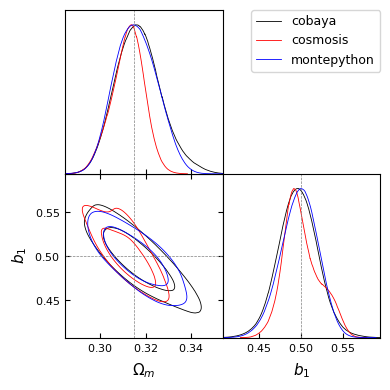

In [62]:
g = plots.get_subplot_plotter()
g.triangle_plot([samples_bao_fs_cobaya, samples_bao_fs_cosmosis, samples_bao_fs_montepython],
                 params=['Omega_m', 'b1'], markers={'Omega_m': cosmo['Omega_m'], 'b1': 0.5})

# Wrap-up

- compressed or full-shape likelihoods are defined only once, within desilike
- bindings for Cobaya, CosmoSIS and MontePython are generated with a simple function call
- for Cobaya, the generated likelihood can be straightforwardly imported
- for CosmoSIS and MontePython, the descroption of nuisance parameters need be copied into the input config files